# Stacked Thermodynamic Profiles 2D

In [3]:
import yt
import pyxsim

import h5py
import numpy as np
import illustris_python as il
import glob

from tqdm import tqdm
import os
from regions import RectangleSkyRegion
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy import wcs
from astropy.io import fits
import pylab as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

ModuleNotFoundError: No module named 'yt'

In [ ]:
#PART 2: Simulation Specification
basePath = "../../../sims.TNG/TNG50-1/output/"
snap = 50                                                       #z=1
nbins = 100
r_norm_max = 2
max_workers = 3
tag = ["Efficient_AGN", "Efficient_Non", "Inefficient_AGN", "Inefficient_Non"]
hm = "1112"

In [ ]:
def process_single_halo(args):
    haloID, label = args
    try:
        print(f"Processing {label} halo {haloID}...")
        halo = il.groupcat.loadSingle(basePath, snap, haloID=haloID)

        header = il.groupcat.loadHeader(basePath, snap)
        gas = il.snapshot.loadHalo(basePath, snap, haloID, "gas")
        with h5py.File(il.snapshot.snapPath(basePath, snap), 'r') as f:
            header_snap = dict(f['Header'].attrs)

        filename = f"halo_{label}_{haloID}.hdf5"
        with h5py.File(filename, 'w') as f:
            for key in gas.keys():
                f['PartType0/' + key] = gas[key]
            f.create_group('Header')
            f['Header'].attrs['NumFilesPerSnapshot'] = 1
            f['Header'].attrs['MassTable'] = header_snap['MassTable']
            f['Header'].attrs['BoxSize'] = header['BoxSize']
            f['Header'].attrs['Time'] = header['Time']
            f['Header'].attrs['Redshift'] = header['Redshift']
            f['Header'].attrs['NumPart_ThisFile'] = np.array([gas['count'],0,0,0,0,0])
            f['Header'].attrs['HubbleParam'] = header['HubbleParam']
            f['Header'].attrs['Omega0'] = header['Omega0']
            f['Header'].attrs['OmegaLambda'] = header['OmegaLambda']
            f['Header'].attrs['UnitLength_in_cm'] = header_snap['UnitLength_in_cm']
            f['Header'].attrs['UnitMass_in_g'] = header_snap['UnitMass_in_g']
            f['Header'].attrs['UnitVelocity_in_cm_per_s'] = header_snap['UnitVelocity_in_cm_per_s']

        ds = yt.load(filename)
        c = ds.arr(halo["GroupPos"], "code_length").to("kpc")
        r200 = ds.arr(halo["Group_R_Crit200"], "code_length").to("kpc")
        
        del halo, gas, header
        
        def hot_gas(pfilter, data):
            pfilter1 = data[pfilter.filtered_type, "temperature"] > 3.0e5
            pfilter2 = data["PartType0", "StarFormationRate"] == 0.0
            pfilter3 = data["PartType0", "GFM_CoolingRate"] < 0.0
            return (pfilter1 & pfilter2) & pfilter3

        yt.add_particle_filter("hot_gas", function=hot_gas,
                               filtered_type='gas', requires=["temperature","density"])
        ds.add_particle_filter("hot_gas")

        source_model = pyxsim.CIESourceModel(
            "apec", 0.5, 2.0, 10000,
            ("hot_gas", "metallicity"),
            temperature_field=("hot_gas", "temperature"),
            emission_measure_field=("hot_gas", "emission_measure"),
        )

        prj = yt.ProjectionPlot(ds, "z", ("gas", "temperature"), width=2*r_norm_max*r200, center=c, weight_field=("gas", "density"), buff_size = (500, 500))

        frb = prj.frb

        temperature = frb[("gas", "temperature")]
        density     = frb[("gas", "density")]
        pressure    = frb[("gas", "pressure")]
        entropy     = frb[("gas", "entropy")]
        
        ny, nx = temperature.shape
        center_x, center_y = nx // 2, ny // 2
        y, x = np.indices((ny, nx))
        rp = (np.sqrt((x - center_x)**2 + (y - center_y)**2))/r200
        radii = rp * (2* r_norm_max * r200/500.0)
        r_bins = np.linspace(0, r_norm_max, nbins + 1)

        def bin_profile(quantity):
            binned = np.array([
                np.mean(quantity[(radii >= r_bins[i]) & (radii < r_bins[i+1])])
                if np.any((radii >= r_bins[i]) & (radii < r_bins[i+1])) else np.nan
                for i in range(nbins)
            ])
            return np.nan_to_num(binned, nan=0.0)
        
        t = bin_profile(temperature)
        e = bin_profile(entropy)
        p = bin_profile(pressure)
        d = bin_profile(density)
        
        for f in [filename, filename + ".ewah"]:
            if os.path.exists(f):
                os.remove(f)

        return (haloID, t, e, p, d)

    except Exception as e:
        print(f"❌ Failed for halo {haloID}: {e}")
        return (haloID, np.zeros(nbins), np.zeros(nbins), np.zeros(nbins), np.zeros(nbins))


def combined_xray_profiles(halo_list, label, max_workers=3):
    temperature_profile = np.zeros((len(halo_list), nbins))
    entropy_profile = np.zeros((len(halo_list), nbins))
    pressure_profile = np.zeros((len(halo_list), nbins))
    density_profile = np.zeros((len(halo_list), nbins))

    #with ProcessPoolExecutor(max_workers=max_workers) as executor:
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(process_single_halo, (haloID, label)): i for i, haloID in enumerate(halo_list)}
        for future in tqdm(as_completed(futures), total=len(futures), desc=f"{label} Halos"):
            i = futures[future]
            haloID, t, e, p, d = future.result()
            temperature_profile[i, :] = t
            entropy_profile[i, :] = e
            pressure_profile[i, :] = p
            density_profile[i, :] = d
    
    N = len(halo_list)
    
    temperature_mean = np.nanmean(temperature_profile, axis=0)
    temperature_sem = np.nanstd(temperature_profile, axis=0, ddof=1) / np.sqrt(N)
    entropy_mean=np.nanmean(entropy_profile, axis=0),
    entropy_sem=np.nanstd(entropy_profile, axis=0, ddof=1) / np.sqrt(N),
    pressure_mean=np.nanmean(pressure_profile, axis=0),
    pressure_sem=np.nanstd(pressure_profile, axis=0, ddof=1) / np.sqrt(N),
    density_mean=np.nanmean(density_profile, axis=0),
    density_sem=np.nanstd(density_profile, axis=0, ddof=1) / np.sqrt(N)

    np.savez(f"profile2d_{label}_{hm}.npz", temperature_mean=temperature_mean, temperature_sem=temperature_sem, entropy_mean=entropy_mean,entropy_sem=entropy_sem,
             pressure_mean=pressure_mean, pressure_sem=pressure_sem, density_mean=density_mean, density_sem=density_sem, )
    print(f"✅ Saved profile2d_{label}_{hm}.npz")

In [ ]:
data = np.load(f"accretor_agn50_hm{hm}.npz")

combined_xray_profiles(data["ha_agn"], tag[0])
combined_xray_profiles(data["hn_agn"], tag[2])
combined_xray_profiles(data["hn_non"], tag[3])

Processing Efficient_AGN halo 135...
Processing Efficient_AGN halo 172...
Processing Efficient_AGN halo 185...


Efficient_AGN Halos:   0%|          | 0/60 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-08 18:36:55,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:36:55,824 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:36:55,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:36:55,877 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:36:55,948 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:36:55,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:36:55,960 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:36:55,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:36:55,964 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:36:55,965 Parameters: domain_left_edge     

❌ Failed for halo 172: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 185: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Efficient_AGN halo 249...

Processing Efficient_AGN halo 260...


yt : [INFO     ] 2025-05-08 18:37:27,196 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:37:27,295 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:37:27,297 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:37:27,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:37:27,299 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:37:27,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:37:27,303 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:37:27,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:37:27,305 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:37:27,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:37:27,308 Parameters: hubble_consta

Processing Efficient_AGN halo 298...


Efficient_AGN Halos:   7%|▋         | 4/60 [01:16<14:41, 15.74s/it]

Processing Efficient_AGN halo 316...


yt : [INFO     ] 2025-05-08 18:38:04,970 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:38:05,126 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:38:05,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:38:05,130 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:38:05,131 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:38:05,133 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:38:05,134 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:38:05,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:38:05,137 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:38:05,138 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:38:05,139 Parameters: hubble_consta

Processing Efficient_AGN halo 319...


yt : [INFO     ] 2025-05-08 18:38:14,705 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:38:14,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:38:14,787 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:38:14,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:38:14,789 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:38:14,790 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:38:14,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:38:14,793 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:38:14,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:38:14,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:38:14,795 Parameters: hubble_consta

Processing Efficient_AGN halo 325...


Efficient_AGN Halos:  12%|█▏        | 7/60 [01:53<11:00, 12.46s/it]

Processing Efficient_AGN halo 369...


yt : [INFO     ] 2025-05-08 18:38:40,939 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:38:41,950 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:38:42,035 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:38:42,037 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:38:42,039 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:38:42,041 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:38:42,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:38:42,045 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:38:42,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:38:42,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:38:42,049 P

Processing Efficient_AGN halo 400...


pyxsim : [INFO     ] 2025-05-08 18:38:51,939 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:38:51,940 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:38:51,953 xlim = 27873.394291 28523.742428
yt : [INFO     ] 2025-05-08 18:38:51,955 ylim = 4553.929936 5204.278072
yt : [INFO     ] 2025-05-08 18:38:51,963 xlim = 27873.394291 28523.742428
yt : [INFO     ] 2025-05-08 18:38:51,964 ylim = 4553.929936 5204.278072
yt : [INFO     ] 2025-05-08 18:38:51,967 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:38:52,412 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:38:52,415 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:38:52,432 xlim = 21434.974864 22100.247793
yt : [INFO     ] 2025-05-08 18:38:52,433 ylim = 10983.821543 11649.094472
yt : [INFO     ] 2025-05-08 18:38:52,441 xlim = 21434.974864 22100.247793
yt : [INFO     ] 2025-05-08 18:38:52,453 ylim = 10983.821543 11649.094472
yt : [INFO     ] 2025-05-08 18:38:52,458 Making a

Processing Efficient_AGN halo 402...


Efficient_AGN Halos:  17%|█▋        | 10/60 [02:25<08:35, 10.31s/it]

Processing Efficient_AGN halo 412...


yt : [INFO     ] 2025-05-08 18:39:13,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:39:13,175 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:39:13,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:39:13,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:39:13,179 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:39:13,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:39:13,181 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:39:13,182 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:39:13,184 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:39:13,185 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:39:13,186 Parameters: hubble_consta

Processing Efficient_AGN halo 413...


pyxsim : [INFO     ] 2025-05-08 18:39:22,719 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:39:22,720 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:39:22,738 xlim = 2959.418725 3599.094947
yt : [INFO     ] 2025-05-08 18:39:22,738 ylim = 32809.474389 33449.150611
yt : [INFO     ] 2025-05-08 18:39:22,746 xlim = 2959.418725 3599.094947
yt : [INFO     ] 2025-05-08 18:39:22,747 ylim = 32809.474389 33449.150611
yt : [INFO     ] 2025-05-08 18:39:22,749 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:39:23,021 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:39:23,022 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:39:23,044 xlim = 24831.168882 25462.526430
yt : [INFO     ] 2025-05-08 18:39:23,045 ylim = 20999.541929 21630.899477
yt : [INFO     ] 2025-05-08 18:39:23,049 xlim = 24831.168882 25462.526430
yt : [INFO     ] 2025-05-08 18:39:23,050 ylim = 20999.541929 21630.899477
yt : [INFO     ] 2025-05-08 18:39:23,055 Making a

Processing Efficient_AGN halo 423...


Efficient_AGN Halos:  22%|██▏       | 13/60 [02:54<06:56,  8.86s/it]

Processing Efficient_AGN halo 433...


yt : [INFO     ] 2025-05-08 18:39:41,344 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:39:41,491 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:39:41,492 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:39:41,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:39:41,494 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:39:41,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:39:41,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:39:41,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:39:41,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:39:41,498 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:39:41,499 Parameters: hubble_consta

Processing Efficient_AGN halo 436...


pyxsim : [INFO     ] 2025-05-08 18:39:52,256 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:39:52,256 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:39:52,271 xlim = 1177.855141 1788.036948
yt : [INFO     ] 2025-05-08 18:39:52,273 ylim = 5095.077553 5705.259361
yt : [INFO     ] 2025-05-08 18:39:52,278 xlim = 1177.855141 1788.036948
yt : [INFO     ] 2025-05-08 18:39:52,280 ylim = 5095.077553 5705.259361
yt : [INFO     ] 2025-05-08 18:39:52,283 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:39:52,397 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:39:52,399 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:39:52,413 xlim = 12482.502379 13105.972230
yt : [INFO     ] 2025-05-08 18:39:52,414 ylim = 18782.267027 19405.736879
yt : [INFO     ] 2025-05-08 18:39:52,418 xlim = 12482.502379 13105.972230
yt : [INFO     ] 2025-05-08 18:39:52,419 ylim = 18782.267027 19405.736879
yt : [INFO     ] 2025-05-08 18:39:52,422 Making a fix

Processing Efficient_AGN halo 451...


Efficient_AGN Halos:  27%|██▋       | 16/60 [03:24<06:19,  8.61s/it]

Processing Efficient_AGN halo 461...


yt : [INFO     ] 2025-05-08 18:40:11,015 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:40:11,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:40:11,877 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:40:11,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:40:11,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:40:11,884 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:40:11,886 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:40:11,889 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:40:11,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:40:11,892 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:40:11,894 P

Processing Efficient_AGN halo 486...


pyxsim : [INFO     ] 2025-05-08 18:40:21,657 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:40:21,658 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:40:21,675 xlim = 24445.136129 25074.000590
yt : [INFO     ] 2025-05-08 18:40:21,676 ylim = 3301.291647 3930.156107
yt : [INFO     ] 2025-05-08 18:40:21,680 xlim = 24445.136129 25074.000590
yt : [INFO     ] 2025-05-08 18:40:21,741 ylim = 3301.291647 3930.156107
yt : [INFO     ] 2025-05-08 18:40:21,744 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:40:22,046 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:40:22,047 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:40:22,068 xlim = 22235.568350 22839.349618
yt : [INFO     ] 2025-05-08 18:40:22,070 ylim = 17264.917960 17868.699228
yt : [INFO     ] 2025-05-08 18:40:22,100 xlim = 22235.568350 22839.349618
yt : [INFO     ] 2025-05-08 18:40:22,102 ylim = 17264.917960 17868.699228
yt : [INFO     ] 2025-05-08 18:40:22,106 Making a

Processing Efficient_AGN halo 487...


Efficient_AGN Halos:  32%|███▏      | 19/60 [03:53<05:44,  8.41s/it]

Processing Efficient_AGN halo 514...


yt : [INFO     ] 2025-05-08 18:40:41,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:40:41,788 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:40:41,789 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:40:41,790 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:40:41,792 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:40:41,793 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:40:41,796 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:40:41,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:40:41,798 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:40:41,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:40:41,802 Parameters: hubble_consta

Processing Efficient_AGN halo 520...


pyxsim : [INFO     ] 2025-05-08 18:40:52,217 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:40:52,218 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:40:52,239 xlim = 20162.650627 20752.997810
yt : [INFO     ] 2025-05-08 18:40:52,240 ylim = 30440.679924 31031.027107
yt : [INFO     ] 2025-05-08 18:40:52,255 xlim = 20162.650627 20752.997810
yt : [INFO     ] 2025-05-08 18:40:52,256 ylim = 30440.679924 31031.027107
yt : [INFO     ] 2025-05-08 18:40:52,262 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:40:52,793 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:40:52,794 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:40:52,806 xlim = 21745.543039 22247.710867
yt : [INFO     ] 2025-05-08 18:40:52,807 ylim = 736.983835 1239.151663
yt : [INFO     ] 2025-05-08 18:40:52,812 xlim = 21745.543039 22247.710867
yt : [INFO     ] 2025-05-08 18:40:52,812 ylim = 736.983835 1239.151663
yt : [INFO     ] 2025-05-08 18:40:52,814 Making a f

Processing Efficient_AGN halo 522...


Efficient_AGN Halos:  37%|███▋      | 22/60 [04:21<04:57,  7.82s/it]

Processing Efficient_AGN halo 563...


yt : [INFO     ] 2025-05-08 18:41:08,211 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:41:08,260 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:41:08,503 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:41:08,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:41:08,509 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:41:08,510 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:41:08,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:41:08,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:41:08,515 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:41:08,516 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:41:08,517 

Processing Efficient_AGN halo 639...


pyxsim : [INFO     ] 2025-05-08 18:41:18,201 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:41:18,202 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:41:18,215 xlim = 23305.070713 23882.917568
yt : [INFO     ] 2025-05-08 18:41:18,217 ylim = 12175.117588 12752.964443
yt : [INFO     ] 2025-05-08 18:41:18,225 xlim = 23305.070713 23882.917568
yt : [INFO     ] 2025-05-08 18:41:18,226 ylim = 12175.117588 12752.964443
yt : [INFO     ] 2025-05-08 18:41:18,230 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:41:18,426 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:41:18,427 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:41:18,440 xlim = -228.418685 302.499938
yt : [INFO     ] 2025-05-08 18:41:18,441 ylim = 32204.601235 32735.519858
yt : [INFO     ] 2025-05-08 18:41:18,444 xlim = -228.418685 302.499938
yt : [INFO     ] 2025-05-08 18:41:18,445 ylim = 32204.601235 32735.519858
yt : [INFO     ] 2025-05-08 18:41:18,446 Making a f

Processing Efficient_AGN halo 686...


Efficient_AGN Halos:  42%|████▏     | 25/60 [04:47<04:20,  7.45s/it]

Processing Efficient_AGN halo 722...


yt : [INFO     ] 2025-05-08 18:41:32,215 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:41:33,741 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:41:33,872 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:41:33,873 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:41:33,877 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:41:33,879 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:41:33,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:41:33,880 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:41:33,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:41:33,883 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:41:33,885 

Processing Efficient_AGN halo 755...


pyxsim : [INFO     ] 2025-05-08 18:41:42,558 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:41:42,559 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:41:42,581 xlim = 24510.485754 25050.268152
yt : [INFO     ] 2025-05-08 18:41:42,582 ylim = 5389.541418 5929.323816
yt : [INFO     ] 2025-05-08 18:41:42,586 xlim = 24510.485754 25050.268152
yt : [INFO     ] 2025-05-08 18:41:42,587 ylim = 5389.541418 5929.323816
yt : [INFO     ] 2025-05-08 18:41:42,589 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:41:43,101 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:41:43,102 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:41:43,124 xlim = 6618.575858 7137.581369
yt : [INFO     ] 2025-05-08 18:41:43,125 ylim = 29949.446463 30468.451974
yt : [INFO     ] 2025-05-08 18:41:43,130 xlim = 6618.575858 7137.581369
yt : [INFO     ] 2025-05-08 18:41:43,131 ylim = 29949.446463 30468.451974
yt : [INFO     ] 2025-05-08 18:41:43,133 Making a fix

Processing Efficient_AGN halo 801...


yt : [INFO     ] 2025-05-08 18:41:54,037 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
Efficient_AGN Halos:  47%|████▋     | 28/60 [05:10<03:37,  6.81s/it]

Processing Efficient_AGN halo 809...


yt : [INFO     ] 2025-05-08 18:41:56,572 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:41:56,718 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:41:56,720 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:41:56,722 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:41:56,724 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:41:56,725 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:41:56,725 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:41:56,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:41:56,728 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:41:56,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:41:56,730 Parameters: hubble_consta

Processing Efficient_AGN halo 821...


pyxsim : [INFO     ] 2025-05-08 18:42:05,300 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:42:05,303 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:42:05,325 xlim = 2119.413580 2637.929194
yt : [INFO     ] 2025-05-08 18:42:05,326 ylim = 4220.778814 4739.294428
yt : [INFO     ] 2025-05-08 18:42:05,330 xlim = 2119.413580 2637.929194
yt : [INFO     ] 2025-05-08 18:42:05,330 ylim = 4220.778814 4739.294428
yt : [INFO     ] 2025-05-08 18:42:05,332 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:42:05,576 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:42:05,577 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:42:05,591 xlim = -159.321417 347.647528
yt : [INFO     ] 2025-05-08 18:42:05,591 ylim = 19852.597559 20359.566504
yt : [INFO     ] 2025-05-08 18:42:05,598 xlim = -159.321417 347.647528
yt : [INFO     ] 2025-05-08 18:42:05,599 ylim = 19852.597559 20359.566504
yt : [INFO     ] 2025-05-08 18:42:05,602 Making a fixed res

Processing Efficient_AGN halo 836...


Efficient_AGN Halos:  52%|█████▏    | 31/60 [05:32<03:06,  6.45s/it]

Processing Efficient_AGN halo 839...


yt : [INFO     ] 2025-05-08 18:42:18,068 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:42:19,523 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:42:19,660 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:42:19,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:42:19,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:42:19,665 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:42:19,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:42:19,669 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:42:19,670 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:42:19,671 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:42:19,673 P

Processing Efficient_AGN halo 856...


pyxsim : [INFO     ] 2025-05-08 18:42:29,237 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:42:29,238 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:42:29,251 xlim = 1841.963637 2327.057359
yt : [INFO     ] 2025-05-08 18:42:29,252 ylim = 29930.103529 30415.197252
yt : [INFO     ] 2025-05-08 18:42:29,260 xlim = 1841.963637 2327.057359
yt : [INFO     ] 2025-05-08 18:42:29,272 ylim = 29930.103529 30415.197252
yt : [INFO     ] 2025-05-08 18:42:29,275 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:42:29,699 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:42:29,700 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:42:29,714 xlim = 27425.954901 27933.459161
yt : [INFO     ] 2025-05-08 18:42:29,715 ylim = 33455.607245 33963.111505
yt : [INFO     ] 2025-05-08 18:42:29,722 xlim = 27425.954901 27933.459161
yt : [INFO     ] 2025-05-08 18:42:29,723 ylim = 33455.607245 33963.111505
yt : [INFO     ] 2025-05-08 18:42:29,726 Making a

Processing Efficient_AGN halo 857...


Efficient_AGN Halos:  57%|█████▋    | 34/60 [05:55<02:47,  6.45s/it]

Processing Efficient_AGN halo 859...


yt : [INFO     ] 2025-05-08 18:42:41,273 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:42:42,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:42:42,273 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:42:42,275 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:42:42,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:42:42,279 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:42:42,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:42:42,281 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:42:42,282 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:42:42,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:42:42,284 P

Processing Efficient_AGN halo 860...


pyxsim : [INFO     ] 2025-05-08 18:42:51,879 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:42:51,880 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:42:51,895 xlim = 25174.407898 25670.248352
yt : [INFO     ] 2025-05-08 18:42:51,897 ylim = 26366.646180 26862.486633
yt : [INFO     ] 2025-05-08 18:42:51,902 xlim = 25174.407898 25670.248352
yt : [INFO     ] 2025-05-08 18:42:51,904 ylim = 26366.646180 26862.486633
yt : [INFO     ] 2025-05-08 18:42:51,909 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:42:52,528 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:42:52,530 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:42:52,550 xlim = 3775.762772 4276.864181
yt : [INFO     ] 2025-05-08 18:42:52,551 ylim = 31004.523514 31505.624923
yt : [INFO     ] 2025-05-08 18:42:52,556 xlim = 3775.762772 4276.864181
yt : [INFO     ] 2025-05-08 18:42:52,558 ylim = 31004.523514 31505.624923
yt : [INFO     ] 2025-05-08 18:42:52,563 Making a

Processing Efficient_AGN halo 896...


pyxsim : [INFO     ] 2025-05-08 18:43:02,072 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:02,074 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:02,091 xlim = 10291.779972 10787.022763
yt : [INFO     ] 2025-05-08 18:43:02,093 ylim = 31333.107120 31828.349911
yt : [INFO     ] 2025-05-08 18:43:02,100 xlim = 10291.779972 10787.022763
yt : [INFO     ] 2025-05-08 18:43:02,101 ylim = 31333.107120 31828.349911
yt : [INFO     ] 2025-05-08 18:43:02,104 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Efficient_AGN Halos:  62%|██████▏   | 37/60 [06:18<02:26,  6.36s/it]

Processing Efficient_AGN halo 920...


yt : [INFO     ] 2025-05-08 18:43:05,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:43:05,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:43:05,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:43:05,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:43:05,415 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:43:05,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:43:05,417 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:43:05,418 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:43:05,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:43:05,422 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:43:05,422 Parameters: hubble_consta

Processing Efficient_AGN halo 965...


pyxsim : [INFO     ] 2025-05-08 18:43:14,452 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:14,453 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:14,466 xlim = 25694.501596 26188.459341
yt : [INFO     ] 2025-05-08 18:43:14,467 ylim = 356.242075 850.199820
yt : [INFO     ] 2025-05-08 18:43:14,471 xlim = 25694.501596 26188.459341
yt : [INFO     ] 2025-05-08 18:43:14,472 ylim = 356.242075 850.199820
yt : [INFO     ] 2025-05-08 18:43:14,476 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:43:14,633 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:14,634 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:14,646 xlim = 11905.874386 12382.174442
yt : [INFO     ] 2025-05-08 18:43:14,647 ylim = 20288.043331 20764.343388
yt : [INFO     ] 2025-05-08 18:43:14,656 xlim = 11905.874386 12382.174442
yt : [INFO     ] 2025-05-08 18:43:14,657 ylim = 20288.043331 20764.343388
yt : [INFO     ] 2025-05-08 18:43:14,660 Making a fix

Processing Efficient_AGN halo 978...


Efficient_AGN Halos:  67%|██████▋   | 40/60 [06:39<01:59,  5.98s/it]

Processing Efficient_AGN halo 980...


pyxsim : [INFO     ] 2025-05-08 18:43:24,155 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:24,156 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:24,192 xlim = 22165.949501 22645.487999
yt : [INFO     ] 2025-05-08 18:43:24,193 ylim = 5465.030067 5944.568566
yt : [INFO     ] 2025-05-08 18:43:24,197 xlim = 22165.949501 22645.487999
yt : [INFO     ] 2025-05-08 18:43:24,198 ylim = 5465.030067 5944.568566
yt : [INFO     ] 2025-05-08 18:43:24,200 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:26,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:43:26,309 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:26,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:43:26,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:43:26,489 Parameters: domain_left_edge 

Processing Efficient_AGN halo 990...


pyxsim : [INFO     ] 2025-05-08 18:43:34,909 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:34,910 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:34,929 xlim = 16083.591226 16558.643149
yt : [INFO     ] 2025-05-08 18:43:34,930 ylim = 2254.832193 2729.884116
yt : [INFO     ] 2025-05-08 18:43:34,938 xlim = 16083.591226 16558.643149
yt : [INFO     ] 2025-05-08 18:43:34,939 ylim = 2254.832193 2729.884116
yt : [INFO     ] 2025-05-08 18:43:34,982 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:35,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:43:35,441 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:43:35,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:43:35,444 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:43:35,446 Parameters: domain_right_edge         = [35000

Processing Efficient_AGN halo 1024...


pyxsim : [INFO     ] 2025-05-08 18:43:43,024 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:43,056 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:43,075 xlim = 32493.354196 32958.997367
yt : [INFO     ] 2025-05-08 18:43:43,095 ylim = 28728.639352 29194.282523
yt : [INFO     ] 2025-05-08 18:43:43,136 xlim = 32493.354196 32958.997367
yt : [INFO     ] 2025-05-08 18:43:43,138 ylim = 28728.639352 29194.282523
yt : [INFO     ] 2025-05-08 18:43:43,141 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:43,972 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:44,087 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:43:44,167 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:43:44,169 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:43:44,170 Parameters: domain_left_e

Processing Efficient_AGN halo 1025...


yt : [INFO     ] 2025-05-08 18:43:49,491 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:49,610 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:43:49,701 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:43:49,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:43:49,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:43:49,707 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:43:49,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:43:49,709 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:43:49,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:43:49,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:43:49,716 

Processing Efficient_AGN halo 1044...


yt : [INFO     ] 2025-05-08 18:43:55,748 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:43:56,063 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:43:56,066 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:43:56,084 xlim = 5930.717423 6386.029647
yt : [INFO     ] 2025-05-08 18:43:56,085 ylim = 5347.636369 5802.948592
yt : [INFO     ] 2025-05-08 18:43:56,092 xlim = 5930.717423 6386.029647
yt : [INFO     ] 2025-05-08 18:43:56,092 ylim = 5347.636369 5802.948592
yt : [INFO     ] 2025-05-08 18:43:56,097 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:43:56,335 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:43:56,430 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:43:56,432 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:43:56,434 Parameters: domain_left_edge     

Processing Efficient_AGN halo 1050...


yt : [INFO     ] 2025-05-08 18:44:01,902 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:01,937 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:02,013 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:02,014 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:02,015 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:02,017 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:02,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:02,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:02,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:44:02,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:44:02,025 P

Processing Efficient_AGN halo 1063...


yt : [INFO     ] 2025-05-08 18:44:07,226 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:07,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:07,383 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:07,384 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:07,385 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:07,388 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:07,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:07,390 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:07,391 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:44:07,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:44:07,392 P

Processing Efficient_AGN halo 1086...


pyxsim : [INFO     ] 2025-05-08 18:44:13,993 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:44:13,994 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:44:14,008 xlim = 30425.733272 30893.321416
yt : [INFO     ] 2025-05-08 18:44:14,020 ylim = 31567.772334 32035.360478
yt : [INFO     ] 2025-05-08 18:44:14,031 xlim = 30425.733272 30893.321416
yt : [INFO     ] 2025-05-08 18:44:14,032 ylim = 31567.772334 32035.360478
yt : [INFO     ] 2025-05-08 18:44:14,037 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:15,030 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:15,112 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:15,202 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:15,204 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:15,205 Parameters: domain_left_e

Processing Efficient_AGN halo 1140...


yt : [INFO     ] 2025-05-08 18:44:18,822 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:20,123 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:20,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:20,295 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:20,297 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:20,298 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:20,299 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:20,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:20,301 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:20,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Efficient_AGN halo 1171...


yt : [INFO     ] 2025-05-08 18:44:25,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:25,272 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:25,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:25,273 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:25,275 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:25,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:25,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:25,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:44:25,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:44:25,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:44:25,280 Parameters: hubble_consta

Processing Efficient_AGN halo 1202...


yt : [INFO     ] 2025-05-08 18:44:31,173 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:44:31,759 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:44:31,760 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:44:31,772 xlim = 31616.541998 32068.047846
yt : [INFO     ] 2025-05-08 18:44:31,774 ylim = 17413.415045 17864.920893
yt : [INFO     ] 2025-05-08 18:44:31,777 xlim = 31616.541998 32068.047846
yt : [INFO     ] 2025-05-08 18:44:31,778 ylim = 17413.415045 17864.920893
yt : [INFO     ] 2025-05-08 18:44:31,783 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:32,584 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:32,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:32,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:32,763 Parameters: domain_left_e

Processing Efficient_AGN halo 1245...


yt : [INFO     ] 2025-05-08 18:44:36,580 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:37,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:37,960 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:37,994 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:37,995 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:37,997 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:37,998 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:38,000 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:38,000 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:38,001 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Efficient_AGN halo 1276...


yt : [INFO     ] 2025-05-08 18:44:43,048 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:43,197 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:43,277 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:43,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:43,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:43,284 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:43,286 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:43,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:43,288 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:44:43,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:44:43,290 P

Processing Efficient_AGN halo 1381...


yt : [INFO     ] 2025-05-08 18:44:47,522 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:48,875 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:48,954 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:49,034 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:49,035 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:49,037 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:49,038 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:49,039 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:49,040 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:49,042 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Efficient_AGN halo 1387...


yt : [INFO     ] 2025-05-08 18:44:53,425 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:54,244 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:54,360 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:54,361 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:54,362 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:54,363 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:54,367 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:54,368 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:54,370 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:44:54,372 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:44:54,373 P

Processing Efficient_AGN halo 1397...


yt : [INFO     ] 2025-05-08 18:44:58,582 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:59,511 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:44:59,677 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:44:59,680 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:44:59,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:44:59,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:44:59,689 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:44:59,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:44:59,693 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:44:59,697 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Efficient_AGN halo 1435...


yt : [INFO     ] 2025-05-08 18:45:03,934 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:45:04,710 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:45:04,744 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:45:04,848 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:45:04,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:45:04,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:45:04,855 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:45:04,856 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:45:04,858 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:45:04,860 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Efficient_AGN halo 1519...


yt : [INFO     ] 2025-05-08 18:45:08,747 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:45:09,923 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:45:09,961 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:45:10,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:45:10,054 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:45:10,057 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:45:10,058 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:45:10,060 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:45:10,061 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:45:10,062 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

✅ Saved profile2d_Efficient_AGN_1112.npz
Processing Inefficient_AGN halo 70...
Processing Inefficient_AGN halo 79...
Processing Inefficient_AGN halo 84...


Inefficient_AGN Halos:   0%|          | 0/1165 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-08 18:45:29,384 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:45:29,517 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:45:29,519 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:45:29,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:45:29,523 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:45:29,524 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:45:29,525 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:45:29,526 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:45:29,527 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:45:29,528 Parameters: omega_radiation           = 0.0
yt 

Processing Inefficient_AGN halo 85...


yt : [INFO     ] 2025-05-08 18:46:45,870 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:46:46,762 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:46:46,860 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:46:46,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:46:46,881 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:46:46,943 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:46:46,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:46:46,945 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:46:46,948 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:46:46,952 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:46:46,954 P

Processing Inefficient_AGN halo 98...


pyxsim : [INFO     ] 2025-05-08 18:46:58,069 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:46:58,071 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:46:58,087 xlim = 23060.887377 24014.046217
yt : [INFO     ] 2025-05-08 18:46:58,088 ylim = 23336.711596 24289.870436
yt : [INFO     ] 2025-05-08 18:46:58,091 xlim = 23060.887377 24014.046217
yt : [INFO     ] 2025-05-08 18:46:58,093 ylim = 23336.711596 24289.870436
yt : [INFO     ] 2025-05-08 18:46:58,096 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:47:04,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:47:04,509 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:47:04,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:47:04,511 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:47:04,513 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 119...



Initializing refined index: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]
pyxsim : [INFO     ] 2025-05-08 18:47:14,461 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:47:14,463 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:47:14,475 xlim = 18009.745319 18867.059368
yt : [INFO     ] 2025-05-08 18:47:14,477 ylim = 25769.575398 26626.889446
yt : [INFO     ] 2025-05-08 18:47:14,480 xlim = 18009.745319 18867.059368
yt : [INFO     ] 2025-05-08 18:47:14,482 ylim = 25769.575398 26626.889446
yt : [INFO     ] 2025-05-08 18:47:14,488 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:47:16,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:47:16,092 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:47:16,093 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:47:16,094 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [

Processing Inefficient_AGN halo 132...


Inefficient_AGN Halos:   0%|          | 5/1165 [02:46<8:17:47, 25.75s/it] 

Processing Inefficient_AGN halo 137...


yt : [INFO     ] 2025-05-08 18:48:10,355 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:48:10,754 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:48:10,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:48:10,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:48:10,758 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:48:10,759 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:48:10,760 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:48:10,763 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:48:10,764 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:48:10,764 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:48:10,766 Parameters: hubble_consta

Processing Inefficient_AGN halo 146...


Initializing refined index: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]
yt : [INFO     ] 2025-05-08 18:48:24,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:48:24,952 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:48:24,953 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:48:24,955 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:48:24,956 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:48:24,959 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:48:24,960 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:48:24,961 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:48:24,962 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:48:24,963 Parameters: omega_radiation         

Processing Inefficient_AGN halo 154...


yt : [INFO     ] 2025-05-08 18:49:05,253 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:49:05,357 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:49:05,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:49:05,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:49:05,362 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:49:05,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:49:05,366 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:49:05,368 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:49:05,370 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:49:05,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:49:05,371 Parameters: hubble_consta

Processing Inefficient_AGN halo 155...


Inefficient_AGN Halos:   1%|          | 9/1165 [03:53<5:01:05, 15.63s/it]

Processing Inefficient_AGN halo 159...


pyxsim : [INFO     ] 2025-05-08 18:49:13,072 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:49:13,073 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:49:13,085 xlim = 14369.180645 15213.559590
yt : [INFO     ] 2025-05-08 18:49:13,086 ylim = 8840.031231 9684.410176
yt : [INFO     ] 2025-05-08 18:49:13,089 xlim = 14369.180645 15213.559590
yt : [INFO     ] 2025-05-08 18:49:13,090 ylim = 8840.031231 9684.410176
yt : [INFO     ] 2025-05-08 18:49:13,092 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:49:18,313 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:49:18,386 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:49:18,388 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:49:18,391 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:49:18,392 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 161...


yt : [INFO     ] 2025-05-08 18:49:50,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:49:50,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:49:50,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:49:50,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:49:50,563 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:49:50,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:49:50,567 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:49:50,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:49:50,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:49:50,577 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:49:50,578 Parameters: hubble_consta

Processing Inefficient_AGN halo 162...


yt : [INFO     ] 2025-05-08 18:50:08,555 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:50:09,761 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:50:09,858 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:50:09,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:50:09,863 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:50:09,865 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:50:09,867 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:50:09,868 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:50:09,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:50:09,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:50:09,874 P

Processing Inefficient_AGN halo 163...


pyxsim : [INFO     ] 2025-05-08 18:50:16,941 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:50:16,942 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:50:16,954 xlim = 14234.302447 15080.445600
yt : [INFO     ] 2025-05-08 18:50:16,956 ylim = 19050.758502 19896.901655
yt : [INFO     ] 2025-05-08 18:50:16,960 xlim = 14234.302447 15080.445600
yt : [INFO     ] 2025-05-08 18:50:16,961 ylim = 19050.758502 19896.901655
yt : [INFO     ] 2025-05-08 18:50:16,963 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:50:19,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:50:19,841 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:50:19,842 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:50:19,844 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:50:19,846 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 164...


yt : [INFO     ] 2025-05-08 18:50:41,783 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:50:41,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:50:41,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:50:41,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:50:41,872 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:50:41,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:50:41,873 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:50:41,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:50:41,875 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:50:41,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:50:41,876 Parameters: hubble_consta

Processing Inefficient_AGN halo 170...


yt : [INFO     ] 2025-05-08 18:50:49,808 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:50:50,463 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:50:50,464 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:50:50,480 xlim = 26000.140832 26848.464637
yt : [INFO     ] 2025-05-08 18:50:50,482 ylim = 12861.476770 13709.800574
yt : [INFO     ] 2025-05-08 18:50:50,491 xlim = 26000.140832 26848.464637
yt : [INFO     ] 2025-05-08 18:50:50,492 ylim = 12861.476770 13709.800574
yt : [INFO     ] 2025-05-08 18:50:50,499 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:50:53,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:50:53,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:50:53,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:50:53,400 Parameters: domain_left_

Processing Inefficient_AGN halo 173...


yt : [INFO     ] 2025-05-08 18:51:12,893 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:51:15,422 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:51:15,513 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:51:15,514 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:51:15,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:51:15,517 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:51:15,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:51:15,520 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:51:15,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:51:15,523 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:51:15,525 P

Processing Inefficient_AGN halo 175...


yt : [INFO     ] 2025-05-08 18:51:32,278 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:51:32,377 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:51:32,470 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:51:32,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:51:32,473 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:51:32,475 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:51:32,477 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:51:32,478 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:51:32,481 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:51:32,482 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:51:32,484 P

Processing Inefficient_AGN halo 176...


yt : [INFO     ] 2025-05-08 18:51:47,588 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:51:47,782 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:51:47,943 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:51:47,944 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:51:47,945 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:51:47,947 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:51:47,949 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:51:47,951 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:51:47,952 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:51:47,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:51:47,955 P

Processing Inefficient_AGN halo 177...


yt : [INFO     ] 2025-05-08 18:52:03,733 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:52:03,926 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:52:03,928 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:52:03,929 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:52:03,932 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:52:03,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:52:03,935 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:52:03,937 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:52:03,941 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:52:03,942 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:52:03,945 Parameters: hubble_consta

Processing Inefficient_AGN halo 178...


yt : [INFO     ] 2025-05-08 18:52:21,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:52:22,072 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:52:22,074 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:52:22,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:52:22,076 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:52:22,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:52:22,078 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:52:22,080 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:52:22,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:52:22,082 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:52:22,083 Parameters: hubble_consta

Processing Inefficient_AGN halo 179...


pyxsim : [INFO     ] 2025-05-08 18:52:29,602 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:52:29,603 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:52:29,619 xlim = 14082.210446 14905.254398
yt : [INFO     ] 2025-05-08 18:52:29,620 ylim = 3780.332517 4603.376468
yt : [INFO     ] 2025-05-08 18:52:29,629 xlim = 14082.210446 14905.254398
yt : [INFO     ] 2025-05-08 18:52:29,631 ylim = 3780.332517 4603.376468
yt : [INFO     ] 2025-05-08 18:52:29,636 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:52:31,666 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:52:31,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:52:31,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:52:31,809 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:52:31,811 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 181...


yt : [INFO     ] 2025-05-08 18:52:47,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:52:47,325 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:52:47,327 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:52:47,329 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:52:47,331 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:52:47,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:52:47,335 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:52:47,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:52:47,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:52:47,341 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:52:47,341 Parameters: hubble_consta

Processing Inefficient_AGN halo 183...


yt : [INFO     ] 2025-05-08 18:53:00,476 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:53:03,270 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:53:03,416 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:53:03,417 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:53:03,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:53:03,419 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:53:03,420 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:53:03,420 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:53:03,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:53:03,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:53:03,422 P

Processing Inefficient_AGN halo 184...


pyxsim : [INFO     ] 2025-05-08 18:53:12,379 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:53:12,380 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:53:12,402 xlim = 22949.182705 23727.434483
yt : [INFO     ] 2025-05-08 18:53:12,404 ylim = 5800.174404 6578.426182
yt : [INFO     ] 2025-05-08 18:53:12,407 xlim = 22949.182705 23727.434483
yt : [INFO     ] 2025-05-08 18:53:12,409 ylim = 5800.174404 6578.426182
yt : [INFO     ] 2025-05-08 18:53:12,413 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:53:14,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:53:14,832 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:53:14,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:53:14,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:53:14,836 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 186...


yt : [INFO     ] 2025-05-08 18:53:32,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:53:32,918 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:53:32,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:53:32,921 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:53:32,922 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:53:32,923 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:53:32,925 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:53:32,925 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:53:32,927 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:53:32,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:53:32,930 Parameters: hubble_consta

Processing Inefficient_AGN halo 189...


Inefficient_AGN Halos:   2%|▏         | 26/1165 [08:26<3:22:56, 10.69s/it]

Processing Inefficient_AGN halo 190...


yt : [INFO     ] 2025-05-08 18:53:48,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:53:48,180 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:53:48,181 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:53:48,182 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:53:48,183 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:53:48,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:53:48,186 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:53:48,187 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:53:48,187 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:53:48,188 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:53:48,189 Parameters: hubble_consta

Processing Inefficient_AGN halo 191...


yt : [INFO     ] 2025-05-08 18:54:13,594 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:54:13,681 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:54:13,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:54:13,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:54:13,685 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:54:13,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:54:13,690 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:54:13,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:54:13,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:54:13,694 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:54:13,695 Parameters: hubble_consta

Processing Inefficient_AGN halo 193...


yt : [INFO     ] 2025-05-08 18:54:34,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:54:34,135 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:54:34,136 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:54:34,138 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:54:34,139 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:54:34,141 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:54:34,144 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:54:34,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:54:34,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:54:34,149 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:54:34,151 Parameters: hubble_consta

Processing Inefficient_AGN halo 194...


yt : [INFO     ] 2025-05-08 18:54:40,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:54:40,449 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:54:40,450 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:54:40,452 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:54:40,453 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:54:40,454 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:54:40,455 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:54:40,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:54:40,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:54:40,459 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:54:40,461 Parameters: hubble_consta

Processing Inefficient_AGN halo 195...


yt : [INFO     ] 2025-05-08 18:55:00,505 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:55:00,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:55:00,716 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:55:00,718 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:55:00,720 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:55:00,721 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:55:00,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:55:00,724 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:55:00,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:55:00,731 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:55:00,734 

Processing Inefficient_AGN halo 196...


yt : [INFO     ] 2025-05-08 18:55:13,718 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:55:13,790 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:55:13,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:55:13,793 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:55:13,794 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:55:13,795 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:55:13,796 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:55:13,798 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:55:13,799 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:55:13,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:55:13,802 Parameters: hubble_consta

Processing Inefficient_AGN halo 197...


yt : [INFO     ] 2025-05-08 18:55:19,825 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 18:55:20,936 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:55:20,936 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:55:20,949 xlim = 15974.039870 16776.632005
yt : [INFO     ] 2025-05-08 18:55:20,949 ylim = 32376.516432 33179.108568
yt : [INFO     ] 2025-05-08 18:55:20,954 xlim = 15974.039870 16776.632005
yt : [INFO     ] 2025-05-08 18:55:20,955 ylim = 32376.516432 33179.108568
yt : [INFO     ] 2025-05-08 18:55:20,958 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:55:22,151 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:55:22,238 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:55:22,240 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:55:22,242 Parameters: domain_left_e

Processing Inefficient_AGN halo 198...


yt : [INFO     ] 2025-05-08 18:55:44,319 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:55:44,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:55:44,507 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:55:44,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:55:44,510 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:55:44,511 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:55:44,513 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:55:44,515 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:55:44,516 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:55:44,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:55:44,520 P

Processing Inefficient_AGN halo 199...


yt : [INFO     ] 2025-05-08 18:55:57,259 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 18:55:57,444 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:55:57,605 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:55:57,607 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:55:57,608 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:55:57,609 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:55:57,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:55:57,611 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:55:57,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:55:57,614 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:55:57,614 P

Processing Inefficient_AGN halo 200...


yt : [INFO     ] 2025-05-08 18:56:10,411 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 18:56:10,527 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:56:10,696 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:56:10,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:56:10,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:56:10,699 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:56:10,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:56:10,701 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:56:10,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:56:10,704 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:56:10,704 

Processing Inefficient_AGN halo 201...


yt : [INFO     ] 2025-05-08 18:56:28,770 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:56:28,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:56:28,857 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:56:28,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:56:28,861 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:56:28,862 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:56:28,863 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:56:28,864 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:56:28,866 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:56:28,867 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:56:28,868 Parameters: hubble_consta

Processing Inefficient_AGN halo 203...


yt : [INFO     ] 2025-05-08 18:56:39,978 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:56:42,482 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:56:42,570 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:56:42,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:56:42,573 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:56:42,575 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:56:42,576 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:56:42,577 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:56:42,577 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:56:42,578 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:56:42,578 P

Processing Inefficient_AGN halo 204...


pyxsim : [INFO     ] 2025-05-08 18:56:50,357 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:56:50,359 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:56:50,373 xlim = 32778.396162 33586.135088
yt : [INFO     ] 2025-05-08 18:56:50,374 ylim = 17400.997725 18208.736650
yt : [INFO     ] 2025-05-08 18:56:50,378 xlim = 32778.396162 33586.135088
yt : [INFO     ] 2025-05-08 18:56:50,383 ylim = 17400.997725 18208.736650
yt : [INFO     ] 2025-05-08 18:56:50,385 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:56:50,478 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:56:51,734 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:56:51,812 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:56:51,815 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:56:51,816 Parameters: domain_left_e

Processing Inefficient_AGN halo 205...


yt : [INFO     ] 2025-05-08 18:57:08,613 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:57:10,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:57:10,849 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:57:10,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:57:10,852 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:57:10,853 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:57:10,854 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:57:10,856 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:57:10,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:57:10,858 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:57:10,859 P

Processing Inefficient_AGN halo 206...


pyxsim : [INFO     ] 2025-05-08 18:57:18,011 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:57:18,012 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:57:18,024 xlim = 3838.295156 4649.389414
yt : [INFO     ] 2025-05-08 18:57:18,026 ylim = 14156.154043 14967.248301
yt : [INFO     ] 2025-05-08 18:57:18,030 xlim = 3838.295156 4649.389414
yt : [INFO     ] 2025-05-08 18:57:18,031 ylim = 14156.154043 14967.248301
yt : [INFO     ] 2025-05-08 18:57:18,033 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:57:19,236 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:57:19,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:57:19,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:57:19,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:57:19,743 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 207...


yt : [INFO     ] 2025-05-08 18:57:33,049 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:57:33,144 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:57:33,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:57:33,146 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:57:33,147 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:57:33,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:57:33,150 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:57:33,151 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:57:33,151 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:57:33,152 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:57:33,153 Parameters: hubble_consta

Processing Inefficient_AGN halo 208...


yt : [INFO     ] 2025-05-08 18:57:48,862 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:57:50,359 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:57:50,508 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:57:50,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:57:50,511 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:57:50,512 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:57:50,515 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:57:50,517 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:57:50,517 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:57:50,518 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:57:50,518 P

Processing Inefficient_AGN halo 209...


Inefficient_AGN Halos:   4%|▍         | 44/1165 [12:45<3:18:08, 10.60s/it]

Processing Inefficient_AGN halo 211...


yt : [INFO     ] 2025-05-08 18:58:07,169 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:58:07,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:58:07,282 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:58:07,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:58:07,286 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:58:07,287 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:58:07,288 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:58:07,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:58:07,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:58:07,291 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:58:07,292 Parameters: hubble_consta

Processing Inefficient_AGN halo 213...


yt : [INFO     ] 2025-05-08 18:58:37,101 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:58:37,217 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:58:37,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:58:37,276 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:58:37,279 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:58:37,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:58:37,282 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:58:37,283 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:58:37,286 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:58:37,287 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:58:37,289 Parameters: hubble_consta

Processing Inefficient_AGN halo 214...


Inefficient_AGN Halos:   4%|▍         | 47/1165 [13:27<3:17:45, 10.61s/it]

Processing Inefficient_AGN halo 215...


yt : [INFO     ] 2025-05-08 18:58:49,698 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:58:49,847 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:58:49,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:58:49,850 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:58:49,852 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:58:49,854 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:58:49,857 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:58:49,858 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:58:49,859 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:58:49,860 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:58:49,860 Parameters: hubble_consta

Processing Inefficient_AGN halo 216...


yt : [INFO     ] 2025-05-08 18:59:18,076 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:59:18,156 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:59:18,157 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:59:18,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:59:18,160 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:59:18,161 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:59:18,163 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:59:18,164 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:59:18,165 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:59:18,167 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 18:59:18,169 Parameters: hubble_consta

Processing Inefficient_AGN halo 217...


yt : [INFO     ] 2025-05-08 18:59:31,147 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 18:59:34,506 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:59:34,583 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:59:34,584 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:59:34,586 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:59:34,587 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 18:59:34,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 18:59:34,590 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 18:59:34,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 18:59:34,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 18:59:34,593 P

Processing Inefficient_AGN halo 218...


pyxsim : [INFO     ] 2025-05-08 18:59:42,648 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 18:59:42,649 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 18:59:42,663 xlim = 11672.204254 12435.131683
yt : [INFO     ] 2025-05-08 18:59:42,665 ylim = 16880.401520 17643.328949
yt : [INFO     ] 2025-05-08 18:59:42,671 xlim = 11672.204254 12435.131683
yt : [INFO     ] 2025-05-08 18:59:42,672 ylim = 16880.401520 17643.328949
yt : [INFO     ] 2025-05-08 18:59:42,686 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 18:59:45,234 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 18:59:45,310 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 18:59:45,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 18:59:45,312 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 18:59:45,313 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 219...


yt : [INFO     ] 2025-05-08 18:59:58,833 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:00:00,531 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:00:00,698 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:00:00,698 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:00:00,699 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:00:00,700 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:00:00,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:00:00,703 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:00:00,704 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:00:00,705 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:00:00,707 

Processing Inefficient_AGN halo 220...


yt : [INFO     ] 2025-05-08 19:00:17,487 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:00:17,614 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:00:17,712 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:00:17,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:00:17,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:00:17,719 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:00:17,721 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:00:17,723 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:00:17,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:00:17,725 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:00:17,726 P

Processing Inefficient_AGN halo 221...


yt : [INFO     ] 2025-05-08 19:00:29,251 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:00:29,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:00:29,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:00:29,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:00:29,493 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:00:29,495 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:00:29,496 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:00:29,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:00:29,499 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:00:29,500 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:00:29,501 Parameters: hubble_consta

Processing Inefficient_AGN halo 222...


yt : [INFO     ] 2025-05-08 19:00:41,417 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:00:41,495 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:00:41,498 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:00:41,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:00:41,501 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:00:41,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:00:41,504 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:00:41,505 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:00:41,507 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:00:41,508 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:00:41,509 Parameters: hubble_consta

Processing Inefficient_AGN halo 223...


yt : [INFO     ] 2025-05-08 19:00:59,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:00:59,116 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:00:59,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:00:59,120 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:00:59,122 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:00:59,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:00:59,124 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:00:59,125 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:00:59,126 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:00:59,127 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:00:59,129 Parameters: hubble_consta

Processing Inefficient_AGN halo 224...


pyxsim : [INFO     ] 2025-05-08 19:01:07,955 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:01:07,957 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:01:07,976 xlim = 10533.295076 11257.050628
yt : [INFO     ] 2025-05-08 19:01:07,979 ylim = 7433.996736 8157.752288
yt : [INFO     ] 2025-05-08 19:01:07,986 xlim = 10533.295076 11257.050628
yt : [INFO     ] 2025-05-08 19:01:07,989 ylim = 7433.996736 8157.752288
yt : [INFO     ] 2025-05-08 19:01:07,993 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:01:11,167 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:01:11,244 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:01:11,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:01:11,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:01:11,249 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 225...


yt : [INFO     ] 2025-05-08 19:01:22,910 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:01:22,985 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:01:22,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:01:22,989 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:01:22,993 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:01:23,011 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:01:23,062 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:01:23,068 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:01:23,069 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:01:23,069 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:01:23,070 Parameters: hubble_consta

Processing Inefficient_AGN halo 227...


yt : [INFO     ] 2025-05-08 19:01:42,018 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:01:42,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:01:42,245 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:01:42,247 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:01:42,248 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:01:42,248 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:01:42,250 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:01:42,251 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:01:42,251 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:01:42,252 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:01:42,253 P

Processing Inefficient_AGN halo 228...


yt : [INFO     ] 2025-05-08 19:01:54,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:01:54,321 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:01:54,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:01:54,325 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:01:54,326 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:01:54,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:01:54,328 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:01:54,329 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:01:54,330 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:01:54,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:01:54,333 Parameters: hubble_consta

Processing Inefficient_AGN halo 229...


pyxsim : [INFO     ] 2025-05-08 19:02:02,252 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:02:02,253 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:02:02,271 xlim = 6615.219528 7359.195511
yt : [INFO     ] 2025-05-08 19:02:02,272 ylim = 25349.263962 26093.239945
yt : [INFO     ] 2025-05-08 19:02:02,277 xlim = 6615.219528 7359.195511
yt : [INFO     ] 2025-05-08 19:02:02,278 ylim = 25349.263962 26093.239945
yt : [INFO     ] 2025-05-08 19:02:02,282 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:02:02,940 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:02:03,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:02:03,101 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:02:03,103 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:02:03,104 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 230...


yt : [INFO     ] 2025-05-08 19:02:15,815 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:02:18,628 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:02:18,704 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:02:18,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:02:18,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:02:18,708 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:02:18,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:02:18,710 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:02:18,710 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:02:18,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:02:18,716 P

Processing Inefficient_AGN halo 231...


yt : [INFO     ] 2025-05-08 19:02:33,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:02:33,592 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:02:33,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:02:33,594 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:02:33,595 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:02:33,596 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:02:33,597 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:02:33,597 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:02:33,598 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:02:33,598 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:02:33,599 Parameters: hubble_consta

Processing Inefficient_AGN halo 232...


pyxsim : [INFO     ] 2025-05-08 19:02:39,977 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:02:39,979 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:02:39,993 xlim = 21572.773602 22332.003742
yt : [INFO     ] 2025-05-08 19:02:39,994 ylim = 16174.152508 16933.382648
yt : [INFO     ] 2025-05-08 19:02:39,998 xlim = 21572.773602 22332.003742
yt : [INFO     ] 2025-05-08 19:02:39,999 ylim = 16174.152508 16933.382648
yt : [INFO     ] 2025-05-08 19:02:40,003 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:02:40,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:02:40,783 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:02:40,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:02:40,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:02:40,787 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 235...


yt : [INFO     ] 2025-05-08 19:02:53,173 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:02:53,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:02:53,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:02:53,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:02:53,759 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:02:53,760 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:02:53,761 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:02:53,762 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:02:53,762 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:02:53,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:02:53,763 P

Processing Inefficient_AGN halo 236...


yt : [INFO     ] 2025-05-08 19:03:05,755 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:03:05,817 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:03:05,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:03:05,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:03:05,972 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:03:05,974 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:03:05,979 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:03:05,980 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:03:05,981 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:03:05,981 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 237...


yt : [INFO     ] 2025-05-08 19:03:18,236 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:03:18,377 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:03:18,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:03:18,413 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:03:18,414 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:03:18,415 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:03:18,416 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:03:18,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:03:18,421 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:03:18,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:03:18,424 P

Processing Inefficient_AGN halo 239...


yt : [INFO     ] 2025-05-08 19:03:27,722 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:03:30,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:03:30,521 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:03:30,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:03:30,525 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:03:30,528 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:03:30,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:03:30,531 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:03:30,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:03:30,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:03:30,534 

Processing Inefficient_AGN halo 240...


yt : [INFO     ] 2025-05-08 19:03:45,768 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:03:46,040 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:03:46,134 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:03:46,136 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:03:46,140 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:03:46,143 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:03:46,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:03:46,149 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:03:46,152 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:03:46,153 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:03:46,153 P

Processing Inefficient_AGN halo 241...


pyxsim : [INFO     ] 2025-05-08 19:03:54,172 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:03:54,174 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:03:54,190 xlim = 33492.355668 34224.550582
yt : [INFO     ] 2025-05-08 19:03:54,192 ylim = 30044.394730 30776.589645
yt : [INFO     ] 2025-05-08 19:03:54,196 xlim = 33492.355668 34224.550582
yt : [INFO     ] 2025-05-08 19:03:54,197 ylim = 30044.394730 30776.589645
yt : [INFO     ] 2025-05-08 19:03:54,198 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:03:56,375 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:03:56,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:03:56,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:03:56,569 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:03:56,572 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 242...


yt : [INFO     ] 2025-05-08 19:04:11,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:04:11,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:04:11,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:04:11,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:04:11,292 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:04:11,295 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:04:11,297 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:04:11,299 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:04:11,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:04:11,301 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:04:11,302 Parameters: hubble_consta

Processing Inefficient_AGN halo 244...


yt : [INFO     ] 2025-05-08 19:04:24,219 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:04:24,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:04:24,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:04:24,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:04:24,408 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:04:24,410 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:04:24,411 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:04:24,412 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:04:24,416 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:04:24,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:04:24,422 P

Processing Inefficient_AGN halo 245...


yt : [INFO     ] 2025-05-08 19:04:32,056 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:04:32,402 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:04:32,404 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:04:32,418 xlim = 31496.678103 32243.278928
yt : [INFO     ] 2025-05-08 19:04:32,419 ylim = 29467.107791 30213.708615
yt : [INFO     ] 2025-05-08 19:04:32,423 xlim = 31496.678103 32243.278928
yt : [INFO     ] 2025-05-08 19:04:32,425 ylim = 29467.107791 30213.708615
yt : [INFO     ] 2025-05-08 19:04:32,427 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:04:34,225 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:04:34,310 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:04:34,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:04:34,313 Parameters: domain_left_e

Processing Inefficient_AGN halo 246...


yt : [INFO     ] 2025-05-08 19:04:52,461 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:04:52,527 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:04:52,601 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:04:52,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:04:52,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:04:52,609 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:04:52,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:04:52,612 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:04:52,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:04:52,615 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:04:52,616 

Processing Inefficient_AGN halo 247...


yt : [INFO     ] 2025-05-08 19:05:04,198 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:05:04,293 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:05:04,295 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:05:04,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:05:04,298 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:05:04,299 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:05:04,299 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:05:04,300 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:05:04,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:05:04,303 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:05:04,305 Parameters: hubble_consta

Processing Inefficient_AGN halo 250...


pyxsim : [INFO     ] 2025-05-08 19:05:10,483 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:05:10,484 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:05:10,499 xlim = 9046.325159 9789.633825
yt : [INFO     ] 2025-05-08 19:05:10,501 ylim = 9587.490198 10330.798864
yt : [INFO     ] 2025-05-08 19:05:10,511 xlim = 9046.325159 9789.633825
yt : [INFO     ] 2025-05-08 19:05:10,512 ylim = 9587.490198 10330.798864
yt : [INFO     ] 2025-05-08 19:05:10,517 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:05:11,077 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:05:11,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:05:11,152 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:05:11,153 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:05:11,155 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 251...


yt : [INFO     ] 2025-05-08 19:05:29,155 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:05:29,696 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:05:29,784 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:05:29,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:05:29,789 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:05:29,790 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:05:29,792 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:05:29,794 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:05:29,795 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:05:29,796 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:05:29,798 

Processing Inefficient_AGN halo 252...


yt : [INFO     ] 2025-05-08 19:05:35,899 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:05:36,863 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:05:36,865 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:05:36,887 xlim = 24235.664760 24965.800083
yt : [INFO     ] 2025-05-08 19:05:36,888 ylim = 12510.080776 13240.216099
yt : [INFO     ] 2025-05-08 19:05:36,897 xlim = 24235.664760 24965.800083
yt : [INFO     ] 2025-05-08 19:05:36,899 ylim = 12510.080776 13240.216099
yt : [INFO     ] 2025-05-08 19:05:36,904 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:05:38,191 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:05:38,268 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:05:38,271 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:05:38,273 Parameters: domain_left_e

Processing Inefficient_AGN halo 253...


yt : [INFO     ] 2025-05-08 19:05:45,433 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:05:46,042 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:05:46,044 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:05:46,063 xlim = 1493.264410 2026.571039
yt : [INFO     ] 2025-05-08 19:05:46,064 ylim = 26416.870123 26950.176752
yt : [INFO     ] 2025-05-08 19:05:46,075 xlim = 1493.264410 2026.571039
yt : [INFO     ] 2025-05-08 19:05:46,076 ylim = 26416.870123 26950.176752
yt : [INFO     ] 2025-05-08 19:05:46,079 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:05:47,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:05:47,559 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:05:47,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:05:47,561 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 254...


yt : [INFO     ] 2025-05-08 19:06:07,012 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:06:07,464 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:06:07,553 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:06:07,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:06:07,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:06:07,559 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:06:07,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:06:07,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:06:07,567 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:06:07,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:06:07,571 P

Processing Inefficient_AGN halo 255...


pyxsim : [INFO     ] 2025-05-08 19:06:14,087 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:06:14,088 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:06:14,100 xlim = 24914.302441 25663.568653
yt : [INFO     ] 2025-05-08 19:06:14,102 ylim = 23276.829784 24026.095997
yt : [INFO     ] 2025-05-08 19:06:14,106 xlim = 24914.302441 25663.568653
yt : [INFO     ] 2025-05-08 19:06:14,107 ylim = 23276.829784 24026.095997
yt : [INFO     ] 2025-05-08 19:06:14,111 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:06:16,280 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:06:16,374 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:06:16,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:06:16,377 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:06:16,378 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 256...


pyxsim : [INFO     ] 2025-05-08 19:06:23,499 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:06:23,500 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:06:23,512 xlim = 12932.047973 13686.881714
yt : [INFO     ] 2025-05-08 19:06:23,514 ylim = 592.072510 1346.906250
yt : [INFO     ] 2025-05-08 19:06:23,522 xlim = 12932.047973 13686.881714
yt : [INFO     ] 2025-05-08 19:06:23,523 ylim = 592.072510 1346.906250
yt : [INFO     ] 2025-05-08 19:06:23,527 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:06:25,502 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:06:25,605 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:06:25,607 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:06:25,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:06:25,610 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 257...


Inefficient_AGN Halos:   7%|▋         | 83/1165 [21:21<2:48:36,  9.35s/it]

Processing Inefficient_AGN halo 258...


yt : [INFO     ] 2025-05-08 19:06:43,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:06:43,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:06:43,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:06:43,553 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:06:43,554 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:06:43,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:06:43,556 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:06:43,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:06:43,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:06:43,563 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:06:43,563 Parameters: hubble_consta

Processing Inefficient_AGN halo 259...


yt : [INFO     ] 2025-05-08 19:07:02,369 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:07:02,503 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:07:02,596 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:07:02,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:07:02,598 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:07:02,598 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:07:02,600 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:07:02,602 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:07:02,604 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:07:02,605 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:07:02,606 P

Processing Inefficient_AGN halo 262...


yt : [INFO     ] 2025-05-08 19:07:18,175 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:07:18,269 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:07:18,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:07:18,271 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:07:18,273 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:07:18,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:07:18,275 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:07:18,276 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:07:18,277 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:07:18,279 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:07:18,280 Parameters: hubble_consta

Processing Inefficient_AGN halo 263...



Initializing refined index:  75%|███████▌  | 3/4 [00:00<00:00,  3.27it/s]
yt : [INFO     ] 2025-05-08 19:07:19,861 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
Initializing refined index: 100%|██████████| 4/4 [00:01<00:00,  2.88it/s]
yt : [INFO     ] 2025-05-08 19:07:22,948 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:07:23,028 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:07:23,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:07:23,032 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:07:23,035 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:07:23,037 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:07:23,038 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:07:23,039 Parameters: omega_lambda    

Processing Inefficient_AGN halo 264...


yt : [INFO     ] 2025-05-08 19:07:38,141 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:07:38,210 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:07:38,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:07:38,214 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:07:38,217 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:07:38,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:07:38,220 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:07:38,221 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:07:38,222 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:07:38,225 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:07:38,227 Parameters: hubble_consta

Processing Inefficient_AGN halo 266...


yt : [INFO     ] 2025-05-08 19:07:49,326 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:07:49,411 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:07:49,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:07:49,413 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:07:49,414 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:07:49,416 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:07:49,418 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:07:49,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:07:49,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:07:49,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:07:49,423 Parameters: hubble_consta

Processing Inefficient_AGN halo 267...


yt : [INFO     ] 2025-05-08 19:07:57,790 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:07:58,051 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:07:58,053 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:07:58,067 xlim = 20081.895478 20648.100616
yt : [INFO     ] 2025-05-08 19:07:58,068 ylim = 2533.975800 3100.180938
yt : [INFO     ] 2025-05-08 19:07:58,076 xlim = 20081.895478 20648.100616
yt : [INFO     ] 2025-05-08 19:07:58,076 ylim = 2533.975800 3100.180938
yt : [INFO     ] 2025-05-08 19:07:58,079 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:08:00,578 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:08:00,663 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:08:00,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:08:00,666 Parameters: domain_left_edge

Processing Inefficient_AGN halo 268...


yt : [INFO     ] 2025-05-08 19:08:13,600 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:08:13,935 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:08:14,050 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:08:14,052 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:08:14,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:08:14,059 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:08:14,061 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:08:14,062 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:08:14,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:08:14,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:08:14,066 

Processing Inefficient_AGN halo 269...


yt : [INFO     ] 2025-05-08 19:08:27,141 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:08:29,631 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:08:29,735 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:08:29,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:08:29,740 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:08:29,742 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:08:29,744 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:08:29,745 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:08:29,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:08:29,747 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:08:29,748 P

Processing Inefficient_AGN halo 270...


yt : [INFO     ] 2025-05-08 19:08:43,187 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:08:43,276 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:08:43,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:08:43,278 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:08:43,280 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:08:43,281 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:08:43,283 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:08:43,284 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:08:43,286 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:08:43,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:08:43,288 Parameters: hubble_consta

Processing Inefficient_AGN halo 271...


pyxsim : [INFO     ] 2025-05-08 19:08:50,552 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:08:50,553 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:08:50,565 xlim = 6747.734238 7473.761856
yt : [INFO     ] 2025-05-08 19:08:50,567 ylim = 3479.273789 4205.301407
yt : [INFO     ] 2025-05-08 19:08:50,571 xlim = 6747.734238 7473.761856
yt : [INFO     ] 2025-05-08 19:08:50,573 ylim = 3479.273789 4205.301407
yt : [INFO     ] 2025-05-08 19:08:50,576 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:08:52,216 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:08:52,382 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:08:52,472 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:08:52,474 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:08:52,475 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 272...


yt : [INFO     ] 2025-05-08 19:09:06,701 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:09:08,053 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:09:08,824 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:09:08,925 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:09:08,927 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:09:08,929 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:09:08,932 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:09:08,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:09:08,935 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:09:08,936 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 273...


Inefficient_AGN Halos:   8%|▊         | 96/1165 [23:58<2:39:32,  8.95s/it]pyxsim : [INFO     ] 2025-05-08 19:09:16,851 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:09:16,853 kT_max = 64 keV


Processing Inefficient_AGN halo 274...


yt : [INFO     ] 2025-05-08 19:09:16,875 xlim = 536.194048 1255.821333
yt : [INFO     ] 2025-05-08 19:09:16,876 ylim = 7093.691728 7813.319014
yt : [INFO     ] 2025-05-08 19:09:16,883 xlim = 536.194048 1255.821333
yt : [INFO     ] 2025-05-08 19:09:16,884 ylim = 7093.691728 7813.319014
yt : [INFO     ] 2025-05-08 19:09:16,887 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:09:19,768 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:09:19,858 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:09:19,859 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:09:19,860 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:09:19,861 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:09:19,863 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 

Processing Inefficient_AGN halo 275...


yt : [INFO     ] 2025-05-08 19:09:42,362 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:09:42,472 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:09:42,474 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:09:42,476 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:09:42,477 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:09:42,479 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:09:42,480 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:09:42,481 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:09:42,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:09:42,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:09:42,489 Parameters: hubble_consta

Processing Inefficient_AGN halo 276...


yt : [INFO     ] 2025-05-08 19:09:54,211 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:09:54,296 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:09:54,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:09:54,301 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:09:54,302 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:09:54,304 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:09:54,305 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:09:54,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:09:54,307 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:09:54,309 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:09:54,310 Parameters: hubble_consta

Processing Inefficient_AGN halo 277...


pyxsim : [INFO     ] 2025-05-08 19:10:00,760 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:10:00,762 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:10:00,782 xlim = 22576.187616 23281.413946
yt : [INFO     ] 2025-05-08 19:10:00,783 ylim = 16058.861444 16764.087774
yt : [INFO     ] 2025-05-08 19:10:00,786 xlim = 22576.187616 23281.413946
yt : [INFO     ] 2025-05-08 19:10:00,788 ylim = 16058.861444 16764.087774
yt : [INFO     ] 2025-05-08 19:10:00,790 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:10:01,571 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:10:01,655 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:10:01,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:10:01,660 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:10:01,661 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 278...


yt : [INFO     ] 2025-05-08 19:10:15,464 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:10:18,276 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:10:18,372 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:10:18,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:10:18,377 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:10:18,378 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:10:18,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:10:18,384 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:10:18,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:10:18,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:10:18,389 P

Processing Inefficient_AGN halo 279...


pyxsim : [INFO     ] 2025-05-08 19:10:25,255 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:10:25,256 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:10:25,268 xlim = 9512.173451 10228.111705
yt : [INFO     ] 2025-05-08 19:10:25,269 ylim = 3817.262807 4533.201060
yt : [INFO     ] 2025-05-08 19:10:25,272 xlim = 9512.173451 10228.111705
yt : [INFO     ] 2025-05-08 19:10:25,273 ylim = 3817.262807 4533.201060
yt : [INFO     ] 2025-05-08 19:10:25,276 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:10:27,698 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:10:27,892 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:10:27,894 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:10:27,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:10:27,899 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 280...


yt : [INFO     ] 2025-05-08 19:10:38,957 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:10:39,053 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:10:39,054 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:10:39,056 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:10:39,057 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:10:39,059 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:10:39,061 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:10:39,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:10:39,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:10:39,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:10:39,068 Parameters: hubble_consta

Processing Inefficient_AGN halo 281...


yt : [INFO     ] 2025-05-08 19:10:50,780 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:10:50,906 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:10:51,010 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:10:51,012 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:10:51,013 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:10:51,015 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:10:51,016 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:10:51,020 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:10:51,021 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:10:51,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:10:51,024 

Processing Inefficient_AGN halo 282...


yt : [INFO     ] 2025-05-08 19:11:04,958 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:05,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:11:05,168 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:11:05,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:11:05,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:11:05,176 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:11:05,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:11:05,179 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:11:05,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:11:05,181 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:11:05,183 P

Processing Inefficient_AGN halo 283...


pyxsim : [INFO     ] 2025-05-08 19:11:13,329 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:11:13,332 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:11:13,354 xlim = 23909.394176 24646.219105
yt : [INFO     ] 2025-05-08 19:11:13,356 ylim = 7748.050426 8484.875355
yt : [INFO     ] 2025-05-08 19:11:13,361 xlim = 23909.394176 24646.219105
yt : [INFO     ] 2025-05-08 19:11:13,364 ylim = 7748.050426 8484.875355
yt : [INFO     ] 2025-05-08 19:11:13,368 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:16,132 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:11:16,232 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:11:16,235 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:11:16,239 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:11:16,240 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 284...


pyxsim : [INFO     ] 2025-05-08 19:11:24,452 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:11:24,455 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:11:24,487 xlim = 31240.937261 31907.293208
yt : [INFO     ] 2025-05-08 19:11:24,489 ylim = 9663.549566 10329.905512
yt : [INFO     ] 2025-05-08 19:11:24,499 xlim = 31240.937261 31907.293208
yt : [INFO     ] 2025-05-08 19:11:24,501 ylim = 9663.549566 10329.905512
yt : [INFO     ] 2025-05-08 19:11:24,506 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:26,964 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:11:26,967 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:27,099 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:11:27,100 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:11:27,101 Parameters: domain_left_ed

Processing Inefficient_AGN halo 285...


yt : [INFO     ] 2025-05-08 19:11:38,939 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:42,846 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:42,926 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:11:42,998 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:11:43,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:11:43,001 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:11:43,003 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:11:43,006 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:11:43,007 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:11:43,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 286...


yt : [INFO     ] 2025-05-08 19:11:55,662 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:11:58,490 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:11:58,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:11:58,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:11:58,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:11:58,585 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:11:58,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:11:58,588 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:11:58,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:11:58,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:11:58,594 P

Processing Inefficient_AGN halo 287...


pyxsim : [INFO     ] 2025-05-08 19:12:04,780 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:12:04,781 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:12:04,798 xlim = 22166.924450 22881.833362
yt : [INFO     ] 2025-05-08 19:12:04,800 ylim = 14142.158825 14857.067737
yt : [INFO     ] 2025-05-08 19:12:04,804 xlim = 22166.924450 22881.833362
yt : [INFO     ] 2025-05-08 19:12:04,837 ylim = 14142.158825 14857.067737
yt : [INFO     ] 2025-05-08 19:12:04,841 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:12:06,139 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:12:06,212 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:12:06,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:12:06,215 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:12:06,215 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 288...


yt : [INFO     ] 2025-05-08 19:12:20,183 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:12:20,230 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:12:20,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:12:20,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:12:20,324 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:12:20,325 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:12:20,327 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:12:20,328 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:12:20,329 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:12:20,332 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:12:20,333 P

Processing Inefficient_AGN halo 289...


yt : [INFO     ] 2025-05-08 19:12:32,438 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:12:32,561 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:12:32,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:12:32,644 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:12:32,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:12:32,647 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:12:32,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:12:32,650 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:12:32,650 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:12:32,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:12:32,652 P

Processing Inefficient_AGN halo 290...


pyxsim : [INFO     ] 2025-05-08 19:12:40,376 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:12:40,377 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:12:40,389 xlim = 11234.072973 11911.110620
yt : [INFO     ] 2025-05-08 19:12:40,391 ylim = 17184.766333 17861.803980
yt : [INFO     ] 2025-05-08 19:12:40,394 xlim = 11234.072973 11911.110620
yt : [INFO     ] 2025-05-08 19:12:40,395 ylim = 17184.766333 17861.803980
yt : [INFO     ] 2025-05-08 19:12:40,398 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:12:40,561 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:12:42,188 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:12:42,327 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:12:42,329 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:12:42,330 Parameters: domain_left_

Processing Inefficient_AGN halo 291...


yt : [INFO     ] 2025-05-08 19:12:55,014 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:12:55,201 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:12:55,204 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:12:55,206 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:12:55,208 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:12:55,214 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:12:55,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:12:55,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:12:55,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:12:55,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:12:55,223 Parameters: hubble_consta

Processing Inefficient_AGN halo 292...


yt : [INFO     ] 2025-05-08 19:13:04,332 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:13:06,555 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:13:06,648 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:13:06,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:13:06,651 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:13:06,653 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:13:06,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:13:06,659 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:13:06,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:13:06,664 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:13:06,666 P

Processing Inefficient_AGN halo 293...


yt : [INFO     ] 2025-05-08 19:13:11,936 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:13:13,205 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:13:13,205 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:13:13,225 xlim = 16642.024355 17352.815488
yt : [INFO     ] 2025-05-08 19:13:13,226 ylim = 28652.352480 29363.143613
yt : [INFO     ] 2025-05-08 19:13:13,234 xlim = 16642.024355 17352.815488
yt : [INFO     ] 2025-05-08 19:13:13,236 ylim = 28652.352480 29363.143613
yt : [INFO     ] 2025-05-08 19:13:13,241 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:13:14,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:13:14,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:13:14,184 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:13:14,186 Parameters: domain_left_e

Processing Inefficient_AGN halo 294...


yt : [INFO     ] 2025-05-08 19:13:24,697 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:13:27,330 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:13:27,420 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:13:27,425 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:13:27,426 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:13:27,429 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:13:27,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:13:27,435 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:13:27,503 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:13:27,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:13:27,508 P

Processing Inefficient_AGN halo 295...


pyxsim : [INFO     ] 2025-05-08 19:13:34,603 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:13:34,604 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:13:34,624 xlim = 31722.090926 32443.733293
yt : [INFO     ] 2025-05-08 19:13:34,625 ylim = 13308.578231 14030.220598
yt : [INFO     ] 2025-05-08 19:13:34,631 xlim = 31722.090926 32443.733293
yt : [INFO     ] 2025-05-08 19:13:34,633 ylim = 13308.578231 14030.220598
yt : [INFO     ] 2025-05-08 19:13:34,636 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:13:36,271 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:13:36,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:13:36,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:13:36,375 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:13:36,377 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 296...


pyxsim : [INFO     ] 2025-05-08 19:13:44,708 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:13:44,709 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:13:44,738 xlim = 32469.914602 33133.827586
yt : [INFO     ] 2025-05-08 19:13:44,740 ylim = 32550.953664 33214.866648
yt : [INFO     ] 2025-05-08 19:13:44,747 xlim = 32469.914602 33133.827586
yt : [INFO     ] 2025-05-08 19:13:44,749 ylim = 32550.953664 33214.866648
yt : [INFO     ] 2025-05-08 19:13:44,752 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:13:46,479 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:13:46,666 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:13:46,668 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:13:46,670 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:13:46,671 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 297...


yt : [INFO     ] 2025-05-08 19:14:00,011 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:14:02,025 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:14:02,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:14:02,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:14:02,112 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:14:02,113 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:14:02,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:14:02,116 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:14:02,118 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:14:02,119 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:14:02,120 P

Processing Inefficient_AGN halo 299...


pyxsim : [INFO     ] 2025-05-08 19:14:08,930 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:14:08,931 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:14:08,951 xlim = 13932.435456 14636.271576
yt : [INFO     ] 2025-05-08 19:14:08,952 ylim = 21505.638581 22209.474701
yt : [INFO     ] 2025-05-08 19:14:08,956 xlim = 13932.435456 14636.271576
yt : [INFO     ] 2025-05-08 19:14:08,957 ylim = 21505.638581 22209.474701
yt : [INFO     ] 2025-05-08 19:14:08,962 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:14:09,803 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:14:10,584 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:14:10,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:14:10,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:14:10,745 Parameters: domain_left_e

Processing Inefficient_AGN halo 301...


pyxsim : [INFO     ] 2025-05-08 19:14:17,402 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:14:17,404 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:14:17,416 xlim = 21045.446392 21751.717671
yt : [INFO     ] 2025-05-08 19:14:17,418 ylim = 6988.161724 7694.433003
yt : [INFO     ] 2025-05-08 19:14:17,423 xlim = 21045.446392 21751.717671
yt : [INFO     ] 2025-05-08 19:14:17,425 ylim = 6988.161724 7694.433003
yt : [INFO     ] 2025-05-08 19:14:17,429 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:14:18,663 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:14:18,752 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:14:18,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:14:18,755 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:14:18,757 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 302...


yt : [INFO     ] 2025-05-08 19:14:32,469 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:14:32,615 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:14:32,617 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:14:32,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:14:32,622 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:14:32,623 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:14:32,624 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:14:32,625 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:14:32,626 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:14:32,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:14:32,631 Parameters: hubble_consta

Processing Inefficient_AGN halo 303...


pyxsim : [INFO     ] 2025-05-08 19:14:40,036 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:14:40,038 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:14:40,050 xlim = 2000.854431 2553.498108
yt : [INFO     ] 2025-05-08 19:14:40,052 ylim = 17790.566834 18343.210510
yt : [INFO     ] 2025-05-08 19:14:40,056 xlim = 2000.854431 2553.498108
yt : [INFO     ] 2025-05-08 19:14:40,057 ylim = 17790.566834 18343.210510
yt : [INFO     ] 2025-05-08 19:14:40,063 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:14:41,675 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:14:41,723 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:14:41,820 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:14:41,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:14:41,823 Parameters: domain_left_edge

Processing Inefficient_AGN halo 304...


yt : [INFO     ] 2025-05-08 19:14:55,737 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:14:55,816 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:14:55,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:14:55,821 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:14:55,821 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:14:55,823 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:14:55,824 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:14:55,826 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:14:55,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:14:55,830 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:14:55,832 Parameters: hubble_consta

Processing Inefficient_AGN halo 305...


yt : [INFO     ] 2025-05-08 19:15:08,215 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:15:08,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:15:08,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:15:08,323 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:15:08,325 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:15:08,327 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:15:08,331 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:15:08,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:15:08,333 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:15:08,334 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:15:08,336 Parameters: hubble_consta

Processing Inefficient_AGN halo 306...


pyxsim : [INFO     ] 2025-05-08 19:15:16,342 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:15:16,343 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:15:16,356 xlim = 22198.665564 22866.107873
yt : [INFO     ] 2025-05-08 19:15:16,357 ylim = 27061.368689 27728.810998
yt : [INFO     ] 2025-05-08 19:15:16,368 xlim = 22198.665564 22866.107873
yt : [INFO     ] 2025-05-08 19:15:16,371 ylim = 27061.368689 27728.810998
yt : [INFO     ] 2025-05-08 19:15:16,377 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:15:18,143 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:15:18,284 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:15:18,412 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:15:18,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:15:18,452 Parameters: domain_left_

Processing Inefficient_AGN halo 308...


yt : [INFO     ] 2025-05-08 19:15:31,994 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:15:32,085 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:15:32,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:15:32,088 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:15:32,091 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:15:32,092 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:15:32,094 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:15:32,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:15:32,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:15:32,098 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:15:32,099 Parameters: hubble_consta

Processing Inefficient_AGN halo 309...


yt : [INFO     ] 2025-05-08 19:15:43,151 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:15:43,227 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:15:43,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:15:43,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:15:43,230 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:15:43,231 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:15:43,232 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:15:43,232 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:15:43,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:15:43,235 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:15:43,236 Parameters: hubble_consta

Processing Inefficient_AGN halo 310...


yt : [INFO     ] 2025-05-08 19:15:51,461 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:15:51,570 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:15:51,571 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:15:51,587 xlim = 577.764782 1270.614735
yt : [INFO     ] 2025-05-08 19:15:51,588 ylim = 6449.306469 7142.156422
yt : [INFO     ] 2025-05-08 19:15:51,592 xlim = 577.764782 1270.614735
yt : [INFO     ] 2025-05-08 19:15:51,593 ylim = 6449.306469 7142.156422
yt : [INFO     ] 2025-05-08 19:15:51,595 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:15:53,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:15:54,015 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:15:54,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:15:54,017 Parameters: domain_left_edge       

Processing Inefficient_AGN halo 311...


yt : [INFO     ] 2025-05-08 19:16:01,834 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:16:01,855 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:16:01,856 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:16:01,873 xlim = 16880.298683 17565.767723
yt : [INFO     ] 2025-05-08 19:16:01,874 ylim = 4069.580421 4755.049462
yt : [INFO     ] 2025-05-08 19:16:01,878 xlim = 16880.298683 17565.767723
yt : [INFO     ] 2025-05-08 19:16:01,879 ylim = 4069.580421 4755.049462
yt : [INFO     ] 2025-05-08 19:16:01,884 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:03,581 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:16:03,681 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:16:03,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:16:03,683 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 312...


yt : [INFO     ] 2025-05-08 19:16:18,210 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:18,315 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:18,438 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:16:18,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:16:18,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:16:18,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:16:18,528 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:16:18,530 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:16:18,531 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:16:18,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 313...


pyxsim : [INFO     ] 2025-05-08 19:16:25,888 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:16:25,889 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:16:25,911 xlim = 30774.966582 31433.838105
yt : [INFO     ] 2025-05-08 19:16:25,912 ylim = 12535.047637 13193.919160
yt : [INFO     ] 2025-05-08 19:16:25,915 xlim = 30774.966582 31433.838105
yt : [INFO     ] 2025-05-08 19:16:25,916 ylim = 12535.047637 13193.919160
yt : [INFO     ] 2025-05-08 19:16:25,920 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:27,455 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:16:27,625 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:16:27,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:16:27,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:16:27,633 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 314...


yt : [INFO     ] 2025-05-08 19:16:33,565 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:16:34,776 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:16:34,777 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:16:34,794 xlim = 28650.537468 29226.446907
yt : [INFO     ] 2025-05-08 19:16:34,795 ylim = 34693.115593 35269.025032
yt : [INFO     ] 2025-05-08 19:16:34,802 xlim = 28650.537468 29226.446907
yt : [INFO     ] 2025-05-08 19:16:34,803 ylim = 34693.115593 35269.025032
yt : [INFO     ] 2025-05-08 19:16:34,805 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:35,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:16:35,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:16:35,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:16:35,568 Parameters: domain_left_e

Processing Inefficient_AGN halo 315...


yt : [INFO     ] 2025-05-08 19:16:49,592 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:50,605 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:50,724 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:16:50,883 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:16:50,901 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:16:50,906 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:16:50,922 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:16:50,925 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:16:50,926 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:16:50,927 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 317...


pyxsim : [INFO     ] 2025-05-08 19:16:57,662 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:16:57,663 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:16:57,677 xlim = 19470.595668 20151.052769
yt : [INFO     ] 2025-05-08 19:16:57,678 ylim = 29302.443325 29982.900425
yt : [INFO     ] 2025-05-08 19:16:57,684 xlim = 19470.595668 20151.052769
yt : [INFO     ] 2025-05-08 19:16:57,685 ylim = 29302.443325 29982.900425
yt : [INFO     ] 2025-05-08 19:16:57,687 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:16:59,010 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:16:59,100 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:16:59,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:16:59,103 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:16:59,105 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 318...


pyxsim : [INFO     ] 2025-05-08 19:17:05,670 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:17:05,673 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:17:05,692 xlim = 8027.640968 8719.491844
yt : [INFO     ] 2025-05-08 19:17:05,694 ylim = 13537.431984 14229.282860
yt : [INFO     ] 2025-05-08 19:17:05,698 xlim = 8027.640968 8719.491844
yt : [INFO     ] 2025-05-08 19:17:05,699 ylim = 13537.431984 14229.282860
yt : [INFO     ] 2025-05-08 19:17:05,703 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:17:06,760 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:17:06,850 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:17:06,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:17:06,853 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:17:06,854 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 320...


yt : [INFO     ] 2025-05-08 19:17:19,256 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:17:21,194 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:17:21,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:17:21,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:17:21,290 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:17:21,292 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:17:21,294 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:17:21,296 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:17:21,298 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:17:21,299 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:17:21,300 P

Processing Inefficient_AGN halo 321...


pyxsim : [INFO     ] 2025-05-08 19:17:27,565 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:17:27,566 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:17:27,579 xlim = 19203.786842 19902.342064
yt : [INFO     ] 2025-05-08 19:17:27,581 ylim = 3333.856666 4032.411888
yt : [INFO     ] 2025-05-08 19:17:27,584 xlim = 19203.786842 19902.342064
yt : [INFO     ] 2025-05-08 19:17:27,599 ylim = 3333.856666 4032.411888
yt : [INFO     ] 2025-05-08 19:17:27,603 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:17:29,407 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:17:29,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:17:29,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:17:29,513 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:17:29,516 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 323...


pyxsim : [INFO     ] 2025-05-08 19:17:37,934 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:17:37,936 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:17:37,949 xlim = 484.415580 1064.449776
yt : [INFO     ] 2025-05-08 19:17:37,950 ylim = 31794.207511 32374.241707
yt : [INFO     ] 2025-05-08 19:17:37,955 xlim = 484.415580 1064.449776
yt : [INFO     ] 2025-05-08 19:17:37,957 ylim = 31794.207511 32374.241707
yt : [INFO     ] 2025-05-08 19:17:37,960 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:17:40,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:17:40,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:17:40,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:17:40,703 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:17:40,704 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 324...


pyxsim : [INFO     ] 2025-05-08 19:17:48,747 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:17:48,748 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:17:48,760 xlim = 25151.947935 25719.052065
yt : [INFO     ] 2025-05-08 19:17:48,762 ylim = 5459.664732 6026.768862
yt : [INFO     ] 2025-05-08 19:17:48,770 xlim = 25151.947935 25719.052065
yt : [INFO     ] 2025-05-08 19:17:48,772 ylim = 5459.664732 6026.768862
yt : [INFO     ] 2025-05-08 19:17:48,774 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:17:51,195 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:17:51,291 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:17:51,292 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:17:51,295 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:17:51,296 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 326...


yt : [INFO     ] 2025-05-08 19:18:06,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:18:06,179 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:06,294 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:18:06,295 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:18:06,297 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:18:06,299 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:18:06,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:18:06,301 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:18:06,302 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:18:06,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:18:06,305 P

Processing Inefficient_AGN halo 327...


pyxsim : [INFO     ] 2025-05-08 19:18:14,036 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:18:14,036 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:18:14,053 xlim = 30020.056123 30588.002471
yt : [INFO     ] 2025-05-08 19:18:14,055 ylim = 17892.544404 18460.490752
yt : [INFO     ] 2025-05-08 19:18:14,064 xlim = 30020.056123 30588.002471
yt : [INFO     ] 2025-05-08 19:18:14,065 ylim = 17892.544404 18460.490752
yt : [INFO     ] 2025-05-08 19:18:14,070 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:15,638 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:15,797 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:18:15,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:18:15,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:18:15,876 Parameters: domain_left_e

Processing Inefficient_AGN halo 328...


yt : [INFO     ] 2025-05-08 19:18:24,871 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:27,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:18:27,133 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:18:27,134 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:18:27,136 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:18:27,137 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:18:27,137 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:18:27,139 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:18:27,141 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:18:27,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:18:27,143 

Processing Inefficient_AGN halo 329...


yt : [INFO     ] 2025-05-08 19:18:39,771 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:18:39,843 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:18:39,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:18:39,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:18:39,848 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:18:39,849 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:18:39,851 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:18:39,852 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:18:39,853 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:18:39,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:18:39,856 Parameters: hubble_consta

Processing Inefficient_AGN halo 330...


pyxsim : [INFO     ] 2025-05-08 19:18:47,240 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:18:47,242 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:18:47,263 xlim = 14596.163607 15266.732877
yt : [INFO     ] 2025-05-08 19:18:47,264 ylim = 1808.893344 2479.462613
yt : [INFO     ] 2025-05-08 19:18:47,267 xlim = 14596.163607 15266.732877
yt : [INFO     ] 2025-05-08 19:18:47,268 ylim = 1808.893344 2479.462613
yt : [INFO     ] 2025-05-08 19:18:47,271 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:49,025 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:18:49,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:18:49,172 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:18:49,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:18:49,178 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 331...


pyxsim : [INFO     ] 2025-05-08 19:18:56,902 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:18:56,904 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:18:56,928 xlim = 18399.626424 19067.881388
yt : [INFO     ] 2025-05-08 19:18:56,929 ylim = 15989.292440 16657.547404
yt : [INFO     ] 2025-05-08 19:18:56,936 xlim = 18399.626424 19067.881388
yt : [INFO     ] 2025-05-08 19:18:56,937 ylim = 15989.292440 16657.547404
yt : [INFO     ] 2025-05-08 19:18:56,939 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:57,914 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:18:58,100 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:18:58,201 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:18:58,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:18:58,205 Parameters: domain_left_e

Processing Inefficient_AGN halo 332...


yt : [INFO     ] 2025-05-08 19:19:12,749 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:19:12,841 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:19:12,843 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:19:12,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:19:12,848 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:19:12,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:19:12,851 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:19:12,854 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:19:12,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:19:12,857 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:19:12,859 Parameters: hubble_consta

Processing Inefficient_AGN halo 333...


yt : [INFO     ] 2025-05-08 19:19:20,778 ylim = 3506.020347 4186.528481
yt : [INFO     ] 2025-05-08 19:19:20,789 xlim = 4645.937339 5326.445473
yt : [INFO     ] 2025-05-08 19:19:20,791 ylim = 3506.020347 4186.528481
yt : [INFO     ] 2025-05-08 19:19:20,795 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:19:22,624 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:19:22,722 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:19:22,723 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:19:22,724 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:19:22,726 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:19:22,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:19:22,732 Parameters: current_redshift          = 0.997294225781940

Processing Inefficient_AGN halo 334...


pyxsim : [INFO     ] 2025-05-08 19:19:28,616 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:19:28,617 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:19:28,630 xlim = 32374.091833 33057.744104
yt : [INFO     ] 2025-05-08 19:19:28,632 ylim = 15901.109411 16584.761683
yt : [INFO     ] 2025-05-08 19:19:28,636 xlim = 32374.091833 33057.744104
yt : [INFO     ] 2025-05-08 19:19:28,637 ylim = 15901.109411 16584.761683
yt : [INFO     ] 2025-05-08 19:19:28,639 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:19:29,192 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:19:29,243 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:19:29,329 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:19:29,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:19:29,332 Parameters: domain_left_e

Processing Inefficient_AGN halo 335...


Inefficient_AGN Halos:  13%|█▎        | 151/1165 [34:24<2:19:11,  8.24s/it]

Processing Inefficient_AGN halo 337...


yt : [INFO     ] 2025-05-08 19:19:44,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:19:44,465 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:19:44,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:19:44,468 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:19:44,470 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:19:44,472 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:19:44,473 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:19:44,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:19:44,475 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:19:44,476 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:19:44,478 Parameters: hubble_consta

Processing Inefficient_AGN halo 338...


pyxsim : [INFO     ] 2025-05-08 19:19:54,863 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:19:54,864 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:19:54,881 xlim = 20627.309998 21305.342345
yt : [INFO     ] 2025-05-08 19:19:54,882 ylim = 45.929719 723.962066
yt : [INFO     ] 2025-05-08 19:19:54,891 xlim = 20627.309998 21305.342345
yt : [INFO     ] 2025-05-08 19:19:54,892 ylim = 45.929719 723.962066
yt : [INFO     ] 2025-05-08 19:19:54,895 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:19:55,417 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:19:55,418 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:19:55,443 xlim = 8910.310277 9590.269801
yt : [INFO     ] 2025-05-08 19:19:55,444 ylim = 12240.194066 12920.153590
yt : [INFO     ] 2025-05-08 19:19:55,447 xlim = 8910.310277 9590.269801
yt : [INFO     ] 2025-05-08 19:19:55,448 ylim = 12240.194066 12920.153590
yt : [INFO     ] 2025-05-08 19:19:55,450 Making a fixed res

Processing Inefficient_AGN halo 339...


yt : [INFO     ] 2025-05-08 19:20:09,869 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:20:12,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:20:12,165 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:20:12,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:20:12,169 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:20:12,171 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:20:12,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:20:12,178 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:20:12,249 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:20:12,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:20:12,256 P

Processing Inefficient_AGN halo 340...


pyxsim : [INFO     ] 2025-05-08 19:20:18,824 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:20:18,824 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:20:18,837 xlim = 29518.269005 30190.785683
yt : [INFO     ] 2025-05-08 19:20:18,839 ylim = 20527.354942 21199.871620
yt : [INFO     ] 2025-05-08 19:20:18,847 xlim = 29518.269005 30190.785683
yt : [INFO     ] 2025-05-08 19:20:18,848 ylim = 20527.354942 21199.871620
yt : [INFO     ] 2025-05-08 19:20:18,853 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:20:19,808 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:20:19,880 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:20:19,881 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:20:19,882 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:20:19,886 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 341...


pyxsim : [INFO     ] 2025-05-08 19:20:27,782 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:20:27,783 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:20:27,795 xlim = 33863.672002 34537.124873
yt : [INFO     ] 2025-05-08 19:20:27,796 ylim = 26636.642705 27310.095576
yt : [INFO     ] 2025-05-08 19:20:27,803 xlim = 33863.672002 34537.124873
yt : [INFO     ] 2025-05-08 19:20:27,804 ylim = 26636.642705 27310.095576
yt : [INFO     ] 2025-05-08 19:20:27,807 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:20:29,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:20:29,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:20:29,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:20:29,900 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:20:29,905 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 342...


pyxsim : [INFO     ] 2025-05-08 19:20:37,642 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:20:37,645 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:20:37,666 xlim = 11129.606804 11706.365852
yt : [INFO     ] 2025-05-08 19:20:37,668 ylim = 11322.574577 11899.333626
yt : [INFO     ] 2025-05-08 19:20:37,673 xlim = 11129.606804 11706.365852
yt : [INFO     ] 2025-05-08 19:20:37,675 ylim = 11322.574577 11899.333626
yt : [INFO     ] 2025-05-08 19:20:37,678 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:20:39,845 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:20:39,915 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:20:39,916 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:20:39,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:20:39,920 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 343...


yt : [INFO     ] 2025-05-08 19:20:51,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:20:51,515 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:20:51,517 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:20:51,518 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:20:51,519 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:20:51,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:20:51,520 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:20:51,521 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:20:51,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:20:51,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:20:51,523 Parameters: hubble_consta

Processing Inefficient_AGN halo 344...


pyxsim : [INFO     ] 2025-05-08 19:20:59,488 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:20:59,490 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:20:59,511 xlim = 18778.535899 19325.780507
yt : [INFO     ] 2025-05-08 19:20:59,513 ylim = 2968.381358 3515.625966
yt : [INFO     ] 2025-05-08 19:20:59,520 xlim = 18778.535899 19325.780507
yt : [INFO     ] 2025-05-08 19:20:59,521 ylim = 2968.381358 3515.625966
yt : [INFO     ] 2025-05-08 19:20:59,526 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:21:01,844 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:21:02,229 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:21:02,320 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:21:02,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:21:02,325 Parameters: domain_left_edge

Processing Inefficient_AGN halo 345...


yt : [INFO     ] 2025-05-08 19:21:16,003 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:21:16,077 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:21:16,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:21:16,082 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:21:16,084 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:21:16,085 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:21:16,085 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:21:16,087 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:21:16,088 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:21:16,089 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:21:16,090 Parameters: hubble_consta

Processing Inefficient_AGN halo 346...


yt : [INFO     ] 2025-05-08 19:21:26,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:21:26,548 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:21:26,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:21:26,551 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:21:26,553 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:21:26,555 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:21:26,556 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:21:26,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:21:26,559 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:21:26,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:21:26,561 Parameters: hubble_consta

Processing Inefficient_AGN halo 347...


yt : [INFO     ] 2025-05-08 19:21:38,042 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:21:38,083 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:21:38,172 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:21:38,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:21:38,176 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:21:38,178 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:21:38,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:21:38,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:21:38,183 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:21:38,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:21:38,187 P

Processing Inefficient_AGN halo 348...


pyxsim : [INFO     ] 2025-05-08 19:21:45,247 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:21:45,250 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:21:45,272 xlim = 31961.310935 32637.747658
yt : [INFO     ] 2025-05-08 19:21:45,273 ylim = 18288.496482 18964.933205
yt : [INFO     ] 2025-05-08 19:21:45,277 xlim = 31961.310935 32637.747658
yt : [INFO     ] 2025-05-08 19:21:45,278 ylim = 18288.496482 18964.933205
yt : [INFO     ] 2025-05-08 19:21:45,283 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:21:46,954 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:21:47,093 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:21:47,233 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:21:47,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:21:47,244 Parameters: domain_left_

Processing Inefficient_AGN halo 349...


yt : [INFO     ] 2025-05-08 19:21:59,860 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:21:59,931 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:21:59,932 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:21:59,933 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:21:59,934 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:21:59,936 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:21:59,939 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:21:59,943 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:21:59,944 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:21:59,947 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:21:59,948 Parameters: hubble_consta

Processing Inefficient_AGN halo 350...


pyxsim : [INFO     ] 2025-05-08 19:22:06,557 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:22:06,557 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:22:06,570 xlim = 27084.530920 27753.137049
yt : [INFO     ] 2025-05-08 19:22:06,572 ylim = 15929.991857 16598.597987
yt : [INFO     ] 2025-05-08 19:22:06,579 xlim = 27084.530920 27753.137049
yt : [INFO     ] 2025-05-08 19:22:06,580 ylim = 15929.991857 16598.597987
yt : [INFO     ] 2025-05-08 19:22:06,585 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:22:07,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:22:07,200 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:22:07,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:22:07,202 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:22:07,203 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 351...


yt : [INFO     ] 2025-05-08 19:22:21,099 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:22:21,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:22:21,181 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:22:21,183 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:22:21,185 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:22:21,187 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:22:21,188 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:22:21,189 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:22:21,189 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:22:21,191 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:22:21,192 Parameters: hubble_consta

Processing Inefficient_AGN halo 352...


yt : [INFO     ] 2025-05-08 19:22:25,011 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:22:27,134 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:22:27,135 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:22:27,154 xlim = 17472.235962 18144.178100
yt : [INFO     ] 2025-05-08 19:22:27,154 ylim = 30391.093384 31063.035522
yt : [INFO     ] 2025-05-08 19:22:27,159 xlim = 17472.235962 18144.178100
yt : [INFO     ] 2025-05-08 19:22:27,161 ylim = 30391.093384 31063.035522
yt : [INFO     ] 2025-05-08 19:22:27,164 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:22:27,327 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:22:27,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:22:27,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:22:27,409 Parameters: domain_left_e

Processing Inefficient_AGN halo 353...


pyxsim : [INFO     ] 2025-05-08 19:22:34,887 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:22:34,887 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:22:34,901 xlim = 31078.451133 31743.169960
yt : [INFO     ] 2025-05-08 19:22:34,902 ylim = 18663.087852 19327.806679
yt : [INFO     ] 2025-05-08 19:22:34,905 xlim = 31078.451133 31743.169960
yt : [INFO     ] 2025-05-08 19:22:34,906 ylim = 18663.087852 19327.806679
yt : [INFO     ] 2025-05-08 19:22:34,908 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:22:36,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:22:36,219 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:22:36,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:22:36,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:22:36,225 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 354...


yt : [INFO     ] 2025-05-08 19:22:47,249 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:22:47,291 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:22:47,362 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:22:47,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:22:47,364 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:22:47,365 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:22:47,365 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:22:47,366 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:22:47,367 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:22:47,370 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:22:47,370 P

Processing Inefficient_AGN halo 355...


yt : [INFO     ] 2025-05-08 19:22:57,786 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:22:58,233 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:22:58,328 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:22:58,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:22:58,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:22:58,334 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:22:58,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:22:58,337 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:22:58,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:22:58,340 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:22:58,341 P

Processing Inefficient_AGN halo 356...


yt : [INFO     ] 2025-05-08 19:23:04,694 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:23:05,471 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:23:05,472 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:23:05,484 xlim = 9630.652672 10296.476235
yt : [INFO     ] 2025-05-08 19:23:05,485 ylim = 18079.029625 18744.853188
yt : [INFO     ] 2025-05-08 19:23:05,495 xlim = 9630.652672 10296.476235
yt : [INFO     ] 2025-05-08 19:23:05,496 ylim = 18079.029625 18744.853188
yt : [INFO     ] 2025-05-08 19:23:05,500 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:23:07,657 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:23:07,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:23:07,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:23:07,801 Parameters: domain_left_ed

Processing Inefficient_AGN halo 357...


yt : [INFO     ] 2025-05-08 19:23:18,020 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:23:18,172 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:23:18,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:23:18,176 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:23:18,177 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:23:18,179 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:23:18,181 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:23:18,182 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:23:18,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:23:18,187 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:23:18,189 Parameters: hubble_consta

Processing Inefficient_AGN halo 358...


yt : [INFO     ] 2025-05-08 19:23:29,749 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:23:29,961 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:23:30,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:23:30,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:23:30,077 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:23:30,078 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:23:30,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:23:30,080 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:23:30,081 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:23:30,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:23:30,082 P

Processing Inefficient_AGN halo 359...


yt : [INFO     ] 2025-05-08 19:23:40,335 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:23:40,427 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:23:40,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:23:40,430 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:23:40,431 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:23:40,432 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:23:40,433 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:23:40,435 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:23:40,436 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:23:40,436 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:23:40,437 Parameters: hubble_consta

Processing Inefficient_AGN halo 360...


pyxsim : [INFO     ] 2025-05-08 19:23:47,472 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:23:47,473 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:23:47,485 xlim = 16844.776407 17520.313437
yt : [INFO     ] 2025-05-08 19:23:47,487 ylim = 27447.610391 28123.147421
yt : [INFO     ] 2025-05-08 19:23:47,491 xlim = 16844.776407 17520.313437
yt : [INFO     ] 2025-05-08 19:23:47,493 ylim = 27447.610391 28123.147421
yt : [INFO     ] 2025-05-08 19:23:47,500 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:23:49,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:23:49,521 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:23:49,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:23:49,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:23:49,526 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 361...


pyxsim : [INFO     ] 2025-05-08 19:23:57,556 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:23:57,558 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:23:57,580 xlim = 16421.336126 17084.812311
yt : [INFO     ] 2025-05-08 19:23:57,581 ylim = 3972.541204 4636.017389
yt : [INFO     ] 2025-05-08 19:23:57,587 xlim = 16421.336126 17084.812311
yt : [INFO     ] 2025-05-08 19:23:57,588 ylim = 3972.541204 4636.017389
yt : [INFO     ] 2025-05-08 19:23:57,593 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:23:59,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:23:59,437 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:23:59,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:23:59,440 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:23:59,441 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 362...


yt : [INFO     ] 2025-05-08 19:24:09,840 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:24:09,900 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:24:09,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:24:09,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:24:09,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:24:09,994 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:24:09,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:24:09,997 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:24:09,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:24:10,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:24:10,003 

Processing Inefficient_AGN halo 363...


yt : [INFO     ] 2025-05-08 19:24:22,965 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:24:23,290 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:24:23,443 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:24:23,444 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:24:23,446 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:24:23,450 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:24:23,453 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:24:23,455 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:24:23,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:24:23,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:24:23,459 P

Processing Inefficient_AGN halo 364...


pyxsim : [INFO     ] 2025-05-08 19:24:29,889 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:24:29,890 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:24:29,909 xlim = 20127.133079 20756.925515
yt : [INFO     ] 2025-05-08 19:24:29,910 ylim = 27593.888938 28223.681375
yt : [INFO     ] 2025-05-08 19:24:29,915 xlim = 20127.133079 20756.925515
yt : [INFO     ] 2025-05-08 19:24:29,916 ylim = 27593.888938 28223.681375
yt : [INFO     ] 2025-05-08 19:24:29,918 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:24:30,722 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:24:30,850 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:24:30,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:24:30,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:24:30,873 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 365...


yt : [INFO     ] 2025-05-08 19:24:38,692 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:24:40,667 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:24:40,750 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:24:40,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:24:40,754 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:24:40,755 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:24:40,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:24:40,757 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:24:40,757 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:24:40,758 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:24:40,759 

Processing Inefficient_AGN halo 366...


yt : [INFO     ] 2025-05-08 19:24:49,126 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:24:51,180 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:24:51,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:24:51,260 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:24:51,261 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:24:51,264 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:24:51,265 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:24:51,266 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:24:51,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:24:51,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:24:51,269 P

Processing Inefficient_AGN halo 367...


pyxsim : [INFO     ] 2025-05-08 19:24:58,484 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:24:58,485 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:24:58,497 xlim = 2708.131769 3361.198309
yt : [INFO     ] 2025-05-08 19:24:58,498 ylim = 10700.158136 11353.224676
yt : [INFO     ] 2025-05-08 19:24:58,501 xlim = 2708.131769 3361.198309
yt : [INFO     ] 2025-05-08 19:24:58,502 ylim = 10700.158136 11353.224676
yt : [INFO     ] 2025-05-08 19:24:58,506 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:00,380 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:00,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:00,523 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:00,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:25:00,528 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 368...


pyxsim : [INFO     ] 2025-05-08 19:25:07,306 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:25:07,307 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:25:07,330 xlim = 21494.504478 22162.038491
yt : [INFO     ] 2025-05-08 19:25:07,331 ylim = 17268.020103 17935.554116
yt : [INFO     ] 2025-05-08 19:25:07,337 xlim = 21494.504478 22162.038491
yt : [INFO     ] 2025-05-08 19:25:07,339 ylim = 17268.020103 17935.554116
yt : [INFO     ] 2025-05-08 19:25:07,342 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:08,377 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:08,490 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:08,561 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:08,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:08,564 Parameters: domain_left_

Processing Inefficient_AGN halo 370...


yt : [INFO     ] 2025-05-08 19:25:18,253 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:18,339 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:18,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:18,342 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:25:18,344 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:25:18,344 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:25:18,345 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:25:18,346 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:25:18,347 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:25:18,350 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:25:18,351 Parameters: hubble_consta

Processing Inefficient_AGN halo 371...


yt : [INFO     ] 2025-05-08 19:25:29,106 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:29,170 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:29,248 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:29,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:29,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:25:29,252 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:25:29,253 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:25:29,254 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:25:29,256 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:25:29,257 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:25:29,258 P

Processing Inefficient_AGN halo 372...


pyxsim : [INFO     ] 2025-05-08 19:25:36,272 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:25:36,273 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:25:36,286 xlim = 34144.911765 34810.752298
yt : [INFO     ] 2025-05-08 19:25:36,287 ylim = 11988.213523 12654.054055
yt : [INFO     ] 2025-05-08 19:25:36,291 xlim = 34144.911765 34810.752298
yt : [INFO     ] 2025-05-08 19:25:36,292 ylim = 11988.213523 12654.054055
yt : [INFO     ] 2025-05-08 19:25:36,294 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:37,722 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:37,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:37,798 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:37,799 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:25:37,800 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 373...


yt : [INFO     ] 2025-05-08 19:25:48,165 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:48,332 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:48,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:48,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:48,411 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:25:48,413 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:25:48,414 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:25:48,415 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:25:48,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:25:48,417 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:25:48,418 

Processing Inefficient_AGN halo 374...


yt : [INFO     ] 2025-05-08 19:25:59,535 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:25:59,875 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:25:59,947 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:25:59,948 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:25:59,949 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:25:59,950 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:25:59,951 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:25:59,951 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:25:59,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:25:59,954 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:25:59,957 P

Processing Inefficient_AGN halo 375...


pyxsim : [INFO     ] 2025-05-08 19:26:06,752 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:26:06,753 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:26:06,767 xlim = 20438.338938 21102.274343
yt : [INFO     ] 2025-05-08 19:26:06,767 ylim = 20269.958079 20933.893483
yt : [INFO     ] 2025-05-08 19:26:06,770 xlim = 20438.338938 21102.274343
yt : [INFO     ] 2025-05-08 19:26:06,772 ylim = 20269.958079 20933.893483
yt : [INFO     ] 2025-05-08 19:26:06,774 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:26:09,129 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:26:09,210 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:26:09,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:26:09,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:26:09,214 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 376...


Inefficient_AGN Halos:  16%|█▋        | 190/1165 [41:02<2:11:17,  8.08s/it]

Processing Inefficient_AGN halo 377...


yt : [INFO     ] 2025-05-08 19:26:20,867 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:26:21,038 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:26:21,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:26:21,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:26:21,044 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:26:21,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:26:21,047 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:26:21,048 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:26:21,048 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:26:21,049 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:26:21,050 Parameters: hubble_consta

Processing Inefficient_AGN halo 378...


yt : [INFO     ] 2025-05-08 19:26:37,216 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:26:37,300 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:26:37,301 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:26:37,303 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:26:37,305 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:26:37,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:26:37,307 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:26:37,309 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:26:37,310 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:26:37,312 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:26:37,313 Parameters: hubble_consta

Processing Inefficient_AGN halo 379...


yt : [INFO     ] 2025-05-08 19:26:50,803 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:26:50,873 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:26:50,958 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:26:50,959 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:26:50,960 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:26:50,963 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:26:50,965 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:26:50,966 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:26:50,968 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:26:50,971 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:26:50,972 P

Processing Inefficient_AGN halo 380...


pyxsim : [INFO     ] 2025-05-08 19:26:57,634 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:26:57,635 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:26:57,647 xlim = 19982.591735 20514.326234
yt : [INFO     ] 2025-05-08 19:26:57,649 ylim = 5882.526793 6414.261292
yt : [INFO     ] 2025-05-08 19:26:57,653 xlim = 19982.591735 20514.326234
yt : [INFO     ] 2025-05-08 19:26:57,654 ylim = 5882.526793 6414.261292
yt : [INFO     ] 2025-05-08 19:26:57,658 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:26:58,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:26:58,898 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:26:58,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:26:58,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:26:58,917 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 381...


pyxsim : [INFO     ] 2025-05-08 19:27:05,517 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:27:05,519 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:27:05,535 xlim = 15746.913783 16322.644811
yt : [INFO     ] 2025-05-08 19:27:05,537 ylim = 26228.263392 26803.994420
yt : [INFO     ] 2025-05-08 19:27:05,543 xlim = 15746.913783 16322.644811
yt : [INFO     ] 2025-05-08 19:27:05,544 ylim = 26228.263392 26803.994420
yt : [INFO     ] 2025-05-08 19:27:05,548 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:27:06,012 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:27:06,091 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:27:06,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:27:06,093 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:27:06,094 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 382...


Inefficient_AGN Halos:  17%|█▋        | 196/1165 [42:02<2:10:43,  8.09s/it]

Processing Inefficient_AGN halo 383...


yt : [INFO     ] 2025-05-08 19:27:23,433 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:27:23,572 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:27:23,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:27:23,575 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:27:23,577 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:27:23,579 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:27:23,580 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:27:23,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:27:23,584 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:27:23,584 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:27:23,585 Parameters: hubble_consta

Processing Inefficient_AGN halo 384...


pyxsim : [INFO     ] 2025-05-08 19:27:33,654 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:27:33,655 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:27:33,674 xlim = 34225.980506 34788.988244
yt : [INFO     ] 2025-05-08 19:27:33,675 ylim = 31103.777381 31666.785119
yt : [INFO     ] 2025-05-08 19:27:33,681 xlim = 34225.980506 34788.988244
yt : [INFO     ] 2025-05-08 19:27:33,681 ylim = 31103.777381 31666.785119
yt : [INFO     ] 2025-05-08 19:27:33,684 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:27:33,884 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:27:33,884 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:27:33,897 xlim = 12916.704478 13564.707631
yt : [INFO     ] 2025-05-08 19:27:33,898 ylim = 15707.760142 16355.763296
yt : [INFO     ] 2025-05-08 19:27:33,901 xlim = 12916.704478 13564.707631
yt : [INFO     ] 2025-05-08 19:27:33,902 ylim = 15707.760142 16355.763296
yt : [INFO     ] 2025-05-08 19:27:33,904 Maki

Processing Inefficient_AGN halo 385...


yt : [INFO     ] 2025-05-08 19:27:51,743 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:27:51,837 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:27:51,923 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:27:51,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:27:51,927 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:27:51,928 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:27:51,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:27:51,930 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:27:51,931 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:27:51,932 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:27:51,934 P

Processing Inefficient_AGN halo 387...


pyxsim : [INFO     ] 2025-05-08 19:27:57,560 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:27:57,561 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:27:57,573 xlim = 33681.565531 34340.309469
yt : [INFO     ] 2025-05-08 19:27:57,574 ylim = 5773.884378 6432.628317
yt : [INFO     ] 2025-05-08 19:27:57,580 xlim = 33681.565531 34340.309469
yt : [INFO     ] 2025-05-08 19:27:57,581 ylim = 5773.884378 6432.628317
yt : [INFO     ] 2025-05-08 19:27:57,583 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:27:58,346 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:27:58,440 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:27:58,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:27:58,444 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:27:58,445 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 388...


yt : [INFO     ] 2025-05-08 19:28:03,298 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:28:04,845 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:28:04,847 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:28:04,866 xlim = 3088.084738 3723.563699
yt : [INFO     ] 2025-05-08 19:28:04,868 ylim = 11161.694113 11797.173074
yt : [INFO     ] 2025-05-08 19:28:04,872 xlim = 3088.084738 3723.563699
yt : [INFO     ] 2025-05-08 19:28:04,873 ylim = 11161.694113 11797.173074
yt : [INFO     ] 2025-05-08 19:28:04,875 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:05,295 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:28:05,404 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:28:05,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:28:05,407 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 389...


yt : [INFO     ] 2025-05-08 19:28:16,365 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:17,194 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:28:17,265 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:28:17,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:28:17,266 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:28:17,268 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:28:17,269 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:28:17,270 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:28:17,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:28:17,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:28:17,292 P

Processing Inefficient_AGN halo 390...


pyxsim : [INFO     ] 2025-05-08 19:28:23,243 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:28:23,244 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:28:23,263 xlim = 26752.738220 27347.144593
yt : [INFO     ] 2025-05-08 19:28:23,265 ylim = 6422.780700 7017.187073
yt : [INFO     ] 2025-05-08 19:28:23,268 xlim = 26752.738220 27347.144593
yt : [INFO     ] 2025-05-08 19:28:23,269 ylim = 6422.780700 7017.187073
yt : [INFO     ] 2025-05-08 19:28:23,271 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:24,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:28:24,215 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:28:24,216 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:28:24,217 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:28:24,218 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 391...


pyxsim : [INFO     ] 2025-05-08 19:28:32,124 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:28:32,126 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:28:32,138 xlim = 21156.390259 21708.562866
yt : [INFO     ] 2025-05-08 19:28:32,139 ylim = 4674.721802 5226.894409
yt : [INFO     ] 2025-05-08 19:28:32,144 xlim = 21156.390259 21708.562866
yt : [INFO     ] 2025-05-08 19:28:32,145 ylim = 4674.721802 5226.894409
yt : [INFO     ] 2025-05-08 19:28:32,149 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:32,960 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:33,490 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:28:33,569 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:28:33,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:28:33,572 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 392...


pyxsim : [INFO     ] 2025-05-08 19:28:40,254 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:28:40,255 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:28:40,267 xlim = 19300.285071 19951.035241
yt : [INFO     ] 2025-05-08 19:28:40,269 ylim = 1270.388587 1921.138757
yt : [INFO     ] 2025-05-08 19:28:40,273 xlim = 19300.285071 19951.035241
yt : [INFO     ] 2025-05-08 19:28:40,275 ylim = 1270.388587 1921.138757
yt : [INFO     ] 2025-05-08 19:28:40,279 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:41,532 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:41,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:28:41,774 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:28:41,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:28:41,782 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 393...


Inefficient_AGN Halos:  18%|█▊        | 206/1165 [43:36<2:00:02,  7.51s/it]

Processing Inefficient_AGN halo 395...


yt : [INFO     ] 2025-05-08 19:28:55,409 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:28:56,838 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:28:56,978 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:28:56,979 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:28:56,980 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:28:56,982 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:28:56,983 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:28:56,985 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:28:56,985 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:28:56,986 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:28:56,987 P

Processing Inefficient_AGN halo 396...


yt : [INFO     ] 2025-05-08 19:29:10,114 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:10,200 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:29:10,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:29:10,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:29:10,278 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:29:10,281 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:29:10,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:29:10,283 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:29:10,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:29:10,287 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:29:10,288 P

Processing Inefficient_AGN halo 397...


yt : [INFO     ] 2025-05-08 19:29:23,187 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:29:23,299 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:23,337 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:29:23,340 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:29:23,342 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:29:23,343 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:29:23,344 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:29:23,345 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:29:23,346 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:29:23,347 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:29:23,348 P

Processing Inefficient_AGN halo 398...


pyxsim : [INFO     ] 2025-05-08 19:29:29,831 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:29:29,832 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:29:29,884 xlim = 30887.968986 31532.581795
yt : [INFO     ] 2025-05-08 19:29:29,885 ylim = 29136.709221 29781.322029
yt : [INFO     ] 2025-05-08 19:29:29,892 xlim = 30887.968986 31532.581795
yt : [INFO     ] 2025-05-08 19:29:29,894 ylim = 29136.709221 29781.322029
yt : [INFO     ] 2025-05-08 19:29:29,896 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:30,602 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:29:30,673 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:29:30,674 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:29:30,676 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:29:30,678 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 399...


yt : [INFO     ] 2025-05-08 19:29:41,375 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:43,532 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:43,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:29:43,665 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:29:43,667 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:29:43,668 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:29:43,670 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:29:43,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:29:43,674 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:29:43,675 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 401...


pyxsim : [INFO     ] 2025-05-08 19:29:49,238 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:29:49,239 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:29:49,254 xlim = 30763.000785 31410.081247
yt : [INFO     ] 2025-05-08 19:29:49,256 ylim = 32839.998831 33487.079294
yt : [INFO     ] 2025-05-08 19:29:49,260 xlim = 30763.000785 31410.081247
yt : [INFO     ] 2025-05-08 19:29:49,261 ylim = 32839.998831 33487.079294
yt : [INFO     ] 2025-05-08 19:29:49,263 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:49,489 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:49,644 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:29:49,725 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:29:49,727 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:29:49,728 Parameters: domain_left_e

Processing Inefficient_AGN halo 403...


pyxsim : [INFO     ] 2025-05-08 19:29:56,806 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:29:56,807 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:29:56,825 xlim = 22776.453191 23417.968684
yt : [INFO     ] 2025-05-08 19:29:56,827 ylim = 6579.391179 7220.906673
yt : [INFO     ] 2025-05-08 19:29:56,830 xlim = 22776.453191 23417.968684
yt : [INFO     ] 2025-05-08 19:29:56,831 ylim = 6579.391179 7220.906673
yt : [INFO     ] 2025-05-08 19:29:56,835 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:57,247 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:29:58,149 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:29:58,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:29:58,339 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:29:58,369 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 404...


yt : [INFO     ] 2025-05-08 19:30:04,149 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:30:04,865 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:30:04,866 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:30:04,878 xlim = 19072.897193 19697.169213
yt : [INFO     ] 2025-05-08 19:30:04,879 ylim = 21900.045631 22524.317650
yt : [INFO     ] 2025-05-08 19:30:04,883 xlim = 19072.897193 19697.169213
yt : [INFO     ] 2025-05-08 19:30:04,885 ylim = 21900.045631 22524.317650
yt : [INFO     ] 2025-05-08 19:30:04,887 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:30:06,418 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:30:06,573 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:30:06,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:30:06,576 Parameters: domain_left_

Processing Inefficient_AGN halo 405...


pyxsim : [INFO     ] 2025-05-08 19:30:14,286 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:30:14,287 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:30:14,305 xlim = 26494.695333 27087.382792
yt : [INFO     ] 2025-05-08 19:30:14,306 ylim = 5998.668477 6591.355937
yt : [INFO     ] 2025-05-08 19:30:14,309 xlim = 26494.695333 27087.382792
yt : [INFO     ] 2025-05-08 19:30:14,310 ylim = 5998.668477 6591.355937
yt : [INFO     ] 2025-05-08 19:30:14,312 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:30:15,794 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:30:15,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:30:15,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:30:15,972 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:30:15,974 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 406...


pyxsim : [INFO     ] 2025-05-08 19:30:23,307 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:30:23,308 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:30:23,322 xlim = 27366.416656 27930.345063
yt : [INFO     ] 2025-05-08 19:30:23,323 ylim = 12278.970367 12842.898774
yt : [INFO     ] 2025-05-08 19:30:23,326 xlim = 27366.416656 27930.345063
yt : [INFO     ] 2025-05-08 19:30:23,329 ylim = 12278.970367 12842.898774
yt : [INFO     ] 2025-05-08 19:30:23,331 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:30:24,651 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:30:24,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:30:24,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:30:24,801 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:30:24,802 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 407...


yt : [INFO     ] 2025-05-08 19:30:36,896 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:30:36,998 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:30:37,002 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:30:37,024 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:30:37,075 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:30:37,084 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:30:37,086 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:30:37,087 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:30:37,088 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:30:37,089 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:30:37,090 Parameters: hubble_consta

Processing Inefficient_AGN halo 408...


pyxsim : [INFO     ] 2025-05-08 19:30:43,392 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:30:43,393 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:30:43,406 xlim = 9729.978057 10372.283662
yt : [INFO     ] 2025-05-08 19:30:43,407 ylim = 20750.897979 21393.203584
yt : [INFO     ] 2025-05-08 19:30:43,412 xlim = 9729.978057 10372.283662
yt : [INFO     ] 2025-05-08 19:30:43,413 ylim = 20750.897979 21393.203584
yt : [INFO     ] 2025-05-08 19:30:43,415 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:30:43,833 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:30:43,923 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:30:43,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:30:43,926 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:30:43,927 Parameters: domain_right_edge         = [350

Processing Inefficient_AGN halo 409...


yt : [INFO     ] 2025-05-08 19:30:54,495 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:30:54,574 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:30:54,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:30:54,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:30:54,579 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:30:54,581 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:30:54,583 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:30:54,584 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:30:54,585 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:30:54,586 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:30:54,588 Parameters: hubble_consta

Processing Inefficient_AGN halo 410...


yt : [INFO     ] 2025-05-08 19:31:04,075 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:31:04,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:31:04,668 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:31:04,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:31:04,671 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:31:04,672 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:31:04,674 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:31:04,675 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:31:04,676 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:31:04,681 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:31:04,682 P

Processing Inefficient_AGN halo 411...


yt : [INFO     ] 2025-05-08 19:31:10,960 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:31:10,996 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:31:11,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:31:11,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:31:11,076 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:31:11,079 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:31:11,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:31:11,082 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:31:11,083 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:31:11,084 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:31:11,085 P

Processing Inefficient_AGN halo 414...


yt : [INFO     ] 2025-05-08 19:31:22,862 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:31:22,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:31:22,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:31:22,954 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:31:22,956 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:31:22,958 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:31:22,958 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:31:22,960 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:31:22,961 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:31:22,964 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:31:22,965 Parameters: hubble_consta

Processing Inefficient_AGN halo 415...


pyxsim : [INFO     ] 2025-05-08 19:31:29,336 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:31:29,337 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:31:29,349 xlim = 20306.236241 20908.673915
yt : [INFO     ] 2025-05-08 19:31:29,350 ylim = 19400.238195 20002.675868
yt : [INFO     ] 2025-05-08 19:31:29,354 xlim = 20306.236241 20908.673915
yt : [INFO     ] 2025-05-08 19:31:29,355 ylim = 19400.238195 20002.675868
yt : [INFO     ] 2025-05-08 19:31:29,359 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:31:30,563 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:31:30,636 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:31:30,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:31:30,640 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:31:30,641 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 416...


yt : [INFO     ] 2025-05-08 19:31:35,140 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:31:36,407 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:31:36,495 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:31:36,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:31:36,498 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:31:36,499 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:31:36,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:31:36,503 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:31:36,504 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:31:36,507 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:31:36,508 P

Processing Inefficient_AGN halo 417...


Inefficient_AGN Halos:  19%|█▉        | 225/1165 [46:29<1:46:24,  6.79s/it]

Processing Inefficient_AGN halo 418...


yt : [INFO     ] 2025-05-08 19:31:48,905 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:31:49,362 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:31:49,543 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:31:49,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:31:49,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:31:49,547 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:31:49,548 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:31:49,549 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:31:49,550 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:31:49,551 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:31:49,552 P

Processing Inefficient_AGN halo 419...


pyxsim : [INFO     ] 2025-05-08 19:32:01,657 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:32:01,659 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:32:01,671 xlim = 23132.603763 23738.884518
yt : [INFO     ] 2025-05-08 19:32:01,672 ylim = 19939.533451 20545.814206
yt : [INFO     ] 2025-05-08 19:32:01,675 xlim = 23132.603763 23738.884518
yt : [INFO     ] 2025-05-08 19:32:01,676 ylim = 19939.533451 20545.814206
yt : [INFO     ] 2025-05-08 19:32:01,678 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:32:02,280 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:32:02,281 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:32:02,296 xlim = 28863.428684 29485.805691
yt : [INFO     ] 2025-05-08 19:32:02,297 ylim = 33664.526340 34286.903347
yt : [INFO     ] 2025-05-08 19:32:02,301 xlim = 28863.428684 29485.805691
yt : [INFO     ] 2025-05-08 19:32:02,303 ylim = 33664.526340 34286.903347
yt : [INFO     ] 2025-05-08 19:32:02,305 Maki

Processing Inefficient_AGN halo 420...


yt : [INFO     ] 2025-05-08 19:32:17,958 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
Inefficient_AGN Halos:  20%|█▉        | 228/1165 [47:00<2:05:29,  8.04s/it]

Processing Inefficient_AGN halo 421...


yt : [INFO     ] 2025-05-08 19:32:20,475 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:32:20,616 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:32:20,617 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:32:20,619 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:32:20,620 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:32:20,624 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:32:20,625 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:32:20,626 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:32:20,627 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:32:20,628 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:32:20,628 Parameters: hubble_consta

Processing Inefficient_AGN halo 422...


pyxsim : [INFO     ] 2025-05-08 19:32:30,547 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:32:30,548 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:32:30,568 xlim = 27040.239781 27627.393032
yt : [INFO     ] 2025-05-08 19:32:30,569 ylim = 34434.188999 35021.342251
yt : [INFO     ] 2025-05-08 19:32:30,572 xlim = 27040.239781 27627.393032
yt : [INFO     ] 2025-05-08 19:32:30,573 ylim = 34434.188999 35021.342251
yt : [INFO     ] 2025-05-08 19:32:30,575 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:32:31,068 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:32:31,070 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:32:31,082 xlim = 6122.946923 6743.861671
yt : [INFO     ] 2025-05-08 19:32:31,083 ylim = 8977.132470 9598.047217
yt : [INFO     ] 2025-05-08 19:32:31,086 xlim = 6122.946923 6743.861671
yt : [INFO     ] 2025-05-08 19:32:31,087 ylim = 8977.132470 9598.047217
yt : [INFO     ] 2025-05-08 19:32:31,475 Making a fix

Processing Inefficient_AGN halo 424...


Inefficient_AGN Halos:  20%|█▉        | 231/1165 [47:29<2:05:44,  8.08s/it]

Processing Inefficient_AGN halo 425...


yt : [INFO     ] 2025-05-08 19:32:48,458 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:32:49,337 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:32:49,419 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:32:49,421 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:32:49,423 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:32:49,425 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:32:49,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:32:49,429 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:32:49,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:32:49,433 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:32:49,433 P

Processing Inefficient_AGN halo 426...


pyxsim : [INFO     ] 2025-05-08 19:32:58,913 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:32:58,914 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:32:59,181 xlim = 18970.622581 19606.959450
yt : [INFO     ] 2025-05-08 19:32:59,183 ylim = 10946.587425 11582.924294
yt : [INFO     ] 2025-05-08 19:32:59,188 xlim = 18970.622581 19606.959450
yt : [INFO     ] 2025-05-08 19:32:59,190 ylim = 10946.587425 11582.924294
yt : [INFO     ] 2025-05-08 19:32:59,195 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:32:59,377 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:32:59,378 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:32:59,396 xlim = 23996.042654 24623.492502
yt : [INFO     ] 2025-05-08 19:32:59,397 ylim = 5829.519216 6456.969065
yt : [INFO     ] 2025-05-08 19:32:59,401 xlim = 23996.042654 24623.492502
yt : [INFO     ] 2025-05-08 19:32:59,402 ylim = 5829.519216 6456.969065
yt : [INFO     ] 2025-05-08 19:32:59,406 Making a

Processing Inefficient_AGN halo 427...


yt : [INFO     ] 2025-05-08 19:33:11,980 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:33:13,757 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:33:13,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:33:13,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:33:13,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:33:13,842 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:33:13,844 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:33:13,846 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:33:13,847 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:33:13,849 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:33:13,849 P

Processing Inefficient_AGN halo 428...



Initializing refined index: 100%|██████████| 3/3 [00:02<00:00,  1.48it/s]
yt : [INFO     ] 2025-05-08 19:33:17,244 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:33:18,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:33:18,505 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:33:18,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:33:18,511 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:33:18,512 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:33:18,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:33:18,519 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:33:18,521 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:33:18,523 Parameters: om

Processing Inefficient_AGN halo 429...


yt : [INFO     ] 2025-05-08 19:33:27,361 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:33:27,671 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:33:29,208 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:33:29,298 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:33:29,299 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:33:29,301 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:33:29,303 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:33:29,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:33:29,307 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:33:29,309 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 430...


yt : [INFO     ] 2025-05-08 19:33:40,220 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
Inefficient_AGN Halos:  20%|██        | 237/1165 [48:22<1:57:21,  7.59s/it]

Processing Inefficient_AGN halo 431...


yt : [INFO     ] 2025-05-08 19:33:43,275 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:33:43,435 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:33:43,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:33:43,437 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:33:43,438 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:33:43,440 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:33:43,441 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:33:43,442 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:33:43,443 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:33:43,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:33:43,444 Parameters: hubble_consta

Processing Inefficient_AGN halo 432...


yt : [INFO     ] 2025-05-08 19:33:57,737 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:33:58,193 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:33:58,268 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:33:58,269 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:33:58,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:33:58,271 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:33:58,272 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:33:58,273 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:33:58,274 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:33:58,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:33:58,277 P

Processing Inefficient_AGN halo 434...


Inefficient_AGN Halos:  21%|██        | 240/1165 [48:53<2:06:59,  8.24s/it]

Processing Inefficient_AGN halo 435...


yt : [INFO     ] 2025-05-08 19:34:11,842 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:34:13,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:34:13,796 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:34:13,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:34:13,800 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:34:13,801 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:34:13,802 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:34:13,802 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:34:13,803 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:34:13,803 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:34:13,804 P

Processing Inefficient_AGN halo 437...


yt : [INFO     ] 2025-05-08 19:34:27,948 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:34:28,084 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:34:28,160 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:34:28,161 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:34:28,162 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:34:28,163 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:34:28,164 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:34:28,165 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:34:28,166 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:34:28,167 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:34:28,168 P

Processing Inefficient_AGN halo 438...


yt : [INFO     ] 2025-05-08 19:34:38,484 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:34:38,608 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:34:38,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:34:38,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:34:38,691 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:34:38,692 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:34:38,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:34:38,694 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:34:38,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:34:38,697 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:34:38,698 P

Processing Inefficient_AGN halo 439...


pyxsim : [INFO     ] 2025-05-08 19:34:45,517 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:34:45,518 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:34:45,541 xlim = 18305.148470 18902.937467
yt : [INFO     ] 2025-05-08 19:34:45,542 ylim = 17816.978549 18414.767545
yt : [INFO     ] 2025-05-08 19:34:45,545 xlim = 18305.148470 18902.937467
yt : [INFO     ] 2025-05-08 19:34:45,547 ylim = 17816.978549 18414.767545
yt : [INFO     ] 2025-05-08 19:34:45,550 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:34:46,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:34:46,687 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:34:46,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:34:46,689 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:34:46,692 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 440...


yt : [INFO     ] 2025-05-08 19:34:54,440 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:34:54,768 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:34:54,769 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:34:54,785 xlim = 26715.107207 27305.295137
yt : [INFO     ] 2025-05-08 19:34:54,786 ylim = 11013.945097 11604.133028
yt : [INFO     ] 2025-05-08 19:34:54,792 xlim = 26715.107207 27305.295137
yt : [INFO     ] 2025-05-08 19:34:54,793 ylim = 11013.945097 11604.133028
yt : [INFO     ] 2025-05-08 19:34:54,795 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:34:58,134 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:34:58,224 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:34:58,225 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:34:58,226 Parameters: domain_left_e

Processing Inefficient_AGN halo 441...


yt : [INFO     ] 2025-05-08 19:35:02,980 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:35:04,847 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:35:04,849 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:35:04,867 xlim = 11266.211251 11841.784843
yt : [INFO     ] 2025-05-08 19:35:04,868 ylim = 20543.568673 21119.142265
yt : [INFO     ] 2025-05-08 19:35:04,876 xlim = 11266.211251 11841.784843
yt : [INFO     ] 2025-05-08 19:35:04,876 ylim = 20543.568673 21119.142265
yt : [INFO     ] 2025-05-08 19:35:04,880 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:35:05,642 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:35:05,719 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:35:05,721 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:35:05,724 Parameters: domain_left_e

Processing Inefficient_AGN halo 442...


yt : [INFO     ] 2025-05-08 19:35:19,774 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:35:19,967 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:35:20,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:35:20,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:35:20,069 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:35:20,070 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:35:20,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:35:20,073 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:35:20,075 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:35:20,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:35:20,077 P

Processing Inefficient_AGN halo 443...


pyxsim : [INFO     ] 2025-05-08 19:35:27,042 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:35:27,045 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:35:27,058 xlim = 23435.505030 23988.776220
yt : [INFO     ] 2025-05-08 19:35:27,059 ylim = 2844.907373 3398.178564
yt : [INFO     ] 2025-05-08 19:35:27,063 xlim = 23435.505030 23988.776220
yt : [INFO     ] 2025-05-08 19:35:27,064 ylim = 2844.907373 3398.178564
yt : [INFO     ] 2025-05-08 19:35:27,066 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:35:27,340 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:35:27,436 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:35:27,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:35:27,443 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:35:27,444 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 444...


pyxsim : [INFO     ] 2025-05-08 19:35:33,808 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:35:33,810 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:35:33,822 xlim = 13672.676094 14297.964531
yt : [INFO     ] 2025-05-08 19:35:33,823 ylim = 1381.877021 2007.165459
yt : [INFO     ] 2025-05-08 19:35:33,826 xlim = 13672.676094 14297.964531
yt : [INFO     ] 2025-05-08 19:35:33,828 ylim = 1381.877021 2007.165459
yt : [INFO     ] 2025-05-08 19:35:33,830 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:35:34,262 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:35:34,385 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:35:34,470 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:35:34,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:35:34,472 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 445...


Inefficient_AGN Halos:  21%|██▏       | 250/1165 [50:26<1:50:06,  7.22s/it]

Processing Inefficient_AGN halo 446...


yt : [INFO     ] 2025-05-08 19:35:46,058 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:35:47,612 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:35:47,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:35:47,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:35:47,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:35:47,744 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:35:47,745 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:35:47,748 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:35:47,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:35:47,750 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:35:47,751 P

Processing Inefficient_AGN halo 447...


pyxsim : [INFO     ] 2025-05-08 19:35:56,674 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:35:56,675 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:35:56,694 xlim = 278.732263 907.091590
yt : [INFO     ] 2025-05-08 19:35:56,694 ylim = 23660.015649 24288.374976
yt : [INFO     ] 2025-05-08 19:35:56,699 xlim = 278.732263 907.091590
yt : [INFO     ] 2025-05-08 19:35:56,701 ylim = 23660.015649 24288.374976
yt : [INFO     ] 2025-05-08 19:35:56,705 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:35:57,085 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:35:57,086 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:35:57,101 xlim = 19591.283365 20147.404135
yt : [INFO     ] 2025-05-08 19:35:57,102 ylim = 2983.156412 3539.277182
yt : [INFO     ] 2025-05-08 19:35:57,106 xlim = 19591.283365 20147.404135
yt : [INFO     ] 2025-05-08 19:35:57,107 ylim = 2983.156412 3539.277182
yt : [INFO     ] 2025-05-08 19:35:57,109 Making a fixed r

Processing Inefficient_AGN halo 448...


Inefficient_AGN Halos:  22%|██▏       | 253/1165 [50:50<1:44:05,  6.85s/it]

Processing Inefficient_AGN halo 449...


yt : [INFO     ] 2025-05-08 19:36:10,300 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:36:11,469 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:36:11,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:36:11,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:36:11,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:36:11,685 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:36:11,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:36:11,688 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:36:11,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:36:11,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:36:11,693 P

Processing Inefficient_AGN halo 450...


pyxsim : [INFO     ] 2025-05-08 19:36:21,131 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:36:21,132 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:36:21,148 xlim = 26711.463066 27290.720528
yt : [INFO     ] 2025-05-08 19:36:21,149 ylim = 1234.217460 1813.474923
yt : [INFO     ] 2025-05-08 19:36:21,154 xlim = 26711.463066 27290.720528
yt : [INFO     ] 2025-05-08 19:36:21,155 ylim = 1234.217460 1813.474923
yt : [INFO     ] 2025-05-08 19:36:21,159 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:36:21,288 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:36:21,289 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:36:21,305 xlim = 18155.243173 18720.932608
yt : [INFO     ] 2025-05-08 19:36:21,306 ylim = 21575.204110 22140.893546
yt : [INFO     ] 2025-05-08 19:36:21,310 xlim = 18155.243173 18720.932608
yt : [INFO     ] 2025-05-08 19:36:21,311 ylim = 21575.204110 22140.893546
yt : [INFO     ] 2025-05-08 19:36:21,313 Making a

Processing Inefficient_AGN halo 452...


Inefficient_AGN Halos:  22%|██▏       | 256/1165 [51:18<1:54:29,  7.56s/it]

Processing Inefficient_AGN halo 453...


yt : [INFO     ] 2025-05-08 19:36:39,515 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:36:39,687 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:36:39,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:36:39,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:36:39,691 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:36:39,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:36:39,694 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:36:39,695 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:36:39,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:36:39,697 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:36:39,698 Parameters: hubble_consta

Processing Inefficient_AGN halo 454...


pyxsim : [INFO     ] 2025-05-08 19:36:49,044 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:36:49,045 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:36:49,058 xlim = 30946.739816 31557.287528
yt : [INFO     ] 2025-05-08 19:36:49,059 ylim = 25833.493722 26444.041434
yt : [INFO     ] 2025-05-08 19:36:49,063 xlim = 30946.739816 31557.287528
yt : [INFO     ] 2025-05-08 19:36:49,064 ylim = 25833.493722 26444.041434
yt : [INFO     ] 2025-05-08 19:36:49,069 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:36:49,184 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:36:49,184 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:36:49,201 xlim = 8405.713081 9027.533013
yt : [INFO     ] 2025-05-08 19:36:49,203 ylim = 29337.025581 29958.845513
yt : [INFO     ] 2025-05-08 19:36:49,209 xlim = 8405.713081 9027.533013
yt : [INFO     ] 2025-05-08 19:36:49,211 ylim = 29337.025581 29958.845513
yt : [INFO     ] 2025-05-08 19:36:49,213 Making a

Processing Inefficient_AGN halo 455...


yt : [INFO     ] 2025-05-08 19:37:01,697 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:01,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:01,935 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:01,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:01,937 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:37:01,938 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:37:01,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:37:01,940 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:37:01,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:37:01,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:37:01,943 P

Processing Inefficient_AGN halo 456...


pyxsim : [INFO     ] 2025-05-08 19:37:08,640 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:37:08,641 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:37:08,657 xlim = 14654.219904 15276.100408
yt : [INFO     ] 2025-05-08 19:37:08,659 ylim = 16712.325373 17334.205877
yt : [INFO     ] 2025-05-08 19:37:08,664 xlim = 14654.219904 15276.100408
yt : [INFO     ] 2025-05-08 19:37:08,665 ylim = 16712.325373 17334.205877
yt : [INFO     ] 2025-05-08 19:37:08,667 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:09,562 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:09,704 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:09,734 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:09,735 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:09,737 Parameters: domain_left_e

Processing Inefficient_AGN halo 457...


pyxsim : [INFO     ] 2025-05-08 19:37:17,105 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:37:17,106 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:37:17,125 xlim = 22917.758428 23529.604853
yt : [INFO     ] 2025-05-08 19:37:17,126 ylim = 4858.841924 5470.688349
yt : [INFO     ] 2025-05-08 19:37:17,134 xlim = 22917.758428 23529.604853
yt : [INFO     ] 2025-05-08 19:37:17,135 ylim = 4858.841924 5470.688349
yt : [INFO     ] 2025-05-08 19:37:17,138 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:18,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:18,384 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:18,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:18,388 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:37:18,391 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 458...


pyxsim : [INFO     ] 2025-05-08 19:37:25,763 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:37:25,765 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:37:25,782 xlim = 29719.791066 30329.744090
yt : [INFO     ] 2025-05-08 19:37:25,784 ylim = 32723.074270 33333.027293
yt : [INFO     ] 2025-05-08 19:37:25,793 xlim = 29719.791066 30329.744090
yt : [INFO     ] 2025-05-08 19:37:25,794 ylim = 32723.074270 33333.027293
yt : [INFO     ] 2025-05-08 19:37:25,799 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:27,597 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:27,673 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:27,678 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:27,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:37:27,682 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 459...


pyxsim : [INFO     ] 2025-05-08 19:37:34,007 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:37:34,008 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:37:34,020 xlim = 19077.759835 19700.919852
yt : [INFO     ] 2025-05-08 19:37:34,021 ylim = 21598.716867 22221.876883
yt : [INFO     ] 2025-05-08 19:37:34,024 xlim = 19077.759835 19700.919852
yt : [INFO     ] 2025-05-08 19:37:34,025 ylim = 21598.716867 22221.876883
yt : [INFO     ] 2025-05-08 19:37:34,027 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:34,599 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:34,715 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:34,756 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:34,773 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:34,775 Parameters: domain_left_

Processing Inefficient_AGN halo 460...


pyxsim : [INFO     ] 2025-05-08 19:37:41,946 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:37:41,947 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:37:41,961 xlim = 23540.336768 24146.534326
yt : [INFO     ] 2025-05-08 19:37:41,963 ylim = 28163.311378 28769.508935
yt : [INFO     ] 2025-05-08 19:37:41,970 xlim = 23540.336768 24146.534326
yt : [INFO     ] 2025-05-08 19:37:41,972 ylim = 28163.311378 28769.508935
yt : [INFO     ] 2025-05-08 19:37:41,977 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:43,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:43,769 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:43,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:43,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:37:43,775 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 462...


pyxsim : [INFO     ] 2025-05-08 19:37:51,150 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:37:51,150 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:37:51,168 xlim = 18130.969505 18742.917213
yt : [INFO     ] 2025-05-08 19:37:51,168 ylim = 18288.391380 18900.339088
yt : [INFO     ] 2025-05-08 19:37:51,175 xlim = 18130.969505 18742.917213
yt : [INFO     ] 2025-05-08 19:37:51,176 ylim = 18288.391380 18900.339088
yt : [INFO     ] 2025-05-08 19:37:51,179 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:37:52,349 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:37:52,465 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:37:52,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:37:52,470 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:37:52,471 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 463...


yt : [INFO     ] 2025-05-08 19:38:03,608 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:03,695 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:38:03,789 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:38:03,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:38:03,793 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:38:03,795 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:38:03,797 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:38:03,798 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:38:03,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:38:03,803 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:38:03,804 P

Processing Inefficient_AGN halo 464...


pyxsim : [INFO     ] 2025-05-08 19:38:10,737 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:38:10,737 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:38:10,750 xlim = 30445.691036 30983.476933
yt : [INFO     ] 2025-05-08 19:38:10,752 ylim = 31850.765255 32388.551151
yt : [INFO     ] 2025-05-08 19:38:10,756 xlim = 30445.691036 30983.476933
yt : [INFO     ] 2025-05-08 19:38:10,757 ylim = 31850.765255 32388.551151
yt : [INFO     ] 2025-05-08 19:38:10,759 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:13,244 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:13,286 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:38:13,381 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:38:13,383 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:38:13,385 Parameters: domain_left_e

Processing Inefficient_AGN halo 465...


pyxsim : [INFO     ] 2025-05-08 19:38:21,149 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:38:21,166 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:38:21,182 xlim = 29973.625556 30555.163507
yt : [INFO     ] 2025-05-08 19:38:21,184 ylim = 23205.117743 23786.655694
yt : [INFO     ] 2025-05-08 19:38:21,187 xlim = 29973.625556 30555.163507
yt : [INFO     ] 2025-05-08 19:38:21,188 ylim = 23205.117743 23786.655694
yt : [INFO     ] 2025-05-08 19:38:21,191 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:22,889 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:38:22,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:38:22,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:38:22,997 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:38:23,005 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 466...


pyxsim : [INFO     ] 2025-05-08 19:38:30,790 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:38:30,796 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:38:30,813 xlim = 12152.796304 12760.361899
yt : [INFO     ] 2025-05-08 19:38:30,855 ylim = 14976.401773 15583.967368
yt : [INFO     ] 2025-05-08 19:38:30,879 xlim = 12152.796304 12760.361899
yt : [INFO     ] 2025-05-08 19:38:30,881 ylim = 14976.401773 15583.967368
yt : [INFO     ] 2025-05-08 19:38:30,903 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:33,014 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:33,165 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:38:33,252 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:38:33,256 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:38:33,257 Parameters: domain_left_e

Processing Inefficient_AGN halo 467...


pyxsim : [INFO     ] 2025-05-08 19:38:41,117 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:38:41,118 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:38:41,143 xlim = 22128.843694 22608.972712
yt : [INFO     ] 2025-05-08 19:38:41,144 ylim = 26946.628851 27426.757868
yt : [INFO     ] 2025-05-08 19:38:41,149 xlim = 22128.843694 22608.972712
yt : [INFO     ] 2025-05-08 19:38:41,150 ylim = 26946.628851 27426.757868
yt : [INFO     ] 2025-05-08 19:38:41,152 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:42,849 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:43,091 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:38:43,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:38:43,172 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:38:43,175 Parameters: domain_left_e

Processing Inefficient_AGN halo 468...


pyxsim : [INFO     ] 2025-05-08 19:38:50,690 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:38:50,692 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:38:50,732 xlim = 24039.223642 24609.334952
yt : [INFO     ] 2025-05-08 19:38:50,733 ylim = 11669.942392 12240.053702
yt : [INFO     ] 2025-05-08 19:38:50,736 xlim = 24039.223642 24609.334952
yt : [INFO     ] 2025-05-08 19:38:50,737 ylim = 11669.942392 12240.053702
yt : [INFO     ] 2025-05-08 19:38:50,741 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:38:51,555 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:38:51,637 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:38:51,638 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:38:51,640 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:38:51,641 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 469...


yt : [INFO     ] 2025-05-08 19:39:01,222 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:01,501 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:03,238 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:03,314 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:03,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:03,316 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:39:03,316 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:39:03,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:39:03,318 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:39:03,318 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 470...


pyxsim : [INFO     ] 2025-05-08 19:39:09,165 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:39:09,167 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:39:09,180 xlim = 32328.700471 32940.467497
yt : [INFO     ] 2025-05-08 19:39:09,181 ylim = 25381.120393 25992.887419
yt : [INFO     ] 2025-05-08 19:39:09,185 xlim = 32328.700471 32940.467497
yt : [INFO     ] 2025-05-08 19:39:09,187 ylim = 25381.120393 25992.887419
yt : [INFO     ] 2025-05-08 19:39:09,190 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:10,145 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:10,241 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:10,242 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:10,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:39:10,246 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 471...


pyxsim : [INFO     ] 2025-05-08 19:39:16,995 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:39:16,996 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:39:17,008 xlim = 22610.630401 23224.615693
yt : [INFO     ] 2025-05-08 19:39:17,009 ylim = 5995.143584 6609.128877
yt : [INFO     ] 2025-05-08 19:39:17,014 xlim = 22610.630401 23224.615693
yt : [INFO     ] 2025-05-08 19:39:17,017 ylim = 5995.143584 6609.128877
yt : [INFO     ] 2025-05-08 19:39:17,019 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:17,658 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:17,729 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:17,730 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:17,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:39:17,735 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 472...


pyxsim : [INFO     ] 2025-05-08 19:39:25,525 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:39:25,527 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:39:25,550 xlim = 20924.519310 21444.406471
yt : [INFO     ] 2025-05-08 19:39:25,553 ylim = 459.970909 979.858070
yt : [INFO     ] 2025-05-08 19:39:25,557 xlim = 20924.519310 21444.406471
yt : [INFO     ] 2025-05-08 19:39:25,559 ylim = 459.970909 979.858070
yt : [INFO     ] 2025-05-08 19:39:25,562 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:27,467 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:27,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:27,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:27,646 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:27,647 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 473...


pyxsim : [INFO     ] 2025-05-08 19:39:35,214 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:39:35,215 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:39:35,228 xlim = 30520.878961 31106.683539
yt : [INFO     ] 2025-05-08 19:39:35,229 ylim = 21615.677789 22201.482367
yt : [INFO     ] 2025-05-08 19:39:35,232 xlim = 30520.878961 31106.683539
yt : [INFO     ] 2025-05-08 19:39:35,232 ylim = 21615.677789 22201.482367
yt : [INFO     ] 2025-05-08 19:39:35,234 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:36,573 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:36,723 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:36,814 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:36,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:36,819 Parameters: domain_left_

Processing Inefficient_AGN halo 474...


yt : [INFO     ] 2025-05-08 19:39:46,857 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:47,845 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:47,933 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:47,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:47,935 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:39:47,937 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:39:47,938 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:39:47,940 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:39:47,942 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:39:47,944 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:39:47,945 P

Processing Inefficient_AGN halo 475...


yt : [INFO     ] 2025-05-08 19:39:54,510 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:39:54,510 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:39:54,512 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:39:54,536 xlim = 22465.400297 23072.412203
yt : [INFO     ] 2025-05-08 19:39:54,539 ylim = 26727.689360 27334.701265
yt : [INFO     ] 2025-05-08 19:39:54,548 xlim = 22465.400297 23072.412203
yt : [INFO     ] 2025-05-08 19:39:54,550 ylim = 26727.689360 27334.701265
yt : [INFO     ] 2025-05-08 19:39:54,558 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:39:54,752 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:39:54,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:39:54,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:39:54,830 Parameters: domain_left_e

Processing Inefficient_AGN halo 476...


yt : [INFO     ] 2025-05-08 19:40:06,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:06,955 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:06,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:06,961 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:40:06,966 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:40:06,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:40:06,971 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:40:06,983 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:40:06,985 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:40:06,989 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:40:06,996 Parameters: hubble_consta

Processing Inefficient_AGN halo 477...


yt : [INFO     ] 2025-05-08 19:40:11,248 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:12,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:12,614 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:12,657 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:12,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:40:12,667 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:40:12,668 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:40:12,669 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:40:12,669 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:40:12,670 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:40:12,671 

Processing Inefficient_AGN halo 478...


pyxsim : [INFO     ] 2025-05-08 19:40:19,863 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:40:19,865 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:40:19,896 xlim = 5596.559604 6182.212857
yt : [INFO     ] 2025-05-08 19:40:19,897 ylim = 17905.698764 18491.352017
yt : [INFO     ] 2025-05-08 19:40:19,903 xlim = 5596.559604 6182.212857
yt : [INFO     ] 2025-05-08 19:40:19,904 ylim = 17905.698764 18491.352017
yt : [INFO     ] 2025-05-08 19:40:19,907 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:21,442 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:21,615 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:21,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:21,781 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:21,783 Parameters: domain_left_edge

Processing Inefficient_AGN halo 479...


pyxsim : [INFO     ] 2025-05-08 19:40:29,460 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:40:29,461 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:40:29,481 xlim = 21704.454951 22294.560674
yt : [INFO     ] 2025-05-08 19:40:29,482 ylim = 4308.910517 4899.016241
yt : [INFO     ] 2025-05-08 19:40:29,487 xlim = 21704.454951 22294.560674
yt : [INFO     ] 2025-05-08 19:40:29,488 ylim = 4308.910517 4899.016241
yt : [INFO     ] 2025-05-08 19:40:29,490 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:31,669 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:31,745 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:31,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:31,760 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:40:31,761 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 480...


pyxsim : [INFO     ] 2025-05-08 19:40:39,430 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:40:39,432 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:40:39,458 xlim = 11473.924104 12075.277067
yt : [INFO     ] 2025-05-08 19:40:39,459 ylim = 5157.823030 5759.175993
yt : [INFO     ] 2025-05-08 19:40:39,463 xlim = 11473.924104 12075.277067
yt : [INFO     ] 2025-05-08 19:40:39,464 ylim = 5157.823030 5759.175993
yt : [INFO     ] 2025-05-08 19:40:39,469 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:41,038 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:41,125 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:41,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:41,147 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:40:41,196 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 481...


pyxsim : [INFO     ] 2025-05-08 19:40:48,522 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:40:48,523 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:40:48,536 xlim = 15068.708687 15680.658501
yt : [INFO     ] 2025-05-08 19:40:48,537 ylim = 2023.834419 2635.784233
yt : [INFO     ] 2025-05-08 19:40:48,540 xlim = 15068.708687 15680.658501
yt : [INFO     ] 2025-05-08 19:40:48,542 ylim = 2023.834419 2635.784233
yt : [INFO     ] 2025-05-08 19:40:48,547 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:50,392 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:50,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:50,660 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:50,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:50,668 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 482...


pyxsim : [INFO     ] 2025-05-08 19:40:57,033 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:40:57,034 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:40:57,058 xlim = 30032.460878 30589.414122
yt : [INFO     ] 2025-05-08 19:40:57,060 ylim = 11971.051698 12528.004942
yt : [INFO     ] 2025-05-08 19:40:57,064 xlim = 30032.460878 30589.414122
yt : [INFO     ] 2025-05-08 19:40:57,065 ylim = 11971.051698 12528.004942
yt : [INFO     ] 2025-05-08 19:40:57,069 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:57,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:40:57,872 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:40:57,995 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:40:57,996 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:40:57,998 Parameters: domain_left_

Processing Inefficient_AGN halo 483...


pyxsim : [INFO     ] 2025-05-08 19:41:05,239 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:41:05,240 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:41:05,253 xlim = 32269.140753 32860.593622
yt : [INFO     ] 2025-05-08 19:41:05,254 ylim = 17422.748175 18014.201044
yt : [INFO     ] 2025-05-08 19:41:05,258 xlim = 32269.140753 32860.593622
yt : [INFO     ] 2025-05-08 19:41:05,259 ylim = 17422.748175 18014.201044
yt : [INFO     ] 2025-05-08 19:41:05,264 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:06,878 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:06,965 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:06,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:06,968 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:41:06,969 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 484...


yt : [INFO     ] 2025-05-08 19:41:15,120 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:16,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:16,504 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:16,606 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:16,608 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:16,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:41:16,611 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:41:16,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:41:16,613 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:41:16,614 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 485...


pyxsim : [INFO     ] 2025-05-08 19:41:22,508 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:41:22,509 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:41:22,526 xlim = 22261.562495 22845.398442
yt : [INFO     ] 2025-05-08 19:41:22,527 ylim = 24024.374995 24608.210942
yt : [INFO     ] 2025-05-08 19:41:22,533 xlim = 22261.562495 22845.398442
yt : [INFO     ] 2025-05-08 19:41:22,534 ylim = 24024.374995 24608.210942
yt : [INFO     ] 2025-05-08 19:41:22,539 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:22,645 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:22,930 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:23,014 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:23,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:23,018 Parameters: domain_left_

Processing Inefficient_AGN halo 488...


yt : [INFO     ] 2025-05-08 19:41:30,201 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:41:30,615 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:41:30,616 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:41:30,628 xlim = 20520.718202 21070.832580
yt : [INFO     ] 2025-05-08 19:41:30,631 ylim = 4055.404725 4605.519103
yt : [INFO     ] 2025-05-08 19:41:30,641 xlim = 20520.718202 21070.832580
yt : [INFO     ] 2025-05-08 19:41:30,642 ylim = 4055.404725 4605.519103
yt : [INFO     ] 2025-05-08 19:41:30,644 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:32,981 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:33,066 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:33,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:33,068 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 489...


pyxsim : [INFO     ] 2025-05-08 19:41:40,070 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:41:40,072 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:41:40,084 xlim = 22427.076880 23007.934839
yt : [INFO     ] 2025-05-08 19:41:40,086 ylim = 25505.205786 26086.063745
yt : [INFO     ] 2025-05-08 19:41:40,089 xlim = 22427.076880 23007.934839
yt : [INFO     ] 2025-05-08 19:41:40,090 ylim = 25505.205786 26086.063745
yt : [INFO     ] 2025-05-08 19:41:40,092 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:40,489 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:40,812 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:40,919 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:40,921 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:40,922 Parameters: domain_left_e

Processing Inefficient_AGN halo 490...


yt : [INFO     ] 2025-05-08 19:41:52,594 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:41:52,651 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:52,813 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:52,814 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:52,815 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:41:52,816 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:41:52,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:41:52,818 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:41:52,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:41:52,819 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:41:52,820 P

Processing Inefficient_AGN halo 491...


yt : [INFO     ] 2025-05-08 19:41:58,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:41:58,721 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:41:58,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:41:58,725 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:41:58,727 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:41:58,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:41:58,731 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:41:58,732 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:41:58,733 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:41:58,735 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:41:58,735 Parameters: hubble_consta

Processing Inefficient_AGN halo 492...


pyxsim : [INFO     ] 2025-05-08 19:42:05,514 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:05,516 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:05,590 xlim = 10982.917091 11579.516503
yt : [INFO     ] 2025-05-08 19:42:05,593 ylim = 13848.735451 14445.334862
yt : [INFO     ] 2025-05-08 19:42:05,604 xlim = 10982.917091 11579.516503
yt : [INFO     ] 2025-05-08 19:42:05,605 ylim = 13848.735451 14445.334862
yt : [INFO     ] 2025-05-08 19:42:05,607 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:07,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:07,363 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:07,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:07,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:42:07,367 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 493...


pyxsim : [INFO     ] 2025-05-08 19:42:14,930 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:14,931 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:14,944 xlim = 18787.164797 19390.596922
yt : [INFO     ] 2025-05-08 19:42:14,946 ylim = 34671.811281 35275.243407
yt : [INFO     ] 2025-05-08 19:42:14,954 xlim = 18787.164797 19390.596922
yt : [INFO     ] 2025-05-08 19:42:14,956 ylim = 34671.811281 35275.243407
yt : [INFO     ] 2025-05-08 19:42:14,960 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:16,953 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:17,039 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:17,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:17,042 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:42:17,043 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 494...


yt : [INFO     ] 2025-05-08 19:42:22,593 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:42:23,837 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:23,838 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:23,852 xlim = 8.131109 609.981195
yt : [INFO     ] 2025-05-08 19:42:23,854 ylim = 19570.391363 20172.241449
yt : [INFO     ] 2025-05-08 19:42:23,859 xlim = 8.131109 609.981195
yt : [INFO     ] 2025-05-08 19:42:23,861 ylim = 19570.391363 20172.241449
yt : [INFO     ] 2025-05-08 19:42:23,867 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:24,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:24,560 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:24,561 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:24,563 Parameters: domain_left_edge         

Processing Inefficient_AGN halo 495...


pyxsim : [INFO     ] 2025-05-08 19:42:32,405 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:32,406 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:32,418 xlim = 9789.806213 10377.836366
yt : [INFO     ] 2025-05-08 19:42:32,420 ylim = 10838.192931 11426.223084
yt : [INFO     ] 2025-05-08 19:42:32,426 xlim = 9789.806213 10377.836366
yt : [INFO     ] 2025-05-08 19:42:32,427 ylim = 10838.192931 11426.223084
yt : [INFO     ] 2025-05-08 19:42:32,430 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:33,848 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:33,968 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:34,052 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:34,054 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:34,056 Parameters: domain_left_edg

Processing Inefficient_AGN halo 496...


pyxsim : [INFO     ] 2025-05-08 19:42:41,308 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:41,309 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:41,321 xlim = 21005.589389 21572.332486
yt : [INFO     ] 2025-05-08 19:42:41,322 ylim = 9561.542514 10128.285611
yt : [INFO     ] 2025-05-08 19:42:41,326 xlim = 21005.589389 21572.332486
yt : [INFO     ] 2025-05-08 19:42:41,327 ylim = 9561.542514 10128.285611
yt : [INFO     ] 2025-05-08 19:42:41,329 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:42,617 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:42,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:42,852 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:42,853 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:42,855 Parameters: domain_left_edg

Processing Inefficient_AGN halo 497...


pyxsim : [INFO     ] 2025-05-08 19:42:50,098 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:50,099 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:50,110 xlim = 9816.891882 10394.289758
yt : [INFO     ] 2025-05-08 19:42:50,112 ylim = 18406.047156 18983.445032
yt : [INFO     ] 2025-05-08 19:42:50,117 xlim = 9816.891882 10394.289758
yt : [INFO     ] 2025-05-08 19:42:50,118 ylim = 18406.047156 18983.445032
yt : [INFO     ] 2025-05-08 19:42:50,121 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:51,455 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:51,545 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:51,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:51,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:42:51,548 Parameters: domain_right_edge         = [350

Processing Inefficient_AGN halo 498...


yt : [INFO     ] 2025-05-08 19:42:57,403 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:42:57,892 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:42:57,893 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:42:57,905 xlim = 24950.160854 25541.159458
yt : [INFO     ] 2025-05-08 19:42:57,906 ylim = 22952.988979 23543.987583
yt : [INFO     ] 2025-05-08 19:42:57,913 xlim = 24950.160854 25541.159458
yt : [INFO     ] 2025-05-08 19:42:57,914 ylim = 22952.988979 23543.987583
yt : [INFO     ] 2025-05-08 19:42:57,917 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:42:58,831 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:42:59,007 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:42:59,009 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:42:59,010 Parameters: domain_left_e

Processing Inefficient_AGN halo 499...


yt : [INFO     ] 2025-05-08 19:43:09,089 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:43:10,924 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:43:11,025 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:43:11,026 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:43:11,027 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:43:11,028 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:43:11,029 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:43:11,030 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:43:11,032 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:43:11,033 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:43:11,034 P

Processing Inefficient_AGN halo 500...


pyxsim : [INFO     ] 2025-05-08 19:43:17,684 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:43:17,686 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:43:17,708 xlim = 6662.424471 7237.302091
yt : [INFO     ] 2025-05-08 19:43:17,709 ylim = 25270.711581 25845.589201
yt : [INFO     ] 2025-05-08 19:43:17,718 xlim = 6662.424471 7237.302091
yt : [INFO     ] 2025-05-08 19:43:17,720 ylim = 25270.711581 25845.589201
yt : [INFO     ] 2025-05-08 19:43:17,726 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:43:18,569 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:43:18,636 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:43:18,711 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:43:18,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:43:18,713 Parameters: domain_left_edge

Processing Inefficient_AGN halo 501...


yt : [INFO     ] 2025-05-08 19:43:28,307 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:43:29,334 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:43:29,414 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:43:29,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:43:29,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:43:29,433 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:43:29,435 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:43:29,437 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:43:29,438 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:43:29,440 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:43:29,441 P

Processing Inefficient_AGN halo 502...


yt : [INFO     ] 2025-05-08 19:43:34,542 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:43:36,013 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:43:36,015 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:43:36,036 xlim = 12917.147762 13512.844425
yt : [INFO     ] 2025-05-08 19:43:36,038 ylim = 15668.415340 16264.112003
yt : [INFO     ] 2025-05-08 19:43:36,042 xlim = 12917.147762 13512.844425
yt : [INFO     ] 2025-05-08 19:43:36,043 ylim = 15668.415340 16264.112003
yt : [INFO     ] 2025-05-08 19:43:36,048 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:43:36,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:43:36,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:43:36,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:43:36,413 Parameters: domain_left_e

Processing Inefficient_AGN halo 503...


yt : [INFO     ] 2025-05-08 19:43:46,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:43:47,069 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:43:47,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:43:47,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:43:47,076 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:43:47,079 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:43:47,081 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:43:47,084 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:43:47,086 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:43:47,087 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:43:47,089 Parameters: hubble_consta

Processing Inefficient_AGN halo 504...


pyxsim : [INFO     ] 2025-05-08 19:43:52,985 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:43:52,985 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:43:53,007 xlim = 7990.374575 8572.187925
yt : [INFO     ] 2025-05-08 19:43:53,007 ylim = 353.109072 934.922423
yt : [INFO     ] 2025-05-08 19:43:53,011 xlim = 7990.374575 8572.187925
yt : [INFO     ] 2025-05-08 19:43:53,013 ylim = 353.109072 934.922423
yt : [INFO     ] 2025-05-08 19:43:53,016 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:43:53,429 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:43:53,530 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:43:53,532 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:43:53,533 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:43:53,535 Parameters: domain_right_edge         = [35000. 35000.

Processing Inefficient_AGN halo 505...


yt : [INFO     ] 2025-05-08 19:44:00,463 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:44:00,539 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:44:00,541 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:44:00,560 xlim = 7345.716496 7925.762996
yt : [INFO     ] 2025-05-08 19:44:00,561 ylim = 23706.453312 24286.499813
yt : [INFO     ] 2025-05-08 19:44:00,565 xlim = 7345.716496 7925.762996
yt : [INFO     ] 2025-05-08 19:44:00,567 ylim = 23706.453312 24286.499813
yt : [INFO     ] 2025-05-08 19:44:00,571 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:01,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:01,698 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:01,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:01,702 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 506...


pyxsim : [INFO     ] 2025-05-08 19:44:08,502 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:44:08,503 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:44:08,521 xlim = 16552.996823 17130.018802
yt : [INFO     ] 2025-05-08 19:44:08,523 ylim = 31132.207761 31709.229739
yt : [INFO     ] 2025-05-08 19:44:08,530 xlim = 16552.996823 17130.018802
yt : [INFO     ] 2025-05-08 19:44:08,531 ylim = 31132.207761 31709.229739
yt : [INFO     ] 2025-05-08 19:44:08,534 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:08,765 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:09,156 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:09,255 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:09,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:09,258 Parameters: domain_left_

Processing Inefficient_AGN halo 507...


yt : [INFO     ] 2025-05-08 19:44:15,696 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:44:16,095 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:44:16,097 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:44:16,116 xlim = 25756.697631 26311.368776
yt : [INFO     ] 2025-05-08 19:44:16,117 ylim = 5114.402221 5669.073365
yt : [INFO     ] 2025-05-08 19:44:16,121 xlim = 25756.697631 26311.368776
yt : [INFO     ] 2025-05-08 19:44:16,123 ylim = 5114.402221 5669.073365
yt : [INFO     ] 2025-05-08 19:44:16,125 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:17,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:17,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:17,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:17,664 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 508...


pyxsim : [INFO     ] 2025-05-08 19:44:24,348 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:44:24,349 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:44:24,362 xlim = 7477.547609 8056.974852
yt : [INFO     ] 2025-05-08 19:44:24,363 ylim = 7701.281984 8280.709227
yt : [INFO     ] 2025-05-08 19:44:24,368 xlim = 7477.547609 8056.974852
yt : [INFO     ] 2025-05-08 19:44:24,369 ylim = 7701.281984 8280.709227
yt : [INFO     ] 2025-05-08 19:44:24,372 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:25,544 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:25,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:25,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:25,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:44:25,635 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 509...


pyxsim : [INFO     ] 2025-05-08 19:44:33,064 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:44:33,066 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:44:33,088 xlim = 19685.578766 20216.655609
yt : [INFO     ] 2025-05-08 19:44:33,090 ylim = 21159.367828 21690.444672
yt : [INFO     ] 2025-05-08 19:44:33,097 xlim = 19685.578766 20216.655609
yt : [INFO     ] 2025-05-08 19:44:33,098 ylim = 21159.367828 21690.444672
yt : [INFO     ] 2025-05-08 19:44:33,101 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:34,152 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:34,240 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:34,330 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:34,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:34,334 Parameters: domain_left_

Processing Inefficient_AGN halo 510...


yt : [INFO     ] 2025-05-08 19:44:44,127 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:44,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:44,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:44,209 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:44:44,212 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:44:44,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:44:44,215 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:44:44,217 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:44:44,219 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:44:44,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:44:44,223 Parameters: hubble_consta

Processing Inefficient_AGN halo 511...


pyxsim : [INFO     ] 2025-05-08 19:44:52,293 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:44:52,295 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:44:52,319 xlim = 22201.688241 22765.428946
yt : [INFO     ] 2025-05-08 19:44:52,320 ylim = 27339.139413 27902.880118
yt : [INFO     ] 2025-05-08 19:44:52,324 xlim = 22201.688241 22765.428946
yt : [INFO     ] 2025-05-08 19:44:52,325 ylim = 27339.139413 27902.880118
yt : [INFO     ] 2025-05-08 19:44:52,327 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:53,158 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:44:53,858 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:44:54,001 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:44:54,002 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:44:54,003 Parameters: domain_left_e

Processing Inefficient_AGN halo 512...


yt : [INFO     ] 2025-05-08 19:45:00,810 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:00,963 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:00,974 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:01,244 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:45:01,370 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:45:01,372 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:45:01,375 Parameters: current_redshift          = 0.9972942257819404
pyxsim : [INFO     ] 2025-05-08 19:45:01,379 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-08 19:45:01,379 Parameters: omega_lambda              = 0.6911
pyxsim : [INFO     ] 2025-05-08 19:45:01,380 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:45:01,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-0

Processing Inefficient_AGN halo 513...


yt : [INFO     ] 2025-05-08 19:45:14,349 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:45:14,446 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:14,542 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:14,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:14,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:45:14,548 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:45:14,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:45:14,553 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:45:14,556 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:45:14,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:45:14,560 P

Processing Inefficient_AGN halo 515...


yt : [INFO     ] 2025-05-08 19:45:21,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:21,299 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:21,301 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:21,302 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:45:21,303 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:45:21,304 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:45:21,306 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:45:21,307 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:45:21,309 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:45:21,310 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:45:21,310 Parameters: hubble_consta

Processing Inefficient_AGN halo 517...


pyxsim : [INFO     ] 2025-05-08 19:45:28,435 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:45:28,436 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:45:28,449 xlim = 17948.427286 18531.643027
yt : [INFO     ] 2025-05-08 19:45:28,449 ylim = 19629.974161 20213.189902
yt : [INFO     ] 2025-05-08 19:45:28,453 xlim = 17948.427286 18531.643027
yt : [INFO     ] 2025-05-08 19:45:28,454 ylim = 19629.974161 20213.189902
yt : [INFO     ] 2025-05-08 19:45:28,457 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:45:29,843 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:45:30,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:30,146 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:30,147 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:30,151 Parameters: domain_left_e

Processing Inefficient_AGN halo 519...


pyxsim : [INFO     ] 2025-05-08 19:45:37,035 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:45:37,036 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:45:37,054 xlim = 34237.704263 34827.178550
yt : [INFO     ] 2025-05-08 19:45:37,056 ylim = 21380.663247 21970.137534
yt : [INFO     ] 2025-05-08 19:45:37,060 xlim = 34237.704263 34827.178550
yt : [INFO     ] 2025-05-08 19:45:37,064 ylim = 21380.663247 21970.137534
yt : [INFO     ] 2025-05-08 19:45:37,067 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:45:37,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:38,095 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:38,192 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:38,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:45:38,197 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 521...


pyxsim : [INFO     ] 2025-05-08 19:45:45,560 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:45:45,561 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:45:45,580 xlim = 27854.809752 28441.561342
yt : [INFO     ] 2025-05-08 19:45:45,582 ylim = 6713.769713 7300.521302
yt : [INFO     ] 2025-05-08 19:45:45,587 xlim = 27854.809752 28441.561342
yt : [INFO     ] 2025-05-08 19:45:45,588 ylim = 6713.769713 7300.521302
yt : [INFO     ] 2025-05-08 19:45:45,591 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:45:46,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:46,579 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:46,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:46,585 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:45:46,587 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 523...


yt : [INFO     ] 2025-05-08 19:45:52,978 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:45:53,233 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:45:53,234 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:45:53,246 xlim = 25055.362942 25648.730808
yt : [INFO     ] 2025-05-08 19:45:53,247 ylim = 31428.921536 32022.289401
yt : [INFO     ] 2025-05-08 19:45:53,252 xlim = 25055.362942 25648.730808
yt : [INFO     ] 2025-05-08 19:45:53,253 ylim = 31428.921536 32022.289401
yt : [INFO     ] 2025-05-08 19:45:53,254 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:45:53,807 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:45:53,890 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:45:53,891 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:45:53,894 Parameters: domain_left_

Processing Inefficient_AGN halo 524...


pyxsim : [INFO     ] 2025-05-08 19:46:01,665 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:01,667 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:01,686 xlim = 18973.428897 19537.969541
yt : [INFO     ] 2025-05-08 19:46:01,702 ylim = 15981.311709 16545.852353
yt : [INFO     ] 2025-05-08 19:46:01,762 xlim = 18973.428897 19537.969541
yt : [INFO     ] 2025-05-08 19:46:01,766 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:01,766 ylim = 15981.311709 16545.852353
yt : [INFO     ] 2025-05-08 19:46:01,771 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:02,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:02,917 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:02,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:02,921 Parameters: domain_left_e

Processing Inefficient_AGN halo 525...


yt : [INFO     ] 2025-05-08 19:46:08,077 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:46:09,328 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:09,329 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:09,342 xlim = 24179.482545 24760.951048
yt : [INFO     ] 2025-05-08 19:46:09,343 ylim = 17207.201295 17788.669798
yt : [INFO     ] 2025-05-08 19:46:09,347 xlim = 24179.482545 24760.951048
yt : [INFO     ] 2025-05-08 19:46:09,349 ylim = 17207.201295 17788.669798
yt : [INFO     ] 2025-05-08 19:46:09,351 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:09,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:09,729 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:09,731 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:09,734 Parameters: domain_left_e

Processing Inefficient_AGN halo 526...


pyxsim : [INFO     ] 2025-05-08 19:46:17,310 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:17,312 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:17,337 xlim = 2182.066376 2741.300811
yt : [INFO     ] 2025-05-08 19:46:17,339 ylim = 17342.431610 17901.666046
yt : [INFO     ] 2025-05-08 19:46:17,346 xlim = 2182.066376 2741.300811
yt : [INFO     ] 2025-05-08 19:46:17,347 ylim = 17342.431610 17901.666046
yt : [INFO     ] 2025-05-08 19:46:17,352 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:18,982 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:19,038 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:19,215 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:19,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:19,220 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 527...


pyxsim : [INFO     ] 2025-05-08 19:46:25,629 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:25,631 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:25,647 xlim = 6482.268857 7029.862979
yt : [INFO     ] 2025-05-08 19:46:25,654 ylim = 25462.517392 26010.111514
yt : [INFO     ] 2025-05-08 19:46:25,661 xlim = 6482.268857 7029.862979
yt : [INFO     ] 2025-05-08 19:46:25,663 ylim = 25462.517392 26010.111514
yt : [INFO     ] 2025-05-08 19:46:25,725 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:25,937 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:26,044 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:26,046 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:26,048 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:46:26,050 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 528...


pyxsim : [INFO     ] 2025-05-08 19:46:34,483 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:34,484 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:34,496 xlim = 12221.714259 12808.344334
yt : [INFO     ] 2025-05-08 19:46:34,498 ylim = 27187.196681 27773.826756
yt : [INFO     ] 2025-05-08 19:46:34,502 xlim = 12221.714259 12808.344334
yt : [INFO     ] 2025-05-08 19:46:34,503 ylim = 27187.196681 27773.826756
yt : [INFO     ] 2025-05-08 19:46:34,507 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:35,954 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:36,124 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:36,204 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:36,205 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:36,208 Parameters: domain_left_e

Processing Inefficient_AGN halo 529...


pyxsim : [INFO     ] 2025-05-08 19:46:43,371 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:43,372 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:43,394 xlim = 10189.835600 10747.822603
yt : [INFO     ] 2025-05-08 19:46:43,395 ylim = 19930.701811 20488.688814
yt : [INFO     ] 2025-05-08 19:46:43,403 xlim = 10189.835600 10747.822603
yt : [INFO     ] 2025-05-08 19:46:43,404 ylim = 19930.701811 20488.688814
yt : [INFO     ] 2025-05-08 19:46:43,408 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:44,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:44,557 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:44,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:44,562 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:46:44,563 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 530...


pyxsim : [INFO     ] 2025-05-08 19:46:52,029 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:52,031 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:52,051 xlim = 6595.058321 7141.946562
yt : [INFO     ] 2025-05-08 19:46:52,052 ylim = 25539.061739 26085.949980
yt : [INFO     ] 2025-05-08 19:46:52,056 xlim = 6595.058321 7141.946562
yt : [INFO     ] 2025-05-08 19:46:52,057 ylim = 25539.061739 26085.949980
yt : [INFO     ] 2025-05-08 19:46:52,061 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:46:53,219 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:46:53,294 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:46:53,295 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:46:53,296 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:46:53,298 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 531...


pyxsim : [INFO     ] 2025-05-08 19:46:59,865 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:46:59,867 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:46:59,893 xlim = 2540.213751 3122.147089
yt : [INFO     ] 2025-05-08 19:46:59,895 ylim = 20562.798956 21144.732294
yt : [INFO     ] 2025-05-08 19:46:59,903 xlim = 2540.213751 3122.147089
yt : [INFO     ] 2025-05-08 19:46:59,904 ylim = 20562.798956 21144.732294
yt : [INFO     ] 2025-05-08 19:46:59,909 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:00,568 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:00,693 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:00,764 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:00,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:00,768 Parameters: domain_left_edge

Processing Inefficient_AGN halo 532...


pyxsim : [INFO     ] 2025-05-08 19:47:08,028 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:47:08,029 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:47:08,053 xlim = 24340.178003 24904.782934
yt : [INFO     ] 2025-05-08 19:47:08,055 ylim = 2777.734155 3342.339087
yt : [INFO     ] 2025-05-08 19:47:08,060 xlim = 24340.178003 24904.782934
yt : [INFO     ] 2025-05-08 19:47:08,061 ylim = 2777.734155 3342.339087
yt : [INFO     ] 2025-05-08 19:47:08,064 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:09,403 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:09,466 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:09,548 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:09,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:09,551 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 533...


yt : [INFO     ] 2025-05-08 19:47:14,717 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:47:15,889 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:47:15,891 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:47:15,908 xlim = 12716.466183 13293.233035
yt : [INFO     ] 2025-05-08 19:47:15,909 ylim = 30224.165402 30800.932254
yt : [INFO     ] 2025-05-08 19:47:15,915 xlim = 12716.466183 13293.233035
yt : [INFO     ] 2025-05-08 19:47:15,917 ylim = 30224.165402 30800.932254
yt : [INFO     ] 2025-05-08 19:47:15,920 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:16,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:16,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:16,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:16,529 Parameters: domain_left_e

Processing Inefficient_AGN halo 534...


pyxsim : [INFO     ] 2025-05-08 19:47:24,319 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:47:24,321 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:47:24,343 xlim = 25134.877130 25716.786933
yt : [INFO     ] 2025-05-08 19:47:24,344 ylim = 26007.933771 26589.843573
yt : [INFO     ] 2025-05-08 19:47:24,357 xlim = 25134.877130 25716.786933
yt : [INFO     ] 2025-05-08 19:47:24,359 ylim = 26007.933771 26589.843573
yt : [INFO     ] 2025-05-08 19:47:24,361 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:25,702 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:25,855 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:25,856 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:25,859 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:47:25,860 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 535...


yt : [INFO     ] 2025-05-08 19:47:31,047 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:47:31,805 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:47:31,807 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:47:31,834 xlim = 8827.477171 9348.200564
yt : [INFO     ] 2025-05-08 19:47:31,835 ylim = 29781.364866 30302.088259
yt : [INFO     ] 2025-05-08 19:47:31,845 xlim = 8827.477171 9348.200564
yt : [INFO     ] 2025-05-08 19:47:31,846 ylim = 29781.364866 30302.088259
yt : [INFO     ] 2025-05-08 19:47:31,851 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:32,098 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:32,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:32,181 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:32,183 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 536...


yt : [INFO     ] 2025-05-08 19:47:40,360 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:41,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:41,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:41,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:41,515 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:47:41,517 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:47:41,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:47:41,521 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:47:41,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:47:41,527 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:47:41,528 P

Processing Inefficient_AGN halo 537...


pyxsim : [INFO     ] 2025-05-08 19:47:47,385 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:47:47,387 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:47:47,406 xlim = 22113.364068 22692.514839
yt : [INFO     ] 2025-05-08 19:47:47,408 ylim = 5492.764458 6071.915229
yt : [INFO     ] 2025-05-08 19:47:47,415 xlim = 22113.364068 22692.514839
yt : [INFO     ] 2025-05-08 19:47:47,416 ylim = 5492.764458 6071.915229
yt : [INFO     ] 2025-05-08 19:47:47,420 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:47,946 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:48,070 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:48,141 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:48,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:48,143 Parameters: domain_left_edge

Processing Inefficient_AGN halo 538...


pyxsim : [INFO     ] 2025-05-08 19:47:55,602 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:47:55,603 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:47:55,615 xlim = 23324.857482 23895.853456
yt : [INFO     ] 2025-05-08 19:47:55,616 ylim = 21897.210997 22468.206971
yt : [INFO     ] 2025-05-08 19:47:55,627 xlim = 23324.857482 23895.853456
yt : [INFO     ] 2025-05-08 19:47:55,628 ylim = 21897.210997 22468.206971
yt : [INFO     ] 2025-05-08 19:47:55,632 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:47:56,911 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:47:56,996 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:47:56,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:47:57,000 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:47:57,001 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 539...


yt : [INFO     ] 2025-05-08 19:48:03,032 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:48:03,547 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:48:03,548 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:48:03,560 xlim = 25699.967863 26279.192294
yt : [INFO     ] 2025-05-08 19:48:03,561 ylim = 4123.716886 4702.941317
yt : [INFO     ] 2025-05-08 19:48:03,569 xlim = 25699.967863 26279.192294
yt : [INFO     ] 2025-05-08 19:48:03,570 ylim = 4123.716886 4702.941317
yt : [INFO     ] 2025-05-08 19:48:03,572 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:04,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:04,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:04,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:04,763 Parameters: domain_left_edge

Processing Inefficient_AGN halo 540...


pyxsim : [INFO     ] 2025-05-08 19:48:12,025 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:48:12,025 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:48:12,038 xlim = 31635.546417 32204.805145
yt : [INFO     ] 2025-05-08 19:48:12,040 ylim = 6405.270538 6974.529266
yt : [INFO     ] 2025-05-08 19:48:12,047 xlim = 31635.546417 32204.805145
yt : [INFO     ] 2025-05-08 19:48:12,048 ylim = 6405.270538 6974.529266
yt : [INFO     ] 2025-05-08 19:48:12,053 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:13,587 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:13,742 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:13,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:13,747 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:48:13,749 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 541...


pyxsim : [INFO     ] 2025-05-08 19:48:21,528 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:48:21,529 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:48:21,553 xlim = 32953.823175 33527.051825
yt : [INFO     ] 2025-05-08 19:48:21,554 ylim = 28024.622003 28597.850653
yt : [INFO     ] 2025-05-08 19:48:21,565 xlim = 32953.823175 33527.051825
yt : [INFO     ] 2025-05-08 19:48:21,567 ylim = 28024.622003 28597.850653
yt : [INFO     ] 2025-05-08 19:48:21,571 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:23,122 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:23,263 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:23,334 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:23,335 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:23,336 Parameters: domain_left_e

Processing Inefficient_AGN halo 542...


pyxsim : [INFO     ] 2025-05-08 19:48:30,404 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:48:30,407 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:48:30,420 xlim = 22586.289259 23039.913866
yt : [INFO     ] 2025-05-08 19:48:30,421 ylim = 15845.975782 16299.600389
yt : [INFO     ] 2025-05-08 19:48:30,425 xlim = 22586.289259 23039.913866
yt : [INFO     ] 2025-05-08 19:48:30,427 ylim = 15845.975782 16299.600389
yt : [INFO     ] 2025-05-08 19:48:30,431 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:31,437 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:31,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:31,685 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:31,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:31,688 Parameters: domain_left_e

Processing Inefficient_AGN halo 543...


yt : [INFO     ] 2025-05-08 19:48:42,254 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:42,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:42,573 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:42,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:42,577 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:48:42,579 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:48:42,583 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:48:42,585 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:48:42,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:48:42,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:48:42,591 P

Processing Inefficient_AGN halo 544...


pyxsim : [INFO     ] 2025-05-08 19:48:50,165 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:48:50,166 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:48:50,190 xlim = 7062.272898 7631.615774
yt : [INFO     ] 2025-05-08 19:48:50,192 ylim = 9344.885203 9914.228078
yt : [INFO     ] 2025-05-08 19:48:50,196 xlim = 7062.272898 7631.615774
yt : [INFO     ] 2025-05-08 19:48:50,197 ylim = 9344.885203 9914.228078
yt : [INFO     ] 2025-05-08 19:48:50,201 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:50,810 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:50,902 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:50,905 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:50,907 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:48:50,909 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 546...


pyxsim : [INFO     ] 2025-05-08 19:48:58,664 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:48:58,665 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:48:58,687 xlim = 149.017304 641.554657
yt : [INFO     ] 2025-05-08 19:48:58,690 ylim = 16734.020386 17226.557739
yt : [INFO     ] 2025-05-08 19:48:58,699 xlim = 149.017304 641.554657
yt : [INFO     ] 2025-05-08 19:48:58,700 ylim = 16734.020386 17226.557739
yt : [INFO     ] 2025-05-08 19:48:58,705 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:48:59,651 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:48:59,758 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:48:59,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:48:59,762 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:48:59,764 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 547...


pyxsim : [INFO     ] 2025-05-08 19:49:07,140 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:07,141 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:07,161 xlim = 20184.828039 20759.293055
yt : [INFO     ] 2025-05-08 19:49:07,163 ylim = 4525.038976 5099.503993
yt : [INFO     ] 2025-05-08 19:49:07,171 xlim = 20184.828039 20759.293055
yt : [INFO     ] 2025-05-08 19:49:07,172 ylim = 4525.038976 5099.503993
yt : [INFO     ] 2025-05-08 19:49:07,177 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:08,385 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:08,494 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:08,592 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:08,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:08,597 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 548...


pyxsim : [INFO     ] 2025-05-08 19:49:15,161 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:15,164 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:15,180 xlim = 10940.258332 11511.280731
yt : [INFO     ] 2025-05-08 19:49:15,183 ylim = 7748.520539 8319.542938
yt : [INFO     ] 2025-05-08 19:49:15,193 xlim = 10940.258332 11511.280731
yt : [INFO     ] 2025-05-08 19:49:15,195 ylim = 7748.520539 8319.542938
yt : [INFO     ] 2025-05-08 19:49:15,201 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:15,377 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:15,657 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:15,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:15,741 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:15,743 Parameters: domain_left_edge

Processing Inefficient_AGN halo 549...


pyxsim : [INFO     ] 2025-05-08 19:49:22,991 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:22,992 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:23,019 xlim = 27755.552743 28331.611319
yt : [INFO     ] 2025-05-08 19:49:23,022 ylim = 18490.535165 19066.593741
yt : [INFO     ] 2025-05-08 19:49:23,030 xlim = 27755.552743 28331.611319
yt : [INFO     ] 2025-05-08 19:49:23,032 ylim = 18490.535165 19066.593741
yt : [INFO     ] 2025-05-08 19:49:23,038 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:23,909 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:24,104 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:24,281 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:24,283 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:24,286 Parameters: domain_left_e

Processing Inefficient_AGN halo 550...


pyxsim : [INFO     ] 2025-05-08 19:49:30,964 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:30,965 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:30,978 xlim = 5570.531348 6146.961816
yt : [INFO     ] 2025-05-08 19:49:30,979 ylim = 24435.169531 25011.600000
yt : [INFO     ] 2025-05-08 19:49:30,984 xlim = 5570.531348 6146.961816
yt : [INFO     ] 2025-05-08 19:49:30,985 ylim = 24435.169531 25011.600000
yt : [INFO     ] 2025-05-08 19:49:30,991 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:31,590 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:31,680 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:31,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:31,684 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:49:31,686 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 551...


pyxsim : [INFO     ] 2025-05-08 19:49:38,615 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:38,616 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:38,635 xlim = 8927.873953 9518.866281
yt : [INFO     ] 2025-05-08 19:49:38,636 ylim = 29373.314383 29964.306711
yt : [INFO     ] 2025-05-08 19:49:38,643 xlim = 8927.873953 9518.866281
yt : [INFO     ] 2025-05-08 19:49:38,645 ylim = 29373.314383 29964.306711
yt : [INFO     ] 2025-05-08 19:49:38,649 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:39,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:39,558 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:39,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:39,563 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:49:39,565 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 552...


pyxsim : [INFO     ] 2025-05-08 19:49:46,083 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:46,084 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:46,106 xlim = 15498.267908 16072.527014
yt : [INFO     ] 2025-05-08 19:49:46,108 ylim = 26083.698572 26657.957678
yt : [INFO     ] 2025-05-08 19:49:46,112 xlim = 15498.267908 16072.527014
yt : [INFO     ] 2025-05-08 19:49:46,113 ylim = 26083.698572 26657.957678
yt : [INFO     ] 2025-05-08 19:49:46,115 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:46,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:46,964 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:46,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:46,966 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:49:46,967 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 553...


pyxsim : [INFO     ] 2025-05-08 19:49:53,399 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:49:53,402 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:49:53,414 xlim = 19846.679356 20414.972988
yt : [INFO     ] 2025-05-08 19:49:53,416 ylim = 19538.234043 20106.527676
yt : [INFO     ] 2025-05-08 19:49:53,419 xlim = 19846.679356 20414.972988
yt : [INFO     ] 2025-05-08 19:49:53,419 ylim = 19538.234043 20106.527676
yt : [INFO     ] 2025-05-08 19:49:53,421 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:49:54,108 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:49:54,187 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:49:54,189 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:49:54,192 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:49:54,194 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 554...


pyxsim : [INFO     ] 2025-05-08 19:50:01,370 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:01,371 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:01,392 xlim = 24729.029084 25315.767791
yt : [INFO     ] 2025-05-08 19:50:01,393 ylim = 26667.870881 27254.609588
yt : [INFO     ] 2025-05-08 19:50:01,396 xlim = 24729.029084 25315.767791
yt : [INFO     ] 2025-05-08 19:50:01,399 ylim = 26667.870881 27254.609588
yt : [INFO     ] 2025-05-08 19:50:01,404 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:02,076 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:02,236 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:02,338 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:02,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:02,342 Parameters: domain_left_e

Processing Inefficient_AGN halo 555...


yt : [INFO     ] 2025-05-08 19:50:07,570 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:50:08,230 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:08,232 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:08,246 xlim = 12540.779441 13127.171731
yt : [INFO     ] 2025-05-08 19:50:08,247 ylim = 422.302634 1008.694924
yt : [INFO     ] 2025-05-08 19:50:08,256 xlim = 12540.779441 13127.171731
yt : [INFO     ] 2025-05-08 19:50:08,257 ylim = 422.302634 1008.694924
yt : [INFO     ] 2025-05-08 19:50:08,262 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:08,507 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:08,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:08,680 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:08,682 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 556...


pyxsim : [INFO     ] 2025-05-08 19:50:15,973 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:15,974 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:15,989 xlim = 21452.825811 22031.994501
yt : [INFO     ] 2025-05-08 19:50:15,991 ylim = 4346.711065 4925.879755
yt : [INFO     ] 2025-05-08 19:50:15,998 xlim = 21452.825811 22031.994501
yt : [INFO     ] 2025-05-08 19:50:15,999 ylim = 4346.711065 4925.879755
yt : [INFO     ] 2025-05-08 19:50:16,004 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:17,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:17,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:17,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:17,799 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:50:17,800 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 557...


pyxsim : [INFO     ] 2025-05-08 19:50:23,692 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:23,693 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:23,714 xlim = 7354.136659 7896.340880
yt : [INFO     ] 2025-05-08 19:50:23,715 ylim = 24475.686952 25017.891173
yt : [INFO     ] 2025-05-08 19:50:23,723 xlim = 7354.136659 7896.340880
yt : [INFO     ] 2025-05-08 19:50:23,724 ylim = 24475.686952 25017.891173
yt : [INFO     ] 2025-05-08 19:50:23,728 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:24,054 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:24,158 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:24,250 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:24,251 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:24,252 Parameters: domain_left_edge

Processing Inefficient_AGN halo 558...


pyxsim : [INFO     ] 2025-05-08 19:50:31,167 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:31,167 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:31,180 xlim = 18955.133583 19525.577354
yt : [INFO     ] 2025-05-08 19:50:31,180 ylim = 13787.443153 14357.886925
yt : [INFO     ] 2025-05-08 19:50:31,184 xlim = 18955.133583 19525.577354
yt : [INFO     ] 2025-05-08 19:50:31,185 ylim = 13787.443153 14357.886925
yt : [INFO     ] 2025-05-08 19:50:31,189 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:32,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:32,343 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:32,345 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:32,347 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:50:32,349 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 559...


pyxsim : [INFO     ] 2025-05-08 19:50:39,571 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:39,572 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:39,584 xlim = 21867.970949 22381.978270
yt : [INFO     ] 2025-05-08 19:50:39,586 ylim = 11768.739504 12282.746825
yt : [INFO     ] 2025-05-08 19:50:39,591 xlim = 21867.970949 22381.978270
yt : [INFO     ] 2025-05-08 19:50:39,591 ylim = 11768.739504 12282.746825
yt : [INFO     ] 2025-05-08 19:50:39,593 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:40,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:40,556 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:40,557 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:40,558 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:50:40,559 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 560...


pyxsim : [INFO     ] 2025-05-08 19:50:47,528 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:47,529 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:47,553 xlim = 12677.129815 13263.997138
yt : [INFO     ] 2025-05-08 19:50:47,554 ylim = 19307.429620 19894.296943
yt : [INFO     ] 2025-05-08 19:50:47,558 xlim = 12677.129815 13263.997138
yt : [INFO     ] 2025-05-08 19:50:47,559 ylim = 19307.429620 19894.296943
yt : [INFO     ] 2025-05-08 19:50:47,565 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:48,272 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:48,476 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:48,575 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:48,576 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:48,577 Parameters: domain_left_

Processing Inefficient_AGN halo 561...


pyxsim : [INFO     ] 2025-05-08 19:50:56,238 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:50:56,240 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:50:56,265 xlim = 11920.158254 12485.126902
yt : [INFO     ] 2025-05-08 19:50:56,268 ylim = 30559.986379 31124.955027
yt : [INFO     ] 2025-05-08 19:50:56,286 xlim = 11920.158254 12485.126902
yt : [INFO     ] 2025-05-08 19:50:56,287 ylim = 30559.986379 31124.955027
yt : [INFO     ] 2025-05-08 19:50:56,290 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:56,341 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:50:57,914 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:50:57,997 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:50:57,998 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:50:58,001 Parameters: domain_left_e

Processing Inefficient_AGN halo 562...


pyxsim : [INFO     ] 2025-05-08 19:51:04,160 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:51:04,163 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:51:04,186 xlim = 15506.323141 16084.626078
yt : [INFO     ] 2025-05-08 19:51:04,187 ylim = 28527.832907 29106.135843
yt : [INFO     ] 2025-05-08 19:51:04,195 xlim = 15506.323141 16084.626078
yt : [INFO     ] 2025-05-08 19:51:04,197 ylim = 28527.832907 29106.135843
yt : [INFO     ] 2025-05-08 19:51:04,200 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:04,417 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:04,487 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:04,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:04,491 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:51:04,492 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 564...


yt : [INFO     ] 2025-05-08 19:51:14,739 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:16,435 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:16,514 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:16,516 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:16,518 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:51:16,519 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:51:16,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:51:16,522 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:51:16,523 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:51:16,524 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:51:16,526 P

Processing Inefficient_AGN halo 565...


pyxsim : [INFO     ] 2025-05-08 19:51:21,788 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:51:21,789 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:51:21,803 xlim = 13243.376802 13816.283354
yt : [INFO     ] 2025-05-08 19:51:21,805 ylim = 30155.894380 30728.800933
yt : [INFO     ] 2025-05-08 19:51:21,809 xlim = 13243.376802 13816.283354
yt : [INFO     ] 2025-05-08 19:51:21,811 ylim = 30155.894380 30728.800933
yt : [INFO     ] 2025-05-08 19:51:21,814 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:21,893 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:22,210 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:22,295 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:22,297 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:22,297 Parameters: domain_left_e

Processing Inefficient_AGN halo 566...


pyxsim : [INFO     ] 2025-05-08 19:51:29,584 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:51:29,585 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:51:29,608 xlim = 3507.705348 4079.157445
yt : [INFO     ] 2025-05-08 19:51:29,609 ylim = 17781.830592 18353.282689
yt : [INFO     ] 2025-05-08 19:51:29,620 xlim = 3507.705348 4079.157445
yt : [INFO     ] 2025-05-08 19:51:29,621 ylim = 17781.830592 18353.282689
yt : [INFO     ] 2025-05-08 19:51:29,626 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:30,345 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:30,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:30,499 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:30,501 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:30,503 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 567...


pyxsim : [INFO     ] 2025-05-08 19:51:37,059 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:51:37,060 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:51:37,080 xlim = 13292.695644 13851.546543
yt : [INFO     ] 2025-05-08 19:51:37,082 ylim = 6389.187832 6948.038731
yt : [INFO     ] 2025-05-08 19:51:37,090 xlim = 13292.695644 13851.546543
yt : [INFO     ] 2025-05-08 19:51:37,091 ylim = 6389.187832 6948.038731
yt : [INFO     ] 2025-05-08 19:51:37,095 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:37,790 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:37,867 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:37,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:37,872 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:51:37,875 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 568...


yt : [INFO     ] 2025-05-08 19:51:46,881 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:48,325 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:48,488 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:48,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:48,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:51:48,496 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:51:48,498 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:51:48,500 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:51:48,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:51:48,503 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:51:48,506 P

Processing Inefficient_AGN halo 569...


yt : [INFO     ] 2025-05-08 19:51:55,090 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:51:55,686 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:51:55,687 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:51:55,700 xlim = 28031.537041 28592.568427
yt : [INFO     ] 2025-05-08 19:51:55,703 ylim = 25617.124932 26178.156318
yt : [INFO     ] 2025-05-08 19:51:55,714 xlim = 28031.537041 28592.568427
yt : [INFO     ] 2025-05-08 19:51:55,715 ylim = 25617.124932 26178.156318
yt : [INFO     ] 2025-05-08 19:51:55,719 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:51:56,625 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:51:56,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:51:56,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:51:56,744 Parameters: domain_left_e

Processing Inefficient_AGN halo 570...


pyxsim : [INFO     ] 2025-05-08 19:52:03,418 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:03,419 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:03,431 xlim = 597.869665 1134.264856
yt : [INFO     ] 2025-05-08 19:52:03,433 ylim = 17713.677405 18250.072595
yt : [INFO     ] 2025-05-08 19:52:03,438 xlim = 597.869665 1134.264856
yt : [INFO     ] 2025-05-08 19:52:03,441 ylim = 17713.677405 18250.072595
yt : [INFO     ] 2025-05-08 19:52:03,447 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:04,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:04,130 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:04,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:04,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:52:04,136 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 571...


pyxsim : [INFO     ] 2025-05-08 19:52:11,256 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:11,259 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:11,272 xlim = 24525.494882 25100.473868
yt : [INFO     ] 2025-05-08 19:52:11,273 ylim = 4352.073007 4927.051993
yt : [INFO     ] 2025-05-08 19:52:11,278 xlim = 24525.494882 25100.473868
yt : [INFO     ] 2025-05-08 19:52:11,279 ylim = 4352.073007 4927.051993
yt : [INFO     ] 2025-05-08 19:52:11,283 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:11,937 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:11,977 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:12,071 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:12,073 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:12,075 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 572...


yt : [INFO     ] 2025-05-08 19:52:18,530 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:52:19,093 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:19,095 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:19,110 xlim = 32057.631801 32604.661168
yt : [INFO     ] 2025-05-08 19:52:19,111 ylim = 10806.133754 11353.163121
yt : [INFO     ] 2025-05-08 19:52:19,115 xlim = 32057.631801 32604.661168
yt : [INFO     ] 2025-05-08 19:52:19,116 ylim = 10806.133754 11353.163121
yt : [INFO     ] 2025-05-08 19:52:19,118 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:20,906 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:21,008 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:21,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:21,013 Parameters: domain_left_e

Processing Inefficient_AGN halo 573...


pyxsim : [INFO     ] 2025-05-08 19:52:28,211 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:28,212 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:28,224 xlim = 20502.376257 21062.022181
yt : [INFO     ] 2025-05-08 19:52:28,226 ylim = 22537.079382 23096.725306
yt : [INFO     ] 2025-05-08 19:52:28,229 xlim = 20502.376257 21062.022181
yt : [INFO     ] 2025-05-08 19:52:28,230 ylim = 22537.079382 23096.725306
yt : [INFO     ] 2025-05-08 19:52:28,233 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:28,495 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:28,593 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:28,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:28,599 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:52:28,601 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 574...


pyxsim : [INFO     ] 2025-05-08 19:52:35,474 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:35,475 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:35,487 xlim = 11021.555488 11585.217950
yt : [INFO     ] 2025-05-08 19:52:35,491 ylim = 15603.919745 16167.582208
yt : [INFO     ] 2025-05-08 19:52:35,504 xlim = 11021.555488 11585.217950
yt : [INFO     ] 2025-05-08 19:52:35,513 ylim = 15603.919745 16167.582208
yt : [INFO     ] 2025-05-08 19:52:35,519 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:36,041 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:36,418 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:36,493 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:36,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:36,496 Parameters: domain_left_e

Processing Inefficient_AGN halo 575...


pyxsim : [INFO     ] 2025-05-08 19:52:43,473 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:43,476 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:43,496 xlim = 25917.679445 26472.554930
yt : [INFO     ] 2025-05-08 19:52:43,498 ylim = 20261.431398 20816.306883
yt : [INFO     ] 2025-05-08 19:52:43,502 xlim = 25917.679445 26472.554930
yt : [INFO     ] 2025-05-08 19:52:43,504 ylim = 20261.431398 20816.306883
yt : [INFO     ] 2025-05-08 19:52:43,508 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:43,715 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:43,835 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:43,940 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:43,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:43,943 Parameters: domain_left_e

Processing Inefficient_AGN halo 576...


yt : [INFO     ] 2025-05-08 19:52:50,322 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:50,868 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:50,980 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:50,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:50,983 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:52:50,985 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:52:50,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:52:50,991 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:52:50,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:52:50,996 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:52:50,998 

Processing Inefficient_AGN halo 577...


pyxsim : [INFO     ] 2025-05-08 19:52:58,227 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:52:58,229 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:52:58,242 xlim = 21757.410422 22342.089578
yt : [INFO     ] 2025-05-08 19:52:58,243 ylim = 27377.043234 27961.722391
yt : [INFO     ] 2025-05-08 19:52:58,247 xlim = 21757.410422 22342.089578
yt : [INFO     ] 2025-05-08 19:52:58,248 ylim = 27377.043234 27961.722391
yt : [INFO     ] 2025-05-08 19:52:58,252 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:52:59,186 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:52:59,268 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:52:59,269 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:52:59,270 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:52:59,272 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 578...


pyxsim : [INFO     ] 2025-05-08 19:53:05,685 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:05,686 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:05,708 xlim = 22701.286032 23194.061624
yt : [INFO     ] 2025-05-08 19:53:05,710 ylim = 23846.557517 24339.333108
yt : [INFO     ] 2025-05-08 19:53:05,716 xlim = 22701.286032 23194.061624
yt : [INFO     ] 2025-05-08 19:53:05,717 ylim = 23846.557517 24339.333108
yt : [INFO     ] 2025-05-08 19:53:05,721 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:06,013 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:06,103 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:06,105 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:06,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:53:06,108 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 579...


pyxsim : [INFO     ] 2025-05-08 19:53:12,862 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:12,863 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:12,875 xlim = 21393.426262 21969.624519
yt : [INFO     ] 2025-05-08 19:53:12,877 ylim = 17091.662590 17667.860847
yt : [INFO     ] 2025-05-08 19:53:12,887 xlim = 21393.426262 21969.624519
yt : [INFO     ] 2025-05-08 19:53:12,890 ylim = 17091.662590 17667.860847
yt : [INFO     ] 2025-05-08 19:53:12,893 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:13,689 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:13,770 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:13,772 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:13,774 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:53:13,776 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 580...


pyxsim : [INFO     ] 2025-05-08 19:53:20,385 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:20,386 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:20,409 xlim = 9830.195897 10393.147853
yt : [INFO     ] 2025-05-08 19:53:20,410 ylim = 9584.790623 10147.742580
yt : [INFO     ] 2025-05-08 19:53:20,419 xlim = 9830.195897 10393.147853
yt : [INFO     ] 2025-05-08 19:53:20,420 ylim = 9584.790623 10147.742580
yt : [INFO     ] 2025-05-08 19:53:20,425 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:21,050 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:21,209 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:21,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:21,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:21,222 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 581...


pyxsim : [INFO     ] 2025-05-08 19:53:27,360 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:27,361 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:27,373 xlim = 11409.359714 11989.948879
yt : [INFO     ] 2025-05-08 19:53:27,375 ylim = 19292.441746 19873.030911
yt : [INFO     ] 2025-05-08 19:53:27,380 xlim = 11409.359714 11989.948879
yt : [INFO     ] 2025-05-08 19:53:27,381 ylim = 19292.441746 19873.030911
yt : [INFO     ] 2025-05-08 19:53:27,387 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:27,822 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:28,159 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:28,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:28,258 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:28,260 Parameters: domain_left_

Processing Inefficient_AGN halo 582...


pyxsim : [INFO     ] 2025-05-08 19:53:35,516 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:35,517 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:35,530 xlim = 8533.373991 9097.866244
yt : [INFO     ] 2025-05-08 19:53:35,531 ylim = 29708.601530 30273.093783
yt : [INFO     ] 2025-05-08 19:53:35,535 xlim = 8533.373991 9097.866244
yt : [INFO     ] 2025-05-08 19:53:35,538 ylim = 29708.601530 30273.093783
yt : [INFO     ] 2025-05-08 19:53:35,543 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:36,117 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:36,772 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:36,838 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:36,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:36,842 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 583...


pyxsim : [INFO     ] 2025-05-08 19:53:42,940 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:42,941 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:42,953 xlim = 4832.213993 5401.019406
yt : [INFO     ] 2025-05-08 19:53:42,955 ylim = 12203.800419 12772.605831
yt : [INFO     ] 2025-05-08 19:53:42,965 xlim = 4832.213993 5401.019406
yt : [INFO     ] 2025-05-08 19:53:42,969 ylim = 12203.800419 12772.605831
yt : [INFO     ] 2025-05-08 19:53:42,973 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:43,417 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:43,500 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:43,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:43,505 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:53:43,507 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 584...


yt : [INFO     ] 2025-05-08 19:53:51,019 xlim = 25228.130830 25790.326202
yt : [INFO     ] 2025-05-08 19:53:51,021 ylim = 659.897736 1222.093108
yt : [INFO     ] 2025-05-08 19:53:51,024 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:51,841 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:52,528 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:52,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:52,635 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:52,636 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:53:52,639 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:53:52,641 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:53:52,642 Parameters: current

Processing Inefficient_AGN halo 585...


pyxsim : [INFO     ] 2025-05-08 19:53:58,963 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:53:58,963 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:53:58,976 xlim = 13276.704413 13839.301447
yt : [INFO     ] 2025-05-08 19:53:58,977 ylim = 2840.770331 3403.367365
yt : [INFO     ] 2025-05-08 19:53:58,981 xlim = 13276.704413 13839.301447
yt : [INFO     ] 2025-05-08 19:53:58,983 ylim = 2840.770331 3403.367365
yt : [INFO     ] 2025-05-08 19:53:58,988 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:53:59,075 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:53:59,163 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:53:59,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:53:59,171 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:53:59,175 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 586...


pyxsim : [INFO     ] 2025-05-08 19:54:06,845 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:06,846 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:06,867 xlim = 9304.104464 9871.545927
yt : [INFO     ] 2025-05-08 19:54:06,868 ylim = 23644.273409 24211.714872
yt : [INFO     ] 2025-05-08 19:54:06,872 xlim = 9304.104464 9871.545927
yt : [INFO     ] 2025-05-08 19:54:06,873 ylim = 23644.273409 24211.714872
yt : [INFO     ] 2025-05-08 19:54:06,876 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:07,891 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:07,972 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:08,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:08,059 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:08,061 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 587...


pyxsim : [INFO     ] 2025-05-08 19:54:14,398 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:14,400 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:14,422 xlim = 21260.681367 21839.986601
yt : [INFO     ] 2025-05-08 19:54:14,423 ylim = 851.740938 1431.046172
yt : [INFO     ] 2025-05-08 19:54:14,429 xlim = 21260.681367 21839.986601
yt : [INFO     ] 2025-05-08 19:54:14,430 ylim = 851.740938 1431.046172
yt : [INFO     ] 2025-05-08 19:54:14,435 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:14,635 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:14,901 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:15,000 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:15,003 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:15,004 Parameters: domain_left_edge  

Processing Inefficient_AGN halo 588...


pyxsim : [INFO     ] 2025-05-08 19:54:22,627 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:22,628 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:22,640 xlim = 19340.364899 19885.795257
yt : [INFO     ] 2025-05-08 19:54:22,641 ylim = 30482.124665 31027.555023
yt : [INFO     ] 2025-05-08 19:54:22,650 xlim = 19340.364899 19885.795257
yt : [INFO     ] 2025-05-08 19:54:22,652 ylim = 30482.124665 31027.555023
yt : [INFO     ] 2025-05-08 19:54:22,655 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:23,512 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:23,713 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:23,732 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:23,794 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:54:23,796 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 589...


pyxsim : [INFO     ] 2025-05-08 19:54:29,837 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:29,840 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:29,853 xlim = 7798.810247 8375.259089
yt : [INFO     ] 2025-05-08 19:54:29,854 ylim = 255.575201 832.024043
yt : [INFO     ] 2025-05-08 19:54:29,863 xlim = 7798.810247 8375.259089
yt : [INFO     ] 2025-05-08 19:54:29,865 ylim = 255.575201 832.024043
yt : [INFO     ] 2025-05-08 19:54:29,870 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:30,028 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:30,110 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:30,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:30,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:54:30,114 Parameters: domain_right_edge         = [35000. 35000.

Processing Inefficient_AGN halo 590...


pyxsim : [INFO     ] 2025-05-08 19:54:37,379 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:37,380 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:37,392 xlim = 33403.256383 33961.040492
yt : [INFO     ] 2025-05-08 19:54:37,393 ylim = 14765.004430 15322.788539
yt : [INFO     ] 2025-05-08 19:54:37,398 xlim = 33403.256383 33961.040492
yt : [INFO     ] 2025-05-08 19:54:37,400 ylim = 14765.004430 15322.788539
yt : [INFO     ] 2025-05-08 19:54:37,403 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:38,576 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:38,647 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:38,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:38,650 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:54:38,652 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 591...


pyxsim : [INFO     ] 2025-05-08 19:54:44,862 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:44,863 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:44,884 xlim = 20310.547845 20886.588873
yt : [INFO     ] 2025-05-08 19:54:44,885 ylim = 4876.459467 5452.500494
yt : [INFO     ] 2025-05-08 19:54:44,890 xlim = 20310.547845 20886.588873
yt : [INFO     ] 2025-05-08 19:54:44,891 ylim = 4876.459467 5452.500494
yt : [INFO     ] 2025-05-08 19:54:44,899 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:45,454 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:45,547 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:45,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:45,549 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:54:45,551 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 592...


pyxsim : [INFO     ] 2025-05-08 19:54:52,325 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:54:52,326 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:54:52,345 xlim = 24606.056760 25153.294803
yt : [INFO     ] 2025-05-08 19:54:52,347 ylim = 26495.037228 27042.275272
yt : [INFO     ] 2025-05-08 19:54:52,357 xlim = 24606.056760 25153.294803
yt : [INFO     ] 2025-05-08 19:54:52,359 ylim = 26495.037228 27042.275272
yt : [INFO     ] 2025-05-08 19:54:52,363 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:53,269 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:54:53,457 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:54:53,555 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:54:53,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:54:53,558 Parameters: domain_left_e

Processing Inefficient_AGN halo 593...


pyxsim : [INFO     ] 2025-05-08 19:55:00,233 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:00,235 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:00,246 xlim = 1174.105253 1744.808321
yt : [INFO     ] 2025-05-08 19:55:00,248 ylim = 2008.374784 2579.077852
yt : [INFO     ] 2025-05-08 19:55:00,252 xlim = 1174.105253 1744.808321
yt : [INFO     ] 2025-05-08 19:55:00,253 ylim = 2008.374784 2579.077852
yt : [INFO     ] 2025-05-08 19:55:00,255 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:00,998 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:01,054 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:01,155 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:01,157 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:01,159 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 594...


pyxsim : [INFO     ] 2025-05-08 19:55:07,683 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:07,699 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:07,713 xlim = 7872.545287 8446.036744
yt : [INFO     ] 2025-05-08 19:55:07,715 ylim = 7385.960815 7959.452271
yt : [INFO     ] 2025-05-08 19:55:07,720 xlim = 7872.545287 8446.036744
yt : [INFO     ] 2025-05-08 19:55:07,721 ylim = 7385.960815 7959.452271
yt : [INFO     ] 2025-05-08 19:55:07,727 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:08,760 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:08,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:08,934 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:08,935 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:08,941 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 595...


pyxsim : [INFO     ] 2025-05-08 19:55:15,758 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:15,761 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:15,780 xlim = 32762.765412 33338.851775
yt : [INFO     ] 2025-05-08 19:55:15,782 ylim = 28541.470490 29117.556854
yt : [INFO     ] 2025-05-08 19:55:15,792 xlim = 32762.765412 33338.851775
yt : [INFO     ] 2025-05-08 19:55:15,794 ylim = 28541.470490 29117.556854
yt : [INFO     ] 2025-05-08 19:55:15,798 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:16,476 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:16,575 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:16,628 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:16,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:16,630 Parameters: domain_left_e

Processing Inefficient_AGN halo 596...


pyxsim : [INFO     ] 2025-05-08 19:55:23,337 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:23,338 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:23,357 xlim = 17061.217316 17629.188934
yt : [INFO     ] 2025-05-08 19:55:23,358 ylim = 32209.184113 32777.155731
yt : [INFO     ] 2025-05-08 19:55:23,367 xlim = 17061.217316 17629.188934
yt : [INFO     ] 2025-05-08 19:55:23,369 ylim = 32209.184113 32777.155731
yt : [INFO     ] 2025-05-08 19:55:23,375 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:24,017 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:24,044 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:24,145 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:24,147 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:24,149 Parameters: domain_left_e

Processing Inefficient_AGN halo 597...


pyxsim : [INFO     ] 2025-05-08 19:55:30,503 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:30,504 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:30,524 xlim = 22523.333822 23094.338053
yt : [INFO     ] 2025-05-08 19:55:30,526 ylim = 4641.183431 5212.187663
yt : [INFO     ] 2025-05-08 19:55:30,530 xlim = 22523.333822 23094.338053
yt : [INFO     ] 2025-05-08 19:55:30,531 ylim = 4641.183431 5212.187663
yt : [INFO     ] 2025-05-08 19:55:30,533 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:31,219 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:31,307 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:31,324 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:31,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:55:31,368 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 598...


pyxsim : [INFO     ] 2025-05-08 19:55:38,504 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:38,506 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:38,519 xlim = 5438.956111 5998.700139
yt : [INFO     ] 2025-05-08 19:55:38,520 ylim = 805.568660 1365.312688
yt : [INFO     ] 2025-05-08 19:55:38,526 xlim = 5438.956111 5998.700139
yt : [INFO     ] 2025-05-08 19:55:38,526 ylim = 805.568660 1365.312688
yt : [INFO     ] 2025-05-08 19:55:38,528 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:39,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:39,723 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:39,725 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:39,726 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:55:39,727 Parameters: domain_right_edge         = [35000. 3500

Processing Inefficient_AGN halo 599...


yt : [INFO     ] 2025-05-08 19:55:46,282 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:46,366 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:46,448 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:46,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:46,450 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:55:46,451 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:55:46,452 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:55:46,454 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:55:46,457 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:55:46,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:55:46,460 P

Processing Inefficient_AGN halo 600...


yt : [INFO     ] 2025-05-08 19:55:52,842 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:55:52,843 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:55:52,845 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:55:52,864 xlim = 20375.585854 20944.336021
yt : [INFO     ] 2025-05-08 19:55:52,866 ylim = 3184.288490 3753.038658
yt : [INFO     ] 2025-05-08 19:55:52,870 xlim = 20375.585854 20944.336021
yt : [INFO     ] 2025-05-08 19:55:52,871 ylim = 3184.288490 3753.038658
yt : [INFO     ] 2025-05-08 19:55:52,876 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:55:53,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:55:53,308 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:55:53,310 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:55:53,311 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 601...


pyxsim : [INFO     ] 2025-05-08 19:56:01,347 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:56:01,349 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:56:01,365 xlim = 33869.127017 34444.185483
yt : [INFO     ] 2025-05-08 19:56:01,368 ylim = 15893.034243 16468.092710
yt : [INFO     ] 2025-05-08 19:56:01,380 xlim = 33869.127017 34444.185483
yt : [INFO     ] 2025-05-08 19:56:01,382 ylim = 15893.034243 16468.092710
yt : [INFO     ] 2025-05-08 19:56:01,387 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Inefficient_AGN Halos:  34%|███▍      | 395/1165 [1:10:43<1:13:01,  5.69s/it]

Processing Inefficient_AGN halo 602...


yt : [INFO     ] 2025-05-08 19:56:03,835 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:04,027 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:04,028 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:04,029 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:56:04,030 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:56:04,032 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:56:04,034 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:56:04,036 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:56:04,037 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:56:04,038 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:56:04,039 Parameters: hubble_consta

Processing Inefficient_AGN halo 603...


pyxsim : [INFO     ] 2025-05-08 19:56:14,568 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:56:14,571 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:56:14,593 xlim = 2165.275547 2718.049160
yt : [INFO     ] 2025-05-08 19:56:14,595 ylim = 18200.163974 18752.937588
yt : [INFO     ] 2025-05-08 19:56:14,600 xlim = 2165.275547 2718.049160
yt : [INFO     ] 2025-05-08 19:56:14,602 ylim = 18200.163974 18752.937588
yt : [INFO     ] 2025-05-08 19:56:14,607 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:56:17,084 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:17,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:17,221 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:17,239 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:56:17,241 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 604...


yt : [INFO     ] 2025-05-08 19:56:28,783 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:28,905 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:28,908 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:28,910 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:56:28,913 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:56:28,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:56:28,915 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:56:28,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:56:28,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:56:28,921 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:56:28,923 Parameters: hubble_consta

Processing Inefficient_AGN halo 605...


yt : [INFO     ] 2025-05-08 19:56:34,329 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:34,420 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:34,422 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:34,423 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:56:34,425 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:56:34,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:56:34,429 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:56:34,432 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:56:34,434 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:56:34,437 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:56:34,438 Parameters: hubble_consta

Processing Inefficient_AGN halo 606...


yt : [INFO     ] 2025-05-08 19:56:45,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:45,600 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:45,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:45,605 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:56:45,606 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:56:45,608 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:56:45,608 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:56:45,609 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:56:45,611 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:56:45,611 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:56:45,612 Parameters: hubble_consta

Processing Inefficient_AGN halo 607...


pyxsim : [INFO     ] 2025-05-08 19:56:52,147 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:56:52,149 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:56:52,161 xlim = 16063.444786 16607.412636
yt : [INFO     ] 2025-05-08 19:56:52,162 ylim = 16411.635215 16955.603066
yt : [INFO     ] 2025-05-08 19:56:52,167 xlim = 16063.444786 16607.412636
yt : [INFO     ] 2025-05-08 19:56:52,168 ylim = 16411.635215 16955.603066
yt : [INFO     ] 2025-05-08 19:56:52,170 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:56:52,431 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:56:52,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:52,643 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:52,644 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:52,646 Parameters: domain_left_e

Processing Inefficient_AGN halo 608...


pyxsim : [INFO     ] 2025-05-08 19:56:59,139 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:56:59,141 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:56:59,156 xlim = 22373.054268 22934.523857
yt : [INFO     ] 2025-05-08 19:56:59,158 ylim = 2422.459541 2983.929130
yt : [INFO     ] 2025-05-08 19:56:59,163 xlim = 22373.054268 22934.523857
yt : [INFO     ] 2025-05-08 19:56:59,164 ylim = 2422.459541 2983.929130
yt : [INFO     ] 2025-05-08 19:56:59,168 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:56:59,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:56:59,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:56:59,470 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:56:59,471 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:56:59,473 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 609...


pyxsim : [INFO     ] 2025-05-08 19:57:07,066 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:07,068 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:07,081 xlim = 17908.946922 18459.568703
yt : [INFO     ] 2025-05-08 19:57:07,082 ylim = 20947.837547 21498.459328
yt : [INFO     ] 2025-05-08 19:57:07,086 xlim = 17908.946922 18459.568703
yt : [INFO     ] 2025-05-08 19:57:07,087 ylim = 20947.837547 21498.459328
yt : [INFO     ] 2025-05-08 19:57:07,090 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:08,471 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:08,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:08,632 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:08,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:08,634 Parameters: domain_left_e

Processing Inefficient_AGN halo 610...


pyxsim : [INFO     ] 2025-05-08 19:57:14,927 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:14,928 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:14,943 xlim = 25959.347294 26524.754269
yt : [INFO     ] 2025-05-08 19:57:14,945 ylim = 32309.140262 32874.547238
yt : [INFO     ] 2025-05-08 19:57:14,952 xlim = 25959.347294 26524.754269
yt : [INFO     ] 2025-05-08 19:57:14,953 ylim = 32309.140262 32874.547238
yt : [INFO     ] 2025-05-08 19:57:14,956 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:15,351 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:15,483 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:15,563 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:15,565 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:15,566 Parameters: domain_left_

Processing Inefficient_AGN halo 611...


pyxsim : [INFO     ] 2025-05-08 19:57:22,461 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:22,464 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:22,485 xlim = 41.081059 605.289241
yt : [INFO     ] 2025-05-08 19:57:22,486 ylim = 15607.251377 16171.459560
yt : [INFO     ] 2025-05-08 19:57:22,490 xlim = 41.081059 605.289241
yt : [INFO     ] 2025-05-08 19:57:22,491 ylim = 15607.251377 16171.459560
yt : [INFO     ] 2025-05-08 19:57:22,493 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:23,699 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:23,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:23,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:23,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:57:23,871 Parameters: domain_right_edge         = [35000. 3500

Processing Inefficient_AGN halo 612...


pyxsim : [INFO     ] 2025-05-08 19:57:30,507 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:30,508 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:30,528 xlim = 32511.373469 33069.306219
yt : [INFO     ] 2025-05-08 19:57:30,529 ylim = 10724.982844 11282.915594
yt : [INFO     ] 2025-05-08 19:57:30,540 xlim = 32511.373469 33069.306219
yt : [INFO     ] 2025-05-08 19:57:30,541 ylim = 10724.982844 11282.915594
yt : [INFO     ] 2025-05-08 19:57:30,546 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:30,733 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:30,902 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:31,011 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:31,013 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:31,015 Parameters: domain_left_

Processing Inefficient_AGN halo 613...


pyxsim : [INFO     ] 2025-05-08 19:57:38,431 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:38,432 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:38,449 xlim = 4188.179330 4734.944694
yt : [INFO     ] 2025-05-08 19:57:38,451 ylim = 2994.811654 3541.577018
yt : [INFO     ] 2025-05-08 19:57:38,458 xlim = 4188.179330 4734.944694
yt : [INFO     ] 2025-05-08 19:57:38,459 ylim = 2994.811654 3541.577018
yt : [INFO     ] 2025-05-08 19:57:38,463 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:39,156 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:39,420 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:39,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:39,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:39,528 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 614...


pyxsim : [INFO     ] 2025-05-08 19:57:45,880 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:45,880 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:45,897 xlim = 3950.824957 4498.039301
yt : [INFO     ] 2025-05-08 19:57:45,899 ylim = 34142.217047 34689.431390
yt : [INFO     ] 2025-05-08 19:57:45,904 xlim = 3950.824957 4498.039301
yt : [INFO     ] 2025-05-08 19:57:45,905 ylim = 34142.217047 34689.431390
yt : [INFO     ] 2025-05-08 19:57:45,910 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:46,738 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:46,825 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:46,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:46,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:57:46,828 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 615...


yt : [INFO     ] 2025-05-08 19:57:53,540 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:57:53,845 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:57:53,847 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:57:53,865 xlim = 6854.688532 7417.769476
yt : [INFO     ] 2025-05-08 19:57:53,867 ylim = 24005.449762 24568.530706
yt : [INFO     ] 2025-05-08 19:57:53,872 xlim = 6854.688532 7417.769476
yt : [INFO     ] 2025-05-08 19:57:53,874 ylim = 24005.449762 24568.530706
yt : [INFO     ] 2025-05-08 19:57:53,882 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:57:54,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:57:54,840 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:57:54,842 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:57:54,843 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 616...


yt : [INFO     ] 2025-05-08 19:57:59,972 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:58:01,259 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:58:01,261 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:58:01,273 xlim = 31611.459346 32174.767216
yt : [INFO     ] 2025-05-08 19:58:01,274 ylim = 8581.247432 9144.555302
yt : [INFO     ] 2025-05-08 19:58:01,284 xlim = 31611.459346 32174.767216
yt : [INFO     ] 2025-05-08 19:58:01,285 ylim = 8581.247432 9144.555302
yt : [INFO     ] 2025-05-08 19:58:01,290 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:01,834 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:01,935 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:01,937 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:01,939 Parameters: domain_left_edge

Processing Inefficient_AGN halo 617...


yt : [INFO     ] 2025-05-08 19:58:08,633 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:58:09,332 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:58:09,334 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:58:09,354 xlim = 14932.676236 15444.952670
yt : [INFO     ] 2025-05-08 19:58:09,356 ylim = 9801.700651 10313.977084
yt : [INFO     ] 2025-05-08 19:58:09,364 xlim = 14932.676236 15444.952670
yt : [INFO     ] 2025-05-08 19:58:09,365 ylim = 9801.700651 10313.977084
yt : [INFO     ] 2025-05-08 19:58:09,368 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:10,086 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:10,176 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:10,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:10,253 Parameters: domain_left_edg

Processing Inefficient_AGN halo 618...


yt : [INFO     ] 2025-05-08 19:58:16,025 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:16,519 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:16,636 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:16,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:16,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:58:16,641 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:58:16,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:58:16,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:58:16,645 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:58:16,647 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:58:16,648 P

Processing Inefficient_AGN halo 619...


yt : [INFO     ] 2025-05-08 19:58:25,423 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:25,517 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:25,656 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:25,659 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:25,661 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:58:25,663 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:58:25,664 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:58:25,665 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:58:25,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:58:25,668 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:58:25,669 P

Processing Inefficient_AGN halo 620...


pyxsim : [INFO     ] 2025-05-08 19:58:31,693 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:58:31,695 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:58:31,709 xlim = 2955.697017 3512.356694
yt : [INFO     ] 2025-05-08 19:58:31,710 ylim = 26373.627192 26930.286870
yt : [INFO     ] 2025-05-08 19:58:31,718 xlim = 2955.697017 3512.356694
yt : [INFO     ] 2025-05-08 19:58:31,720 ylim = 26373.627192 26930.286870
yt : [INFO     ] 2025-05-08 19:58:31,723 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:31,917 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:32,020 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:32,087 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:32,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:32,091 Parameters: domain_left_edge

Processing Inefficient_AGN halo 621...


pyxsim : [INFO     ] 2025-05-08 19:58:38,972 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:58:38,973 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:58:38,985 xlim = 2004.644021 2566.608420
yt : [INFO     ] 2025-05-08 19:58:38,986 ylim = 22359.720925 22921.685325
yt : [INFO     ] 2025-05-08 19:58:38,990 xlim = 2004.644021 2566.608420
yt : [INFO     ] 2025-05-08 19:58:38,991 ylim = 22359.720925 22921.685325
yt : [INFO     ] 2025-05-08 19:58:38,995 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:39,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:39,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:39,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:39,744 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:58:39,748 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 622...


pyxsim : [INFO     ] 2025-05-08 19:58:45,359 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:58:45,360 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:58:45,373 xlim = 31121.271108 31682.560923
yt : [INFO     ] 2025-05-08 19:58:45,376 ylim = 24070.148061 24631.437876
yt : [INFO     ] 2025-05-08 19:58:45,379 xlim = 31121.271108 31682.560923
yt : [INFO     ] 2025-05-08 19:58:45,382 ylim = 24070.148061 24631.437876
yt : [INFO     ] 2025-05-08 19:58:45,385 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:45,955 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:46,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:46,049 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:46,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:58:46,054 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 623...


Inefficient_AGN Halos:  36%|███▌      | 417/1165 [1:13:34<1:06:03,  5.30s/it]

Processing Inefficient_AGN halo 624...


pyxsim : [INFO     ] 2025-05-08 19:58:52,986 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:58:52,988 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:58:53,016 xlim = 13145.966767 13707.357452
yt : [INFO     ] 2025-05-08 19:58:53,017 ylim = 21648.560517 22209.951202
yt : [INFO     ] 2025-05-08 19:58:53,026 xlim = 13145.966767 13707.357452
yt : [INFO     ] 2025-05-08 19:58:53,027 ylim = 21648.560517 22209.951202
yt : [INFO     ] 2025-05-08 19:58:53,030 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:58:54,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:58:54,432 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:58:54,435 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:58:54,436 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:58:54,437 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 625...


yt : [INFO     ] 2025-05-08 19:59:05,854 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:59:07,364 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:59:07,457 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:59:07,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:59:07,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:59:07,463 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:59:07,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:59:07,469 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:59:07,471 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:59:07,474 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:59:07,476 P

Processing Inefficient_AGN halo 626...


pyxsim : [INFO     ] 2025-05-08 19:59:15,766 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:59:15,768 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:59:15,787 xlim = 29411.135248 29976.501471
yt : [INFO     ] 2025-05-08 19:59:15,788 ylim = 11067.527826 11632.894049
yt : [INFO     ] 2025-05-08 19:59:15,796 xlim = 29411.135248 29976.501471
yt : [INFO     ] 2025-05-08 19:59:15,797 ylim = 11067.527826 11632.894049
yt : [INFO     ] 2025-05-08 19:59:15,802 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Inefficient_AGN Halos:  36%|███▌      | 420/1165 [1:13:58<1:16:35,  6.17s/it]

Processing Inefficient_AGN halo 627...


yt : [INFO     ] 2025-05-08 19:59:17,742 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:59:17,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:59:17,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:59:17,919 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:59:17,921 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:59:17,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:59:17,924 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:59:17,925 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:59:17,927 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:59:17,927 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:59:17,929 Parameters: hubble_consta

Processing Inefficient_AGN halo 628...


pyxsim : [INFO     ] 2025-05-08 19:59:28,273 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:59:28,274 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:59:28,287 xlim = 1275.733093 1806.741272
yt : [INFO     ] 2025-05-08 19:59:28,288 ylim = 30945.062317 31476.070496
yt : [INFO     ] 2025-05-08 19:59:28,292 xlim = 1275.733093 1806.741272
yt : [INFO     ] 2025-05-08 19:59:28,295 ylim = 30945.062317 31476.070496
yt : [INFO     ] 2025-05-08 19:59:28,298 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 19:59:29,420 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 19:59:29,552 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:59:29,699 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:59:29,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:59:29,703 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 629...


yt : [INFO     ] 2025-05-08 19:59:38,727 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
Inefficient_AGN Halos:  36%|███▋      | 423/1165 [1:14:21<1:16:32,  6.19s/it]

Processing Inefficient_AGN halo 630...


yt : [INFO     ] 2025-05-08 19:59:41,499 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 19:59:41,632 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 19:59:41,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 19:59:41,635 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 19:59:41,637 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 19:59:41,639 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 19:59:41,640 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 19:59:41,642 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 19:59:41,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 19:59:41,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 19:59:41,646 Parameters: hubble_consta

Processing Inefficient_AGN halo 631...


pyxsim : [INFO     ] 2025-05-08 19:59:51,676 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:59:51,677 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:59:51,691 xlim = 8594.092646 9143.790167
yt : [INFO     ] 2025-05-08 19:59:51,693 ylim = 29758.037958 30307.735479
yt : [INFO     ] 2025-05-08 19:59:51,697 xlim = 8594.092646 9143.790167
yt : [INFO     ] 2025-05-08 19:59:51,697 ylim = 29758.037958 30307.735479
yt : [INFO     ] 2025-05-08 19:59:51,701 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 19:59:51,887 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 19:59:51,889 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 19:59:51,908 xlim = 3052.570131 3606.587584
yt : [INFO     ] 2025-05-08 19:59:51,910 ylim = 21205.879945 21759.897398
yt : [INFO     ] 2025-05-08 19:59:51,915 xlim = 3052.570131 3606.587584
yt : [INFO     ] 2025-05-08 19:59:51,916 ylim = 21205.879945 21759.897398
yt : [INFO     ] 2025-05-08 19:59:51,918 Making a fix

Processing Inefficient_AGN halo 632...


yt : [INFO     ] 2025-05-08 20:00:04,243 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:00:04,630 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:00:04,728 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:00:04,730 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:00:04,732 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:00:04,734 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:00:04,735 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:00:04,737 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:00:04,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:00:04,741 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:00:04,742 P

Processing Inefficient_AGN halo 633...


yt : [INFO     ] 2025-05-08 20:00:08,443 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:00:08,831 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:00:08,916 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:00:08,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:00:08,918 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:00:08,921 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:00:08,922 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:00:08,923 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:00:08,924 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:00:08,926 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:00:08,927 

Processing Inefficient_AGN halo 634...


pyxsim : [INFO     ] 2025-05-08 20:00:15,064 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:00:15,066 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:00:15,088 xlim = 25863.114134 26427.327272
yt : [INFO     ] 2025-05-08 20:00:15,090 ylim = 10708.187377 11272.400514
yt : [INFO     ] 2025-05-08 20:00:15,096 xlim = 25863.114134 26427.327272
yt : [INFO     ] 2025-05-08 20:00:15,097 ylim = 10708.187377 11272.400514
yt : [INFO     ] 2025-05-08 20:00:15,100 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:00:15,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:00:15,828 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:00:15,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:00:15,831 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:00:15,832 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 635...
Processing Inefficient_AGN halo 636...


yt : [INFO     ] 2025-05-08 20:00:27,379 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:00:27,476 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:00:27,494 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:00:27,497 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:00:27,499 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:00:27,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:00:27,507 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:00:27,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:00:27,512 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:00:27,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:00:27,549 Parameters: hubble_consta

Processing Inefficient_AGN halo 637...


pyxsim : [INFO     ] 2025-05-08 20:00:38,642 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:00:38,644 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:00:38,678 xlim = 20226.694314 20770.239280
yt : [INFO     ] 2025-05-08 20:00:38,679 ylim = 15573.797830 16117.342795
yt : [INFO     ] 2025-05-08 20:00:38,686 xlim = 20226.694314 20770.239280
yt : [INFO     ] 2025-05-08 20:00:38,688 ylim = 15573.797830 16117.342795
yt : [INFO     ] 2025-05-08 20:00:38,692 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:00:38,935 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:00:38,938 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:00:38,958 xlim = 2731.723262 3232.098516
yt : [INFO     ] 2025-05-08 20:00:38,959 ylim = 133.793605 634.168859
yt : [INFO     ] 2025-05-08 20:00:38,963 xlim = 2731.723262 3232.098516
yt : [INFO     ] 2025-05-08 20:00:38,964 ylim = 133.793605 634.168859
yt : [INFO     ] 2025-05-08 20:00:38,966 Making a fixed r

Processing Inefficient_AGN halo 638...


yt : [INFO     ] 2025-05-08 20:00:48,496 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:00:50,543 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:00:50,641 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:00:50,643 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:00:50,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:00:50,646 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:00:50,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:00:50,649 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:00:50,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:00:50,653 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:00:50,654 P

Processing Inefficient_AGN halo 640...


yt : [INFO     ] 2025-05-08 20:00:57,079 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:00:57,171 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:00:57,172 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:00:57,174 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:00:57,175 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:00:57,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:00:57,177 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:00:57,178 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:00:57,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:00:57,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:00:57,180 Parameters: hubble_consta

Processing Inefficient_AGN halo 641...


yt : [INFO     ] 2025-05-08 20:01:04,583 xlim = 21115.149199 21563.651582
yt : [INFO     ] 2025-05-08 20:01:04,589 ylim = 25827.399199 26275.901582
yt : [INFO     ] 2025-05-08 20:01:04,598 xlim = 21115.149199 21563.651582
yt : [INFO     ] 2025-05-08 20:01:04,600 ylim = 25827.399199 26275.901582
yt : [INFO     ] 2025-05-08 20:01:04,605 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:06,305 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:06,381 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:06,494 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:06,517 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:06,534 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:01:06,563 Parameters: domain_right_edge         = [35000. 35000. 350

Processing Inefficient_AGN halo 642...


pyxsim : [INFO     ] 2025-05-08 20:01:12,861 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:12,863 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:12,876 xlim = 384.079003 926.333472
yt : [INFO     ] 2025-05-08 20:01:12,877 ylim = 24587.062218 25129.316688
yt : [INFO     ] 2025-05-08 20:01:12,887 xlim = 384.079003 926.333472
yt : [INFO     ] 2025-05-08 20:01:12,888 ylim = 24587.062218 25129.316688
yt : [INFO     ] 2025-05-08 20:01:12,890 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:13,405 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:13,406 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:13,545 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:13,547 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:13,551 Parameters: domain_left_edge    

Processing Inefficient_AGN halo 643...


pyxsim : [INFO     ] 2025-05-08 20:01:21,090 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:21,091 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:21,113 xlim = 179.260563 733.270626
yt : [INFO     ] 2025-05-08 20:01:21,113 ylim = 19117.532078 19671.542141
yt : [INFO     ] 2025-05-08 20:01:21,117 xlim = 179.260563 733.270626
yt : [INFO     ] 2025-05-08 20:01:21,119 ylim = 19117.532078 19671.542141
yt : [INFO     ] 2025-05-08 20:01:21,124 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:22,152 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:22,281 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:22,467 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:22,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:22,470 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 644...


pyxsim : [INFO     ] 2025-05-08 20:01:28,948 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:28,950 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:28,966 xlim = 8545.495400 9092.475303
yt : [INFO     ] 2025-05-08 20:01:28,967 ylim = 25664.217080 26211.196983
yt : [INFO     ] 2025-05-08 20:01:28,974 xlim = 8545.495400 9092.475303
yt : [INFO     ] 2025-05-08 20:01:28,975 ylim = 25664.217080 26211.196983
yt : [INFO     ] 2025-05-08 20:01:28,980 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:29,458 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:29,561 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:29,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:29,563 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:01:29,565 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 645...


pyxsim : [INFO     ] 2025-05-08 20:01:36,549 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:36,550 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:36,571 xlim = 30548.741982 31086.398643
yt : [INFO     ] 2025-05-08 20:01:36,572 ylim = 32403.365029 32941.021690
yt : [INFO     ] 2025-05-08 20:01:36,582 xlim = 30548.741982 31086.398643
yt : [INFO     ] 2025-05-08 20:01:36,583 ylim = 32403.365029 32941.021690
yt : [INFO     ] 2025-05-08 20:01:36,588 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:37,421 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:37,785 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:37,864 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:37,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:37,869 Parameters: domain_left_e

Processing Inefficient_AGN halo 646...


pyxsim : [INFO     ] 2025-05-08 20:01:44,064 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:44,066 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:44,087 xlim = 2418.417489 2971.460929
yt : [INFO     ] 2025-05-08 20:01:44,088 ylim = 26128.259530 26681.302970
yt : [INFO     ] 2025-05-08 20:01:44,092 xlim = 2418.417489 2971.460929
yt : [INFO     ] 2025-05-08 20:01:44,093 ylim = 26128.259530 26681.302970
yt : [INFO     ] 2025-05-08 20:01:44,095 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:44,555 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:44,641 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:44,645 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:44,647 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:01:44,648 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 647...


pyxsim : [INFO     ] 2025-05-08 20:01:51,827 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:51,828 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:51,840 xlim = 16325.202751 16832.742561
yt : [INFO     ] 2025-05-08 20:01:51,841 ylim = -56.515343 451.024468
yt : [INFO     ] 2025-05-08 20:01:51,844 xlim = 16325.202751 16832.742561
yt : [INFO     ] 2025-05-08 20:01:51,846 ylim = -56.515343 451.024468
yt : [INFO     ] 2025-05-08 20:01:51,848 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:53,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:01:53,257 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:01:53,259 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:01:53,261 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:01:53,264 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 648...


pyxsim : [INFO     ] 2025-05-08 20:01:59,436 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:01:59,437 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:01:59,452 xlim = 8929.962859 9479.574251
yt : [INFO     ] 2025-05-08 20:01:59,454 ylim = 23460.399382 24010.010774
yt : [INFO     ] 2025-05-08 20:01:59,459 xlim = 8929.962859 9479.574251
yt : [INFO     ] 2025-05-08 20:01:59,460 ylim = 23460.399382 24010.010774
yt : [INFO     ] 2025-05-08 20:01:59,463 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:01:59,927 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:00,024 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:00,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:00,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:00,110 Parameters: domain_left_edge

Processing Inefficient_AGN halo 649...


pyxsim : [INFO     ] 2025-05-08 20:02:07,422 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:07,423 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:07,444 xlim = 25834.276373 26402.590815
yt : [INFO     ] 2025-05-08 20:02:07,445 ylim = 6742.068365 7310.382807
yt : [INFO     ] 2025-05-08 20:02:07,449 xlim = 25834.276373 26402.590815
yt : [INFO     ] 2025-05-08 20:02:07,450 ylim = 6742.068365 7310.382807
yt : [INFO     ] 2025-05-08 20:02:07,453 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:08,895 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:09,001 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:09,005 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:09,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:02:09,009 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 650...


pyxsim : [INFO     ] 2025-05-08 20:02:15,141 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:15,142 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:15,156 xlim = 14321.967709 14794.479557
yt : [INFO     ] 2025-05-08 20:02:15,158 ylim = 28500.478451 28972.990299
yt : [INFO     ] 2025-05-08 20:02:15,167 xlim = 14321.967709 14794.479557
yt : [INFO     ] 2025-05-08 20:02:15,168 ylim = 28500.478451 28972.990299
yt : [INFO     ] 2025-05-08 20:02:15,170 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:15,408 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:15,535 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:15,621 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:15,624 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:15,626 Parameters: domain_left_

Processing Inefficient_AGN halo 651...


pyxsim : [INFO     ] 2025-05-08 20:02:22,604 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:22,605 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:22,617 xlim = 19433.687077 19979.070736
yt : [INFO     ] 2025-05-08 20:02:22,618 ylim = 21899.980045 22445.363705
yt : [INFO     ] 2025-05-08 20:02:22,629 xlim = 19433.687077 19979.070736
yt : [INFO     ] 2025-05-08 20:02:22,631 ylim = 21899.980045 22445.363705
yt : [INFO     ] 2025-05-08 20:02:22,634 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:23,691 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:23,814 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:23,981 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:23,982 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:23,984 Parameters: domain_left_e

Processing Inefficient_AGN halo 652...


pyxsim : [INFO     ] 2025-05-08 20:02:30,957 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:30,959 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:30,979 xlim = 12556.454536 13100.971245
yt : [INFO     ] 2025-05-08 20:02:30,980 ylim = 19894.186958 20438.703667
yt : [INFO     ] 2025-05-08 20:02:30,984 xlim = 12556.454536 13100.971245
yt : [INFO     ] 2025-05-08 20:02:30,985 ylim = 19894.186958 20438.703667
yt : [INFO     ] 2025-05-08 20:02:30,987 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:31,700 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:31,819 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:31,907 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:31,909 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:31,911 Parameters: domain_left_e

Processing Inefficient_AGN halo 653...


pyxsim : [INFO     ] 2025-05-08 20:02:38,341 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:38,343 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:38,365 xlim = 15892.787626 16438.089327
yt : [INFO     ] 2025-05-08 20:02:38,366 ylim = 823.601957 1368.903658
yt : [INFO     ] 2025-05-08 20:02:38,369 xlim = 15892.787626 16438.089327
yt : [INFO     ] 2025-05-08 20:02:38,370 ylim = 823.601957 1368.903658
yt : [INFO     ] 2025-05-08 20:02:38,371 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:39,290 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:39,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:39,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:39,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:39,529 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 654...


pyxsim : [INFO     ] 2025-05-08 20:02:46,566 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:46,567 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:46,587 xlim = 6709.602409 7264.773567
yt : [INFO     ] 2025-05-08 20:02:46,588 ylim = 23017.308952 23572.480110
yt : [INFO     ] 2025-05-08 20:02:46,591 xlim = 6709.602409 7264.773567
yt : [INFO     ] 2025-05-08 20:02:46,593 ylim = 23017.308952 23572.480110
yt : [INFO     ] 2025-05-08 20:02:46,598 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:47,100 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:47,231 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:47,330 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:47,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:47,332 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 655...


pyxsim : [INFO     ] 2025-05-08 20:02:53,401 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:02:53,402 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:02:53,417 xlim = 12982.476368 13460.560741
yt : [INFO     ] 2025-05-08 20:02:53,418 ylim = 3003.897511 3481.981884
yt : [INFO     ] 2025-05-08 20:02:53,425 xlim = 12982.476368 13460.560741
yt : [INFO     ] 2025-05-08 20:02:53,427 ylim = 3003.897511 3481.981884
yt : [INFO     ] 2025-05-08 20:02:53,436 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:54,371 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:02:54,434 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:02:54,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:02:54,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:02:54,534 Parameters: domain_left_edge

Processing Inefficient_AGN halo 656...


pyxsim : [INFO     ] 2025-05-08 20:03:01,441 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:01,442 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:01,458 xlim = 12778.074799 13324.940826
yt : [INFO     ] 2025-05-08 20:03:01,458 ylim = 22177.983002 22724.849029
yt : [INFO     ] 2025-05-08 20:03:01,462 xlim = 12778.074799 13324.940826
yt : [INFO     ] 2025-05-08 20:03:01,463 ylim = 22177.983002 22724.849029
yt : [INFO     ] 2025-05-08 20:03:01,466 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:02,678 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:02,756 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:02,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:02,758 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:03:02,758 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 657...


pyxsim : [INFO     ] 2025-05-08 20:03:09,375 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:09,377 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:09,396 xlim = 16080.740287 16617.884713
yt : [INFO     ] 2025-05-08 20:03:09,397 ylim = 28274.380912 28811.525338
yt : [INFO     ] 2025-05-08 20:03:09,402 xlim = 16080.740287 16617.884713
yt : [INFO     ] 2025-05-08 20:03:09,403 ylim = 28274.380912 28811.525338
yt : [INFO     ] 2025-05-08 20:03:09,405 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:10,361 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:10,445 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:10,447 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:10,449 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:03:10,451 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 658...


pyxsim : [INFO     ] 2025-05-08 20:03:17,228 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:17,229 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:17,243 xlim = 28986.132070 29452.055430
yt : [INFO     ] 2025-05-08 20:03:17,244 ylim = 21018.423085 21484.346446
yt : [INFO     ] 2025-05-08 20:03:17,248 xlim = 28986.132070 29452.055430
yt : [INFO     ] 2025-05-08 20:03:17,249 ylim = 21018.423085 21484.346446
yt : [INFO     ] 2025-05-08 20:03:17,251 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:17,719 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:18,137 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:18,212 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:18,213 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:18,215 Parameters: domain_left_e

Processing Inefficient_AGN halo 659...


pyxsim : [INFO     ] 2025-05-08 20:03:25,051 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:25,052 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:25,068 xlim = 19364.005280 19913.936127
yt : [INFO     ] 2025-05-08 20:03:25,070 ylim = 32561.058014 33110.988861
yt : [INFO     ] 2025-05-08 20:03:25,075 xlim = 19364.005280 19913.936127
yt : [INFO     ] 2025-05-08 20:03:25,076 ylim = 32561.058014 33110.988861
yt : [INFO     ] 2025-05-08 20:03:25,078 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:25,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:25,378 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:25,380 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:25,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:03:25,383 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 660...


pyxsim : [INFO     ] 2025-05-08 20:03:31,827 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:31,828 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:31,849 xlim = 33109.455440 33666.075810
yt : [INFO     ] 2025-05-08 20:03:31,851 ylim = 10270.908565 10827.528935
yt : [INFO     ] 2025-05-08 20:03:31,856 xlim = 33109.455440 33666.075810
yt : [INFO     ] 2025-05-08 20:03:31,857 ylim = 10270.908565 10827.528935
yt : [INFO     ] 2025-05-08 20:03:31,862 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:32,815 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:32,902 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:32,903 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:32,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:03:32,906 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 661...


yt : [INFO     ] 2025-05-08 20:03:38,232 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:03:38,719 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:38,722 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:38,737 xlim = 28357.519357 28911.656425
yt : [INFO     ] 2025-05-08 20:03:38,738 ylim = 6054.764962 6608.902030
yt : [INFO     ] 2025-05-08 20:03:38,747 xlim = 28357.519357 28911.656425
yt : [INFO     ] 2025-05-08 20:03:38,748 ylim = 6054.764962 6608.902030
yt : [INFO     ] 2025-05-08 20:03:38,753 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:39,299 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:39,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:39,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:39,455 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 662...


yt : [INFO     ] 2025-05-08 20:03:43,453 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:45,555 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:45,596 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:45,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:45,680 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:45,681 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:03:45,682 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:03:45,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:03:45,684 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:03:45,685 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 663...


pyxsim : [INFO     ] 2025-05-08 20:03:52,102 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:03:52,104 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:03:52,124 xlim = 17407.556676 17960.091762
yt : [INFO     ] 2025-05-08 20:03:52,125 ylim = 30081.214879 30633.749965
yt : [INFO     ] 2025-05-08 20:03:52,133 xlim = 17407.556676 17960.091762
yt : [INFO     ] 2025-05-08 20:03:52,134 ylim = 30081.214879 30633.749965
yt : [INFO     ] 2025-05-08 20:03:52,137 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:03:53,260 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:03:53,362 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:03:53,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:03:53,365 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:03:53,367 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 664...


pyxsim : [INFO     ] 2025-05-08 20:04:00,515 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:00,516 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:00,535 xlim = 28816.425844 29356.914000
yt : [INFO     ] 2025-05-08 20:04:00,537 ylim = 27651.646547 28192.134703
yt : [INFO     ] 2025-05-08 20:04:00,547 xlim = 28816.425844 29356.914000
yt : [INFO     ] 2025-05-08 20:04:00,548 ylim = 27651.646547 28192.134703
yt : [INFO     ] 2025-05-08 20:04:00,550 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:01,576 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:01,881 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:01,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:01,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:01,994 Parameters: domain_left_e

Processing Inefficient_AGN halo 665...


pyxsim : [INFO     ] 2025-05-08 20:04:08,095 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:08,097 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:08,112 xlim = 18067.359768 18586.085545
yt : [INFO     ] 2025-05-08 20:04:08,114 ylim = 5990.651760 6509.377537
yt : [INFO     ] 2025-05-08 20:04:08,124 xlim = 18067.359768 18586.085545
yt : [INFO     ] 2025-05-08 20:04:08,126 ylim = 5990.651760 6509.377537
yt : [INFO     ] 2025-05-08 20:04:08,129 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:08,497 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:08,571 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:08,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:08,574 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:04:08,575 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 666...


pyxsim : [INFO     ] 2025-05-08 20:04:15,413 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:15,414 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:15,433 xlim = 30262.390641 30720.246077
yt : [INFO     ] 2025-05-08 20:04:15,434 ylim = 5816.844743 6274.700179
yt : [INFO     ] 2025-05-08 20:04:15,437 xlim = 30262.390641 30720.246077
yt : [INFO     ] 2025-05-08 20:04:15,439 ylim = 5816.844743 6274.700179
yt : [INFO     ] 2025-05-08 20:04:15,442 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:16,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:16,687 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:16,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:16,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:04:16,692 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 667...


pyxsim : [INFO     ] 2025-05-08 20:04:23,088 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:23,089 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:23,103 xlim = 22427.941682 22966.448943
yt : [INFO     ] 2025-05-08 20:04:23,103 ylim = 15274.076448 15812.583709
yt : [INFO     ] 2025-05-08 20:04:23,108 xlim = 22427.941682 22966.448943
yt : [INFO     ] 2025-05-08 20:04:23,108 ylim = 15274.076448 15812.583709
yt : [INFO     ] 2025-05-08 20:04:23,111 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:23,557 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:23,761 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:23,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:23,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:23,836 Parameters: domain_left_

Processing Inefficient_AGN halo 668...


pyxsim : [INFO     ] 2025-05-08 20:04:30,969 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:30,971 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:30,989 xlim = 23593.686728 24129.043741
yt : [INFO     ] 2025-05-08 20:04:30,990 ylim = 12520.749228 13056.106241
yt : [INFO     ] 2025-05-08 20:04:30,999 xlim = 23593.686728 24129.043741
yt : [INFO     ] 2025-05-08 20:04:30,999 ylim = 12520.749228 13056.106241
yt : [INFO     ] 2025-05-08 20:04:31,003 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:32,055 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:32,155 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:32,158 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:32,161 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:04:32,163 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 669...


yt : [INFO     ] 2025-05-08 20:04:37,635 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:04:38,667 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:38,668 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:38,690 xlim = 25845.575343 26393.549657
yt : [INFO     ] 2025-05-08 20:04:38,691 ylim = 10346.926906 10894.901219
yt : [INFO     ] 2025-05-08 20:04:38,696 xlim = 25845.575343 26393.549657
yt : [INFO     ] 2025-05-08 20:04:38,697 ylim = 10346.926906 10894.901219
yt : [INFO     ] 2025-05-08 20:04:38,700 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:40,246 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:40,339 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:40,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:40,410 Parameters: domain_left_

Processing Inefficient_AGN halo 670...


pyxsim : [INFO     ] 2025-05-08 20:04:47,389 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:47,391 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:47,405 xlim = 3612.935938 4137.188573
yt : [INFO     ] 2025-05-08 20:04:47,407 ylim = 22824.416651 23348.669286
yt : [INFO     ] 2025-05-08 20:04:47,413 xlim = 3612.935938 4137.188573
yt : [INFO     ] 2025-05-08 20:04:47,414 ylim = 22824.416651 23348.669286
yt : [INFO     ] 2025-05-08 20:04:47,416 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:48,293 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:48,500 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:48,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:48,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:48,598 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 671...


pyxsim : [INFO     ] 2025-05-08 20:04:55,138 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:04:55,139 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:04:55,158 xlim = 6988.002323 7533.728146
yt : [INFO     ] 2025-05-08 20:04:55,160 ylim = 28004.205448 28549.931271
yt : [INFO     ] 2025-05-08 20:04:55,164 xlim = 6988.002323 7533.728146
yt : [INFO     ] 2025-05-08 20:04:55,164 ylim = 28004.205448 28549.931271
yt : [INFO     ] 2025-05-08 20:04:55,166 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:56,064 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:04:56,073 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:04:56,165 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:04:56,167 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:04:56,168 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 672...


pyxsim : [INFO     ] 2025-05-08 20:05:02,644 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:02,645 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:02,658 xlim = 28332.931824 28875.021301
yt : [INFO     ] 2025-05-08 20:05:02,659 ylim = 22248.550964 22790.640442
yt : [INFO     ] 2025-05-08 20:05:02,664 xlim = 28332.931824 28875.021301
yt : [INFO     ] 2025-05-08 20:05:02,664 ylim = 22248.550964 22790.640442
yt : [INFO     ] 2025-05-08 20:05:02,667 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:03,161 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:03,367 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:03,438 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:03,439 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:03,440 Parameters: domain_left_e

Processing Inefficient_AGN halo 673...


pyxsim : [INFO     ] 2025-05-08 20:05:10,184 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:10,185 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:10,201 xlim = 16068.137840 16614.315285
yt : [INFO     ] 2025-05-08 20:05:10,202 ylim = 20716.018699 21262.196145
yt : [INFO     ] 2025-05-08 20:05:10,207 xlim = 16068.137840 16614.315285
yt : [INFO     ] 2025-05-08 20:05:10,208 ylim = 20716.018699 21262.196145
yt : [INFO     ] 2025-05-08 20:05:10,210 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:11,392 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:11,462 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:11,465 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:11,466 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:05:11,467 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 674...


pyxsim : [INFO     ] 2025-05-08 20:05:18,219 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:18,222 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:18,234 xlim = 34361.138215 34890.549285
yt : [INFO     ] 2025-05-08 20:05:18,236 ylim = 3198.544954 3727.956023
yt : [INFO     ] 2025-05-08 20:05:18,240 xlim = 34361.138215 34890.549285
yt : [INFO     ] 2025-05-08 20:05:18,241 ylim = 3198.544954 3727.956023
yt : [INFO     ] 2025-05-08 20:05:18,243 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:18,750 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:18,983 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:19,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:19,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:19,068 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 675...


pyxsim : [INFO     ] 2025-05-08 20:05:25,881 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:25,882 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:25,897 xlim = 12427.429512 12866.720878
yt : [INFO     ] 2025-05-08 20:05:25,899 ylim = 20263.623848 20702.915214
yt : [INFO     ] 2025-05-08 20:05:25,903 xlim = 12427.429512 12866.720878
yt : [INFO     ] 2025-05-08 20:05:25,903 ylim = 20263.623848 20702.915214
yt : [INFO     ] 2025-05-08 20:05:25,905 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:26,520 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:26,597 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:26,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:26,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:05:26,601 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 676...


pyxsim : [INFO     ] 2025-05-08 20:05:33,361 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:33,362 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:33,377 xlim = 22860.779445 23381.173680
yt : [INFO     ] 2025-05-08 20:05:33,379 ylim = 14496.237453 15016.631688
yt : [INFO     ] 2025-05-08 20:05:33,394 xlim = 22860.779445 23381.173680
yt : [INFO     ] 2025-05-08 20:05:33,396 ylim = 14496.237453 15016.631688
yt : [INFO     ] 2025-05-08 20:05:33,444 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:33,446 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:34,204 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:34,288 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:34,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:34,294 Parameters: domain_left_e

Processing Inefficient_AGN halo 677...


pyxsim : [INFO     ] 2025-05-08 20:05:40,377 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:40,379 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:40,393 xlim = 33430.155127 33968.454248
yt : [INFO     ] 2025-05-08 20:05:40,395 ylim = 11177.877783 11716.176905
yt : [INFO     ] 2025-05-08 20:05:40,399 xlim = 33430.155127 33968.454248
yt : [INFO     ] 2025-05-08 20:05:40,400 ylim = 11177.877783 11716.176905
yt : [INFO     ] 2025-05-08 20:05:40,402 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:40,862 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:40,938 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:40,940 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:40,941 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:05:40,942 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 678...


pyxsim : [INFO     ] 2025-05-08 20:05:47,427 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:47,429 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:47,441 xlim = 17968.880542 18418.361646
yt : [INFO     ] 2025-05-08 20:05:47,442 ylim = 4021.691577 4471.172681
yt : [INFO     ] 2025-05-08 20:05:47,445 xlim = 17968.880542 18418.361646
yt : [INFO     ] 2025-05-08 20:05:47,446 ylim = 4021.691577 4471.172681
yt : [INFO     ] 2025-05-08 20:05:47,450 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:48,282 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:48,409 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:48,483 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:48,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:48,486 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 679...


pyxsim : [INFO     ] 2025-05-08 20:05:54,825 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:05:54,827 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:05:54,841 xlim = 17945.161958 18489.291167
yt : [INFO     ] 2025-05-08 20:05:54,842 ylim = 30271.564302 30815.693511
yt : [INFO     ] 2025-05-08 20:05:54,845 xlim = 17945.161958 18489.291167
yt : [INFO     ] 2025-05-08 20:05:54,847 ylim = 30271.564302 30815.693511
yt : [INFO     ] 2025-05-08 20:05:54,848 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:05:55,493 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:05:55,576 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:05:55,578 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:05:55,580 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:05:55,581 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 680...


pyxsim : [INFO     ] 2025-05-08 20:06:01,989 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:01,990 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:02,005 xlim = 3105.065639 3647.858190
yt : [INFO     ] 2025-05-08 20:06:02,006 ylim = 19738.890834 20281.683385
yt : [INFO     ] 2025-05-08 20:06:02,010 xlim = 3105.065639 3647.858190
yt : [INFO     ] 2025-05-08 20:06:02,011 ylim = 19738.890834 20281.683385
yt : [INFO     ] 2025-05-08 20:06:02,016 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:02,484 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:02,582 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:02,635 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:02,636 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:02,639 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 681...


pyxsim : [INFO     ] 2025-05-08 20:06:09,092 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:09,093 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:09,106 xlim = 20131.060889 20625.853173
yt : [INFO     ] 2025-05-08 20:06:09,107 ylim = 19233.131202 19727.923486
yt : [INFO     ] 2025-05-08 20:06:09,110 xlim = 20131.060889 20625.853173
yt : [INFO     ] 2025-05-08 20:06:09,111 ylim = 19233.131202 19727.923486
yt : [INFO     ] 2025-05-08 20:06:09,114 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:09,612 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:09,644 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:09,718 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:09,719 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:09,721 Parameters: domain_left_e

Processing Inefficient_AGN halo 682...


pyxsim : [INFO     ] 2025-05-08 20:06:16,648 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:16,650 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:16,662 xlim = 2457.498374 2990.581216
yt : [INFO     ] 2025-05-08 20:06:16,663 ylim = 20582.388267 21115.471108
yt : [INFO     ] 2025-05-08 20:06:16,666 xlim = 2457.498374 2990.581216
yt : [INFO     ] 2025-05-08 20:06:16,667 ylim = 20582.388267 21115.471108
yt : [INFO     ] 2025-05-08 20:06:16,670 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:17,127 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:17,188 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:17,273 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:17,275 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:17,276 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 684...


pyxsim : [INFO     ] 2025-05-08 20:06:23,446 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:23,447 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:23,463 xlim = 21911.434794 22455.944112
yt : [INFO     ] 2025-05-08 20:06:23,464 ylim = 25567.706279 26112.215596
yt : [INFO     ] 2025-05-08 20:06:23,469 xlim = 21911.434794 22455.944112
yt : [INFO     ] 2025-05-08 20:06:23,470 ylim = 25567.706279 26112.215596
yt : [INFO     ] 2025-05-08 20:06:23,473 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:24,393 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:24,469 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:24,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:24,472 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:06:24,474 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 687...


pyxsim : [INFO     ] 2025-05-08 20:06:31,358 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:31,359 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:31,377 xlim = 23533.237670 24030.418580
yt : [INFO     ] 2025-05-08 20:06:31,378 ylim = 23458.335326 23955.516236
yt : [INFO     ] 2025-05-08 20:06:31,386 xlim = 23533.237670 24030.418580
yt : [INFO     ] 2025-05-08 20:06:31,452 ylim = 23458.335326 23955.516236
yt : [INFO     ] 2025-05-08 20:06:31,462 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:32,474 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:32,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:32,669 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:32,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:32,672 Parameters: domain_left_e

Processing Inefficient_AGN halo 688...


pyxsim : [INFO     ] 2025-05-08 20:06:38,221 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:38,222 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:38,234 xlim = 6164.614966 6694.650659
yt : [INFO     ] 2025-05-08 20:06:38,235 ylim = 25466.732153 25996.767847
yt : [INFO     ] 2025-05-08 20:06:38,240 xlim = 6164.614966 6694.650659
yt : [INFO     ] 2025-05-08 20:06:38,242 ylim = 25466.732153 25996.767847
yt : [INFO     ] 2025-05-08 20:06:38,244 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:38,549 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:38,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:38,629 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:38,631 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:06:38,633 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 689...


pyxsim : [INFO     ] 2025-05-08 20:06:45,500 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:45,502 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:45,515 xlim = 8183.317744 8735.908818
yt : [INFO     ] 2025-05-08 20:06:45,515 ylim = 22230.251338 22782.842412
yt : [INFO     ] 2025-05-08 20:06:45,519 xlim = 8183.317744 8735.908818
yt : [INFO     ] 2025-05-08 20:06:45,520 ylim = 22230.251338 22782.842412
yt : [INFO     ] 2025-05-08 20:06:45,522 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:46,359 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:46,737 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:46,834 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:46,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:46,837 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 690...


yt : [INFO     ] 2025-05-08 20:06:52,501 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:06:52,885 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:52,887 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:52,906 xlim = 5093.287046 5624.023501
yt : [INFO     ] 2025-05-08 20:06:52,909 ylim = 29947.686460 30478.422915
yt : [INFO     ] 2025-05-08 20:06:52,916 xlim = 5093.287046 5624.023501
yt : [INFO     ] 2025-05-08 20:06:52,918 ylim = 29947.686460 30478.422915
yt : [INFO     ] 2025-05-08 20:06:52,921 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:06:53,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:06:53,202 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:06:53,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:06:53,204 Parameters: domain_left_edge

Processing Inefficient_AGN halo 691...


pyxsim : [INFO     ] 2025-05-08 20:06:59,522 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:06:59,523 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:06:59,543 xlim = 33986.698585 34472.731102
yt : [INFO     ] 2025-05-08 20:06:59,557 ylim = 11563.384132 12049.416649
yt : [INFO     ] 2025-05-08 20:06:59,567 xlim = 33986.698585 34472.731102
yt : [INFO     ] 2025-05-08 20:06:59,567 ylim = 11563.384132 12049.416649
yt : [INFO     ] 2025-05-08 20:06:59,570 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:00,281 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:00,369 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:00,474 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:00,476 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:00,478 Parameters: domain_left_e

Processing Inefficient_AGN halo 692...


pyxsim : [INFO     ] 2025-05-08 20:07:07,213 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:07,216 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:07,232 xlim = 4066.252341 4602.486917
yt : [INFO     ] 2025-05-08 20:07:07,233 ylim = 16093.173728 16629.408303
yt : [INFO     ] 2025-05-08 20:07:07,238 xlim = 4066.252341 4602.486917
yt : [INFO     ] 2025-05-08 20:07:07,238 ylim = 16093.173728 16629.408303
yt : [INFO     ] 2025-05-08 20:07:07,241 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:07,661 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:07,757 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:07,835 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:07,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:07,837 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 693...


pyxsim : [INFO     ] 2025-05-08 20:07:13,857 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:13,858 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:13,870 xlim = 23758.308962 24288.484007
yt : [INFO     ] 2025-05-08 20:07:13,871 ylim = 418.303103 948.478147
yt : [INFO     ] 2025-05-08 20:07:13,875 xlim = 23758.308962 24288.484007
yt : [INFO     ] 2025-05-08 20:07:13,876 ylim = 418.303103 948.478147
yt : [INFO     ] 2025-05-08 20:07:13,880 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:14,543 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:14,625 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:14,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:14,629 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:07:14,630 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 694...


pyxsim : [INFO     ] 2025-05-08 20:07:21,029 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:21,030 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:21,047 xlim = 8787.089053 9322.569150
yt : [INFO     ] 2025-05-08 20:07:21,048 ylim = 21004.781436 21540.261533
yt : [INFO     ] 2025-05-08 20:07:21,052 xlim = 8787.089053 9322.569150
yt : [INFO     ] 2025-05-08 20:07:21,052 ylim = 21004.781436 21540.261533
yt : [INFO     ] 2025-05-08 20:07:21,055 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:22,105 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:22,177 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:22,274 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:22,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:22,278 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 695...


pyxsim : [INFO     ] 2025-05-08 20:07:28,058 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:28,059 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:28,077 xlim = 31612.185066 32162.236809
yt : [INFO     ] 2025-05-08 20:07:28,077 ylim = 6075.128914 6625.180656
yt : [INFO     ] 2025-05-08 20:07:28,081 xlim = 31612.185066 32162.236809
yt : [INFO     ] 2025-05-08 20:07:28,083 ylim = 6075.128914 6625.180656
yt : [INFO     ] 2025-05-08 20:07:28,086 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:28,714 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:28,868 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:28,869 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:28,870 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:07:28,871 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 696...


pyxsim : [INFO     ] 2025-05-08 20:07:35,217 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:35,218 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:35,229 xlim = 464.488732 986.139564
yt : [INFO     ] 2025-05-08 20:07:35,232 ylim = 17225.121849 17746.772682
yt : [INFO     ] 2025-05-08 20:07:35,236 xlim = 464.488732 986.139564
yt : [INFO     ] 2025-05-08 20:07:35,237 ylim = 17225.121849 17746.772682
yt : [INFO     ] 2025-05-08 20:07:35,239 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:36,276 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:36,308 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:36,394 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:36,395 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:36,396 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 697...


pyxsim : [INFO     ] 2025-05-08 20:07:42,455 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:42,456 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:42,472 xlim = 4479.770533 5019.178685
yt : [INFO     ] 2025-05-08 20:07:42,473 ylim = 11676.586940 12215.995092
yt : [INFO     ] 2025-05-08 20:07:42,477 xlim = 4479.770533 5019.178685
yt : [INFO     ] 2025-05-08 20:07:42,478 ylim = 11676.586940 12215.995092
yt : [INFO     ] 2025-05-08 20:07:42,480 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:43,289 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:43,367 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:43,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:43,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:07:43,373 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 698...


yt : [INFO     ] 2025-05-08 20:07:49,442 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:07:49,942 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:49,943 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:49,961 xlim = 17485.866028 18004.934753
yt : [INFO     ] 2025-05-08 20:07:49,963 ylim = 23641.401184 24160.469910
yt : [INFO     ] 2025-05-08 20:07:49,967 xlim = 17485.866028 18004.934753
yt : [INFO     ] 2025-05-08 20:07:49,968 ylim = 23641.401184 24160.469910
yt : [INFO     ] 2025-05-08 20:07:49,970 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:51,447 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:51,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:51,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:51,521 Parameters: domain_left_e

Processing Inefficient_AGN halo 699...


pyxsim : [INFO     ] 2025-05-08 20:07:57,344 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:07:57,345 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:07:57,357 xlim = 25780.097036 26311.813120
yt : [INFO     ] 2025-05-08 20:07:57,679 ylim = 2040.642202 2572.358286
yt : [INFO     ] 2025-05-08 20:07:57,684 xlim = 25780.097036 26311.813120
yt : [INFO     ] 2025-05-08 20:07:57,686 ylim = 2040.642202 2572.358286
yt : [INFO     ] 2025-05-08 20:07:57,688 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:07:58,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:07:58,227 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:07:58,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:07:58,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:07:58,230 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 700...


pyxsim : [INFO     ] 2025-05-08 20:08:04,287 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:04,288 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:04,305 xlim = 33480.878417 33942.535646
yt : [INFO     ] 2025-05-08 20:08:04,305 ylim = 26579.528808 27041.186036
yt : [INFO     ] 2025-05-08 20:08:04,311 xlim = 33480.878417 33942.535646
yt : [INFO     ] 2025-05-08 20:08:04,312 ylim = 26579.528808 27041.186036
yt : [INFO     ] 2025-05-08 20:08:04,314 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:05,274 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:05,313 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:05,403 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:05,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:05,405 Parameters: domain_left_e

Processing Inefficient_AGN halo 701...


pyxsim : [INFO     ] 2025-05-08 20:08:11,870 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:11,871 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:11,889 xlim = 33676.701703 34169.524860
yt : [INFO     ] 2025-05-08 20:08:11,892 ylim = 21080.580609 21573.403766
yt : [INFO     ] 2025-05-08 20:08:11,897 xlim = 33676.701703 34169.524860
yt : [INFO     ] 2025-05-08 20:08:11,898 ylim = 21080.580609 21573.403766
yt : [INFO     ] 2025-05-08 20:08:11,902 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:12,609 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:12,673 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:12,754 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:12,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:12,756 Parameters: domain_left_e

Processing Inefficient_AGN halo 702...


pyxsim : [INFO     ] 2025-05-08 20:08:19,333 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:19,334 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:19,352 xlim = 11723.441093 12249.916329
yt : [INFO     ] 2025-05-08 20:08:19,353 ylim = 12188.263358 12714.738595
yt : [INFO     ] 2025-05-08 20:08:19,360 xlim = 11723.441093 12249.916329
yt : [INFO     ] 2025-05-08 20:08:19,361 ylim = 12188.263358 12714.738595
yt : [INFO     ] 2025-05-08 20:08:19,364 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:20,733 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:20,904 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:20,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:20,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:20,980 Parameters: domain_left_e

Processing Inefficient_AGN halo 703...


pyxsim : [INFO     ] 2025-05-08 20:08:27,823 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:27,844 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:27,866 xlim = 30766.877192 31303.345465
yt : [INFO     ] 2025-05-08 20:08:27,868 ylim = 12126.925043 12663.393316
yt : [INFO     ] 2025-05-08 20:08:27,873 xlim = 30766.877192 31303.345465
yt : [INFO     ] 2025-05-08 20:08:27,879 ylim = 12126.925043 12663.393316
yt : [INFO     ] 2025-05-08 20:08:27,882 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:28,341 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:28,416 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:28,417 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:28,418 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:08:28,421 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 704...


pyxsim : [INFO     ] 2025-05-08 20:08:34,977 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:34,978 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:34,991 xlim = 1597.437320 2091.609067
yt : [INFO     ] 2025-05-08 20:08:34,992 ylim = 4870.885318 5365.057065
yt : [INFO     ] 2025-05-08 20:08:34,997 xlim = 1597.437320 2091.609067
yt : [INFO     ] 2025-05-08 20:08:34,998 ylim = 4870.885318 5365.057065
yt : [INFO     ] 2025-05-08 20:08:35,001 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:35,135 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:36,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:36,332 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:36,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:36,335 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 705...


pyxsim : [INFO     ] 2025-05-08 20:08:42,739 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:42,740 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:42,755 xlim = 23486.412259 24020.329928
yt : [INFO     ] 2025-05-08 20:08:42,757 ylim = 7562.480130 8096.397800
yt : [INFO     ] 2025-05-08 20:08:42,761 xlim = 23486.412259 24020.329928
yt : [INFO     ] 2025-05-08 20:08:42,762 ylim = 7562.480130 8096.397800
yt : [INFO     ] 2025-05-08 20:08:42,764 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:43,030 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:43,116 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:43,117 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:43,118 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:08:43,119 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 706...


pyxsim : [INFO     ] 2025-05-08 20:08:49,940 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:49,941 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:49,963 xlim = 20004.305172 20535.069828
yt : [INFO     ] 2025-05-08 20:08:49,964 ylim = 28863.244625 29394.009281
yt : [INFO     ] 2025-05-08 20:08:49,968 xlim = 20004.305172 20535.069828
yt : [INFO     ] 2025-05-08 20:08:49,969 ylim = 28863.244625 29394.009281
yt : [INFO     ] 2025-05-08 20:08:49,971 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:50,815 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:50,870 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:50,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:50,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:50,963 Parameters: domain_left_e

Processing Inefficient_AGN halo 707...


pyxsim : [INFO     ] 2025-05-08 20:08:57,158 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:08:57,160 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:08:57,176 xlim = 4894.539790 5434.599858
yt : [INFO     ] 2025-05-08 20:08:57,176 ylim = 14906.266841 15446.326909
yt : [INFO     ] 2025-05-08 20:08:57,183 xlim = 4894.539790 5434.599858
yt : [INFO     ] 2025-05-08 20:08:57,184 ylim = 14906.266841 15446.326909
yt : [INFO     ] 2025-05-08 20:08:57,186 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:57,891 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:08:58,120 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:08:58,206 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:08:58,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:08:58,208 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 708...


pyxsim : [INFO     ] 2025-05-08 20:09:04,414 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:04,415 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:04,434 xlim = 23746.213683 24260.841004
yt : [INFO     ] 2025-05-08 20:09:04,435 ylim = 18840.000793 19354.628113
yt : [INFO     ] 2025-05-08 20:09:04,441 xlim = 23746.213683 24260.841004
yt : [INFO     ] 2025-05-08 20:09:04,442 ylim = 18840.000793 19354.628113
yt : [INFO     ] 2025-05-08 20:09:04,446 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:04,552 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:04,726 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:04,807 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:04,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:04,809 Parameters: domain_left_e

Processing Inefficient_AGN halo 709...


pyxsim : [INFO     ] 2025-05-08 20:09:10,887 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:10,888 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:10,904 xlim = 17585.596278 18117.470128
yt : [INFO     ] 2025-05-08 20:09:10,911 ylim = 14248.785731 14780.659581
yt : [INFO     ] 2025-05-08 20:09:10,927 xlim = 17585.596278 18117.470128
yt : [INFO     ] 2025-05-08 20:09:10,982 ylim = 14248.785731 14780.659581
yt : [INFO     ] 2025-05-08 20:09:10,987 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:10,987 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:11,302 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:11,378 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:11,380 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:11,380 Parameters: domain_left_

Processing Inefficient_AGN halo 710...


pyxsim : [INFO     ] 2025-05-08 20:09:17,682 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:17,683 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:17,695 xlim = 15611.000817 16111.913245
yt : [INFO     ] 2025-05-08 20:09:17,695 ylim = 5635.965661 6136.878089
yt : [INFO     ] 2025-05-08 20:09:17,699 xlim = 15611.000817 16111.913245
yt : [INFO     ] 2025-05-08 20:09:17,699 ylim = 5635.965661 6136.878089
yt : [INFO     ] 2025-05-08 20:09:17,703 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:18,548 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:18,681 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:18,762 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:18,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:18,765 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 711...


pyxsim : [INFO     ] 2025-05-08 20:09:24,883 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:24,884 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:24,898 xlim = 11748.767832 12275.341543
yt : [INFO     ] 2025-05-08 20:09:24,899 ylim = 27579.429941 28106.003653
yt : [INFO     ] 2025-05-08 20:09:24,903 xlim = 11748.767832 12275.341543
yt : [INFO     ] 2025-05-08 20:09:24,904 ylim = 27579.429941 28106.003653
yt : [INFO     ] 2025-05-08 20:09:24,906 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:25,268 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:25,346 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:25,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:25,349 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:09:25,351 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 712...


pyxsim : [INFO     ] 2025-05-08 20:09:31,650 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:31,651 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:31,666 xlim = 13832.284146 14376.192416
yt : [INFO     ] 2025-05-08 20:09:31,667 ylim = 27742.956021 28286.864291
yt : [INFO     ] 2025-05-08 20:09:31,671 xlim = 13832.284146 14376.192416
yt : [INFO     ] 2025-05-08 20:09:31,672 ylim = 27742.956021 28286.864291
yt : [INFO     ] 2025-05-08 20:09:31,675 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:32,222 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:32,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:32,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:32,322 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:09:32,324 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 713...


pyxsim : [INFO     ] 2025-05-08 20:09:38,460 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:38,461 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:38,474 xlim = 1130.651865 1651.295157
yt : [INFO     ] 2025-05-08 20:09:38,475 ylim = 4984.479135 5505.122427
yt : [INFO     ] 2025-05-08 20:09:38,483 xlim = 1130.651865 1651.295157
yt : [INFO     ] 2025-05-08 20:09:38,484 ylim = 4984.479135 5505.122427
yt : [INFO     ] 2025-05-08 20:09:38,488 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:39,079 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:39,157 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:39,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:39,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:39,238 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 714...


pyxsim : [INFO     ] 2025-05-08 20:09:45,705 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:45,706 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:45,720 xlim = 10130.818152 10631.883020
yt : [INFO     ] 2025-05-08 20:09:45,721 ylim = 9314.498816 9815.563684
yt : [INFO     ] 2025-05-08 20:09:45,725 xlim = 10130.818152 10631.883020
yt : [INFO     ] 2025-05-08 20:09:45,726 ylim = 9314.498816 9815.563684
yt : [INFO     ] 2025-05-08 20:09:45,728 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:46,321 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:46,418 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:46,419 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:46,421 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:09:46,422 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 715...


pyxsim : [INFO     ] 2025-05-08 20:09:53,122 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:09:53,124 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:09:53,139 xlim = 21230.613860 21756.593171
yt : [INFO     ] 2025-05-08 20:09:53,140 ylim = 25430.211516 25956.190827
yt : [INFO     ] 2025-05-08 20:09:53,144 xlim = 21230.613860 21756.593171
yt : [INFO     ] 2025-05-08 20:09:53,146 ylim = 25430.211516 25956.190827
yt : [INFO     ] 2025-05-08 20:09:53,148 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:09:54,252 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:09:54,339 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:09:54,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:09:54,343 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:09:54,345 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 716...


pyxsim : [INFO     ] 2025-05-08 20:10:00,197 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:00,198 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:00,212 xlim = 23911.411856 24430.767831
yt : [INFO     ] 2025-05-08 20:10:00,215 ylim = 9593.515372 10112.871347
yt : [INFO     ] 2025-05-08 20:10:00,221 xlim = 23911.411856 24430.767831
yt : [INFO     ] 2025-05-08 20:10:00,222 ylim = 9593.515372 10112.871347
yt : [INFO     ] 2025-05-08 20:10:00,224 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:00,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:00,581 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:00,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:00,583 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:10:00,584 Parameters: domain_right_edge         = [350

Processing Inefficient_AGN halo 717...


pyxsim : [INFO     ] 2025-05-08 20:10:06,848 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:06,849 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:06,864 xlim = 11637.834040 12166.734319
yt : [INFO     ] 2025-05-08 20:10:06,865 ylim = 20657.733454 21186.633733
yt : [INFO     ] 2025-05-08 20:10:06,869 xlim = 11637.834040 12166.734319
yt : [INFO     ] 2025-05-08 20:10:06,869 ylim = 20657.733454 21186.633733
yt : [INFO     ] 2025-05-08 20:10:06,872 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:07,703 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:07,715 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:07,812 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:07,813 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:07,815 Parameters: domain_left_e

Processing Inefficient_AGN halo 718...


pyxsim : [INFO     ] 2025-05-08 20:10:14,156 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:14,157 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:14,170 xlim = 15290.256226 15813.923462
yt : [INFO     ] 2025-05-08 20:10:14,171 ylim = 28271.099976 28794.767212
yt : [INFO     ] 2025-05-08 20:10:14,179 xlim = 15290.256226 15813.923462
yt : [INFO     ] 2025-05-08 20:10:14,180 ylim = 28271.099976 28794.767212
yt : [INFO     ] 2025-05-08 20:10:14,182 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:14,928 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:14,939 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:15,049 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:15,051 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:15,053 Parameters: domain_left_e

Processing Inefficient_AGN halo 719...


yt : [INFO     ] 2025-05-08 20:10:20,987 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:21,075 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:21,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:21,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:21,151 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:10:21,153 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:10:21,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:10:21,157 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:10:21,158 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:10:21,159 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:10:21,160 

Processing Inefficient_AGN halo 720...


pyxsim : [INFO     ] 2025-05-08 20:10:27,615 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:27,616 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:27,631 xlim = -168.893138 360.887553
yt : [INFO     ] 2025-05-08 20:10:27,632 ylim = 14025.470983 14555.251673
yt : [INFO     ] 2025-05-08 20:10:27,635 xlim = -168.893138 360.887553
yt : [INFO     ] 2025-05-08 20:10:27,636 ylim = 14025.470983 14555.251673
yt : [INFO     ] 2025-05-08 20:10:27,640 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:28,239 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:28,366 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:28,395 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:28,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:28,398 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 723...


pyxsim : [INFO     ] 2025-05-08 20:10:34,292 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:34,294 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:34,312 xlim = 33754.006161 34294.915714
yt : [INFO     ] 2025-05-08 20:10:34,313 ylim = 11457.585262 11998.494816
yt : [INFO     ] 2025-05-08 20:10:34,316 xlim = 33754.006161 34294.915714
yt : [INFO     ] 2025-05-08 20:10:34,319 ylim = 11457.585262 11998.494816
yt : [INFO     ] 2025-05-08 20:10:34,321 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:35,071 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:35,201 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:35,284 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:35,285 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:35,286 Parameters: domain_left_e

Processing Inefficient_AGN halo 724...


yt : [INFO     ] 2025-05-08 20:10:40,850 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:10:41,775 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:41,777 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:41,799 xlim = 15929.040154 16458.666877
yt : [INFO     ] 2025-05-08 20:10:41,801 ylim = 4045.055779 4574.682502
yt : [INFO     ] 2025-05-08 20:10:41,809 xlim = 15929.040154 16458.666877
yt : [INFO     ] 2025-05-08 20:10:41,810 ylim = 4045.055779 4574.682502
yt : [INFO     ] 2025-05-08 20:10:41,813 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:42,130 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:42,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:42,213 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:42,214 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 725...


yt : [INFO     ] 2025-05-08 20:10:47,472 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:10:48,145 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:48,147 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:48,162 xlim = 18692.283151 19222.701224
yt : [INFO     ] 2025-05-08 20:10:48,163 ylim = 11357.281198 11887.699271
yt : [INFO     ] 2025-05-08 20:10:48,168 xlim = 18692.283151 19222.701224
yt : [INFO     ] 2025-05-08 20:10:48,170 ylim = 11357.281198 11887.699271
yt : [INFO     ] 2025-05-08 20:10:48,173 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:48,257 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:48,361 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:48,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:48,364 Parameters: domain_left_

Processing Inefficient_AGN halo 726...


pyxsim : [INFO     ] 2025-05-08 20:10:54,575 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:10:54,576 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:10:54,589 xlim = 24341.804513 24870.781425
yt : [INFO     ] 2025-05-08 20:10:54,590 ylim = 12874.602364 13403.579276
yt : [INFO     ] 2025-05-08 20:10:54,593 xlim = 24341.804513 24870.781425
yt : [INFO     ] 2025-05-08 20:10:54,595 ylim = 12874.602364 13403.579276
yt : [INFO     ] 2025-05-08 20:10:54,601 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:54,999 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:10:55,091 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:10:55,179 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:10:55,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:10:55,184 Parameters: domain_left_e

Processing Inefficient_AGN halo 727...


pyxsim : [INFO     ] 2025-05-08 20:11:00,884 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:00,885 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:00,897 xlim = 11516.316592 12048.855283
yt : [INFO     ] 2025-05-08 20:11:00,899 ylim = 18281.632999 18814.171689
yt : [INFO     ] 2025-05-08 20:11:00,903 xlim = 11516.316592 12048.855283
yt : [INFO     ] 2025-05-08 20:11:00,904 ylim = 18281.632999 18814.171689
yt : [INFO     ] 2025-05-08 20:11:00,906 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:01,392 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:01,480 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:01,481 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:01,482 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:11:01,484 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 728...


pyxsim : [INFO     ] 2025-05-08 20:11:07,577 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:07,578 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:07,590 xlim = 2826.390804 3358.919255
yt : [INFO     ] 2025-05-08 20:11:07,591 ylim = 15365.438900 15897.967350
yt : [INFO     ] 2025-05-08 20:11:07,596 xlim = 2826.390804 3358.919255
yt : [INFO     ] 2025-05-08 20:11:07,597 ylim = 15365.438900 15897.967350
yt : [INFO     ] 2025-05-08 20:11:07,600 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:08,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:08,290 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:08,306 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:08,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:11:08,310 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 729...


yt : [INFO     ] 2025-05-08 20:11:12,688 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:11:14,179 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:14,206 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:14,253 xlim = 3750.938295 4280.188170
yt : [INFO     ] 2025-05-08 20:11:14,254 ylim = 6052.222718 6581.472594
yt : [INFO     ] 2025-05-08 20:11:14,258 xlim = 3750.938295 4280.188170
yt : [INFO     ] 2025-05-08 20:11:14,260 ylim = 6052.222718 6581.472594
yt : [INFO     ] 2025-05-08 20:11:14,262 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:14,439 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:14,519 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:14,600 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:14,602 Parameters: 

Processing Inefficient_AGN halo 730...


pyxsim : [INFO     ] 2025-05-08 20:11:21,439 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:21,439 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:21,452 xlim = 8639.045937 9140.161095
yt : [INFO     ] 2025-05-08 20:11:21,469 ylim = 24106.889687 24608.004845
yt : [INFO     ] 2025-05-08 20:11:21,477 xlim = 8639.045937 9140.161095
yt : [INFO     ] 2025-05-08 20:11:21,479 ylim = 24106.889687 24608.004845
yt : [INFO     ] 2025-05-08 20:11:21,484 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:22,496 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:22,567 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:22,652 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:22,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:22,654 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 731...


pyxsim : [INFO     ] 2025-05-08 20:11:28,339 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:28,341 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:28,358 xlim = 9569.366092 10086.381955
yt : [INFO     ] 2025-05-08 20:11:28,359 ylim = 8019.977420 8536.993283
yt : [INFO     ] 2025-05-08 20:11:28,363 xlim = 9569.366092 10086.381955
yt : [INFO     ] 2025-05-08 20:11:28,364 ylim = 8019.977420 8536.993283
yt : [INFO     ] 2025-05-08 20:11:28,369 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:28,537 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:28,592 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:28,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:28,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:28,674 Parameters: domain_left_edge  

Processing Inefficient_AGN halo 732...


pyxsim : [INFO     ] 2025-05-08 20:11:35,476 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:35,478 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:35,497 xlim = 15241.438150 15751.876303
yt : [INFO     ] 2025-05-08 20:11:35,498 ylim = 30290.780924 30801.219076
yt : [INFO     ] 2025-05-08 20:11:35,502 xlim = 15241.438150 15751.876303
yt : [INFO     ] 2025-05-08 20:11:35,503 ylim = 30290.780924 30801.219076
yt : [INFO     ] 2025-05-08 20:11:35,505 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:36,589 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:36,656 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:36,741 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:36,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:36,744 Parameters: domain_left_e

Processing Inefficient_AGN halo 733...


pyxsim : [INFO     ] 2025-05-08 20:11:42,842 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:42,843 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:42,864 xlim = 28552.317116 29059.671166
yt : [INFO     ] 2025-05-08 20:11:42,865 ylim = 9373.544655 9880.898705
yt : [INFO     ] 2025-05-08 20:11:42,869 xlim = 28552.317116 29059.671166
yt : [INFO     ] 2025-05-08 20:11:42,871 ylim = 9373.544655 9880.898705
yt : [INFO     ] 2025-05-08 20:11:42,874 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:43,492 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:43,597 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:43,678 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:43,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:43,681 Parameters: domain_left_edge

Processing Inefficient_AGN halo 735...


pyxsim : [INFO     ] 2025-05-08 20:11:50,370 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:50,371 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:50,391 xlim = 34166.103359 34644.373203
yt : [INFO     ] 2025-05-08 20:11:50,392 ylim = 3319.634853 3797.904697
yt : [INFO     ] 2025-05-08 20:11:50,400 xlim = 34166.103359 34644.373203
yt : [INFO     ] 2025-05-08 20:11:50,401 ylim = 3319.634853 3797.904697
yt : [INFO     ] 2025-05-08 20:11:50,404 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:51,458 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:51,656 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:51,752 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:51,756 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:51,757 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 736...


pyxsim : [INFO     ] 2025-05-08 20:11:57,789 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:11:57,789 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:11:57,802 xlim = 8406.550624 8864.062657
yt : [INFO     ] 2025-05-08 20:11:57,804 ylim = 26749.570155 27207.082189
yt : [INFO     ] 2025-05-08 20:11:57,809 xlim = 8406.550624 8864.062657
yt : [INFO     ] 2025-05-08 20:11:57,811 ylim = 26749.570155 27207.082189
yt : [INFO     ] 2025-05-08 20:11:57,813 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:58,021 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:11:58,084 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:11:58,169 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:11:58,171 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:11:58,172 Parameters: domain_left_edge

Processing Inefficient_AGN halo 737...


pyxsim : [INFO     ] 2025-05-08 20:12:05,107 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:05,108 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:05,120 xlim = 22683.979611 23210.543826
yt : [INFO     ] 2025-05-08 20:12:05,122 ylim = 14249.093869 14775.658084
yt : [INFO     ] 2025-05-08 20:12:05,126 xlim = 22683.979611 23210.543826
yt : [INFO     ] 2025-05-08 20:12:05,127 ylim = 14249.093869 14775.658084
yt : [INFO     ] 2025-05-08 20:12:05,129 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:05,698 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:06,267 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:06,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:06,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:06,351 Parameters: domain_left_e

Processing Inefficient_AGN halo 738...


yt : [INFO     ] 2025-05-08 20:12:12,200 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:12,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:12,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:12,281 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:12:12,288 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:12:12,296 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:12:12,357 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:12,357 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:12:12,366 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:12:12,368 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:12:12,392 

Processing Inefficient_AGN halo 739...


pyxsim : [INFO     ] 2025-05-08 20:12:19,168 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:19,169 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:19,188 xlim = 8110.052241 8628.992681
yt : [INFO     ] 2025-05-08 20:12:19,189 ylim = 23904.967280 24423.907720
yt : [INFO     ] 2025-05-08 20:12:19,195 xlim = 8110.052241 8628.992681
yt : [INFO     ] 2025-05-08 20:12:19,197 ylim = 23904.967280 24423.907720
yt : [INFO     ] 2025-05-08 20:12:19,200 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:20,228 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:20,295 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:20,387 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:20,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:20,391 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 740...


pyxsim : [INFO     ] 2025-05-08 20:12:27,147 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:27,148 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:27,165 xlim = 4304.743774 4833.085327
yt : [INFO     ] 2025-05-08 20:12:27,166 ylim = 15836.564575 16364.906128
yt : [INFO     ] 2025-05-08 20:12:27,171 xlim = 4304.743774 4833.085327
yt : [INFO     ] 2025-05-08 20:12:27,173 ylim = 15836.564575 16364.906128
yt : [INFO     ] 2025-05-08 20:12:27,175 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:28,045 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:28,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:28,238 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:28,241 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:28,243 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 741...


pyxsim : [INFO     ] 2025-05-08 20:12:35,163 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:35,164 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:35,177 xlim = 23293.990298 23818.419858
yt : [INFO     ] 2025-05-08 20:12:35,178 ylim = 12707.661197 13232.090756
yt : [INFO     ] 2025-05-08 20:12:35,189 xlim = 23293.990298 23818.419858
yt : [INFO     ] 2025-05-08 20:12:35,203 ylim = 12707.661197 13232.090756
yt : [INFO     ] 2025-05-08 20:12:35,205 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:35,997 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:36,089 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:36,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:36,091 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:12:36,093 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 742...


pyxsim : [INFO     ] 2025-05-08 20:12:42,541 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:42,542 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:42,555 xlim = 8456.100613 8893.530246
yt : [INFO     ] 2025-05-08 20:12:42,559 ylim = 2963.811795 3401.241428
yt : [INFO     ] 2025-05-08 20:12:42,564 xlim = 8456.100613 8893.530246
yt : [INFO     ] 2025-05-08 20:12:42,564 ylim = 2963.811795 3401.241428
yt : [INFO     ] 2025-05-08 20:12:42,567 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:43,735 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:43,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:43,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:43,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:12:43,844 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 743...


pyxsim : [INFO     ] 2025-05-08 20:12:50,109 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:50,111 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:50,125 xlim = 13890.078239 14408.357307
yt : [INFO     ] 2025-05-08 20:12:50,127 ylim = 20612.313591 21130.592659
yt : [INFO     ] 2025-05-08 20:12:50,130 xlim = 13890.078239 14408.357307
yt : [INFO     ] 2025-05-08 20:12:50,131 ylim = 20612.313591 21130.592659
yt : [INFO     ] 2025-05-08 20:12:50,134 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:50,433 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:50,525 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:50,597 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:50,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:50,600 Parameters: domain_left_e

Processing Inefficient_AGN halo 744...


pyxsim : [INFO     ] 2025-05-08 20:12:57,170 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:12:57,172 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:12:57,193 xlim = 3016.524997 3539.441800
yt : [INFO     ] 2025-05-08 20:12:57,196 ylim = 17396.805270 17919.722073
yt : [INFO     ] 2025-05-08 20:12:57,206 xlim = 3016.524997 3539.441800
yt : [INFO     ] 2025-05-08 20:12:57,208 ylim = 17396.805270 17919.722073
yt : [INFO     ] 2025-05-08 20:12:57,213 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:12:57,567 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:12:57,651 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:12:57,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:12:57,655 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:12:57,656 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 745...


pyxsim : [INFO     ] 2025-05-08 20:13:04,523 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:04,525 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:04,541 xlim = -36.779046 493.047723
yt : [INFO     ] 2025-05-08 20:13:04,542 ylim = 27793.029975 28322.856744
yt : [INFO     ] 2025-05-08 20:13:04,550 xlim = -36.779046 493.047723
yt : [INFO     ] 2025-05-08 20:13:04,551 ylim = 27793.029975 28322.856744
yt : [INFO     ] 2025-05-08 20:13:04,554 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:04,973 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:05,026 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:05,122 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:05,125 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:05,127 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 746...


pyxsim : [INFO     ] 2025-05-08 20:13:11,380 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:11,382 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:11,398 xlim = 22230.165857 22749.724768
yt : [INFO     ] 2025-05-08 20:13:11,401 ylim = 19824.810388 20344.369300
yt : [INFO     ] 2025-05-08 20:13:11,407 xlim = 22230.165857 22749.724768
yt : [INFO     ] 2025-05-08 20:13:11,409 ylim = 19824.810388 20344.369300
yt : [INFO     ] 2025-05-08 20:13:11,412 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:11,668 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:11,782 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:11,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:11,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:11,876 Parameters: domain_left_e

Processing Inefficient_AGN halo 747...


pyxsim : [INFO     ] 2025-05-08 20:13:18,454 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:18,456 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:18,472 xlim = 12103.178040 12626.079772
yt : [INFO     ] 2025-05-08 20:13:18,475 ylim = 19678.373353 20201.275085
yt : [INFO     ] 2025-05-08 20:13:18,487 xlim = 12103.178040 12626.079772
yt : [INFO     ] 2025-05-08 20:13:18,488 ylim = 19678.373353 20201.275085
yt : [INFO     ] 2025-05-08 20:13:18,492 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:18,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:18,846 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:18,848 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:18,849 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:13:18,851 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 748...


pyxsim : [INFO     ] 2025-05-08 20:13:25,167 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:25,168 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:25,189 xlim = 21636.004025 22163.288944
yt : [INFO     ] 2025-05-08 20:13:25,191 ylim = 18474.812619 19002.097538
yt : [INFO     ] 2025-05-08 20:13:25,197 xlim = 21636.004025 22163.288944
yt : [INFO     ] 2025-05-08 20:13:25,199 ylim = 18474.812619 19002.097538
yt : [INFO     ] 2025-05-08 20:13:25,202 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:25,928 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:25,971 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:26,048 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:26,051 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:26,052 Parameters: domain_left_e

Processing Inefficient_AGN halo 749...


pyxsim : [INFO     ] 2025-05-08 20:13:32,503 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:32,505 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:32,533 xlim = 15304.619143 15826.216795
yt : [INFO     ] 2025-05-08 20:13:32,535 ylim = 20111.976565 20633.574217
yt : [INFO     ] 2025-05-08 20:13:32,539 xlim = 15304.619143 15826.216795
yt : [INFO     ] 2025-05-08 20:13:32,539 ylim = 20111.976565 20633.574217
yt : [INFO     ] 2025-05-08 20:13:32,541 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:32,661 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:32,900 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:32,984 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:32,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:32,988 Parameters: domain_left_e

Processing Inefficient_AGN halo 750...


yt : [INFO     ] 2025-05-08 20:13:39,184 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:13:39,552 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:39,553 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:39,568 xlim = 8384.929849 8865.306479
yt : [INFO     ] 2025-05-08 20:13:39,570 ylim = 31591.913248 32072.289877
yt : [INFO     ] 2025-05-08 20:13:39,581 xlim = 8384.929849 8865.306479
yt : [INFO     ] 2025-05-08 20:13:39,582 ylim = 31591.913248 32072.289877
yt : [INFO     ] 2025-05-08 20:13:39,585 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:40,132 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:40,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:40,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:40,215 Parameters: domain_left_edge

Processing Inefficient_AGN halo 751...


pyxsim : [INFO     ] 2025-05-08 20:13:46,767 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:46,767 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:46,784 xlim = 1118.899636 1608.714622
yt : [INFO     ] 2025-05-08 20:13:46,785 ylim = 19177.762429 19667.577415
yt : [INFO     ] 2025-05-08 20:13:46,791 xlim = 1118.899636 1608.714622
yt : [INFO     ] 2025-05-08 20:13:46,792 ylim = 19177.762429 19667.577415
yt : [INFO     ] 2025-05-08 20:13:46,795 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:47,774 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:47,828 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:47,897 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:47,899 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:47,901 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 752...


pyxsim : [INFO     ] 2025-05-08 20:13:54,117 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:13:54,121 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:13:54,152 xlim = 2545.261983 3050.366923
yt : [INFO     ] 2025-05-08 20:13:54,155 ylim = 3704.753438 4209.858379
yt : [INFO     ] 2025-05-08 20:13:54,164 xlim = 2545.261983 3050.366923
yt : [INFO     ] 2025-05-08 20:13:54,167 ylim = 3704.753438 4209.858379
yt : [INFO     ] 2025-05-08 20:13:54,172 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:54,289 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:13:54,419 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:13:54,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:13:54,532 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:13:54,534 Parameters: domain_left_edge    

Processing Inefficient_AGN halo 753...


pyxsim : [INFO     ] 2025-05-08 20:14:01,922 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:01,924 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:01,948 xlim = 25695.332363 26221.331699
yt : [INFO     ] 2025-05-08 20:14:01,950 ylim = 32403.754238 32929.753574
yt : [INFO     ] 2025-05-08 20:14:01,956 xlim = 25695.332363 26221.331699
yt : [INFO     ] 2025-05-08 20:14:01,956 ylim = 32403.754238 32929.753574
yt : [INFO     ] 2025-05-08 20:14:01,960 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:02,613 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:02,757 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:02,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:02,835 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:02,837 Parameters: domain_left_e

Processing Inefficient_AGN halo 754...


yt : [INFO     ] 2025-05-08 20:14:08,266 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:14:08,908 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:08,911 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:08,936 xlim = 24236.661044 24750.506924
yt : [INFO     ] 2025-05-08 20:14:08,940 ylim = 16700.969638 17214.815518
yt : [INFO     ] 2025-05-08 20:14:08,945 xlim = 24236.661044 24750.506924
yt : [INFO     ] 2025-05-08 20:14:08,948 ylim = 16700.969638 17214.815518
yt : [INFO     ] 2025-05-08 20:14:08,954 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:09,128 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:09,212 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:09,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:09,216 Parameters: domain_left_

Processing Inefficient_AGN halo 756...


pyxsim : [INFO     ] 2025-05-08 20:14:16,130 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:16,132 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:16,149 xlim = 17580.352762 18107.612082
yt : [INFO     ] 2025-05-08 20:14:16,150 ylim = 22213.940653 22741.199972
yt : [INFO     ] 2025-05-08 20:14:16,154 xlim = 17580.352762 18107.612082
yt : [INFO     ] 2025-05-08 20:14:16,155 ylim = 22213.940653 22741.199972
yt : [INFO     ] 2025-05-08 20:14:16,158 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:16,805 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:16,912 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:16,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:16,917 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:14:16,918 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 757...


yt : [INFO     ] 2025-05-08 20:14:22,344 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:14:23,844 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:23,846 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:23,859 xlim = 164.219274 689.628504
yt : [INFO     ] 2025-05-08 20:14:23,861 ylim = 27152.164526 27677.573756
yt : [INFO     ] 2025-05-08 20:14:23,869 xlim = 164.219274 689.628504
yt : [INFO     ] 2025-05-08 20:14:23,870 ylim = 27152.164526 27677.573756
yt : [INFO     ] 2025-05-08 20:14:23,875 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:24,004 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:24,105 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:24,108 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:24,110 Parameters: domain_left_edge    

Processing Inefficient_AGN halo 758...


pyxsim : [INFO     ] 2025-05-08 20:14:31,418 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:31,420 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:31,442 xlim = 12806.416205 13302.628716
yt : [INFO     ] 2025-05-08 20:14:31,442 ylim = 20001.286323 20497.498834
yt : [INFO     ] 2025-05-08 20:14:31,448 xlim = 12806.416205 13302.628716
yt : [INFO     ] 2025-05-08 20:14:31,450 ylim = 20001.286323 20497.498834
yt : [INFO     ] 2025-05-08 20:14:31,452 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:31,855 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:31,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:32,090 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:32,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:32,094 Parameters: domain_left_e

Processing Inefficient_AGN halo 759...


yt : [INFO     ] 2025-05-08 20:14:38,357 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:14:38,718 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:38,719 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:38,740 xlim = 9998.394385 10491.400537
yt : [INFO     ] 2025-05-08 20:14:38,742 ylim = 7729.563331 8222.569482
yt : [INFO     ] 2025-05-08 20:14:38,748 xlim = 9998.394385 10491.400537
yt : [INFO     ] 2025-05-08 20:14:38,749 ylim = 7729.563331 8222.569482
yt : [INFO     ] 2025-05-08 20:14:38,752 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:39,395 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:39,470 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:39,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:39,475 Parameters: domain_left_edge  

Processing Inefficient_AGN halo 760...


pyxsim : [INFO     ] 2025-05-08 20:14:46,536 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:46,537 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:46,553 xlim = 567.250772 1064.490684
yt : [INFO     ] 2025-05-08 20:14:46,555 ylim = 21944.790200 22442.030112
yt : [INFO     ] 2025-05-08 20:14:46,564 xlim = 567.250772 1064.490684
yt : [INFO     ] 2025-05-08 20:14:46,565 ylim = 21944.790200 22442.030112
yt : [INFO     ] 2025-05-08 20:14:46,903 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:47,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:47,817 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:47,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:47,821 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:14:47,825 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 761...


yt : [INFO     ] 2025-05-08 20:14:53,785 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:14:54,032 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:14:54,034 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:14:54,053 xlim = 11905.808127 12304.002420
yt : [INFO     ] 2025-05-08 20:14:54,054 ylim = 19361.094259 19759.288553
yt : [INFO     ] 2025-05-08 20:14:54,059 xlim = 11905.808127 12304.002420
yt : [INFO     ] 2025-05-08 20:14:54,063 ylim = 19361.094259 19759.288553
yt : [INFO     ] 2025-05-08 20:14:54,065 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:14:54,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:14:54,315 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:14:54,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:14:54,319 Parameters: domain_left_

Processing Inefficient_AGN halo 762...


pyxsim : [INFO     ] 2025-05-08 20:15:01,504 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:15:01,505 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:15:01,517 xlim = 24002.759333 24524.209417
yt : [INFO     ] 2025-05-08 20:15:01,519 ylim = 28793.036677 29314.486761
yt : [INFO     ] 2025-05-08 20:15:01,523 xlim = 24002.759333 24524.209417
yt : [INFO     ] 2025-05-08 20:15:01,524 ylim = 28793.036677 29314.486761
yt : [INFO     ] 2025-05-08 20:15:01,529 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:15:01,713 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:15:02,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:15:02,631 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:15:02,632 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:15:02,634 Parameters: domain_left_e

Processing Inefficient_AGN halo 763...


yt : [INFO     ] 2025-05-08 20:15:09,032 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:15:09,113 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:15:09,223 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:15:09,225 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:15:09,227 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:15:09,228 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:15:09,232 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:15:09,233 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:15:09,234 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:15:09,236 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:15:09,237 P

Processing Inefficient_AGN halo 764...


pyxsim : [INFO     ] 2025-05-08 20:15:15,716 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:15:15,717 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:15:15,736 xlim = 7226.924399 7738.464273
yt : [INFO     ] 2025-05-08 20:15:15,738 ylim = 7906.460044 8417.999917
yt : [INFO     ] 2025-05-08 20:15:15,747 xlim = 7226.924399 7738.464273
yt : [INFO     ] 2025-05-08 20:15:15,748 ylim = 7906.460044 8417.999917
yt : [INFO     ] 2025-05-08 20:15:15,750 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:15:16,021 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:15:16,152 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:15:16,230 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:15:16,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:15:16,232 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 765...


Inefficient_AGN Halos:  47%|████▋     | 551/1165 [1:30:06<58:07,  5.68s/it]  pyxsim : [INFO     ] 2025-05-08 20:15:24,542 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:15:24,543 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:15:24,555 xlim = 10682.590071 11104.531023
yt : [INFO     ] 2025-05-08 20:15:24,556 ylim = 4873.205305 5295.146257
yt : [INFO     ] 2025-05-08 20:15:24,560 xlim = 10682.590071 11104.531023
yt : [INFO     ] 2025-05-08 20:15:24,561 ylim = 4873.205305 5295.146257
yt : [INFO     ] 2025-05-08 20:15:24,563 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 766...


yt : [INFO     ] 2025-05-08 20:15:26,427 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:15:26,607 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:15:26,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:15:26,611 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:15:26,613 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:15:26,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:15:26,617 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:15:26,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:15:26,621 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:15:26,624 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:15:26,625 Parameters: hubble_consta

Processing Inefficient_AGN halo 767...


pyxsim : [INFO     ] 2025-05-08 20:15:36,578 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:15:36,581 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:15:36,607 xlim = 20941.682612 21446.356451
yt : [INFO     ] 2025-05-08 20:15:36,608 ylim = 16086.523432 16591.197271
yt : [INFO     ] 2025-05-08 20:15:36,617 xlim = 20941.682612 21446.356451
yt : [INFO     ] 2025-05-08 20:15:36,619 ylim = 16086.523432 16591.197271
yt : [INFO     ] 2025-05-08 20:15:36,623 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:15:36,720 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:15:36,721 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:15:36,733 xlim = 34576.994410 35096.872777
yt : [INFO     ] 2025-05-08 20:15:36,735 ylim = 3904.091578 4423.969945
yt : [INFO     ] 2025-05-08 20:15:36,738 xlim = 34576.994410 35096.872777
yt : [INFO     ] 2025-05-08 20:15:36,740 ylim = 3904.091578 4423.969945
yt : [INFO     ] 2025-05-08 20:15:36,744 Making a

Processing Inefficient_AGN halo 768...


Inefficient_AGN Halos:  48%|████▊     | 554/1165 [1:30:29<1:02:06,  6.10s/it]

Processing Inefficient_AGN halo 769...


yt : [INFO     ] 2025-05-08 20:15:50,043 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:15:50,113 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:15:50,219 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:15:50,220 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:15:50,221 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:15:50,223 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:15:50,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:15:50,226 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:15:50,228 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:15:50,228 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:15:50,230 P

Processing Inefficient_AGN halo 770...


pyxsim : [INFO     ] 2025-05-08 20:16:00,343 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:00,344 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:00,357 xlim = 225.512181 754.784023
yt : [INFO     ] 2025-05-08 20:16:00,359 ylim = 22338.633610 22867.905452
yt : [INFO     ] 2025-05-08 20:16:00,363 xlim = 225.512181 754.784023
yt : [INFO     ] 2025-05-08 20:16:00,364 ylim = 22338.633610 22867.905452
yt : [INFO     ] 2025-05-08 20:16:00,366 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:16:00,849 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:00,849 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:00,861 xlim = 10122.402840 10635.354972
yt : [INFO     ] 2025-05-08 20:16:00,861 ylim = 20869.453621 21382.405754
yt : [INFO     ] 2025-05-08 20:16:00,864 xlim = 10122.402840 10635.354972
yt : [INFO     ] 2025-05-08 20:16:00,865 ylim = 20869.453621 21382.405754
yt : [INFO     ] 2025-05-08 20:16:00,867 Making a fix

Processing Inefficient_AGN halo 771...


pyxsim : [INFO     ] 2025-05-08 20:16:10,218 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:10,220 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:10,232 xlim = 25948.092684 26460.547941
yt : [INFO     ] 2025-05-08 20:16:10,234 ylim = 11320.459871 11832.915129
yt : [INFO     ] 2025-05-08 20:16:10,238 xlim = 25948.092684 26460.547941
yt : [INFO     ] 2025-05-08 20:16:10,241 ylim = 11320.459871 11832.915129
yt : [INFO     ] 2025-05-08 20:16:10,243 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:11,454 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:11,521 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:11,611 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:11,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:11,616 Parameters: domain_left_e

Processing Inefficient_AGN halo 772...


yt : [INFO     ] 2025-05-08 20:16:17,284 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:17,879 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:18,010 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:18,011 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:18,013 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:16:18,015 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:16:18,015 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:16:18,016 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:16:18,018 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:16:18,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:16:18,020 

Processing Inefficient_AGN halo 773...


pyxsim : [INFO     ] 2025-05-08 20:16:24,905 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:24,907 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:24,920 xlim = 213.773871 632.372003
yt : [INFO     ] 2025-05-08 20:16:24,921 ylim = 16119.350348 16537.948480
yt : [INFO     ] 2025-05-08 20:16:24,925 xlim = 213.773871 632.372003
yt : [INFO     ] 2025-05-08 20:16:24,926 ylim = 16119.350348 16537.948480
yt : [INFO     ] 2025-05-08 20:16:24,928 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:25,129 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:25,355 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:25,466 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:25,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:25,471 Parameters: domain_left_edge    

Processing Inefficient_AGN halo 774...


pyxsim : [INFO     ] 2025-05-08 20:16:32,248 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:32,250 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:32,268 xlim = 4132.514707 4648.443301
yt : [INFO     ] 2025-05-08 20:16:32,269 ylim = 33806.711485 34322.640078
yt : [INFO     ] 2025-05-08 20:16:32,278 xlim = 4132.514707 4648.443301
yt : [INFO     ] 2025-05-08 20:16:32,279 ylim = 33806.711485 34322.640078
yt : [INFO     ] 2025-05-08 20:16:32,285 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:32,838 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:32,980 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:33,103 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:33,105 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:33,106 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 775...


yt : [INFO     ] 2025-05-08 20:16:39,498 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:39,669 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:39,670 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:39,672 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:16:39,674 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:16:39,676 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:16:39,679 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:16:39,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:16:39,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:16:39,685 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:16:39,687 Parameters: hubble_consta

Processing Inefficient_AGN halo 776...


yt : [INFO     ] 2025-05-08 20:16:45,795 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:16:46,680 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:46,682 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:46,707 xlim = 26194.955074 26705.744144
yt : [INFO     ] 2025-05-08 20:16:46,711 ylim = 32813.539059 33324.328129
yt : [INFO     ] 2025-05-08 20:16:46,719 xlim = 26194.955074 26705.744144
yt : [INFO     ] 2025-05-08 20:16:46,721 ylim = 32813.539059 33324.328129
yt : [INFO     ] 2025-05-08 20:16:46,724 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:47,118 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:47,226 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:47,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:47,230 Parameters: domain_left_

Processing Inefficient_AGN halo 777...


yt : [INFO     ] 2025-05-08 20:16:53,311 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:16:54,105 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:16:54,106 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:16:54,130 xlim = 27828.300729 28344.210990
yt : [INFO     ] 2025-05-08 20:16:54,132 ylim = 18708.068307 19223.978568
yt : [INFO     ] 2025-05-08 20:16:54,136 xlim = 27828.300729 28344.210990
yt : [INFO     ] 2025-05-08 20:16:54,137 ylim = 18708.068307 19223.978568
yt : [INFO     ] 2025-05-08 20:16:54,140 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:16:54,766 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:16:54,843 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:16:54,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:16:54,848 Parameters: domain_left_e

Processing Inefficient_AGN halo 778...


pyxsim : [INFO     ] 2025-05-08 20:17:01,509 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:17:01,509 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:17:01,521 xlim = 21522.776244 22040.325318
yt : [INFO     ] 2025-05-08 20:17:01,522 ylim = 2338.770385 2856.319459
yt : [INFO     ] 2025-05-08 20:17:01,527 xlim = 21522.776244 22040.325318
yt : [INFO     ] 2025-05-08 20:17:01,528 ylim = 2338.770385 2856.319459
yt : [INFO     ] 2025-05-08 20:17:01,533 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:01,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:01,984 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:01,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:01,987 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:17:01,989 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 779...


yt : [INFO     ] 2025-05-08 20:17:08,473 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:17:09,321 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:17:09,325 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:17:09,350 xlim = 17631.777628 18154.550497
yt : [INFO     ] 2025-05-08 20:17:09,390 ylim = 13878.113566 14400.886434
yt : [INFO     ] 2025-05-08 20:17:09,402 xlim = 17631.777628 18154.550497
yt : [INFO     ] 2025-05-08 20:17:09,405 ylim = 13878.113566 14400.886434
yt : [INFO     ] 2025-05-08 20:17:09,411 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:10,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:10,821 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:10,822 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:10,826 Parameters: domain_left_e

Processing Inefficient_AGN halo 780...


yt : [INFO     ] 2025-05-08 20:17:17,754 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:17,821 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:17,823 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:17,824 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:17:17,825 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:17:17,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:17:17,829 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:17:17,830 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:17:17,832 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:17:17,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:17:17,835 Parameters: hubble_consta

Processing Inefficient_AGN halo 781...


pyxsim : [INFO     ] 2025-05-08 20:17:24,643 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:17:24,647 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:17:24,670 xlim = 22632.541777 23085.337130
yt : [INFO     ] 2025-05-08 20:17:24,671 ylim = 13752.411894 14205.207247
yt : [INFO     ] 2025-05-08 20:17:24,676 xlim = 22632.541777 23085.337130
yt : [INFO     ] 2025-05-08 20:17:24,677 ylim = 13752.411894 14205.207247
yt : [INFO     ] 2025-05-08 20:17:24,680 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:24,867 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:24,983 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:25,081 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:25,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:25,085 Parameters: domain_left_

Processing Inefficient_AGN halo 783...


pyxsim : [INFO     ] 2025-05-08 20:17:32,128 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:17:32,129 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:17:32,155 xlim = 27865.792351 28363.363899
yt : [INFO     ] 2025-05-08 20:17:32,157 ylim = 29806.876336 30304.447883
yt : [INFO     ] 2025-05-08 20:17:32,161 xlim = 27865.792351 28363.363899
yt : [INFO     ] 2025-05-08 20:17:32,162 ylim = 29806.876336 30304.447883
yt : [INFO     ] 2025-05-08 20:17:32,164 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:32,292 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:33,051 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:33,129 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:33,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:33,133 Parameters: domain_left_e

Processing Inefficient_AGN halo 784...


yt : [INFO     ] 2025-05-08 20:17:39,476 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:17:39,633 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:17:39,635 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:17:39,655 xlim = 23473.233549 23977.196139
yt : [INFO     ] 2025-05-08 20:17:39,657 ylim = 26028.782377 26532.744967
yt : [INFO     ] 2025-05-08 20:17:39,661 xlim = 23473.233549 23977.196139
yt : [INFO     ] 2025-05-08 20:17:39,663 ylim = 26028.782377 26532.744967
yt : [INFO     ] 2025-05-08 20:17:39,678 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:39,680 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:39,815 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:39,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:39,818 Parameters: domain_left_

Processing Inefficient_AGN halo 785...


pyxsim : [INFO     ] 2025-05-08 20:17:46,733 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:17:46,734 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:17:46,758 xlim = 3365.707954 3872.452202
yt : [INFO     ] 2025-05-08 20:17:46,759 ylim = 124.626228 631.370476
yt : [INFO     ] 2025-05-08 20:17:46,763 xlim = 3365.707954 3872.452202
yt : [INFO     ] 2025-05-08 20:17:46,764 ylim = 124.626228 631.370476
yt : [INFO     ] 2025-05-08 20:17:46,770 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:47,856 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:47,895 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:47,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:47,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:47,994 Parameters: domain_left_edge         

Processing Inefficient_AGN halo 786...


yt : [INFO     ] 2025-05-08 20:17:52,898 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:17:53,878 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:17:54,031 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:17:54,032 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:17:54,035 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:17:54,037 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:17:54,039 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:17:54,040 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:17:54,042 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:17:54,043 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:17:54,045 

Processing Inefficient_AGN halo 787...


yt : [INFO     ] 2025-05-08 20:18:00,028 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:18:00,679 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:00,682 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:00,697 xlim = 32682.292627 33177.793311
yt : [INFO     ] 2025-05-08 20:18:00,699 ylim = 18697.226221 19192.726904
yt : [INFO     ] 2025-05-08 20:18:00,707 xlim = 32682.292627 33177.793311
yt : [INFO     ] 2025-05-08 20:18:00,708 ylim = 18697.226221 19192.726904
yt : [INFO     ] 2025-05-08 20:18:00,712 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:00,930 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:01,047 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:01,049 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:01,050 Parameters: domain_left_e

Processing Inefficient_AGN halo 788...


pyxsim : [INFO     ] 2025-05-08 20:18:08,526 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:08,528 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:08,546 xlim = 726.616363 1229.162690
yt : [INFO     ] 2025-05-08 20:18:08,547 ylim = 22426.359649 22928.905976
yt : [INFO     ] 2025-05-08 20:18:08,551 xlim = 726.616363 1229.162690
yt : [INFO     ] 2025-05-08 20:18:08,552 ylim = 22426.359649 22928.905976
yt : [INFO     ] 2025-05-08 20:18:08,556 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:08,968 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:09,079 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:09,161 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:09,163 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:09,165 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 789...


pyxsim : [INFO     ] 2025-05-08 20:18:14,985 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:14,987 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:15,002 xlim = 24444.443658 24956.150092
yt : [INFO     ] 2025-05-08 20:18:15,003 ylim = 19804.849908 20316.556342
yt : [INFO     ] 2025-05-08 20:18:15,007 xlim = 24444.443658 24956.150092
yt : [INFO     ] 2025-05-08 20:18:15,008 ylim = 19804.849908 20316.556342
yt : [INFO     ] 2025-05-08 20:18:15,010 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:15,170 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:15,354 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:15,374 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:15,377 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:15,389 Parameters: domain_left_

Processing Inefficient_AGN halo 791...


pyxsim : [INFO     ] 2025-05-08 20:18:22,870 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:22,872 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:22,885 xlim = 10867.803703 11389.758797
yt : [INFO     ] 2025-05-08 20:18:22,886 ylim = 28881.973625 29403.928718
yt : [INFO     ] 2025-05-08 20:18:22,891 xlim = 10867.803703 11389.758797
yt : [INFO     ] 2025-05-08 20:18:22,892 ylim = 28881.973625 29403.928718
yt : [INFO     ] 2025-05-08 20:18:22,894 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:23,800 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:23,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:23,930 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:23,932 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:23,933 Parameters: domain_left_e

Processing Inefficient_AGN halo 792...


yt : [INFO     ] 2025-05-08 20:18:29,703 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:29,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:29,848 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:29,850 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:29,852 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:18:29,852 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:18:29,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:18:29,854 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:18:29,856 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:18:29,857 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:18:29,858 

Processing Inefficient_AGN halo 793...


pyxsim : [INFO     ] 2025-05-08 20:18:36,888 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:36,889 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:36,902 xlim = 30301.159921 30811.156485
yt : [INFO     ] 2025-05-08 20:18:36,904 ylim = 9911.136484 10421.133047
yt : [INFO     ] 2025-05-08 20:18:36,908 xlim = 30301.159921 30811.156485
yt : [INFO     ] 2025-05-08 20:18:36,909 ylim = 9911.136484 10421.133047
yt : [INFO     ] 2025-05-08 20:18:36,911 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:37,809 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:37,822 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:37,955 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:37,958 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:37,959 Parameters: domain_left_edg

Processing Inefficient_AGN halo 794...


pyxsim : [INFO     ] 2025-05-08 20:18:44,157 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:44,159 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:44,172 xlim = 24182.920844 24688.641656
yt : [INFO     ] 2025-05-08 20:18:44,174 ylim = 20712.635688 21218.356499
yt : [INFO     ] 2025-05-08 20:18:44,182 xlim = 24182.920844 24688.641656
yt : [INFO     ] 2025-05-08 20:18:44,183 ylim = 20712.635688 21218.356499
yt : [INFO     ] 2025-05-08 20:18:44,186 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:44,396 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:44,536 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:44,609 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:44,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:44,611 Parameters: domain_left_

Processing Inefficient_AGN halo 795...


pyxsim : [INFO     ] 2025-05-08 20:18:51,358 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:18:51,359 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:18:51,372 xlim = 498.987090 1012.993379
yt : [INFO     ] 2025-05-08 20:18:51,374 ylim = 17602.881621 18116.887910
yt : [INFO     ] 2025-05-08 20:18:51,378 xlim = 498.987090 1012.993379
yt : [INFO     ] 2025-05-08 20:18:51,379 ylim = 17602.881621 18116.887910
yt : [INFO     ] 2025-05-08 20:18:51,382 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:52,351 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:52,440 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:52,441 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:52,443 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:18:52,458 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 796...


yt : [INFO     ] 2025-05-08 20:18:58,333 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:18:58,454 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:18:58,544 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:18:58,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:18:58,546 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:18:58,549 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:18:58,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:18:58,553 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:18:58,554 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:18:58,555 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:18:58,556 

Processing Inefficient_AGN halo 798...


pyxsim : [INFO     ] 2025-05-08 20:19:05,568 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:19:05,569 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:19:05,581 xlim = 21749.870261 22175.254739
yt : [INFO     ] 2025-05-08 20:19:05,583 ylim = 10023.013816 10448.398294
yt : [INFO     ] 2025-05-08 20:19:05,588 xlim = 21749.870261 22175.254739
yt : [INFO     ] 2025-05-08 20:19:05,589 ylim = 10023.013816 10448.398294
yt : [INFO     ] 2025-05-08 20:19:05,592 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:06,068 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:06,188 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:06,270 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:06,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:06,275 Parameters: domain_left_e

Processing Inefficient_AGN halo 799...


yt : [INFO     ] 2025-05-08 20:19:12,378 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:12,525 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:12,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:12,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:19:12,549 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:19:12,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:19:12,554 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:19:12,557 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:19:12,561 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:19:12,563 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:19:12,564 Parameters: hubble_consta

Processing Inefficient_AGN halo 800...


pyxsim : [INFO     ] 2025-05-08 20:19:19,345 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:19:19,347 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:19:19,359 xlim = 8717.916143 9225.501826
yt : [INFO     ] 2025-05-08 20:19:19,360 ylim = 27460.849737 27968.435420
yt : [INFO     ] 2025-05-08 20:19:19,370 xlim = 8717.916143 9225.501826
yt : [INFO     ] 2025-05-08 20:19:19,371 ylim = 27460.849737 27968.435420
yt : [INFO     ] 2025-05-08 20:19:19,375 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:19,815 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:20,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:20,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:20,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:20,152 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 802...


pyxsim : [INFO     ] 2025-05-08 20:19:26,576 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:19:26,579 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:19:26,602 xlim = 17925.766237 18427.503294
yt : [INFO     ] 2025-05-08 20:19:26,604 ylim = 31450.123659 31951.860716
yt : [INFO     ] 2025-05-08 20:19:26,608 xlim = 17925.766237 18427.503294
yt : [INFO     ] 2025-05-08 20:19:26,611 ylim = 31450.123659 31951.860716
yt : [INFO     ] 2025-05-08 20:19:26,614 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:26,976 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:27,074 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:27,076 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:27,079 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:19:27,081 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 803...


pyxsim : [INFO     ] 2025-05-08 20:19:33,235 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:19:33,237 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:19:33,260 xlim = 1770.447271 2281.941645
yt : [INFO     ] 2025-05-08 20:19:33,260 ylim = 22117.344610 22628.838983
yt : [INFO     ] 2025-05-08 20:19:33,268 xlim = 1770.447271 2281.941645
yt : [INFO     ] 2025-05-08 20:19:33,270 ylim = 22117.344610 22628.838983
yt : [INFO     ] 2025-05-08 20:19:33,273 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:33,837 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:33,909 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:34,008 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:34,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:34,011 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 804...


pyxsim : [INFO     ] 2025-05-08 20:19:40,394 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:19:40,395 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:19:40,407 xlim = 4543.479370 5053.337036
yt : [INFO     ] 2025-05-08 20:19:40,408 ylim = 11784.717651 12294.575318
yt : [INFO     ] 2025-05-08 20:19:40,413 xlim = 4543.479370 5053.337036
yt : [INFO     ] 2025-05-08 20:19:40,414 ylim = 11784.717651 12294.575318
yt : [INFO     ] 2025-05-08 20:19:40,416 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:41,019 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:41,087 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:41,155 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:41,158 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:41,160 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 805...


yt : [INFO     ] 2025-05-08 20:19:46,223 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:47,056 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:47,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:47,140 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:47,155 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:19:47,156 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:19:47,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:19:47,160 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:19:47,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:19:47,162 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:19:47,163 

Processing Inefficient_AGN halo 806...


pyxsim : [INFO     ] 2025-05-08 20:19:54,195 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:19:54,197 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:19:54,212 xlim = 16386.325220 16895.694311
yt : [INFO     ] 2025-05-08 20:19:54,214 ylim = 5307.611353 5816.980444
yt : [INFO     ] 2025-05-08 20:19:54,217 xlim = 16386.325220 16895.694311
yt : [INFO     ] 2025-05-08 20:19:54,218 ylim = 5307.611353 5816.980444
yt : [INFO     ] 2025-05-08 20:19:54,221 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:54,919 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:19:54,948 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:19:55,040 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:19:55,041 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:19:55,041 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 807...


yt : [INFO     ] 2025-05-08 20:20:01,275 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:01,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-08 20:20:01,466 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:20:01,485 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:20:01,498 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:01,514 xlim = 16971.351462 17484.472757
yt : [INFO     ] 2025-05-08 20:20:01,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:01,516 ylim = 31267.345603 31780.466897
yt : [INFO     ] 2025-05-08 20:20:01,518 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:20:01,522 xlim = 16971.351462 17484.472757
yt : [INFO     ] 2025-05-08 20:20:01,527 ylim = 31267.345603 31780.466897
yt : [INFO     ] 2025-05-08 20:20:01,524 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 808...


yt : [INFO     ] 2025-05-08 20:20:07,251 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:20:07,839 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:20:07,840 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:20:07,860 xlim = 3540.871649 4062.188410
yt : [INFO     ] 2025-05-08 20:20:07,861 ylim = 5999.033026 6520.349787
yt : [INFO     ] 2025-05-08 20:20:07,865 xlim = 3540.871649 4062.188410
yt : [INFO     ] 2025-05-08 20:20:07,867 ylim = 5999.033026 6520.349787
yt : [INFO     ] 2025-05-08 20:20:07,872 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:08,394 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:08,478 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:08,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:08,480 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 810...


yt : [INFO     ] 2025-05-08 20:20:14,648 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:14,709 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:14,796 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:14,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:14,797 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:20:14,799 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:20:14,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:20:14,801 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:20:14,801 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:20:14,802 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:20:14,803 

Processing Inefficient_AGN halo 811...


yt : [INFO     ] 2025-05-08 20:20:21,758 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:20:22,048 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:20:22,050 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:20:22,072 xlim = 29639.449640 30137.194891
yt : [INFO     ] 2025-05-08 20:20:22,074 ylim = 4342.215753 4839.961005
yt : [INFO     ] 2025-05-08 20:20:22,080 xlim = 29639.449640 30137.194891
yt : [INFO     ] 2025-05-08 20:20:22,081 ylim = 4342.215753 4839.961005
yt : [INFO     ] 2025-05-08 20:20:22,087 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:22,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:22,944 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:22,945 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:22,948 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 812...


yt : [INFO     ] 2025-05-08 20:20:28,884 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:29,317 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:29,385 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:29,388 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:29,389 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:20:29,391 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:20:29,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:20:29,394 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:20:29,395 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:20:29,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:20:29,415 

Processing Inefficient_AGN halo 813...


pyxsim : [INFO     ] 2025-05-08 20:20:36,410 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:20:36,412 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:20:36,440 xlim = 31976.502306 32487.903944
yt : [INFO     ] 2025-05-08 20:20:36,443 ylim = 4042.225451 4553.627088
yt : [INFO     ] 2025-05-08 20:20:36,453 xlim = 31976.502306 32487.903944
yt : [INFO     ] 2025-05-08 20:20:36,455 ylim = 4042.225451 4553.627088
yt : [INFO     ] 2025-05-08 20:20:36,461 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:37,018 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:37,063 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:37,170 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:37,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:37,176 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 814...


pyxsim : [INFO     ] 2025-05-08 20:20:43,668 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:20:43,669 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:20:43,683 xlim = 30890.011972 31399.245840
yt : [INFO     ] 2025-05-08 20:20:43,684 ylim = 24541.043222 25050.277090
yt : [INFO     ] 2025-05-08 20:20:43,688 xlim = 30890.011972 31399.245840
yt : [INFO     ] 2025-05-08 20:20:43,689 ylim = 24541.043222 25050.277090
yt : [INFO     ] 2025-05-08 20:20:43,692 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:44,303 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:44,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:44,534 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:44,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:44,537 Parameters: domain_left_e

Processing Inefficient_AGN halo 815...


yt : [INFO     ] 2025-05-08 20:20:50,148 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:50,501 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:50,595 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:50,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:50,601 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:20:50,604 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:20:50,606 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:20:50,608 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:20:50,609 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:20:50,610 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:20:50,611 P

Processing Inefficient_AGN halo 816...


yt : [INFO     ] 2025-05-08 20:20:55,319 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:20:56,553 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:20:56,640 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:20:56,643 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:20:56,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:20:56,646 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:20:56,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:20:56,650 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:20:56,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:20:56,652 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:20:56,653 P

Processing Inefficient_AGN halo 817...


pyxsim : [INFO     ] 2025-05-08 20:21:04,023 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:04,024 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:04,039 xlim = 18670.110223 19172.100714
yt : [INFO     ] 2025-05-08 20:21:04,041 ylim = 34550.313348 35052.303839
yt : [INFO     ] 2025-05-08 20:21:04,044 xlim = 18670.110223 19172.100714
yt : [INFO     ] 2025-05-08 20:21:04,045 ylim = 34550.313348 35052.303839
yt : [INFO     ] 2025-05-08 20:21:04,047 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:05,246 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:05,285 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:05,358 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:05,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:05,362 Parameters: domain_left_e

Processing Inefficient_AGN halo 818...


pyxsim : [INFO     ] 2025-05-08 20:21:12,265 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:12,268 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:12,288 xlim = 2635.555974 3130.125667
yt : [INFO     ] 2025-05-08 20:21:12,290 ylim = 17799.201481 18293.771175
yt : [INFO     ] 2025-05-08 20:21:12,294 xlim = 2635.555974 3130.125667
yt : [INFO     ] 2025-05-08 20:21:12,297 ylim = 17799.201481 18293.771175
yt : [INFO     ] 2025-05-08 20:21:12,302 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:12,659 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:12,764 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:12,872 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:12,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:12,877 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 819...


pyxsim : [INFO     ] 2025-05-08 20:21:19,679 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:19,680 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:19,705 xlim = 28548.248165 29057.060428
yt : [INFO     ] 2025-05-08 20:21:19,706 ylim = 11362.171993 11870.984257
yt : [INFO     ] 2025-05-08 20:21:19,716 xlim = 28548.248165 29057.060428
yt : [INFO     ] 2025-05-08 20:21:19,717 ylim = 11362.171993 11870.984257
yt : [INFO     ] 2025-05-08 20:21:19,722 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:20,218 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:20,307 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:20,308 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:20,312 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:21:20,313 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 820...


pyxsim : [INFO     ] 2025-05-08 20:21:26,706 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:26,707 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:26,736 xlim = 11926.225673 12393.159093
yt : [INFO     ] 2025-05-08 20:21:26,738 ylim = 6217.489833 6684.423253
yt : [INFO     ] 2025-05-08 20:21:26,749 xlim = 11926.225673 12393.159093
yt : [INFO     ] 2025-05-08 20:21:26,750 ylim = 6217.489833 6684.423253
yt : [INFO     ] 2025-05-08 20:21:26,754 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:26,870 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:27,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:27,572 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:27,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:27,576 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 822...


pyxsim : [INFO     ] 2025-05-08 20:21:34,602 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:34,603 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:34,615 xlim = 19116.578589 19624.796411
yt : [INFO     ] 2025-05-08 20:21:34,616 ylim = 859.949927 1368.167749
yt : [INFO     ] 2025-05-08 20:21:34,620 xlim = 19116.578589 19624.796411
yt : [INFO     ] 2025-05-08 20:21:34,621 ylim = 859.949927 1368.167749
yt : [INFO     ] 2025-05-08 20:21:34,623 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:35,131 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:35,149 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:35,251 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:35,252 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:35,253 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 823...


yt : [INFO     ] 2025-05-08 20:21:41,704 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:41,760 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:41,859 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:41,861 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:41,863 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:21:41,865 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:21:41,867 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:21:41,868 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:21:41,870 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:21:41,871 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:21:41,872 P

Processing Inefficient_AGN halo 824...


pyxsim : [INFO     ] 2025-05-08 20:21:48,280 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:48,282 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:48,300 xlim = 22937.035125 23450.808625
yt : [INFO     ] 2025-05-08 20:21:48,301 ylim = 22446.955047 22960.728547
yt : [INFO     ] 2025-05-08 20:21:48,305 xlim = 22937.035125 23450.808625
yt : [INFO     ] 2025-05-08 20:21:48,306 ylim = 22446.955047 22960.728547
yt : [INFO     ] 2025-05-08 20:21:48,308 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:48,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:48,744 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:48,746 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:48,748 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:21:48,749 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 825...


yt : [INFO     ] 2025-05-08 20:21:55,259 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:21:55,867 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:21:55,868 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:21:55,882 xlim = 22598.064185 23094.353783
yt : [INFO     ] 2025-05-08 20:21:55,883 ylim = 8169.319068 8665.608666
yt : [INFO     ] 2025-05-08 20:21:55,892 xlim = 22598.064185 23094.353783
yt : [INFO     ] 2025-05-08 20:21:55,894 ylim = 8169.319068 8665.608666
yt : [INFO     ] 2025-05-08 20:21:55,900 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:21:56,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:21:56,944 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:21:56,946 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:21:56,949 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 826...


yt : [INFO     ] 2025-05-08 20:22:02,412 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:22:02,464 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:22:02,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:22:02,553 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:22:02,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:22:02,558 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:22:02,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:22:02,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:22:02,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:22:02,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:22:02,568 P

Processing Inefficient_AGN halo 827...


yt : [INFO     ] 2025-05-08 20:22:07,671 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:22:07,774 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:22:07,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:22:07,777 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:22:07,781 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:22:07,783 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:22:07,784 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:22:07,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:22:07,787 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:22:07,788 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:22:07,789 Parameters: hubble_consta

Processing Inefficient_AGN halo 828...
Processing Inefficient_AGN halo 830...


yt : [INFO     ] 2025-05-08 20:22:18,075 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:22:20,302 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:22:20,377 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:22:20,380 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:22:20,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:22:20,387 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:22:20,394 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:22:20,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:22:20,452 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:22:20,454 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 831...


pyxsim : [INFO     ] 2025-05-08 20:22:29,211 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:22:29,213 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:22:29,226 xlim = 28754.132735 29255.179765
yt : [INFO     ] 2025-05-08 20:22:29,227 ylim = 8867.784102 9368.831133
yt : [INFO     ] 2025-05-08 20:22:29,232 xlim = 28754.132735 29255.179765
yt : [INFO     ] 2025-05-08 20:22:29,233 ylim = 8867.784102 9368.831133
yt : [INFO     ] 2025-05-08 20:22:29,235 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:22:29,525 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:22:29,528 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:22:29,547 xlim = 3397.993995 3903.733056
yt : [INFO     ] 2025-05-08 20:22:29,549 ylim = 22297.866797 22803.605859
yt : [INFO     ] 2025-05-08 20:22:29,553 xlim = 3397.993995 3903.733056
yt : [INFO     ] 2025-05-08 20:22:29,555 ylim = 22297.866797 22803.605859
yt : [INFO     ] 2025-05-08 20:22:29,559 Making a fix

❌ Failed for halo 830: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 828: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 832...

Processing Inefficient_AGN halo 834...


pyxsim : [INFO     ] 2025-05-08 20:22:35,543 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:22:35,545 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:22:35,558 xlim = 22868.020650 23331.553568
yt : [INFO     ] 2025-05-08 20:22:35,559 ylim = 2521.245016 2984.777934
yt : [INFO     ] 2025-05-08 20:22:35,562 xlim = 22868.020650 23331.553568
yt : [INFO     ] 2025-05-08 20:22:35,563 ylim = 2521.245016 2984.777934
yt : [INFO     ] 2025-05-08 20:22:35,565 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:22:36,399 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:22:36,488 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:22:36,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:22:36,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:22:36,494 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 835...


pyxsim : [INFO     ] 2025-05-08 20:22:46,247 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:22:46,248 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:22:46,261 xlim = 11040.348282 11545.571640
yt : [INFO     ] 2025-05-08 20:22:46,262 ylim = 28540.921524 29046.144882
yt : [INFO     ] 2025-05-08 20:22:46,267 xlim = 11040.348282 11545.571640
yt : [INFO     ] 2025-05-08 20:22:46,278 ylim = 28540.921524 29046.144882
yt : [INFO     ] 2025-05-08 20:22:46,283 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:22:46,386 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:22:46,386 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:22:46,398 xlim = 7612.211989 8118.809495
yt : [INFO     ] 2025-05-08 20:22:46,399 ylim = 3282.179762 3788.777269
yt : [INFO     ] 2025-05-08 20:22:46,403 xlim = 7612.211989 8118.809495
yt : [INFO     ] 2025-05-08 20:22:46,404 ylim = 3282.179762 3788.777269
yt : [INFO     ] 2025-05-08 20:22:46,405 Making a fix

Processing Inefficient_AGN halo 837...


Inefficient_AGN Halos:  53%|█████▎    | 614/1165 [1:37:38<50:49,  5.53s/it]  

Processing Inefficient_AGN halo 838...


yt : [INFO     ] 2025-05-08 20:22:58,729 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:22:59,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:22:59,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:22:59,734 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:22:59,736 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:22:59,737 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:22:59,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:22:59,741 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:22:59,742 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:22:59,745 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:22:59,746 P

Processing Inefficient_AGN halo 840...


pyxsim : [INFO     ] 2025-05-08 20:23:08,393 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:23:08,395 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:23:08,407 xlim = 1702.061857 2167.800448
yt : [INFO     ] 2025-05-08 20:23:08,409 ylim = 26352.398283 26818.136874
yt : [INFO     ] 2025-05-08 20:23:08,413 xlim = 1702.061857 2167.800448
yt : [INFO     ] 2025-05-08 20:23:08,423 ylim = 26352.398283 26818.136874
yt : [INFO     ] 2025-05-08 20:23:08,428 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:23:08,709 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:23:08,710 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:23:08,730 xlim = 27292.990648 27795.857008
yt : [INFO     ] 2025-05-08 20:23:08,732 ylim = 7434.790453 7937.656813
yt : [INFO     ] 2025-05-08 20:23:08,740 xlim = 27292.990648 27795.857008
yt : [INFO     ] 2025-05-08 20:23:08,741 ylim = 7434.790453 7937.656813
yt : [INFO     ] 2025-05-08 20:23:08,745 Making a fix

Processing Inefficient_AGN halo 841...


Inefficient_AGN Halos:  53%|█████▎    | 617/1165 [1:38:00<53:00,  5.80s/it]  

Processing Inefficient_AGN halo 842...


yt : [INFO     ] 2025-05-08 20:23:20,886 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:23:21,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:23:21,871 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:23:21,872 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:23:21,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:23:21,877 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:23:21,878 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:23:21,880 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:23:21,882 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:23:21,883 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:23:21,884 P

Processing Inefficient_AGN halo 843...


pyxsim : [INFO     ] 2025-05-08 20:23:30,152 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:23:30,153 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:23:30,167 xlim = 8024.164520 8531.530792
yt : [INFO     ] 2025-05-08 20:23:30,169 ylim = -126.369056 380.997215
yt : [INFO     ] 2025-05-08 20:23:30,177 xlim = 8024.164520 8531.530792
yt : [INFO     ] 2025-05-08 20:23:30,178 ylim = -126.369056 380.997215
yt : [INFO     ] 2025-05-08 20:23:30,182 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:23:30,514 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:23:30,516 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:23:30,535 xlim = 22031.555947 22538.494834
yt : [INFO     ] 2025-05-08 20:23:30,536 ylim = 16163.923135 16670.862021
yt : [INFO     ] 2025-05-08 20:23:30,540 xlim = 22031.555947 22538.494834
yt : [INFO     ] 2025-05-08 20:23:30,541 ylim = 16163.923135 16670.862021
yt : [INFO     ] 2025-05-08 20:23:30,546 Making a fixed

Processing Inefficient_AGN halo 844...


pyxsim : [INFO     ] 2025-05-08 20:23:38,309 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:23:38,309 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:23:38,321 xlim = 24622.961890 25045.108422
yt : [INFO     ] 2025-05-08 20:23:38,323 ylim = 20758.243140 21180.389672
yt : [INFO     ] 2025-05-08 20:23:38,326 xlim = 24622.961890 25045.108422
yt : [INFO     ] 2025-05-08 20:23:38,327 ylim = 20758.243140 21180.389672
yt : [INFO     ] 2025-05-08 20:23:38,331 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:23:39,256 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:23:39,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:23:39,445 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:23:39,447 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:23:39,449 Parameters: domain_left_e

Processing Inefficient_AGN halo 845...


yt : [INFO     ] 2025-05-08 20:23:44,261 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:23:45,676 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:23:45,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:23:45,779 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:23:45,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:23:45,781 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:23:45,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:23:45,783 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:23:45,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:23:45,785 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:23:45,785 

Processing Inefficient_AGN halo 846...


pyxsim : [INFO     ] 2025-05-08 20:23:52,302 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:23:52,303 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:23:52,320 xlim = 22268.934104 22782.933084
yt : [INFO     ] 2025-05-08 20:23:52,321 ylim = 16161.682150 16675.681131
yt : [INFO     ] 2025-05-08 20:23:52,328 xlim = 22268.934104 22782.933084
yt : [INFO     ] 2025-05-08 20:23:52,329 ylim = 16161.682150 16675.681131
yt : [INFO     ] 2025-05-08 20:23:52,333 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:23:53,045 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:23:53,129 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:23:53,132 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:23:53,133 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:23:53,134 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 847...


pyxsim : [INFO     ] 2025-05-08 20:24:00,223 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:24:00,225 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:24:00,237 xlim = 19423.095617 19909.748133
yt : [INFO     ] 2025-05-08 20:24:00,238 ylim = 20804.853429 21291.505946
yt : [INFO     ] 2025-05-08 20:24:00,245 xlim = 19423.095617 19909.748133
yt : [INFO     ] 2025-05-08 20:24:00,246 ylim = 20804.853429 21291.505946
yt : [INFO     ] 2025-05-08 20:24:00,249 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:00,976 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:01,051 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:01,067 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:01,075 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:24:01,125 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 848...


yt : [INFO     ] 2025-05-08 20:24:07,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:07,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:07,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:07,142 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:24:07,144 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:24:07,145 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:24:07,146 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:24:07,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:24:07,148 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:24:07,149 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:24:07,150 Parameters: hubble_consta

Processing Inefficient_AGN halo 849...


pyxsim : [INFO     ] 2025-05-08 20:24:13,943 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:24:13,945 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:24:13,968 xlim = 15325.234030 15801.726908
yt : [INFO     ] 2025-05-08 20:24:13,969 ylim = 7908.271628 8384.764505
yt : [INFO     ] 2025-05-08 20:24:13,980 xlim = 15325.234030 15801.726908
yt : [INFO     ] 2025-05-08 20:24:13,981 ylim = 7908.271628 8384.764505
yt : [INFO     ] 2025-05-08 20:24:13,987 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:14,871 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:14,953 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:14,956 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:14,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:24:14,958 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 850...


pyxsim : [INFO     ] 2025-05-08 20:24:20,938 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:24:20,939 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:24:20,950 xlim = 16487.188788 16986.065118
yt : [INFO     ] 2025-05-08 20:24:20,951 ylim = 31609.835273 32108.711602
yt : [INFO     ] 2025-05-08 20:24:20,954 xlim = 16487.188788 16986.065118
yt : [INFO     ] 2025-05-08 20:24:20,955 ylim = 31609.835273 32108.711602
yt : [INFO     ] 2025-05-08 20:24:20,956 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:21,115 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:21,219 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:21,312 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:21,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:21,315 Parameters: domain_left_e

Processing Inefficient_AGN halo 851...


yt : [INFO     ] 2025-05-08 20:24:27,191 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:27,600 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:27,676 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:27,679 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:27,682 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:24:27,683 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:24:27,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:24:27,686 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:24:27,687 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:24:27,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:24:27,689 P

Processing Inefficient_AGN halo 852...


yt : [INFO     ] 2025-05-08 20:24:32,711 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:32,787 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:32,886 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:32,888 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:32,890 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:24:32,894 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:24:32,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:24:32,897 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:24:32,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:24:32,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:24:32,900 P

Processing Inefficient_AGN halo 853...


yt : [INFO     ] 2025-05-08 20:24:39,614 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:24:40,013 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:24:40,014 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:24:40,026 xlim = 3928.509453 4392.657539
yt : [INFO     ] 2025-05-08 20:24:40,027 ylim = 3733.563164 4197.711250
yt : [INFO     ] 2025-05-08 20:24:40,031 xlim = 3928.509453 4392.657539
yt : [INFO     ] 2025-05-08 20:24:40,032 ylim = 3733.563164 4197.711250
yt : [INFO     ] 2025-05-08 20:24:40,034 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:40,686 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:40,786 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:40,788 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:40,789 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 854...


yt : [INFO     ] 2025-05-08 20:24:46,826 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:46,894 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:46,975 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:46,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:46,978 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:24:46,981 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:24:46,982 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:24:46,984 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:24:46,986 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:24:46,987 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:24:46,988 

Processing Inefficient_AGN halo 855...


pyxsim : [INFO     ] 2025-05-08 20:24:53,487 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:24:53,489 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:24:53,503 xlim = 19460.720223 19948.904777
yt : [INFO     ] 2025-05-08 20:24:53,504 ylim = 21337.036629 21825.221184
yt : [INFO     ] 2025-05-08 20:24:53,516 xlim = 19460.720223 19948.904777
yt : [INFO     ] 2025-05-08 20:24:53,517 ylim = 21337.036629 21825.221184
yt : [INFO     ] 2025-05-08 20:24:53,522 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:53,818 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:24:54,506 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:24:54,592 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:24:54,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:24:54,594 Parameters: domain_left_

Processing Inefficient_AGN halo 858...


yt : [INFO     ] 2025-05-08 20:25:01,206 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:25:02,032 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:02,034 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:02,050 xlim = 7405.202665 7897.329561
yt : [INFO     ] 2025-05-08 20:25:02,050 ylim = 24316.001005 24808.127901
yt : [INFO     ] 2025-05-08 20:25:02,058 xlim = 7405.202665 7897.329561
yt : [INFO     ] 2025-05-08 20:25:02,059 ylim = 24316.001005 24808.127901
yt : [INFO     ] 2025-05-08 20:25:02,062 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:02,530 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:02,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:02,700 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:02,701 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 861...


yt : [INFO     ] 2025-05-08 20:25:08,186 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:08,311 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:08,392 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:08,393 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:08,394 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:25:08,396 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:25:08,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:25:08,401 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:25:08,402 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:25:08,403 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:25:08,403 

Processing Inefficient_AGN halo 862...


pyxsim : [INFO     ] 2025-05-08 20:25:15,156 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:15,157 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:15,169 xlim = 22583.493673 23083.814921
yt : [INFO     ] 2025-05-08 20:25:15,171 ylim = 7662.311056 8162.632304
yt : [INFO     ] 2025-05-08 20:25:15,181 xlim = 22583.493673 23083.814921
yt : [INFO     ] 2025-05-08 20:25:15,182 ylim = 7662.311056 8162.632304
yt : [INFO     ] 2025-05-08 20:25:15,185 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:15,649 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:15,799 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:15,908 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:15,908 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:15,910 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 863...


yt : [INFO     ] 2025-05-08 20:25:22,276 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:22,356 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:22,358 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:22,360 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:25:22,362 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:25:22,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:25:22,365 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:25:22,370 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:25:22,371 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:25:22,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:25:22,433 Parameters: hubble_consta

Processing Inefficient_AGN halo 864...


pyxsim : [INFO     ] 2025-05-08 20:25:28,035 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:28,038 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:28,055 xlim = 7374.907844 7863.863641
yt : [INFO     ] 2025-05-08 20:25:28,058 ylim = 24761.725226 25250.681024
yt : [INFO     ] 2025-05-08 20:25:28,067 xlim = 7374.907844 7863.863641
yt : [INFO     ] 2025-05-08 20:25:28,069 ylim = 24761.725226 25250.681024
yt : [INFO     ] 2025-05-08 20:25:28,073 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:28,247 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:28,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:28,441 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:28,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:28,444 Parameters: domain_left_edge

Processing Inefficient_AGN halo 865...


Inefficient_AGN Halos:  55%|█████▍    | 637/1165 [1:40:16<43:10,  4.91s/it]  

Processing Inefficient_AGN halo 866...


pyxsim : [INFO     ] 2025-05-08 20:25:34,986 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:34,988 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:35,026 xlim = 12393.080848 12900.003136
yt : [INFO     ] 2025-05-08 20:25:35,027 ylim = 27392.193153 27899.115441
yt : [INFO     ] 2025-05-08 20:25:35,030 xlim = 12393.080848 12900.003136
yt : [INFO     ] 2025-05-08 20:25:35,031 ylim = 27392.193153 27899.115441
yt : [INFO     ] 2025-05-08 20:25:35,033 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:36,402 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:36,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:36,555 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:36,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:25:36,557 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 867...


pyxsim : [INFO     ] 2025-05-08 20:25:47,468 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:47,469 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:47,483 xlim = 4773.743080 5265.529381
yt : [INFO     ] 2025-05-08 20:25:47,485 ylim = 13973.754311 14465.540611
yt : [INFO     ] 2025-05-08 20:25:47,493 xlim = 4773.743080 5265.529381
yt : [INFO     ] 2025-05-08 20:25:47,496 ylim = 13973.754311 14465.540611
yt : [INFO     ] 2025-05-08 20:25:47,498 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:25:47,909 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:47,911 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:47,924 xlim = 16669.799668 17167.938613
yt : [INFO     ] 2025-05-08 20:25:47,925 ylim = 24347.805528 24845.944472
yt : [INFO     ] 2025-05-08 20:25:47,929 xlim = 16669.799668 17167.938613
yt : [INFO     ] 2025-05-08 20:25:47,930 ylim = 24347.805528 24845.944472
yt : [INFO     ] 2025-05-08 20:25:47,933 Making a

❌ Failed for halo 865: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 868...
❌ Failed for halo 866: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 869...


pyxsim : [INFO     ] 2025-05-08 20:25:54,534 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:25:54,535 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:25:54,554 xlim = 19432.476930 19934.312132
yt : [INFO     ] 2025-05-08 20:25:54,555 ylim = 1915.088747 2416.923949
yt : [INFO     ] 2025-05-08 20:25:54,560 xlim = 19432.476930 19934.312132
yt : [INFO     ] 2025-05-08 20:25:54,561 ylim = 1915.088747 2416.923949
yt : [INFO     ] 2025-05-08 20:25:54,563 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:25:55,411 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:25:55,512 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:25:55,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:25:55,516 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:25:55,519 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 870...


pyxsim : [INFO     ] 2025-05-08 20:26:04,964 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:26:04,965 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:26:04,977 xlim = 33336.897803 33831.406884
yt : [INFO     ] 2025-05-08 20:26:04,979 ylim = 8275.326514 8769.835595
yt : [INFO     ] 2025-05-08 20:26:04,982 xlim = 33336.897803 33831.406884
yt : [INFO     ] 2025-05-08 20:26:04,983 ylim = 8275.326514 8769.835595
yt : [INFO     ] 2025-05-08 20:26:04,985 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:26:05,183 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:26:05,184 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:26:05,204 xlim = 18165.450202 18667.862298
yt : [INFO     ] 2025-05-08 20:26:05,205 ylim = 33904.520515 34406.932610
yt : [INFO     ] 2025-05-08 20:26:05,209 xlim = 18165.450202 18667.862298
yt : [INFO     ] 2025-05-08 20:26:05,210 ylim = 33904.520515 34406.932610
yt : [INFO     ] 2025-05-08 20:26:05,215 Making a

Processing Inefficient_AGN halo 871...


yt : [INFO     ] 2025-05-08 20:26:15,970 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
Inefficient_AGN Halos:  55%|█████▌    | 643/1165 [1:40:57<49:21,  5.67s/it]  

Processing Inefficient_AGN halo 872...


yt : [INFO     ] 2025-05-08 20:26:18,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:26:18,109 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:26:18,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:26:18,113 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:26:18,115 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:26:18,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:26:18,117 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:26:18,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:26:18,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:26:18,122 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:26:18,124 Parameters: hubble_consta

Processing Inefficient_AGN halo 873...


pyxsim : [INFO     ] 2025-05-08 20:26:26,741 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:26:26,742 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:26:26,755 xlim = 24176.775674 24670.513388
yt : [INFO     ] 2025-05-08 20:26:26,756 ylim = 12111.641885 12605.379599
yt : [INFO     ] 2025-05-08 20:26:26,762 xlim = 24176.775674 24670.513388
yt : [INFO     ] 2025-05-08 20:26:26,764 ylim = 12111.641885 12605.379599
yt : [INFO     ] 2025-05-08 20:26:26,769 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:26:26,973 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:26:26,975 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:26:26,987 xlim = 19677.908547 20129.126609
yt : [INFO     ] 2025-05-08 20:26:26,989 ylim = -34.831321 416.386741
yt : [INFO     ] 2025-05-08 20:26:26,992 xlim = 19677.908547 20129.126609
yt : [INFO     ] 2025-05-08 20:26:26,994 ylim = -34.831321 416.386741
yt : [INFO     ] 2025-05-08 20:26:26,995 Making a fix

Processing Inefficient_AGN halo 874...


Inefficient_AGN Halos:  55%|█████▌    | 646/1165 [1:41:18<49:27,  5.72s/it]  

Processing Inefficient_AGN halo 875...


yt : [INFO     ] 2025-05-08 20:26:37,958 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:26:38,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:26:39,018 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:26:39,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:26:39,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:26:39,023 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:26:39,027 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:26:39,028 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:26:39,029 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:26:39,031 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:26:39,034 

Processing Inefficient_AGN halo 876...


yt : [INFO     ] 2025-05-08 20:26:47,358 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:26:47,439 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:26:47,441 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:26:47,442 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:26:47,443 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:26:47,447 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:26:47,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:26:47,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:26:47,452 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:26:47,453 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:26:47,455 Parameters: hubble_consta

Processing Inefficient_AGN halo 877...


Inefficient_AGN Halos:  56%|█████▌    | 649/1165 [1:41:39<50:35,  5.88s/it]  

Processing Inefficient_AGN halo 878...


yt : [INFO     ] 2025-05-08 20:26:59,246 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:26:59,863 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:00,017 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:00,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:00,019 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:27:00,020 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:27:00,021 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:27:00,024 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:27:00,025 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:27:00,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:27:00,026 P

Processing Inefficient_AGN halo 879...


pyxsim : [INFO     ] 2025-05-08 20:27:09,129 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:27:09,132 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:27:09,150 xlim = 20768.392878 21207.290716
yt : [INFO     ] 2025-05-08 20:27:09,151 ylim = 23415.650690 23854.548528
yt : [INFO     ] 2025-05-08 20:27:09,158 xlim = 20768.392878 21207.290716
yt : [INFO     ] 2025-05-08 20:27:09,159 ylim = 23415.650690 23854.548528
yt : [INFO     ] 2025-05-08 20:27:09,163 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:27:09,452 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:27:09,454 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:27:09,474 xlim = 25457.936645 25921.469605
yt : [INFO     ] 2025-05-08 20:27:09,476 ylim = 26692.542114 27156.075073
yt : [INFO     ] 2025-05-08 20:27:09,483 xlim = 25457.936645 25921.469605
yt : [INFO     ] 2025-05-08 20:27:09,484 ylim = 26692.542114 27156.075073
yt : [INFO     ] 2025-05-08 20:27:09,488 Maki

Processing Inefficient_AGN halo 880...


Inefficient_AGN Halos:  56%|█████▌    | 652/1165 [1:42:01<50:52,  5.95s/it]  yt : [INFO     ] 2025-05-08 20:27:19,743 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500


Processing Inefficient_AGN halo 881...


yt : [INFO     ] 2025-05-08 20:27:21,447 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:21,583 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:21,698 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:21,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:21,704 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:27:21,705 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:27:21,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:27:21,709 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:27:21,711 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:27:21,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:27:21,713 

Processing Inefficient_AGN halo 882...


pyxsim : [INFO     ] 2025-05-08 20:27:29,355 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:27:29,356 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:27:29,376 xlim = -235.076020 264.586829
yt : [INFO     ] 2025-05-08 20:27:29,378 ylim = 17929.027950 18428.690800
yt : [INFO     ] 2025-05-08 20:27:29,384 xlim = -235.076020 264.586829
yt : [INFO     ] 2025-05-08 20:27:29,385 ylim = 17929.027950 18428.690800
yt : [INFO     ] 2025-05-08 20:27:29,389 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:29,441 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:29,519 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:29,521 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:29,522 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:27:29,523 Parameters: domain_right_edge         = [35000. 

Processing Inefficient_AGN halo 883...


pyxsim : [INFO     ] 2025-05-08 20:27:36,631 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:27:36,632 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:27:36,645 xlim = 13040.916912 13513.108479
yt : [INFO     ] 2025-05-08 20:27:36,646 ylim = 25553.218669 26025.410237
yt : [INFO     ] 2025-05-08 20:27:36,656 xlim = 13040.916912 13513.108479
yt : [INFO     ] 2025-05-08 20:27:36,658 ylim = 25553.218669 26025.410237
yt : [INFO     ] 2025-05-08 20:27:36,660 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:38,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:38,227 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:38,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:38,229 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:27:38,231 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 884...


yt : [INFO     ] 2025-05-08 20:27:44,622 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:44,641 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:44,733 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:44,735 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:44,736 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:27:44,737 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:27:44,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:27:44,741 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:27:44,741 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:27:44,742 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:27:44,743 P

Processing Inefficient_AGN halo 885...


yt : [INFO     ] 2025-05-08 20:27:51,296 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:51,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:51,456 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:51,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:51,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:27:51,461 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:27:51,462 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:27:51,464 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:27:51,465 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:27:51,466 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:27:51,469 

Processing Inefficient_AGN halo 886...


pyxsim : [INFO     ] 2025-05-08 20:27:57,943 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:27:57,944 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:27:57,964 xlim = 102.871271 599.420538
yt : [INFO     ] 2025-05-08 20:27:57,965 ylim = 16285.817164 16782.366430
yt : [INFO     ] 2025-05-08 20:27:57,969 xlim = 102.871271 599.420538
yt : [INFO     ] 2025-05-08 20:27:57,970 ylim = 16285.817164 16782.366430
yt : [INFO     ] 2025-05-08 20:27:57,971 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:58,173 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:27:58,705 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:27:58,798 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:27:58,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:27:58,803 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 887...


yt : [INFO     ] 2025-05-08 20:28:04,898 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:28:04,996 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:28:05,097 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:28:05,098 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:28:05,099 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:28:05,100 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:28:05,101 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:28:05,101 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:28:05,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:28:05,104 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:28:05,105 P

Processing Inefficient_AGN halo 889...


yt : [INFO     ] 2025-05-08 20:28:10,212 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:28:10,267 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:28:10,366 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:28:10,368 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:28:10,370 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:28:10,372 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:28:10,374 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:28:10,375 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:28:10,377 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:28:10,378 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:28:10,380 P

Processing Inefficient_AGN halo 890...


Inefficient_AGN Halos:  57%|█████▋    | 661/1165 [1:42:59<41:51,  4.98s/it]pyxsim : [INFO     ] 2025-05-08 20:28:17,740 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:28:17,742 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:28:17,763 xlim = 23924.148413 24414.199243


Processing Inefficient_AGN halo 891...


yt : [INFO     ] 2025-05-08 20:28:17,765 ylim = 13897.444312 14387.495142
yt : [INFO     ] 2025-05-08 20:28:17,769 xlim = 23924.148413 24414.199243
yt : [INFO     ] 2025-05-08 20:28:17,771 ylim = 13897.444312 14387.495142
yt : [INFO     ] 2025-05-08 20:28:17,775 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:28:19,655 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:28:19,748 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:28:19,749 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:28:19,750 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:28:19,753 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:28:19,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:28:19,760 Parameters: current_redshift          = 0.997294225

Processing Inefficient_AGN halo 892...


pyxsim : [INFO     ] 2025-05-08 20:28:29,388 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:28:29,390 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:28:29,402 xlim = 27614.913945 28081.230586
yt : [INFO     ] 2025-05-08 20:28:29,403 ylim = 18308.066289 18774.382930
yt : [INFO     ] 2025-05-08 20:28:29,409 xlim = 27614.913945 28081.230586
yt : [INFO     ] 2025-05-08 20:28:29,411 ylim = 18308.066289 18774.382930
yt : [INFO     ] 2025-05-08 20:28:29,416 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:28:29,666 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:28:29,667 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:28:29,680 xlim = 5216.947549 5703.212607
yt : [INFO     ] 2025-05-08 20:28:29,681 ylim = 26016.504190 26502.769248
yt : [INFO     ] 2025-05-08 20:28:29,692 xlim = 5216.947549 5703.212607
yt : [INFO     ] 2025-05-08 20:28:29,693 ylim = 26016.504190 26502.769248
yt : [INFO     ] 2025-05-08 20:28:29,699 Making a

❌ Failed for halo 891: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 890: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 893...

Processing Inefficient_AGN halo 894...


pyxsim : [INFO     ] 2025-05-08 20:28:35,577 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:28:35,578 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:28:35,590 xlim = 33376.528384 33877.213803
yt : [INFO     ] 2025-05-08 20:28:35,591 ylim = 28545.493228 29046.178647
yt : [INFO     ] 2025-05-08 20:28:35,595 xlim = 33376.528384 33877.213803
yt : [INFO     ] 2025-05-08 20:28:35,596 ylim = 28545.493228 29046.178647
yt : [INFO     ] 2025-05-08 20:28:35,598 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:28:36,751 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:28:36,929 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:28:36,931 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:28:36,934 Parameters: domain_left_edge          = [0. 0. 0.]
Inefficient_AGN Halos:  57%|█████▋    | 665/1165 [1:43:18<34:03,  4.09s/it]yt : [IN

❌ Failed for halo 893: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Processing Inefficient_AGN halo 895...



Initializing coarse index : 100%|██████████| 2/2 [00:00<00:00, 22.97it/s]

Initializing refined index: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
yt : [INFO     ] 2025-05-08 20:28:39,844 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:28:40,456 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:28:40,528 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:28:40,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:28:40,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:28:40,534 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:28:40,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:28:40,536 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:28:40,539 Parameters: omega_lambda   

Processing Inefficient_AGN halo 897...


pyxsim : [INFO     ] 2025-05-08 20:28:45,451 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:28:45,452 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:28:45,463 xlim = 19069.193312 19550.232469
yt : [INFO     ] 2025-05-08 20:28:45,465 ylim = 15343.924757 15824.963914
yt : [INFO     ] 2025-05-08 20:28:45,473 xlim = 19069.193312 19550.232469
yt : [INFO     ] 2025-05-08 20:28:45,475 ylim = 15343.924757 15824.963914
yt : [INFO     ] 2025-05-08 20:28:45,478 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:28:46,111 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:28:46,113 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:28:46,126 xlim = 33037.229718 33464.184344
yt : [INFO     ] 2025-05-08 20:28:46,129 ylim = 30339.239484 30766.194110
yt : [INFO     ] 2025-05-08 20:28:46,135 xlim = 33037.229718 33464.184344
yt : [INFO     ] 2025-05-08 20:28:46,136 ylim = 30339.239484 30766.194110
yt : [INFO     ] 2025-05-08 20:28:46,141 Maki

Processing Inefficient_AGN halo 899...


Inefficient_AGN Halos:  57%|█████▋    | 668/1165 [1:43:38<40:53,  4.94s/it]

Processing Inefficient_AGN halo 900...


yt : [INFO     ] 2025-05-08 20:28:58,879 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:28:58,966 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:28:58,969 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:28:58,971 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:28:58,972 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:28:58,974 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:28:58,975 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:28:58,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:28:58,981 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:28:58,984 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:28:58,997 Parameters: hubble_consta

Processing Inefficient_AGN halo 901...


pyxsim : [INFO     ] 2025-05-08 20:29:07,181 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:07,182 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:07,197 xlim = 16428.890908 16909.144248
yt : [INFO     ] 2025-05-08 20:29:07,198 ylim = 32883.271768 33363.525107
yt : [INFO     ] 2025-05-08 20:29:07,206 xlim = 16428.890908 16909.144248
yt : [INFO     ] 2025-05-08 20:29:07,206 ylim = 32883.271768 33363.525107
yt : [INFO     ] 2025-05-08 20:29:07,211 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:29:07,303 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:07,303 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:07,315 xlim = 34629.829552 35132.404823
yt : [INFO     ] 2025-05-08 20:29:07,316 ylim = 3443.034630 3945.609901
yt : [INFO     ] 2025-05-08 20:29:07,320 xlim = 34629.829552 35132.404823
yt : [INFO     ] 2025-05-08 20:29:07,320 ylim = 3443.034630 3945.609901
yt : [INFO     ] 2025-05-08 20:29:07,323 Making a

Processing Inefficient_AGN halo 902...


pyxsim : [INFO     ] 2025-05-08 20:29:15,028 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:15,030 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:15,047 xlim = 7012.999031 7500.378899
yt : [INFO     ] 2025-05-08 20:29:15,048 ylim = 188.012947 675.392815
yt : [INFO     ] 2025-05-08 20:29:15,051 xlim = 7012.999031 7500.378899
yt : [INFO     ] 2025-05-08 20:29:15,052 ylim = 188.012947 675.392815
yt : [INFO     ] 2025-05-08 20:29:15,057 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:16,121 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:29:16,232 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:16,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:29:16,268 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:29:16,270 Parameters: domain_left_edge         

Processing Inefficient_AGN halo 903...


yt : [INFO     ] 2025-05-08 20:29:20,431 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:21,432 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:21,477 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:29:21,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:29:21,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:29:21,565 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:29:21,567 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:29:21,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:29:21,571 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:29:21,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 904...


yt : [INFO     ] 2025-05-08 20:29:24,982 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:29:26,033 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:26,034 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:26,054 xlim = 15581.806615 16072.230494
yt : [INFO     ] 2025-05-08 20:29:26,056 ylim = 32923.534154 33413.958033
yt : [INFO     ] 2025-05-08 20:29:26,060 xlim = 15581.806615 16072.230494
yt : [INFO     ] 2025-05-08 20:29:26,061 ylim = 32923.534154 33413.958033
yt : [INFO     ] 2025-05-08 20:29:26,064 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:26,436 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:29:26,551 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:29:26,553 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:29:26,556 Parameters: domain_left_e

Processing Inefficient_AGN halo 905...


Inefficient_AGN Halos:  58%|█████▊    | 674/1165 [1:44:15<40:00,  4.89s/it]

Processing Inefficient_AGN halo 906...


pyxsim : [INFO     ] 2025-05-08 20:29:34,091 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:34,092 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:34,111 xlim = 16187.965966 16651.119972
yt : [INFO     ] 2025-05-08 20:29:34,113 ylim = 4596.025048 5059.179054
yt : [INFO     ] 2025-05-08 20:29:34,119 xlim = 16187.965966 16651.119972
yt : [INFO     ] 2025-05-08 20:29:34,120 ylim = 4596.025048 5059.179054
yt : [INFO     ] 2025-05-08 20:29:34,123 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:35,586 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:29:35,708 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:29:35,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:29:35,711 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:29:35,713 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 907...


pyxsim : [INFO     ] 2025-05-08 20:29:44,113 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:44,116 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:44,136 xlim = 12256.157433 12757.871864
yt : [INFO     ] 2025-05-08 20:29:44,137 ylim = 22753.797082 23255.511512
yt : [INFO     ] 2025-05-08 20:29:44,141 xlim = 12256.157433 12757.871864
yt : [INFO     ] 2025-05-08 20:29:44,142 ylim = 22753.797082 23255.511512
yt : [INFO     ] 2025-05-08 20:29:44,145 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:29:44,405 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:44,406 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:44,418 xlim = 26958.411614 27447.885261
yt : [INFO     ] 2025-05-08 20:29:44,419 ylim = 11316.262200 11805.735847
yt : [INFO     ] 2025-05-08 20:29:44,423 xlim = 26958.411614 27447.885261
yt : [INFO     ] 2025-05-08 20:29:44,424 ylim = 11316.262200 11805.735847
yt : [INFO     ] 2025-05-08 20:29:44,427 Maki

Processing Inefficient_AGN halo 909...


Inefficient_AGN Halos:  58%|█████▊    | 677/1165 [1:44:34<40:21,  4.96s/it]

Processing Inefficient_AGN halo 910...


pyxsim : [INFO     ] 2025-05-08 20:29:52,641 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:29:52,642 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:29:52,655 xlim = 6440.603847 6918.069005
yt : [INFO     ] 2025-05-08 20:29:52,656 ylim = 20268.589687 20746.054844
yt : [INFO     ] 2025-05-08 20:29:52,664 xlim = 6440.603847 6918.069005
yt : [INFO     ] 2025-05-08 20:29:52,665 ylim = 20268.589687 20746.054844
yt : [INFO     ] 2025-05-08 20:29:52,669 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:29:54,830 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:29:54,929 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:29:54,930 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:29:54,931 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:29:54,933 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 911...


pyxsim : [INFO     ] 2025-05-08 20:30:04,487 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:30:04,489 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:30:04,511 xlim = 24813.267493 25292.029382
yt : [INFO     ] 2025-05-08 20:30:04,513 ylim = 5275.885169 5754.647057
yt : [INFO     ] 2025-05-08 20:30:04,517 xlim = 24813.267493 25292.029382
yt : [INFO     ] 2025-05-08 20:30:04,519 ylim = 5275.885169 5754.647057
yt : [INFO     ] 2025-05-08 20:30:04,524 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:30:04,735 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:30:04,736 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:30:04,757 xlim = 2044.445714 2468.196376
yt : [INFO     ] 2025-05-08 20:30:04,759 ylim = 25094.220373 25517.971034
yt : [INFO     ] 2025-05-08 20:30:04,762 xlim = 2044.445714 2468.196376
yt : [INFO     ] 2025-05-08 20:30:04,763 ylim = 25094.220373 25517.971034
yt : [INFO     ] 2025-05-08 20:30:04,765 Making a fix

Processing Inefficient_AGN halo 912...


Inefficient_AGN Halos:  58%|█████▊    | 680/1165 [1:44:58<49:05,  6.07s/it]  

Processing Inefficient_AGN halo 913...


yt : [INFO     ] 2025-05-08 20:30:19,552 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:30:19,639 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:30:19,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:30:19,645 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:30:19,647 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:30:19,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:30:19,651 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:30:19,654 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:30:19,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:30:19,658 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:30:19,659 Parameters: hubble_consta

Processing Inefficient_AGN halo 914...


pyxsim : [INFO     ] 2025-05-08 20:30:29,657 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:30:29,659 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:30:29,671 xlim = 9656.120362 10108.459716
yt : [INFO     ] 2025-05-08 20:30:29,672 ylim = 6320.675538 6773.014892
yt : [INFO     ] 2025-05-08 20:30:29,676 xlim = 9656.120362 10108.459716
yt : [INFO     ] 2025-05-08 20:30:29,714 ylim = 6320.675538 6773.014892
yt : [INFO     ] 2025-05-08 20:30:29,721 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:30:30,102 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:30:30,103 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:30:30,115 xlim = -7.872264 441.532207
yt : [INFO     ] 2025-05-08 20:30:30,116 ylim = 17816.393467 18265.797939
yt : [INFO     ] 2025-05-08 20:30:30,120 xlim = -7.872264 441.532207
yt : [INFO     ] 2025-05-08 20:30:30,122 ylim = 17816.393467 18265.797939
yt : [INFO     ] 2025-05-08 20:30:30,129 Making a fixed resol

Processing Inefficient_AGN halo 915...


Inefficient_AGN Halos:  59%|█████▊    | 683/1165 [1:45:22<50:44,  6.32s/it]  

Processing Inefficient_AGN halo 916...


yt : [INFO     ] 2025-05-08 20:30:40,987 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:30:42,779 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:30:42,990 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:30:43,083 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:30:43,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:30:43,086 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:30:43,088 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:30:43,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:30:43,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:30:43,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 918...


yt : [INFO     ] 2025-05-08 20:30:51,774 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:30:51,863 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:30:51,864 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:30:51,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:30:51,867 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:30:51,869 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:30:51,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:30:51,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:30:51,873 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:30:51,874 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:30:51,875 Parameters: hubble_consta

Processing Inefficient_AGN halo 919...


Inefficient_AGN Halos:  59%|█████▉    | 686/1165 [1:45:44<50:12,  6.29s/it]  

Processing Inefficient_AGN halo 921...


Inefficient_AGN Halos:  59%|█████▉    | 687/1165 [1:45:46<38:28,  4.83s/it]

Processing Inefficient_AGN halo 922...


yt : [INFO     ] 2025-05-08 20:31:04,840 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:31:05,000 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:31:05,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:31:05,003 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:31:05,005 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:31:05,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:31:05,010 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:31:05,011 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:31:05,012 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:31:05,013 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:31:05,015 Parameters: hubble_consta

Processing Inefficient_AGN halo 923...


yt : [INFO     ] 2025-05-08 20:31:23,736 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:31:23,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:31:24,060 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:31:24,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:31:24,065 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:31:24,067 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:31:24,069 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:31:24,070 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:31:24,071 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:31:24,072 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:31:24,073 P

Processing Inefficient_AGN halo 924...
Processing Inefficient_AGN halo 925...


pyxsim : [INFO     ] 2025-05-08 20:31:29,577 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:31:29,579 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:31:29,591 xlim = 31967.358411 32452.696277
yt : [INFO     ] 2025-05-08 20:31:29,592 ylim = 13967.429700 14452.767566
yt : [INFO     ] 2025-05-08 20:31:29,601 xlim = 31967.358411 32452.696277
yt : [INFO     ] 2025-05-08 20:31:29,602 ylim = 13967.429700 14452.767566
yt : [INFO     ] 2025-05-08 20:31:29,604 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:31:30,802 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:31:30,893 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:31:30,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:31:30,897 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:31:30,899 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 926...


pyxsim : [INFO     ] 2025-05-08 20:31:40,873 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:31:40,874 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:31:40,893 xlim = 24725.034605 25127.328676
yt : [INFO     ] 2025-05-08 20:31:40,895 ylim = 29724.224058 30126.518129
yt : [INFO     ] 2025-05-08 20:31:40,905 xlim = 24725.034605 25127.328676
yt : [INFO     ] 2025-05-08 20:31:40,907 ylim = 29724.224058 30126.518129
yt : [INFO     ] 2025-05-08 20:31:40,911 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:31:41,121 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:31:41,122 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:31:41,138 xlim = 3146.811027 3630.864755
yt : [INFO     ] 2025-05-08 20:31:41,139 ylim = 16946.853995 17430.907723
yt : [INFO     ] 2025-05-08 20:31:41,143 xlim = 3146.811027 3630.864755
yt : [INFO     ] 2025-05-08 20:31:41,145 ylim = 16946.853995 17430.907723
yt : [INFO     ] 2025-05-08 20:31:41,150 Making a

Processing Inefficient_AGN halo 927...


pyxsim : [INFO     ] 2025-05-08 20:31:50,554 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:31:50,555 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:31:50,577 xlim = 18746.252718 19232.692595
yt : [INFO     ] 2025-05-08 20:31:50,579 ylim = 14512.713655 14999.153532
yt : [INFO     ] 2025-05-08 20:31:50,583 xlim = 18746.252718 19232.692595
yt : [INFO     ] 2025-05-08 20:31:50,585 ylim = 14512.713655 14999.153532
yt : [INFO     ] 2025-05-08 20:31:50,589 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Inefficient_AGN Halos:  59%|█████▉    | 693/1165 [1:46:32<46:26,  5.90s/it]  

Processing Inefficient_AGN halo 928...


yt : [INFO     ] 2025-05-08 20:31:52,773 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:31:52,881 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:31:52,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:31:52,884 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:31:52,887 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:31:52,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:31:52,891 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:31:52,892 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:31:52,894 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:31:52,896 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:31:52,898 Parameters: hubble_consta

Processing Inefficient_AGN halo 929...


pyxsim : [INFO     ] 2025-05-08 20:32:02,717 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:02,720 kT_max = 64 keV
pyxsim : [INFO     ] 2025-05-08 20:32:02,722 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-08 20:32:02,742 xlim = 20404.271216 20889.541284
pyxsim : [INFO     ] 2025-05-08 20:32:02,744 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:02,744 ylim = 31061.575903 31546.845972
yt : [INFO     ] 2025-05-08 20:32:02,748 xlim = 20404.271216 20889.541284
yt : [INFO     ] 2025-05-08 20:32:02,759 xlim = 20624.187144 21047.125356
yt : [INFO     ] 2025-05-08 20:32:02,761 ylim = 31061.575903 31546.845972
yt : [INFO     ] 2025-05-08 20:32:02,763 ylim = 3575.012828 3997.951040
yt : [INFO     ] 2025-05-08 20:32:02,765 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:32:02,775 xlim = 20624.187144 21047.125356
yt : [INFO     ] 2025-05-08 20:32:02,781 ylim = 3575.012828 3997.951040
yt : [INFO     ] 2025-05-08 20:32:02,786 Making a

Processing Inefficient_AGN halo 930...


Inefficient_AGN Halos:  60%|█████▉    | 696/1165 [1:46:54<46:56,  6.01s/it]  

Processing Inefficient_AGN halo 931...


yt : [INFO     ] 2025-05-08 20:32:15,254 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:32:15,356 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:32:15,357 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:32:15,359 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:32:15,361 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:32:15,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:32:15,366 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:32:15,367 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:32:15,369 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:32:15,371 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:32:15,374 Parameters: hubble_consta

Processing Inefficient_AGN halo 932...


pyxsim : [INFO     ] 2025-05-08 20:32:25,048 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:25,049 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:25,062 xlim = 18125.095980 18613.669645
yt : [INFO     ] 2025-05-08 20:32:25,063 ylim = 20100.500277 20589.073942
yt : [INFO     ] 2025-05-08 20:32:25,067 xlim = 18125.095980 18613.669645
yt : [INFO     ] 2025-05-08 20:32:25,068 ylim = 20100.500277 20589.073942
yt : [INFO     ] 2025-05-08 20:32:25,070 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:32:25,162 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:25,163 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:25,182 xlim = 14919.977410 15402.561653
yt : [INFO     ] 2025-05-08 20:32:25,184 ylim = 1304.332634 1786.916877
yt : [INFO     ] 2025-05-08 20:32:25,189 xlim = 14919.977410 15402.561653
yt : [INFO     ] 2025-05-08 20:32:25,193 ylim = 1304.332634 1786.916877
yt : [INFO     ] 2025-05-08 20:32:25,195 Making a

Processing Inefficient_AGN halo 933...
Processing Inefficient_AGN halo 934...


pyxsim : [INFO     ] 2025-05-08 20:32:34,915 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:34,916 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:34,938 xlim = 23704.975084 24189.220229
yt : [INFO     ] 2025-05-08 20:32:34,940 ylim = 8222.241685 8706.486830
yt : [INFO     ] 2025-05-08 20:32:34,943 xlim = 23704.975084 24189.220229
yt : [INFO     ] 2025-05-08 20:32:34,945 ylim = 8222.241685 8706.486830
yt : [INFO     ] 2025-05-08 20:32:34,950 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:32:36,943 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:32:37,113 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:32:37,115 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:32:37,116 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:32:37,117 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 935...


pyxsim : [INFO     ] 2025-05-08 20:32:46,586 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:46,587 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:46,600 xlim = 5614.200634 6081.349171
yt : [INFO     ] 2025-05-08 20:32:46,601 ylim = 215.211895 682.360432
yt : [INFO     ] 2025-05-08 20:32:46,605 xlim = 5614.200634 6081.349171
yt : [INFO     ] 2025-05-08 20:32:46,606 ylim = 215.211895 682.360432
yt : [INFO     ] 2025-05-08 20:32:46,611 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:32:46,748 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:46,749 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:46,788 xlim = 24924.676670 25400.006924
yt : [INFO     ] 2025-05-08 20:32:46,790 ylim = 12397.289951 12872.620205
yt : [INFO     ] 2025-05-08 20:32:46,795 xlim = 24924.676670 25400.006924
yt : [INFO     ] 2025-05-08 20:32:46,797 ylim = 12397.289951 12872.620205
yt : [INFO     ] 2025-05-08 20:32:46,800 Making a fixed r

Processing Inefficient_AGN halo 936...


pyxsim : [INFO     ] 2025-05-08 20:32:55,817 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:32:55,818 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:32:55,832 xlim = 23668.998572 24146.263146
yt : [INFO     ] 2025-05-08 20:32:55,833 ylim = 19081.881385 19559.145959
yt : [INFO     ] 2025-05-08 20:32:55,837 xlim = 23668.998572 24146.263146
yt : [INFO     ] 2025-05-08 20:32:55,837 ylim = 19081.881385 19559.145959
yt : [INFO     ] 2025-05-08 20:32:55,839 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:32:56,654 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:32:56,740 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:32:56,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:32:56,745 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:32:56,747 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 937...


yt : [INFO     ] 2025-05-08 20:33:02,453 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:33:02,551 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:33:02,644 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:33:02,646 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:33:02,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:33:02,647 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:33:02,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:33:02,651 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:33:02,652 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:33:02,653 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:33:02,654 

Processing Inefficient_AGN halo 938...


pyxsim : [INFO     ] 2025-05-08 20:33:08,967 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:08,968 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:08,994 xlim = 6756.556603 7215.344764
yt : [INFO     ] 2025-05-08 20:33:08,996 ylim = 4575.244591 5034.032752
yt : [INFO     ] 2025-05-08 20:33:09,001 xlim = 6756.556603 7215.344764
yt : [INFO     ] 2025-05-08 20:33:09,003 ylim = 4575.244591 5034.032752
yt : [INFO     ] 2025-05-08 20:33:09,007 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:33:09,561 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:33:09,635 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:33:09,727 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:33:09,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:33:09,731 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 939...


Inefficient_AGN Halos:  61%|██████    | 705/1165 [1:47:58<41:25,  5.40s/it]

Processing Inefficient_AGN halo 940...


pyxsim : [INFO     ] 2025-05-08 20:33:16,934 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:16,936 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:16,959 xlim = 12948.550583 13441.591995
yt : [INFO     ] 2025-05-08 20:33:16,960 ylim = 30742.170700 31235.212112
yt : [INFO     ] 2025-05-08 20:33:16,965 xlim = 12948.550583 13441.591995
yt : [INFO     ] 2025-05-08 20:33:16,966 ylim = 30742.170700 31235.212112
yt : [INFO     ] 2025-05-08 20:33:16,970 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:33:18,429 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:33:18,544 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:33:18,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:33:18,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:33:18,549 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 941...


pyxsim : [INFO     ] 2025-05-08 20:33:28,213 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:28,214 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:28,246 xlim = 9161.984061 9620.078439
yt : [INFO     ] 2025-05-08 20:33:28,247 ylim = 17027.179374 17485.273751
yt : [INFO     ] 2025-05-08 20:33:28,252 xlim = 9161.984061 9620.078439
yt : [INFO     ] 2025-05-08 20:33:28,253 ylim = 17027.179374 17485.273751
yt : [INFO     ] 2025-05-08 20:33:28,258 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:33:28,610 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:28,611 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:28,624 xlim = 12865.570033 13304.558873
yt : [INFO     ] 2025-05-08 20:33:28,627 ylim = 30061.925502 30500.914342
yt : [INFO     ] 2025-05-08 20:33:28,639 xlim = 12865.570033 13304.558873
yt : [INFO     ] 2025-05-08 20:33:28,646 ylim = 30061.925502 30500.914342
yt : [INFO     ] 2025-05-08 20:33:28,650 Making a

Processing Inefficient_AGN halo 942...
Processing Inefficient_AGN halo 943...


pyxsim : [INFO     ] 2025-05-08 20:33:37,022 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:37,024 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:37,044 xlim = 26114.811606 26590.168863
yt : [INFO     ] 2025-05-08 20:33:37,046 ylim = 26588.389731 27063.746988
yt : [INFO     ] 2025-05-08 20:33:37,050 xlim = 26114.811606 26590.168863
yt : [INFO     ] 2025-05-08 20:33:37,053 ylim = 26588.389731 27063.746988
yt : [INFO     ] 2025-05-08 20:33:37,057 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:33:38,899 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:33:39,061 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:33:39,062 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:33:39,064 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:33:39,067 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 944...


pyxsim : [INFO     ] 2025-05-08 20:33:48,434 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:48,435 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:48,448 xlim = 757.176964 1167.537514
yt : [INFO     ] 2025-05-08 20:33:48,449 ylim = 19348.140038 19758.500587
yt : [INFO     ] 2025-05-08 20:33:48,455 xlim = 757.176964 1167.537514
yt : [INFO     ] 2025-05-08 20:33:48,456 ylim = 19348.140038 19758.500587
yt : [INFO     ] 2025-05-08 20:33:48,459 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:33:48,695 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:48,697 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:48,717 xlim = 21459.454670 21922.334392
yt : [INFO     ] 2025-05-08 20:33:48,718 ylim = 1522.338337 1985.218059
yt : [INFO     ] 2025-05-08 20:33:48,725 xlim = 21459.454670 21922.334392
yt : [INFO     ] 2025-05-08 20:33:48,726 ylim = 1522.338337 1985.218059
yt : [INFO     ] 2025-05-08 20:33:48,730 Making a fixed

Processing Inefficient_AGN halo 945...


pyxsim : [INFO     ] 2025-05-08 20:33:58,634 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:33:58,636 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:33:58,657 xlim = 3642.895654 4092.713721
yt : [INFO     ] 2025-05-08 20:33:58,658 ylim = 430.415247 880.233313
yt : [INFO     ] 2025-05-08 20:33:58,662 xlim = 3642.895654 4092.713721
yt : [INFO     ] 2025-05-08 20:33:58,662 ylim = 430.415247 880.233313
yt : [INFO     ] 2025-05-08 20:33:58,665 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Inefficient_AGN Halos:  61%|██████    | 711/1165 [1:48:40<44:23,  5.87s/it]  

Processing Inefficient_AGN halo 946...


yt : [INFO     ] 2025-05-08 20:34:00,592 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:00,682 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:00,684 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:00,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:34:00,687 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:34:00,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:34:00,692 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:34:00,693 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:34:00,694 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:34:00,696 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:34:00,698 Parameters: hubble_consta

Processing Inefficient_AGN halo 947...


pyxsim : [INFO     ] 2025-05-08 20:34:10,298 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:34:10,300 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:34:10,320 xlim = 15329.296639 15801.414299
yt : [INFO     ] 2025-05-08 20:34:10,322 ylim = 26497.093514 26969.211174
yt : [INFO     ] 2025-05-08 20:34:10,325 xlim = 15329.296639 15801.414299
yt : [INFO     ] 2025-05-08 20:34:10,346 ylim = 26497.093514 26969.211174
yt : [INFO     ] 2025-05-08 20:34:10,351 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:34:10,526 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:34:10,527 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:34:10,540 xlim = 21957.639610 22439.653359
yt : [INFO     ] 2025-05-08 20:34:10,541 ylim = 27001.332969 27483.346718
yt : [INFO     ] 2025-05-08 20:34:10,544 xlim = 21957.639610 22439.653359
yt : [INFO     ] 2025-05-08 20:34:10,544 ylim = 27001.332969 27483.346718
yt : [INFO     ] 2025-05-08 20:34:10,546 Maki

Processing Inefficient_AGN halo 948...


pyxsim : [INFO     ] 2025-05-08 20:34:18,980 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:34:18,983 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:34:19,005 xlim = 24855.835691 25311.801028
yt : [INFO     ] 2025-05-08 20:34:19,006 ylim = 32980.876706 33436.842044
yt : [INFO     ] 2025-05-08 20:34:19,015 xlim = 24855.835691 25311.801028
yt : [INFO     ] 2025-05-08 20:34:19,016 ylim = 32980.876706 33436.842044
yt : [INFO     ] 2025-05-08 20:34:19,021 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:34:20,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:20,293 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:20,296 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:20,299 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:34:20,301 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 949...


yt : [INFO     ] 2025-05-08 20:34:25,709 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:25,814 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:25,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:25,818 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:34:25,820 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:34:25,821 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:34:25,822 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:34:25,824 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:34:25,825 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:34:25,825 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:34:25,826 Parameters: hubble_consta

Processing Inefficient_AGN halo 950...


pyxsim : [INFO     ] 2025-05-08 20:34:32,391 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:34:32,392 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:34:32,414 xlim = 12810.627235 13279.230187
yt : [INFO     ] 2025-05-08 20:34:32,415 ylim = 30095.128212 30563.731163
yt : [INFO     ] 2025-05-08 20:34:32,419 xlim = 12810.627235 13279.230187
yt : [INFO     ] 2025-05-08 20:34:32,419 ylim = 30095.128212 30563.731163
yt : [INFO     ] 2025-05-08 20:34:32,425 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:34:32,991 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:34:33,126 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:33,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:33,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:33,237 Parameters: domain_left_e

Processing Inefficient_AGN halo 951...


yt : [INFO     ] 2025-05-08 20:34:38,495 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:34:39,042 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:39,128 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:39,129 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:39,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:34:39,132 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:34:39,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:34:39,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:34:39,137 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:34:39,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:34:39,140 

Processing Inefficient_AGN halo 952...


pyxsim : [INFO     ] 2025-05-08 20:34:45,294 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:34:45,295 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:34:45,311 xlim = 25224.130611 25686.287358
yt : [INFO     ] 2025-05-08 20:34:45,312 ylim = 20294.927486 20757.084233
yt : [INFO     ] 2025-05-08 20:34:45,315 xlim = 25224.130611 25686.287358
yt : [INFO     ] 2025-05-08 20:34:45,317 ylim = 20294.927486 20757.084233
yt : [INFO     ] 2025-05-08 20:34:45,319 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:34:46,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:46,088 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:46,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:46,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:34:46,097 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 953...


Inefficient_AGN Halos:  62%|██████▏   | 719/1165 [1:49:34<38:10,  5.14s/it]

Processing Inefficient_AGN halo 954...


pyxsim : [INFO     ] 2025-05-08 20:34:53,287 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:34:53,289 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:34:53,314 xlim = 26562.851313 27032.332281
yt : [INFO     ] 2025-05-08 20:34:53,316 ylim = 1126.157709 1595.638677
yt : [INFO     ] 2025-05-08 20:34:53,325 xlim = 26562.851313 27032.332281
yt : [INFO     ] 2025-05-08 20:34:53,327 ylim = 1126.157709 1595.638677
yt : [INFO     ] 2025-05-08 20:34:53,335 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:34:54,423 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:34:54,517 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:34:54,519 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:34:54,521 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:34:54,524 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 955...


pyxsim : [INFO     ] 2025-05-08 20:35:04,223 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:04,224 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:04,243 xlim = 68.208046 541.959068
yt : [INFO     ] 2025-05-08 20:35:04,244 ylim = 18522.685036 18996.436058
yt : [INFO     ] 2025-05-08 20:35:04,247 xlim = 68.208046 541.959068
yt : [INFO     ] 2025-05-08 20:35:04,248 ylim = 18522.685036 18996.436058
yt : [INFO     ] 2025-05-08 20:35:04,251 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:35:04,485 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:04,486 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:04,509 xlim = 8298.827317 8772.125808
yt : [INFO     ] 2025-05-08 20:35:04,511 ylim = 14928.994309 15402.292801
yt : [INFO     ] 2025-05-08 20:35:04,518 xlim = 8298.827317 8772.125808
yt : [INFO     ] 2025-05-08 20:35:04,519 ylim = 14928.994309 15402.292801
yt : [INFO     ] 2025-05-08 20:35:04,522 Making a fixed res

Processing Inefficient_AGN halo 956...


Inefficient_AGN Halos:  62%|██████▏   | 722/1165 [1:49:56<41:31,  5.62s/it]

Processing Inefficient_AGN halo 957...


yt : [INFO     ] 2025-05-08 20:35:16,308 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:35:16,401 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:35:16,488 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:35:16,490 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:35:16,492 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:35:16,495 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:35:16,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:35:16,499 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:35:16,500 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:35:16,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:35:16,503 P

Processing Inefficient_AGN halo 958...


pyxsim : [INFO     ] 2025-05-08 20:35:24,785 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:24,786 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:24,799 xlim = 29425.220167 29916.303270
yt : [INFO     ] 2025-05-08 20:35:24,801 ylim = 12934.411573 13425.494677
yt : [INFO     ] 2025-05-08 20:35:24,805 xlim = 29425.220167 29916.303270
yt : [INFO     ] 2025-05-08 20:35:24,806 ylim = 12934.411573 13425.494677
yt : [INFO     ] 2025-05-08 20:35:24,809 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:35:24,980 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:24,981 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:25,003 xlim = 20579.120577 21057.484891
yt : [INFO     ] 2025-05-08 20:35:25,004 ylim = 16288.448702 16766.813016
yt : [INFO     ] 2025-05-08 20:35:25,013 xlim = 20579.120577 21057.484891
yt : [INFO     ] 2025-05-08 20:35:25,014 ylim = 16288.448702 16766.813016
yt : [INFO     ] 2025-05-08 20:35:25,018 Maki

❌ Failed for halo 957: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 956: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 959...

Processing Inefficient_AGN halo 961...


pyxsim : [INFO     ] 2025-05-08 20:35:30,892 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:30,894 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:30,906 xlim = 24038.842565 24522.528529
yt : [INFO     ] 2025-05-08 20:35:30,907 ylim = 8676.910924 9160.596889
yt : [INFO     ] 2025-05-08 20:35:30,917 xlim = 24038.842565 24522.528529
yt : [INFO     ] 2025-05-08 20:35:30,918 ylim = 8676.910924 9160.596889
yt : [INFO     ] 2025-05-08 20:35:30,924 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:35:31,670 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:35:31,753 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:35:31,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:35:31,757 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:35:31,759 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 962...


pyxsim : [INFO     ] 2025-05-08 20:35:40,568 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:40,570 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:40,597 xlim = 22429.571799 22861.596170
yt : [INFO     ] 2025-05-08 20:35:40,599 ylim = 15766.333518 16198.357889
yt : [INFO     ] 2025-05-08 20:35:40,608 xlim = 22429.571799 22861.596170
yt : [INFO     ] 2025-05-08 20:35:40,609 ylim = 15766.333518 16198.357889
yt : [INFO     ] 2025-05-08 20:35:40,611 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:35:40,863 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:40,864 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:40,880 xlim = 18816.663832 19280.441637
yt : [INFO     ] 2025-05-08 20:35:40,883 ylim = 20936.130629 21399.908434
yt : [INFO     ] 2025-05-08 20:35:40,891 xlim = 18816.663832 19280.441637
yt : [INFO     ] 2025-05-08 20:35:40,894 ylim = 20936.130629 21399.908434
yt : [INFO     ] 2025-05-08 20:35:40,915 Maki

Processing Inefficient_AGN halo 963...
Processing Inefficient_AGN halo 964...


pyxsim : [INFO     ] 2025-05-08 20:35:48,998 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:35:48,999 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:35:49,011 xlim = 5755.095837 6222.706897
yt : [INFO     ] 2025-05-08 20:35:49,012 ylim = 628.200147 1095.811206
yt : [INFO     ] 2025-05-08 20:35:49,022 xlim = 5755.095837 6222.706897
yt : [INFO     ] 2025-05-08 20:35:49,024 ylim = 628.200147 1095.811206
yt : [INFO     ] 2025-05-08 20:35:49,026 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:35:51,142 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:35:51,243 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:35:51,259 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:35:51,260 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:35:51,264 Parameters: domain_right_edge         = [35000. 3500

Processing Inefficient_AGN halo 967...


pyxsim : [INFO     ] 2025-05-08 20:36:00,838 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:36:00,840 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:36:00,859 xlim = 26433.480821 26900.663710
yt : [INFO     ] 2025-05-08 20:36:00,860 ylim = 7732.882676 8200.065566
yt : [INFO     ] 2025-05-08 20:36:00,869 xlim = 26433.480821 26900.663710
yt : [INFO     ] 2025-05-08 20:36:00,870 ylim = 7732.882676 8200.065566
yt : [INFO     ] 2025-05-08 20:36:00,877 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:36:00,986 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:36:00,987 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:36:00,999 xlim = 4207.123100 4665.492134
yt : [INFO     ] 2025-05-08 20:36:01,000 ylim = 22767.489311 23225.858345
yt : [INFO     ] 2025-05-08 20:36:01,011 xlim = 4207.123100 4665.492134
yt : [INFO     ] 2025-05-08 20:36:01,014 ylim = 22767.489311 23225.858345
yt : [INFO     ] 2025-05-08 20:36:01,021 Making a fix

Processing Inefficient_AGN halo 968...
Processing Inefficient_AGN halo 969...


yt : [INFO     ] 2025-05-08 20:36:13,194 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:13,329 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:13,440 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:13,441 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:13,444 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:36:13,446 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:36:13,448 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:36:13,450 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:36:13,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:36:13,453 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:36:13,454 P

Processing Inefficient_AGN halo 971...


yt : [INFO     ] 2025-05-08 20:36:21,448 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:21,539 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:21,540 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:21,542 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:36:21,543 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:36:21,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:36:21,544 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:36:21,545 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:36:21,546 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:36:21,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:36:21,548 Parameters: hubble_consta

Processing Inefficient_AGN halo 972...


pyxsim : [INFO     ] 2025-05-08 20:36:28,723 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:36:28,724 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:36:28,739 xlim = 20989.878898 21465.871102
yt : [INFO     ] 2025-05-08 20:36:28,740 ylim = 19558.523429 20034.515633
yt : [INFO     ] 2025-05-08 20:36:28,745 xlim = 20989.878898 21465.871102
yt : [INFO     ] 2025-05-08 20:36:28,746 ylim = 19558.523429 20034.515633
yt : [INFO     ] 2025-05-08 20:36:28,748 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:29,978 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:30,014 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:30,095 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:30,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:30,099 Parameters: domain_left_e

Processing Inefficient_AGN halo 973...


yt : [INFO     ] 2025-05-08 20:36:34,310 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:34,632 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:34,705 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:34,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:34,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:36:34,708 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:36:34,710 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:36:34,712 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:36:34,713 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:36:34,714 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:36:34,715 P

Processing Inefficient_AGN halo 974...


yt : [INFO     ] 2025-05-08 20:36:39,119 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:39,609 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:39,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:39,696 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:39,697 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:36:39,698 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:36:39,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:36:39,701 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:36:39,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:36:39,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:36:39,704 P

Processing Inefficient_AGN halo 975...


pyxsim : [INFO     ] 2025-05-08 20:36:46,157 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:36:46,158 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:36:46,171 xlim = 28493.374436 28971.563064
yt : [INFO     ] 2025-05-08 20:36:46,172 ylim = 20989.712327 21467.900955
yt : [INFO     ] 2025-05-08 20:36:46,180 xlim = 28493.374436 28971.563064
yt : [INFO     ] 2025-05-08 20:36:46,181 ylim = 20989.712327 21467.900955
yt : [INFO     ] 2025-05-08 20:36:46,183 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:46,288 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:46,775 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:46,847 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:46,849 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:46,851 Parameters: domain_left_

Processing Inefficient_AGN halo 976...


Inefficient_AGN Halos:  63%|██████▎   | 738/1165 [1:51:33<32:25,  4.56s/it]

Processing Inefficient_AGN halo 977...


pyxsim : [INFO     ] 2025-05-08 20:36:52,699 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:36:52,701 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:36:52,713 xlim = 2329.561138 2809.166401
yt : [INFO     ] 2025-05-08 20:36:52,715 ylim = 4470.182720 4949.787983
yt : [INFO     ] 2025-05-08 20:36:52,723 xlim = 2329.561138 2809.166401
yt : [INFO     ] 2025-05-08 20:36:52,724 ylim = 4470.182720 4949.787983
yt : [INFO     ] 2025-05-08 20:36:52,727 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:36:53,594 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:36:53,825 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:36:53,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:36:53,827 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:36:53,828 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 979...


pyxsim : [INFO     ] 2025-05-08 20:37:02,079 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:02,080 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:02,099 xlim = 33708.868509 34183.264304
yt : [INFO     ] 2025-05-08 20:37:02,100 ylim = 3225.479348 3699.875144
yt : [INFO     ] 2025-05-08 20:37:02,103 xlim = 33708.868509 34183.264304
yt : [INFO     ] 2025-05-08 20:37:02,104 ylim = 3225.479348 3699.875144
yt : [INFO     ] 2025-05-08 20:37:02,107 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:37:02,236 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:02,239 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:02,255 xlim = 30047.126736 30529.181857
yt : [INFO     ] 2025-05-08 20:37:02,257 ylim = 25407.197049 25889.252170
yt : [INFO     ] 2025-05-08 20:37:02,262 xlim = 30047.126736 30529.181857
yt : [INFO     ] 2025-05-08 20:37:02,263 ylim = 25407.197049 25889.252170
yt : [INFO     ] 2025-05-08 20:37:02,266 Making a

Processing Inefficient_AGN halo 981...


pyxsim : [INFO     ] 2025-05-08 20:37:09,997 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:09,999 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:10,011 xlim = 28840.528373 29311.448190
yt : [INFO     ] 2025-05-08 20:37:10,012 ylim = 27333.114310 27804.034127
yt : [INFO     ] 2025-05-08 20:37:10,017 xlim = 28840.528373 29311.448190
yt : [INFO     ] 2025-05-08 20:37:10,019 ylim = 27333.114310 27804.034127
yt : [INFO     ] 2025-05-08 20:37:10,023 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:10,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:10,784 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:10,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:10,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:37:10,789 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 983...


yt : [INFO     ] 2025-05-08 20:37:14,610 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:15,727 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:15,823 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:15,825 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:15,828 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:37:15,832 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:37:15,834 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:37:15,835 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:37:15,839 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:37:15,840 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:37:15,842 P

Processing Inefficient_AGN halo 984...


pyxsim : [INFO     ] 2025-05-08 20:37:22,176 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:22,178 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:22,202 xlim = 31633.566130 32100.734651
yt : [INFO     ] 2025-05-08 20:37:22,203 ylim = 24913.499724 25380.668245
yt : [INFO     ] 2025-05-08 20:37:22,212 xlim = 31633.566130 32100.734651
yt : [INFO     ] 2025-05-08 20:37:22,213 ylim = 24913.499724 25380.668245
yt : [INFO     ] 2025-05-08 20:37:22,217 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:22,585 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:22,724 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:22,808 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:22,810 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:22,812 Parameters: domain_left_e

Processing Inefficient_AGN halo 985...


pyxsim : [INFO     ] 2025-05-08 20:37:28,209 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:28,211 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:28,226 xlim = 22806.723261 23203.897833
yt : [INFO     ] 2025-05-08 20:37:28,227 ylim = 33506.729120 33903.903692
yt : [INFO     ] 2025-05-08 20:37:28,236 xlim = 22806.723261 23203.897833
yt : [INFO     ] 2025-05-08 20:37:28,238 ylim = 33506.729120 33903.903692
yt : [INFO     ] 2025-05-08 20:37:28,242 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:28,364 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:28,514 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:28,515 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:28,517 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:37:28,518 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 986...


yt : [INFO     ] 2025-05-08 20:37:34,558 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:37:34,829 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:34,831 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:34,844 xlim = 12167.539222 12620.933435
yt : [INFO     ] 2025-05-08 20:37:34,846 ylim = 18634.922034 19088.316247
yt : [INFO     ] 2025-05-08 20:37:34,849 xlim = 12167.539222 12620.933435
yt : [INFO     ] 2025-05-08 20:37:34,850 ylim = 18634.922034 19088.316247
yt : [INFO     ] 2025-05-08 20:37:34,854 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:35,020 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:35,117 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:35,119 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:35,120 Parameters: domain_left_e

Processing Inefficient_AGN halo 987...


yt : [INFO     ] 2025-05-08 20:37:40,388 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:40,440 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:40,517 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:40,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:40,519 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:37:40,520 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:37:40,521 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:37:40,523 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:37:40,524 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:37:40,525 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:37:40,526 

Processing Inefficient_AGN halo 988...


yt : [INFO     ] 2025-05-08 20:37:45,796 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:37:46,214 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:46,216 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:46,237 xlim = 26530.294423 26999.955577
yt : [INFO     ] 2025-05-08 20:37:46,238 ylim = 25969.856923 26439.518077
yt : [INFO     ] 2025-05-08 20:37:46,242 xlim = 26530.294423 26999.955577
yt : [INFO     ] 2025-05-08 20:37:46,243 ylim = 25969.856923 26439.518077
yt : [INFO     ] 2025-05-08 20:37:46,247 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:46,389 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:46,470 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:46,472 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:46,474 Parameters: domain_left_

Processing Inefficient_AGN halo 989...


yt : [INFO     ] 2025-05-08 20:37:52,065 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:52,104 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:52,191 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:52,192 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:52,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:37:52,197 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:37:52,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:37:52,199 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:37:52,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:37:52,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:37:52,203 P

Processing Inefficient_AGN halo 991...


yt : [INFO     ] 2025-05-08 20:37:56,496 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:37:57,225 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:37:57,227 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:37:57,243 xlim = 1355.286630 1827.707023
yt : [INFO     ] 2025-05-08 20:37:57,245 ylim = 23321.014413 23793.434806
yt : [INFO     ] 2025-05-08 20:37:57,252 xlim = 1355.286630 1827.707023
yt : [INFO     ] 2025-05-08 20:37:57,253 ylim = 23321.014413 23793.434806
yt : [INFO     ] 2025-05-08 20:37:57,255 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:37:57,508 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:37:57,585 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:37:57,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:37:57,591 Parameters: domain_left_edge

Processing Inefficient_AGN halo 992...


yt : [INFO     ] 2025-05-08 20:38:03,712 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:03,776 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:03,860 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:03,862 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:38:03,863 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:38:03,864 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:38:03,865 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:38:03,867 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:38:03,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:38:03,870 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:38:03,871 P

Processing Inefficient_AGN halo 993...


yt : [INFO     ] 2025-05-08 20:38:09,004 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:09,126 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:09,209 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:09,211 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:38:09,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:38:09,215 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:38:09,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:38:09,218 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:38:09,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:38:09,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:38:09,223 P

Processing Inefficient_AGN halo 994...


yt : [INFO     ] 2025-05-08 20:38:14,808 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:38:15,483 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:38:15,485 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:38:15,506 xlim = 22468.523397 22956.097697
yt : [INFO     ] 2025-05-08 20:38:15,507 ylim = 426.980673 914.554972
yt : [INFO     ] 2025-05-08 20:38:15,512 xlim = 22468.523397 22956.097697
yt : [INFO     ] 2025-05-08 20:38:15,516 ylim = 426.980673 914.554972
yt : [INFO     ] 2025-05-08 20:38:15,521 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:16,200 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:16,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:16,319 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:16,321 Parameters: d

Processing Inefficient_AGN halo 995...


yt : [INFO     ] 2025-05-08 20:38:21,788 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:22,256 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:22,343 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:22,346 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:38:22,347 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:38:22,349 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:38:22,351 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:38:22,353 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:38:22,354 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:38:22,356 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:38:22,357 P

Processing Inefficient_AGN halo 996...


pyxsim : [INFO     ] 2025-05-08 20:38:27,924 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:38:27,925 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:38:27,938 xlim = 928.197459 1401.220510
yt : [INFO     ] 2025-05-08 20:38:27,940 ylim = 17084.148631 17557.171682
yt : [INFO     ] 2025-05-08 20:38:27,943 xlim = 928.197459 1401.220510
yt : [INFO     ] 2025-05-08 20:38:27,944 ylim = 17084.148631 17557.171682
yt : [INFO     ] 2025-05-08 20:38:27,946 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:28,418 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:28,522 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:28,600 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:28,601 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:38:28,602 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 997...


Inefficient_AGN Halos:  65%|██████▍   | 755/1165 [1:53:16<32:36,  4.77s/it]

Processing Inefficient_AGN halo 998...


pyxsim : [INFO     ] 2025-05-08 20:38:35,291 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:38:35,293 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:38:35,309 xlim = 4733.367931 5166.262928
yt : [INFO     ] 2025-05-08 20:38:35,312 ylim = 29328.029064 29760.924061
yt : [INFO     ] 2025-05-08 20:38:35,317 xlim = 4733.367931 5166.262928
yt : [INFO     ] 2025-05-08 20:38:35,318 ylim = 29328.029064 29760.924061
yt : [INFO     ] 2025-05-08 20:38:35,323 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:37,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:37,252 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:37,257 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:38:37,276 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:38:37,328 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 999...


pyxsim : [INFO     ] 2025-05-08 20:38:46,063 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:38:46,064 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:38:46,082 xlim = 12180.980576 12595.675674
yt : [INFO     ] 2025-05-08 20:38:46,083 ylim = 6904.564561 7319.259658
yt : [INFO     ] 2025-05-08 20:38:46,087 xlim = 12180.980576 12595.675674
yt : [INFO     ] 2025-05-08 20:38:46,088 ylim = 6904.564561 7319.259658
yt : [INFO     ] 2025-05-08 20:38:46,091 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:38:46,367 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:38:46,368 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:38:46,395 xlim = 4402.024890 4858.140149
yt : [INFO     ] 2025-05-08 20:38:46,397 ylim = 31264.731433 31720.846692
yt : [INFO     ] 2025-05-08 20:38:46,401 xlim = 4402.024890 4858.140149
yt : [INFO     ] 2025-05-08 20:38:46,402 ylim = 31264.731433 31720.846692
yt : [INFO     ] 2025-05-08 20:38:46,404 Making a fix

Processing Inefficient_AGN halo 1000...


pyxsim : [INFO     ] 2025-05-08 20:38:54,696 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:38:54,697 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:38:54,712 xlim = 20011.040466 20481.014222
yt : [INFO     ] 2025-05-08 20:38:54,713 ylim = 14597.866638 15067.840393
yt : [INFO     ] 2025-05-08 20:38:54,721 xlim = 20011.040466 20481.014222
yt : [INFO     ] 2025-05-08 20:38:54,722 ylim = 14597.866638 15067.840393
yt : [INFO     ] 2025-05-08 20:38:54,727 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:38:55,625 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:38:55,747 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:38:55,750 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:38:55,752 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:38:55,754 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1001...


yt : [INFO     ] 2025-05-08 20:39:01,266 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:01,385 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:01,467 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:01,471 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:01,473 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:01,475 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:39:01,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:39:01,479 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:39:01,481 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:39:01,482 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:39:01,483 

Processing Inefficient_AGN halo 1002...


pyxsim : [INFO     ] 2025-05-08 20:39:07,340 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:39:07,342 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:39:07,354 xlim = 23940.219777 24394.436473
yt : [INFO     ] 2025-05-08 20:39:07,356 ylim = 10051.182668 10505.399363
yt : [INFO     ] 2025-05-08 20:39:07,365 xlim = 23940.219777 24394.436473
yt : [INFO     ] 2025-05-08 20:39:07,366 ylim = 10051.182668 10505.399363
yt : [INFO     ] 2025-05-08 20:39:07,368 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:08,023 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:08,103 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:08,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:08,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:08,213 Parameters: domain_left_e

Processing Inefficient_AGN halo 1003...


yt : [INFO     ] 2025-05-08 20:39:12,276 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:13,568 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:13,610 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:13,682 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:13,684 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:13,685 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:13,687 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:39:13,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:39:13,691 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:39:13,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1004...


pyxsim : [INFO     ] 2025-05-08 20:39:18,736 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:39:18,738 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:39:18,751 xlim = 21872.562091 22348.648847
yt : [INFO     ] 2025-05-08 20:39:18,755 ylim = 4605.409747 5081.496503
yt : [INFO     ] 2025-05-08 20:39:18,760 xlim = 21872.562091 22348.648847
yt : [INFO     ] 2025-05-08 20:39:18,761 ylim = 4605.409747 5081.496503
yt : [INFO     ] 2025-05-08 20:39:18,768 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:18,987 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:19,146 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:19,228 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:19,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:19,231 Parameters: domain_left_edge

Processing Inefficient_AGN halo 1005...


pyxsim : [INFO     ] 2025-05-08 20:39:24,534 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:39:24,538 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:39:24,557 xlim = 1263.266055 1692.542295
yt : [INFO     ] 2025-05-08 20:39:24,559 ylim = 24429.180240 24858.456479
yt : [INFO     ] 2025-05-08 20:39:24,564 xlim = 1263.266055 1692.542295
yt : [INFO     ] 2025-05-08 20:39:24,566 ylim = 24429.180240 24858.456479
yt : [INFO     ] 2025-05-08 20:39:24,571 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:24,611 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:24,705 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:24,775 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:24,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:24,778 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1006...


yt : [INFO     ] 2025-05-08 20:39:29,934 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:30,082 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:30,174 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:30,178 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:30,180 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:30,181 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:39:30,183 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:39:30,184 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:39:30,188 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:39:30,189 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:39:30,191 P

Processing Inefficient_AGN halo 1007...


yt : [INFO     ] 2025-05-08 20:39:35,178 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:35,565 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:35,662 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:35,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:35,667 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:35,668 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:39:35,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:39:35,671 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:39:35,672 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:39:35,673 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:39:35,675 P

Processing Inefficient_AGN halo 1008...


yt : [INFO     ] 2025-05-08 20:39:41,715 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:41,811 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:41,904 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:41,905 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:41,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:41,911 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:39:41,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:39:41,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:39:41,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:39:41,915 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:39:41,917 P

Processing Inefficient_AGN halo 1009...


pyxsim : [INFO     ] 2025-05-08 20:39:48,882 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:39:48,885 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:39:48,898 xlim = 7244.561913 7703.936134
yt : [INFO     ] 2025-05-08 20:39:48,899 ylim = 21879.324608 22338.698829
yt : [INFO     ] 2025-05-08 20:39:48,905 xlim = 7244.561913 7703.936134
yt : [INFO     ] 2025-05-08 20:39:48,906 ylim = 21879.324608 22338.698829
yt : [INFO     ] 2025-05-08 20:39:48,908 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:49,841 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:50,002 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:50,004 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:50,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:50,009 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1011...


yt : [INFO     ] 2025-05-08 20:39:54,904 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:39:55,112 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:39:55,190 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:39:55,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:39:55,194 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:39:55,196 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:39:55,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:39:55,201 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:39:55,202 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:39:55,203 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:39:55,205 P

Processing Inefficient_AGN halo 1012...


yt : [INFO     ] 2025-05-08 20:40:00,253 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:00,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:00,490 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:00,491 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:00,493 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:00,494 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:40:00,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:40:00,497 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:40:00,499 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:40:00,501 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:40:00,502 P

Processing Inefficient_AGN halo 1013...


yt : [INFO     ] 2025-05-08 20:40:05,931 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:40:06,022 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:40:06,023 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:40:06,036 xlim = 24700.763056 25120.318975
yt : [INFO     ] 2025-05-08 20:40:06,039 ylim = 14034.885127 14454.441045
yt : [INFO     ] 2025-05-08 20:40:06,043 xlim = 24700.763056 25120.318975
yt : [INFO     ] 2025-05-08 20:40:06,043 ylim = 14034.885127 14454.441045
yt : [INFO     ] 2025-05-08 20:40:06,045 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:07,187 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:07,283 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:07,298 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:07,355 Parameters: domain_left_e

Processing Inefficient_AGN halo 1014...


yt : [INFO     ] 2025-05-08 20:40:12,525 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:12,688 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:12,780 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:12,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:12,788 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:12,790 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:40:12,792 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:40:12,793 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:40:12,794 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:40:12,795 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:40:12,796 P

Processing Inefficient_AGN halo 1015...


pyxsim : [INFO     ] 2025-05-08 20:40:16,199 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:40:16,201 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:40:16,213 xlim = 31819.369572 32262.903865
yt : [INFO     ] 2025-05-08 20:40:16,214 ylim = 6245.608342 6689.142635
yt : [INFO     ] 2025-05-08 20:40:16,218 xlim = 31819.369572 32262.903865
yt : [INFO     ] 2025-05-08 20:40:16,219 ylim = 6245.608342 6689.142635
yt : [INFO     ] 2025-05-08 20:40:16,221 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:16,971 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:17,065 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:17,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:17,068 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:17,070 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1016...


yt : [INFO     ] 2025-05-08 20:40:24,139 xlim = 15737.437349 16197.107573
yt : [INFO     ] 2025-05-08 20:40:24,141 ylim = 19109.264498 19568.934721
yt : [INFO     ] 2025-05-08 20:40:24,151 xlim = 15737.437349 16197.107573
yt : [INFO     ] 2025-05-08 20:40:24,153 ylim = 19109.264498 19568.934721
yt : [INFO     ] 2025-05-08 20:40:24,158 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:24,961 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:25,131 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:25,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:25,225 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:25,226 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:25,230 Parameters: domain_right_edge         = [35000. 35000. 350

Processing Inefficient_AGN halo 1017...


yt : [INFO     ] 2025-05-08 20:40:30,004 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:30,081 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:30,191 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:30,193 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:30,195 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:30,197 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:40:30,198 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:40:30,200 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:40:30,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:40:30,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:40:30,202 P

Processing Inefficient_AGN halo 1018...


yt : [INFO     ] 2025-05-08 20:40:34,012 xlim = 15632.931435 16099.136925
yt : [INFO     ] 2025-05-08 20:40:34,014 ylim = 1020.741005 1486.946495
yt : [INFO     ] 2025-05-08 20:40:34,018 xlim = 15632.931435 16099.136925
yt : [INFO     ] 2025-05-08 20:40:34,020 ylim = 1020.741005 1486.946495
yt : [INFO     ] 2025-05-08 20:40:34,023 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:34,781 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:34,863 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:34,865 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:34,867 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:34,869 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:40:34,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-

Processing Inefficient_AGN halo 1019...


pyxsim : [INFO     ] 2025-05-08 20:40:40,900 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:40:40,901 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:40:40,921 xlim = 33977.297904 34440.506784
yt : [INFO     ] 2025-05-08 20:40:40,922 ylim = 9639.364310 10102.573190
yt : [INFO     ] 2025-05-08 20:40:40,933 xlim = 33977.297904 34440.506784
yt : [INFO     ] 2025-05-08 20:40:40,934 ylim = 9639.364310 10102.573190
yt : [INFO     ] 2025-05-08 20:40:40,941 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:41,200 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:41,282 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:41,370 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:41,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:41,373 Parameters: domain_left_edg

Processing Inefficient_AGN halo 1020...


Inefficient_AGN Halos:  67%|██████▋   | 777/1165 [1:55:29<29:05,  4.50s/it]

Processing Inefficient_AGN halo 1021...


pyxsim : [INFO     ] 2025-05-08 20:40:48,045 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:40:48,046 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:40:48,059 xlim = 21563.010989 22017.281980
yt : [INFO     ] 2025-05-08 20:40:48,060 ylim = 3919.023684 4373.294675
yt : [INFO     ] 2025-05-08 20:40:48,064 xlim = 21563.010989 22017.281980
yt : [INFO     ] 2025-05-08 20:40:48,065 ylim = 3919.023684 4373.294675
yt : [INFO     ] 2025-05-08 20:40:48,070 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:49,229 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:49,363 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:49,364 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:49,366 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:49,366 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1022...


pyxsim : [INFO     ] 2025-05-08 20:40:57,585 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:40:57,587 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:40:57,606 xlim = 26065.123166 26530.888553
yt : [INFO     ] 2025-05-08 20:40:57,608 ylim = 10120.430783 10586.196170
yt : [INFO     ] 2025-05-08 20:40:57,613 xlim = 26065.123166 26530.888553
yt : [INFO     ] 2025-05-08 20:40:57,615 ylim = 10120.430783 10586.196170
yt : [INFO     ] 2025-05-08 20:40:57,619 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:40:57,758 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:40:57,854 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:40:57,856 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:40:57,857 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:40:57,860 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1023...


pyxsim : [INFO     ] 2025-05-08 20:41:05,314 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:41:05,315 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:41:05,335 xlim = 26582.219106 27030.937144
yt : [INFO     ] 2025-05-08 20:41:05,336 ylim = 1881.096059 2329.814097
yt : [INFO     ] 2025-05-08 20:41:05,341 xlim = 26582.219106 27030.937144
yt : [INFO     ] 2025-05-08 20:41:05,342 ylim = 1881.096059 2329.814097
yt : [INFO     ] 2025-05-08 20:41:05,346 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:06,212 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:06,324 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:06,427 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:06,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:06,430 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1026...


yt : [INFO     ] 2025-05-08 20:41:11,479 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:11,802 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:11,870 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:11,872 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:11,873 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:41:11,874 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:41:11,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:41:11,877 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:41:11,877 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:41:11,878 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:41:11,880 

Processing Inefficient_AGN halo 1027...


pyxsim : [INFO     ] 2025-05-08 20:41:17,205 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:41:17,206 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:41:17,226 xlim = 11143.643958 11601.014245
yt : [INFO     ] 2025-05-08 20:41:17,228 ylim = 34575.549231 35032.919519
yt : [INFO     ] 2025-05-08 20:41:17,232 xlim = 11143.643958 11601.014245
yt : [INFO     ] 2025-05-08 20:41:17,233 ylim = 34575.549231 35032.919519
yt : [INFO     ] 2025-05-08 20:41:17,237 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:17,408 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:17,505 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:17,592 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:17,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:17,594 Parameters: domain_left_

Processing Inefficient_AGN halo 1028...


pyxsim : [INFO     ] 2025-05-08 20:41:23,329 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:41:23,329 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:41:23,348 xlim = 34444.866705 34919.180170
yt : [INFO     ] 2025-05-08 20:41:23,349 ylim = 28006.550299 28480.863764
yt : [INFO     ] 2025-05-08 20:41:23,359 xlim = 34444.866705 34919.180170
yt : [INFO     ] 2025-05-08 20:41:23,360 ylim = 28006.550299 28480.863764
yt : [INFO     ] 2025-05-08 20:41:23,363 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:23,594 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:23,663 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:23,738 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:23,740 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:23,741 Parameters: domain_left_e

Processing Inefficient_AGN halo 1030...


yt : [INFO     ] 2025-05-08 20:41:28,273 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:28,736 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:28,829 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:28,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:28,834 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:41:28,837 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:41:28,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:41:28,839 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:41:28,840 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:41:28,843 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:41:28,844 P

Processing Inefficient_AGN halo 1031...


yt : [INFO     ] 2025-05-08 20:41:33,268 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:33,347 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:33,467 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:33,468 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:33,469 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:41:33,471 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:41:33,473 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:41:33,475 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:41:33,477 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:41:33,478 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:41:33,482 P

Processing Inefficient_AGN halo 1032...


pyxsim : [INFO     ] 2025-05-08 20:41:40,493 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:41:40,494 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:41:40,508 xlim = 33402.491795 33866.476955
yt : [INFO     ] 2025-05-08 20:41:40,510 ylim = 5544.356053 6008.341212
yt : [INFO     ] 2025-05-08 20:41:40,514 xlim = 33402.491795 33866.476955
yt : [INFO     ] 2025-05-08 20:41:40,515 ylim = 5544.356053 6008.341212
yt : [INFO     ] 2025-05-08 20:41:40,517 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:41,546 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:41,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:41,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:41,663 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:41,665 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1033...


yt : [INFO     ] 2025-05-08 20:41:45,188 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:45,849 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:45,943 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:46,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:46,006 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:41:46,008 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:46,009 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:41:46,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:41:46,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:41:46,025 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1034...


yt : [INFO     ] 2025-05-08 20:41:50,350 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:50,434 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:50,524 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:50,526 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:50,528 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:41:50,529 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:41:50,534 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:41:50,535 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:41:50,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:41:50,539 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:41:50,540 P

Processing Inefficient_AGN halo 1035...


pyxsim : [INFO     ] 2025-05-08 20:41:56,547 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:41:56,548 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:41:56,565 xlim = 13559.195274 14027.113319
yt : [INFO     ] 2025-05-08 20:41:56,567 ylim = 25461.923790 25929.841835
yt : [INFO     ] 2025-05-08 20:41:56,571 xlim = 13559.195274 14027.113319
yt : [INFO     ] 2025-05-08 20:41:56,572 ylim = 25461.923790 25929.841835
yt : [INFO     ] 2025-05-08 20:41:56,574 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:56,973 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:41:57,089 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:41:57,183 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:41:57,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:41:57,187 Parameters: domain_left_e

Processing Inefficient_AGN halo 1036...


yt : [INFO     ] 2025-05-08 20:42:02,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:02,630 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:02,737 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:02,740 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:02,742 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:02,743 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:02,745 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:02,746 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:02,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:02,748 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:02,748 P

Processing Inefficient_AGN halo 1037...


yt : [INFO     ] 2025-05-08 20:42:07,910 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:07,981 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:08,084 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:08,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:08,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:08,088 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:08,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:08,090 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:08,092 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:08,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:08,094 P

Processing Inefficient_AGN halo 1038...


yt : [INFO     ] 2025-05-08 20:42:13,160 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:13,456 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:13,547 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:13,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:13,551 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:13,554 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:13,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:13,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:13,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:13,558 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:13,559 

Processing Inefficient_AGN halo 1039...


yt : [INFO     ] 2025-05-08 20:42:18,568 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:42:19,032 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:42:19,033 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:42:19,048 xlim = 1532.556235 1991.529702
yt : [INFO     ] 2025-05-08 20:42:19,050 ylim = 6319.497153 6778.470620
yt : [INFO     ] 2025-05-08 20:42:19,055 xlim = 1532.556235 1991.529702
yt : [INFO     ] 2025-05-08 20:42:19,059 ylim = 6319.497153 6778.470620
yt : [INFO     ] 2025-05-08 20:42:19,063 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:19,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:19,275 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:19,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:19,279 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1040...


Inefficient_AGN Halos:  68%|██████▊   | 794/1165 [1:57:07<27:27,  4.44s/it]pyxsim : [INFO     ] 2025-05-08 20:42:25,747 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:42:25,748 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:42:25,769 xlim = 33713.875023 34177.570290
yt : [INFO     ] 2025-05-08 20:42:25,771 ylim = 5560.492210 6024.187477
yt : [INFO     ] 2025-05-08 20:42:25,775 xlim = 33713.875023 34177.570290
yt : [INFO     ] 2025-05-08 20:42:25,776 ylim = 5560.492210 6024.187477
yt : [INFO     ] 2025-05-08 20:42:25,778 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1041...


yt : [INFO     ] 2025-05-08 20:42:27,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:27,547 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:27,548 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:27,549 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:27,550 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:27,552 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:27,552 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:27,553 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:27,553 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:27,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:42:27,554 Parameters: hubble_consta

Processing Inefficient_AGN halo 1042...


pyxsim : [INFO     ] 2025-05-08 20:42:35,571 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:42:35,573 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:42:35,588 xlim = 20292.797356 20745.956550
yt : [INFO     ] 2025-05-08 20:42:35,589 ylim = 22194.689934 22647.849128
yt : [INFO     ] 2025-05-08 20:42:35,596 xlim = 20292.797356 20745.956550
yt : [INFO     ] 2025-05-08 20:42:35,597 ylim = 22194.689934 22647.849128
yt : [INFO     ] 2025-05-08 20:42:35,600 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:35,739 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:35,835 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:35,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:35,839 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:35,840 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1045...


pyxsim : [INFO     ] 2025-05-08 20:42:42,448 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:42:42,450 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:42:42,463 xlim = 28983.428231 29446.407707
yt : [INFO     ] 2025-05-08 20:42:42,464 ylim = 28100.586434 28563.565910
yt : [INFO     ] 2025-05-08 20:42:42,473 xlim = 28983.428231 29446.407707
yt : [INFO     ] 2025-05-08 20:42:42,475 ylim = 28100.586434 28563.565910
yt : [INFO     ] 2025-05-08 20:42:42,480 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:43,347 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:43,451 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:43,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:43,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:43,577 Parameters: domain_left_e

Processing Inefficient_AGN halo 1046...


yt : [INFO     ] 2025-05-08 20:42:48,868 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:48,905 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:48,987 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:48,989 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:48,991 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:48,992 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:48,993 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:48,994 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:48,995 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:48,996 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:48,997 P

Processing Inefficient_AGN halo 1047...


yt : [INFO     ] 2025-05-08 20:42:54,085 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:54,225 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:54,310 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:54,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:54,314 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:54,315 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:54,316 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:54,318 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:54,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:54,321 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:54,322 P

Processing Inefficient_AGN halo 1048...


yt : [INFO     ] 2025-05-08 20:42:59,472 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:42:59,572 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:42:59,652 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:42:59,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:42:59,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:42:59,656 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:42:59,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:42:59,658 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:42:59,660 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:42:59,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:42:59,662 P

Processing Inefficient_AGN halo 1049...


pyxsim : [INFO     ] 2025-05-08 20:43:06,327 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:06,329 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:06,341 xlim = 33561.814871 34016.982004
yt : [INFO     ] 2025-05-08 20:43:06,342 ylim = 13941.928152 14397.095285
yt : [INFO     ] 2025-05-08 20:43:06,351 xlim = 33561.814871 34016.982004
yt : [INFO     ] 2025-05-08 20:43:06,352 ylim = 13941.928152 14397.095285
yt : [INFO     ] 2025-05-08 20:43:06,355 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Inefficient_AGN Halos:  69%|██████▉   | 801/1165 [1:57:48<28:06,  4.63s/it]yt : [INFO     ] 2025-05-08 20:43:06,711 Calculating time from 5.007e-01 to be 1.855e+17 seconds


Processing Inefficient_AGN halo 1051...


yt : [INFO     ] 2025-05-08 20:43:06,811 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:43:06,812 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:43:06,813 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:43:06,816 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:43:06,818 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:43:06,819 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:43:06,821 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:43:06,822 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:43:06,824 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:43:06,825 Parameters: hubble_constant           = 0.6774
yt : [WARNING  ] 2025-05-08 20:43:06,828 The hot_gas particle filter alread

Processing Inefficient_AGN halo 1052...


pyxsim : [INFO     ] 2025-05-08 20:43:13,683 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:13,685 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:13,698 xlim = 6612.607076 7074.878276
yt : [INFO     ] 2025-05-08 20:43:13,699 ylim = 24600.272603 25062.543803
yt : [INFO     ] 2025-05-08 20:43:13,702 xlim = 6612.607076 7074.878276
yt : [INFO     ] 2025-05-08 20:43:13,703 ylim = 24600.272603 25062.543803
yt : [INFO     ] 2025-05-08 20:43:13,707 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:43:14,148 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:14,149 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:14,164 xlim = 10190.766685 10653.965737
yt : [INFO     ] 2025-05-08 20:43:14,165 ylim = 23489.412192 23952.611245
yt : [INFO     ] 2025-05-08 20:43:14,177 xlim = 10190.766685 10653.965737
yt : [INFO     ] 2025-05-08 20:43:14,178 ylim = 23489.412192 23952.611245
yt : [INFO     ] 2025-05-08 20:43:14,183 Making a

Processing Inefficient_AGN halo 1053...
Processing Inefficient_AGN halo 1054...


pyxsim : [INFO     ] 2025-05-08 20:43:21,523 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:21,524 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:21,542 xlim = 31566.442289 32026.670992
yt : [INFO     ] 2025-05-08 20:43:21,544 ylim = 5537.703032 5997.931734
yt : [INFO     ] 2025-05-08 20:43:21,551 xlim = 31566.442289 32026.670992
yt : [INFO     ] 2025-05-08 20:43:21,552 ylim = 5537.703032 5997.931734
yt : [INFO     ] 2025-05-08 20:43:21,554 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:43:23,140 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:43:23,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:43:23,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:43:23,238 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:43:23,240 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1055...


pyxsim : [INFO     ] 2025-05-08 20:43:31,183 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:31,186 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:31,211 xlim = 15852.799688 16323.210078
yt : [INFO     ] 2025-05-08 20:43:31,212 ylim = 17173.853399 17644.263789
yt : [INFO     ] 2025-05-08 20:43:31,218 xlim = 15852.799688 16323.210078
yt : [INFO     ] 2025-05-08 20:43:31,219 ylim = 17173.853399 17644.263789
yt : [INFO     ] 2025-05-08 20:43:31,224 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:43:31,324 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:31,325 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:31,341 xlim = 18851.265833 19299.320104
yt : [INFO     ] 2025-05-08 20:43:31,342 ylim = 30926.066615 31374.120885
yt : [INFO     ] 2025-05-08 20:43:31,346 xlim = 18851.265833 19299.320104
yt : [INFO     ] 2025-05-08 20:43:31,348 ylim = 30926.066615 31374.120885
yt : [INFO     ] 2025-05-08 20:43:31,352 Maki

Processing Inefficient_AGN halo 1056...
Processing Inefficient_AGN halo 1057...


pyxsim : [INFO     ] 2025-05-08 20:43:38,494 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:38,495 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:38,510 xlim = 24633.982433 25091.244129
yt : [INFO     ] 2025-05-08 20:43:38,510 ylim = 25944.701183 26401.962879
yt : [INFO     ] 2025-05-08 20:43:38,514 xlim = 24633.982433 25091.244129
yt : [INFO     ] 2025-05-08 20:43:38,516 ylim = 25944.701183 26401.962879
yt : [INFO     ] 2025-05-08 20:43:38,518 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:43:40,100 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:43:40,249 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:43:40,332 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:43:40,334 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:43:40,336 Parameters: domain_left_e

Processing Inefficient_AGN halo 1058...


pyxsim : [INFO     ] 2025-05-08 20:43:47,966 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:47,968 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:47,990 xlim = 24510.334100 24912.673713
yt : [INFO     ] 2025-05-08 20:43:47,992 ylim = 26224.423944 26626.763556
yt : [INFO     ] 2025-05-08 20:43:47,999 xlim = 24510.334100 24912.673713
yt : [INFO     ] 2025-05-08 20:43:48,001 ylim = 26224.423944 26626.763556
yt : [INFO     ] 2025-05-08 20:43:48,003 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:43:48,134 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:43:48,212 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:43:48,213 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:43:48,216 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:43:48,218 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1059...
Processing Inefficient_AGN halo 1060...


pyxsim : [INFO     ] 2025-05-08 20:43:54,571 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:43:54,574 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:43:54,595 xlim = 34689.485466 35150.100471
yt : [INFO     ] 2025-05-08 20:43:54,596 ylim = 16945.143669 17405.758674
yt : [INFO     ] 2025-05-08 20:43:54,604 xlim = 34689.485466 35150.100471
yt : [INFO     ] 2025-05-08 20:43:54,605 ylim = 16945.143669 17405.758674
yt : [INFO     ] 2025-05-08 20:43:54,610 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:43:56,378 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:43:56,637 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:43:56,737 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:43:56,739 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:43:56,740 Parameters: domain_left_e

Processing Inefficient_AGN halo 1061...


yt : [INFO     ] 2025-05-08 20:44:04,768 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:44:04,861 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:44:04,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:44:04,865 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:44:04,866 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:44:04,868 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:44:04,870 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:44:04,871 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:44:04,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:44:04,873 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:44:04,874 Parameters: hubble_consta

Processing Inefficient_AGN halo 1062...
Processing Inefficient_AGN halo 1064...


pyxsim : [INFO     ] 2025-05-08 20:44:11,888 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:44:11,890 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:44:11,904 xlim = 33575.428058 34031.415692
yt : [INFO     ] 2025-05-08 20:44:11,906 ylim = 28354.279621 28810.267254
yt : [INFO     ] 2025-05-08 20:44:11,910 xlim = 33575.428058 34031.415692
yt : [INFO     ] 2025-05-08 20:44:11,911 ylim = 28354.279621 28810.267254
yt : [INFO     ] 2025-05-08 20:44:11,913 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:44:13,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:44:14,009 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:44:14,010 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:44:14,014 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:44:14,015 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1065...


pyxsim : [INFO     ] 2025-05-08 20:44:22,836 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:44:22,838 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:44:22,852 xlim = 14354.260461 14826.151649
yt : [INFO     ] 2025-05-08 20:44:22,854 ylim = 4527.353234 4999.244422
yt : [INFO     ] 2025-05-08 20:44:22,865 xlim = 14354.260461 14826.151649
yt : [INFO     ] 2025-05-08 20:44:22,866 ylim = 4527.353234 4999.244422
yt : [INFO     ] 2025-05-08 20:44:22,869 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:44:23,115 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:44:23,116 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:44:23,135 xlim = 20782.167631 21239.488619
yt : [INFO     ] 2025-05-08 20:44:23,136 ylim = 25819.066069 26276.387056
yt : [INFO     ] 2025-05-08 20:44:23,144 xlim = 20782.167631 21239.488619
yt : [INFO     ] 2025-05-08 20:44:23,145 ylim = 25819.066069 26276.387056
yt : [INFO     ] 2025-05-08 20:44:23,147 Making a

Processing Inefficient_AGN halo 1066...
Processing Inefficient_AGN halo 1067...


pyxsim : [INFO     ] 2025-05-08 20:44:29,908 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:44:29,910 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:44:29,931 xlim = 12047.612502 12517.746873
yt : [INFO     ] 2025-05-08 20:44:29,933 ylim = 11984.326369 12454.460740
yt : [INFO     ] 2025-05-08 20:44:29,943 xlim = 12047.612502 12517.746873
yt : [INFO     ] 2025-05-08 20:44:29,946 ylim = 11984.326369 12454.460740
yt : [INFO     ] 2025-05-08 20:44:29,951 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:44:31,296 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:44:31,434 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:44:31,511 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:44:31,513 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:44:31,517 Parameters: domain_left_e

Processing Inefficient_AGN halo 1068...


yt : [INFO     ] 2025-05-08 20:44:39,400 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:44:39,478 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:44:39,480 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:44:39,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:44:39,483 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:44:39,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:44:39,486 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:44:39,487 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:44:39,488 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:44:39,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:44:39,491 Parameters: hubble_consta

Processing Inefficient_AGN halo 1069...


Inefficient_AGN Halos:  70%|███████   | 819/1165 [1:59:27<25:57,  4.50s/it]pyxsim : [INFO     ] 2025-05-08 20:44:45,950 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:44:45,952 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:44:45,964 xlim = 33620.558951 34085.503549
yt : [INFO     ] 2025-05-08 20:44:45,965 ylim = 21635.580435 22100.525033
yt : [INFO     ] 2025-05-08 20:44:45,969 xlim = 33620.558951 34085.503549
yt : [INFO     ] 2025-05-08 20:44:45,971 ylim = 21635.580435 22100.525033
yt : [INFO     ] 2025-05-08 20:44:45,974 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1070...


yt : [INFO     ] 2025-05-08 20:44:47,483 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:44:47,796 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:44:48,018 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:44:48,019 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:44:48,021 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:44:48,022 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:44:48,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:44:48,024 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:44:48,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:44:48,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:44:48,029 P

Processing Inefficient_AGN halo 1073...


pyxsim : [INFO     ] 2025-05-08 20:44:57,263 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:44:57,265 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:44:57,278 xlim = 15651.788529 16078.926315
yt : [INFO     ] 2025-05-08 20:44:57,281 ylim = 1057.810624 1484.948409
yt : [INFO     ] 2025-05-08 20:44:57,290 xlim = 15651.788529 16078.926315
yt : [INFO     ] 2025-05-08 20:44:57,293 ylim = 1057.810624 1484.948409
yt : [INFO     ] 2025-05-08 20:44:57,296 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:44:57,342 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:44:57,494 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:44:57,496 Parameters: domain_dimensions         = [1 1 1]
pyxsim : [INFO     ] 2025-05-08 20:44:57,497 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-08 20:44:57,498 Parameters: domain_left_edge          = [0. 0. 0.]
pyxsim : [INFO     ] 20

Processing Inefficient_AGN halo 1074...


Inefficient_AGN Halos:  71%|███████   | 822/1165 [1:59:45<26:52,  4.70s/it]pyxsim : [INFO     ] 2025-05-08 20:45:03,924 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:45:03,926 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:45:03,949 xlim = 34372.185447 34822.197366
yt : [INFO     ] 2025-05-08 20:45:03,952 ylim = 10734.217673 11184.229592
yt : [INFO     ] 2025-05-08 20:45:03,956 xlim = 34372.185447 34822.197366
yt : [INFO     ] 2025-05-08 20:45:03,956 ylim = 10734.217673 11184.229592
yt : [INFO     ] 2025-05-08 20:45:03,959 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1075...


yt : [INFO     ] 2025-05-08 20:45:05,397 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:45:05,511 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:45:05,606 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:45:05,608 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:45:05,610 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:45:05,613 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:45:05,614 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:45:05,616 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:45:05,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:45:05,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:45:05,620 P

Processing Inefficient_AGN halo 1076...


yt : [INFO     ] 2025-05-08 20:45:13,773 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:45:13,843 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:45:13,844 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:45:13,845 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:45:13,846 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:45:13,847 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:45:13,847 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:45:13,849 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:45:13,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:45:13,850 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:45:13,851 Parameters: hubble_consta

Processing Inefficient_AGN halo 1078...
Processing Inefficient_AGN halo 1079...


pyxsim : [INFO     ] 2025-05-08 20:45:20,433 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:45:20,434 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:45:20,446 xlim = 24970.337030 25428.049688
yt : [INFO     ] 2025-05-08 20:45:20,447 ylim = 2958.709589 3416.422247
yt : [INFO     ] 2025-05-08 20:45:20,453 xlim = 24970.337030 25428.049688
yt : [INFO     ] 2025-05-08 20:45:20,453 ylim = 2958.709589 3416.422247
yt : [INFO     ] 2025-05-08 20:45:20,457 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:45:22,495 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:45:22,537 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:45:22,630 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:45:22,632 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:45:22,641 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1080...


yt : [INFO     ] 2025-05-08 20:45:30,420 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:45:30,497 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:45:30,499 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:45:30,500 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:45:30,502 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:45:30,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:45:30,505 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:45:30,506 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:45:30,506 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:45:30,507 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:45:30,508 Parameters: hubble_consta

❌ Failed for halo 1079: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 1078: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1081...

Processing Inefficient_AGN halo 1082...


pyxsim : [INFO     ] 2025-05-08 20:45:35,254 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:45:35,255 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:45:35,268 xlim = 10106.088297 10542.013266
yt : [INFO     ] 2025-05-08 20:45:35,269 ylim = 11142.140055 11578.065023
yt : [INFO     ] 2025-05-08 20:45:35,278 xlim = 10106.088297 10542.013266
yt : [INFO     ] 2025-05-08 20:45:35,279 ylim = 11142.140055 11578.065023
yt : [INFO     ] 2025-05-08 20:45:35,282 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:45:35,688 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:45:35,806 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:45:35,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:45:35,811 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:45:35,812 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1084...


pyxsim : [INFO     ] 2025-05-08 20:45:43,837 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:45:43,838 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:45:43,856 xlim = 28739.832312 29198.027063
yt : [INFO     ] 2025-05-08 20:45:43,857 ylim = 14430.646765 14888.841516
yt : [INFO     ] 2025-05-08 20:45:43,862 xlim = 28739.832312 29198.027063
yt : [INFO     ] 2025-05-08 20:45:43,864 ylim = 14430.646765 14888.841516
yt : [INFO     ] 2025-05-08 20:45:43,866 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:45:43,956 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:45:43,957 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:45:43,978 xlim = 25193.505842 25640.009783
yt : [INFO     ] 2025-05-08 20:45:43,981 ylim = 24806.701154 25253.205096
yt : [INFO     ] 2025-05-08 20:45:43,991 xlim = 25193.505842 25640.009783
yt : [INFO     ] 2025-05-08 20:45:43,993 ylim = 24806.701154 25253.205096
yt : [INFO     ] 2025-05-08 20:45:44,000 Maki

Processing Inefficient_AGN halo 1085...
Processing Inefficient_AGN halo 1088...


pyxsim : [INFO     ] 2025-05-08 20:45:51,019 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:45:51,021 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:45:51,037 xlim = 12839.337760 13296.285287
yt : [INFO     ] 2025-05-08 20:45:51,039 ylim = 30746.059440 31203.006966
yt : [INFO     ] 2025-05-08 20:45:51,043 xlim = 12839.337760 13296.285287
yt : [INFO     ] 2025-05-08 20:45:51,044 ylim = 30746.059440 31203.006966
yt : [INFO     ] 2025-05-08 20:45:51,046 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:45:52,390 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:45:52,520 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:45:52,542 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:45:52,546 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:45:52,548 Parameters: domain_left_e

Processing Inefficient_AGN halo 1089...


pyxsim : [INFO     ] 2025-05-08 20:46:00,146 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:00,147 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:00,173 xlim = 1737.655272 2183.573732
yt : [INFO     ] 2025-05-08 20:46:00,177 ylim = 17266.726317 17712.644777
yt : [INFO     ] 2025-05-08 20:46:00,185 xlim = 1737.655272 2183.573732
yt : [INFO     ] 2025-05-08 20:46:00,185 ylim = 17266.726317 17712.644777
yt : [INFO     ] 2025-05-08 20:46:00,191 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:46:00,379 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:00,380 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:00,397 xlim = 2841.531910 3280.063305
yt : [INFO     ] 2025-05-08 20:46:00,399 ylim = 31262.146412 31700.677807
yt : [INFO     ] 2025-05-08 20:46:00,403 xlim = 2841.531910 3280.063305
yt : [INFO     ] 2025-05-08 20:46:00,403 ylim = 31262.146412 31700.677807
yt : [INFO     ] 2025-05-08 20:46:00,407 Making a fix

Processing Inefficient_AGN halo 1090...


Inefficient_AGN Halos:  72%|███████▏  | 834/1165 [2:00:48<24:13,  4.39s/it]

Processing Inefficient_AGN halo 1091...


pyxsim : [INFO     ] 2025-05-08 20:46:07,362 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:07,364 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:07,386 xlim = 465.239150 935.822129
yt : [INFO     ] 2025-05-08 20:46:07,390 ylim = 25769.638198 26240.221177
yt : [INFO     ] 2025-05-08 20:46:07,401 xlim = 465.239150 935.822129
yt : [INFO     ] 2025-05-08 20:46:07,402 ylim = 25769.638198 26240.221177
yt : [INFO     ] 2025-05-08 20:46:07,406 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:08,794 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:46:08,917 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:08,962 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:46:08,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:46:08,968 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1092...


pyxsim : [INFO     ] 2025-05-08 20:46:16,869 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:16,870 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:16,890 xlim = 28775.928976 29225.133524
yt : [INFO     ] 2025-05-08 20:46:16,891 ylim = 26122.460226 26571.664774
yt : [INFO     ] 2025-05-08 20:46:16,899 xlim = 28775.928976 29225.133524
yt : [INFO     ] 2025-05-08 20:46:16,900 ylim = 26122.460226 26571.664774
yt : [INFO     ] 2025-05-08 20:46:16,907 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:17,039 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:46:17,120 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:46:17,121 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:46:17,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:46:17,125 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1094...


Inefficient_AGN Halos:  72%|███████▏  | 837/1165 [2:01:05<24:30,  4.48s/it]pyxsim : [INFO     ] 2025-05-08 20:46:23,916 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:23,917 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:23,934 xlim = 14552.228960 14994.022993
yt : [INFO     ] 2025-05-08 20:46:23,936 ylim = 4008.422808 4450.216841
yt : [INFO     ] 2025-05-08 20:46:23,940 xlim = 14552.228960 14994.022993
yt : [INFO     ] 2025-05-08 20:46:23,941 ylim = 4008.422808 4450.216841
yt : [INFO     ] 2025-05-08 20:46:23,945 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1095...


yt : [INFO     ] 2025-05-08 20:46:25,478 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:25,658 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:46:25,799 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:46:25,800 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:46:25,802 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:46:25,803 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:46:25,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:46:25,805 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:46:25,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:46:25,806 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:46:25,806 P

Processing Inefficient_AGN halo 1096...


yt : [INFO     ] 2025-05-08 20:46:33,932 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:46:34,026 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:46:34,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:46:34,028 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:46:34,029 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:46:34,030 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:46:34,031 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:46:34,032 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:46:34,033 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:46:34,034 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:46:34,035 Parameters: hubble_consta

Processing Inefficient_AGN halo 1098...


pyxsim : [INFO     ] 2025-05-08 20:46:40,895 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:40,896 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:40,918 xlim = 27616.050361 28069.644951
yt : [INFO     ] 2025-05-08 20:46:40,920 ylim = 24962.999580 25416.594170
yt : [INFO     ] 2025-05-08 20:46:40,929 xlim = 27616.050361 28069.644951
yt : [INFO     ] 2025-05-08 20:46:40,930 ylim = 24962.999580 25416.594170
yt : [INFO     ] 2025-05-08 20:46:40,935 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
Inefficient_AGN Halos:  72%|███████▏  | 840/1165 [2:01:22<25:03,  4.63s/it]

Processing Inefficient_AGN halo 1099...


yt : [INFO     ] 2025-05-08 20:46:42,612 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:42,789 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:46:42,946 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:46:42,947 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:46:42,949 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:46:42,951 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:46:42,953 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:46:42,954 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:46:42,955 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:46:42,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:46:42,956 P

Processing Inefficient_AGN halo 1100...


pyxsim : [INFO     ] 2025-05-08 20:46:51,351 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:51,363 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:51,412 xlim = 6296.630875 6754.051742
yt : [INFO     ] 2025-05-08 20:46:51,414 ylim = 664.040360 1121.461227
yt : [INFO     ] 2025-05-08 20:46:51,424 xlim = 6296.630875 6754.051742
yt : [INFO     ] 2025-05-08 20:46:51,425 ylim = 664.040360 1121.461227
yt : [INFO     ] 2025-05-08 20:46:51,432 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:46:51,497 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:51,498 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:51,520 xlim = 17457.232811 17890.423439
yt : [INFO     ] 2025-05-08 20:46:51,521 ylim = 34608.092186 35041.282814
yt : [INFO     ] 2025-05-08 20:46:51,529 xlim = 17457.232811 17890.423439
yt : [INFO     ] 2025-05-08 20:46:51,531 ylim = 34608.092186 35041.282814
yt : [INFO     ] 2025-05-08 20:46:51,534 Making a fixed

Processing Inefficient_AGN halo 1101...


pyxsim : [INFO     ] 2025-05-08 20:46:59,001 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:46:59,002 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:46:59,015 xlim = 33712.448267 34153.590796
yt : [INFO     ] 2025-05-08 20:46:59,016 ylim = 29488.147485 29929.290015
yt : [INFO     ] 2025-05-08 20:46:59,020 xlim = 33712.448267 34153.590796
yt : [INFO     ] 2025-05-08 20:46:59,021 ylim = 29488.147485 29929.290015
yt : [INFO     ] 2025-05-08 20:46:59,029 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:59,717 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:46:59,776 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:46:59,856 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:46:59,858 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:46:59,859 Parameters: domain_left_e

Processing Inefficient_AGN halo 1102...


yt : [INFO     ] 2025-05-08 20:47:04,785 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:04,812 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:04,887 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:04,888 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:04,889 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:04,890 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:04,891 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:04,892 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:04,893 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:04,895 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:04,896 P

Processing Inefficient_AGN halo 1103...


yt : [INFO     ] 2025-05-08 20:47:10,165 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:10,190 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:10,302 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:10,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:10,306 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:10,306 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:10,308 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:10,309 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:10,310 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:10,311 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:10,314 P

Processing Inefficient_AGN halo 1106...


yt : [INFO     ] 2025-05-08 20:47:14,316 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:15,407 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:15,471 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:15,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:15,553 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:15,554 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:15,557 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:15,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:15,561 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:15,563 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1107...


yt : [INFO     ] 2025-05-08 20:47:19,503 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:20,650 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:20,690 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:20,782 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:20,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:20,787 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:20,788 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:20,789 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:20,791 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:20,792 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1108...


pyxsim : [INFO     ] 2025-05-08 20:47:26,387 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:47:26,388 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:47:26,408 xlim = 17894.055385 18334.112584
yt : [INFO     ] 2025-05-08 20:47:26,410 ylim = 23600.213588 24040.270787
yt : [INFO     ] 2025-05-08 20:47:26,414 xlim = 17894.055385 18334.112584
yt : [INFO     ] 2025-05-08 20:47:26,415 ylim = 23600.213588 24040.270787
yt : [INFO     ] 2025-05-08 20:47:26,419 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:26,811 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:26,905 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:26,986 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:26,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:26,990 Parameters: domain_left_e

Processing Inefficient_AGN halo 1109...


yt : [INFO     ] 2025-05-08 20:47:31,607 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:31,788 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:31,877 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:31,878 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:31,879 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:31,880 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:31,882 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:31,884 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:31,886 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:31,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:31,891 P

Processing Inefficient_AGN halo 1111...


yt : [INFO     ] 2025-05-08 20:47:36,386 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:36,540 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:36,627 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:36,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:36,632 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:36,634 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:36,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:36,636 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:36,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:36,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:36,640 P

Processing Inefficient_AGN halo 1112...


yt : [INFO     ] 2025-05-08 20:47:42,289 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:47:42,290 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:47:42,292 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:47:42,308 xlim = 20577.589660 21026.668153
yt : [INFO     ] 2025-05-08 20:47:42,309 ylim = 4766.365051 5215.443543
yt : [INFO     ] 2025-05-08 20:47:42,314 xlim = 20577.589660 21026.668153
yt : [INFO     ] 2025-05-08 20:47:42,316 ylim = 4766.365051 5215.443543
yt : [INFO     ] 2025-05-08 20:47:42,320 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:42,657 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:42,732 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:42,733 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:42,734 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1113...


yt : [INFO     ] 2025-05-08 20:47:47,307 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:47,721 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:47,797 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:47,799 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:47,800 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:47,801 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:47,803 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:47,804 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:47,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:47,805 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:47,807 P

Processing Inefficient_AGN halo 1114...


yt : [INFO     ] 2025-05-08 20:47:52,963 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:53,052 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:53,127 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:53,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:53,131 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:53,132 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:53,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:53,135 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:53,136 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:53,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:53,141 

Processing Inefficient_AGN halo 1115...


yt : [INFO     ] 2025-05-08 20:47:57,715 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:47:58,283 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:47:58,371 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:47:58,372 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:47:58,376 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:47:58,377 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:47:58,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:47:58,380 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:47:58,381 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:47:58,383 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:47:58,383 P

Processing Inefficient_AGN halo 1116...


yt : [INFO     ] 2025-05-08 20:48:03,104 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:03,512 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:03,596 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:03,599 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:03,600 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:03,602 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:03,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:03,604 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:03,607 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:48:03,608 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:48:03,609 P

Processing Inefficient_AGN halo 1119...


yt : [INFO     ] 2025-05-08 20:48:08,391 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:08,445 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:08,529 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:08,532 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:08,533 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:08,535 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:08,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:08,538 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:08,539 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:48:08,542 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:48:08,543 

Processing Inefficient_AGN halo 1121...


pyxsim : [INFO     ] 2025-05-08 20:48:14,067 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:48:14,068 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:48:14,081 xlim = 12027.745675 12458.246513
yt : [INFO     ] 2025-05-08 20:48:14,081 ylim = 30215.757393 30646.258232
yt : [INFO     ] 2025-05-08 20:48:14,085 xlim = 12027.745675 12458.246513
yt : [INFO     ] 2025-05-08 20:48:14,088 ylim = 30215.757393 30646.258232
yt : [INFO     ] 2025-05-08 20:48:14,095 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:14,285 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:14,470 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:14,545 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:14,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:14,548 Parameters: domain_left_e

Processing Inefficient_AGN halo 1122...


yt : [INFO     ] 2025-05-08 20:48:19,702 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:19,759 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:19,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:19,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:19,836 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:19,839 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:19,841 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:19,842 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:19,844 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:48:19,845 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:48:19,848 P

Processing Inefficient_AGN halo 1123...


yt : [INFO     ] 2025-05-08 20:48:24,097 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:24,584 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:24,697 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:24,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:24,700 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:24,701 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:24,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:24,705 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:24,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:48:24,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:48:24,709 P

Processing Inefficient_AGN halo 1124...


yt : [INFO     ] 2025-05-08 20:48:29,952 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:48:30,200 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:48:30,201 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:48:30,214 xlim = 20922.320183 21375.496223
yt : [INFO     ] 2025-05-08 20:48:30,215 ylim = 747.533928 1200.709968
yt : [INFO     ] 2025-05-08 20:48:30,224 xlim = 20922.320183 21375.496223
yt : [INFO     ] 2025-05-08 20:48:30,225 ylim = 747.533928 1200.709968
yt : [INFO     ] 2025-05-08 20:48:30,228 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:30,541 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:30,616 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:30,617 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:30,619 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 1125...


yt : [INFO     ] 2025-05-08 20:48:35,888 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:35,927 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:36,006 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:36,007 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:36,008 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:36,009 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:36,010 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:36,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:36,015 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:48:36,017 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:48:36,018 P

Processing Inefficient_AGN halo 1127...


yt : [INFO     ] 2025-05-08 20:48:39,362 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:40,420 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:40,453 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:40,543 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:40,545 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:40,547 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:40,549 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:40,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:40,553 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:40,555 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1128...


yt : [INFO     ] 2025-05-08 20:48:45,987 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:46,031 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:46,111 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:46,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:46,114 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:48:46,116 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:48:46,117 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:48:46,118 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:48:46,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:48:46,121 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:48:46,123 

Processing Inefficient_AGN halo 1129...


pyxsim : [INFO     ] 2025-05-08 20:48:51,433 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:48:51,436 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:48:51,456 xlim = 26189.372535 26634.764184
yt : [INFO     ] 2025-05-08 20:48:51,457 ylim = 10540.291480 10985.683129
yt : [INFO     ] 2025-05-08 20:48:51,463 xlim = 26189.372535 26634.764184
yt : [INFO     ] 2025-05-08 20:48:51,463 ylim = 10540.291480 10985.683129
yt : [INFO     ] 2025-05-08 20:48:51,468 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:51,865 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:51,921 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:51,999 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:52,000 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:52,001 Parameters: domain_left_e

Processing Inefficient_AGN halo 1130...


pyxsim : [INFO     ] 2025-05-08 20:48:58,049 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:48:58,063 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:48:58,125 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:58,145 xlim = 8645.752779 9089.563627
yt : [INFO     ] 2025-05-08 20:48:58,150 ylim = 16668.307466 17112.118315
yt : [INFO     ] 2025-05-08 20:48:58,154 xlim = 8645.752779 9089.563627
yt : [INFO     ] 2025-05-08 20:48:58,158 ylim = 16668.307466 17112.118315
yt : [INFO     ] 2025-05-08 20:48:58,161 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:48:58,352 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:48:58,444 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:48:58,447 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:48:58,449 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1131...


yt : [INFO     ] 2025-05-08 20:49:03,497 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:03,573 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:03,684 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:03,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:03,690 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:03,692 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:03,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:03,695 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:03,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:49:03,699 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:49:03,700 P

Processing Inefficient_AGN halo 1132...


yt : [INFO     ] 2025-05-08 20:49:07,252 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:08,318 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:08,360 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:08,472 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:08,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:08,474 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:08,477 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:08,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:08,480 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:08,481 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1133...


yt : [INFO     ] 2025-05-08 20:49:12,890 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:13,460 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:13,594 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:13,601 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:13,601 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:13,606 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:13,607 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:13,609 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:13,611 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:13,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1134...


yt : [INFO     ] 2025-05-08 20:49:18,702 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:18,781 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:18,866 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:18,868 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:18,871 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:18,874 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:18,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:18,879 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:18,879 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:49:18,880 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:49:18,881 P

Processing Inefficient_AGN halo 1135...


yt : [INFO     ] 2025-05-08 20:49:24,563 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:24,669 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:24,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:24,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:24,798 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:24,799 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:24,801 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:24,801 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:24,802 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:49:24,804 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:49:24,806 P

Processing Inefficient_AGN halo 1136...


yt : [INFO     ] 2025-05-08 20:49:29,551 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:29,807 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:29,906 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:29,907 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:29,909 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:29,912 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:29,914 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:29,914 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:29,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:49:29,916 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:49:29,919 

Processing Inefficient_AGN halo 1137...


yt : [INFO     ] 2025-05-08 20:49:33,706 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:34,107 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:34,186 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:34,189 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:34,192 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:34,195 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:34,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:34,198 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:34,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:49:34,201 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:49:34,202 P

Processing Inefficient_AGN halo 1139...


yt : [INFO     ] 2025-05-08 20:49:39,834 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:49:40,443 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:49:40,445 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:49:40,466 xlim = 17974.894277 18431.668223
yt : [INFO     ] 2025-05-08 20:49:40,467 ylim = 19603.931386 20060.705333
yt : [INFO     ] 2025-05-08 20:49:40,472 xlim = 17974.894277 18431.668223
yt : [INFO     ] 2025-05-08 20:49:40,473 ylim = 19603.931386 20060.705333
yt : [INFO     ] 2025-05-08 20:49:40,475 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:40,680 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:40,790 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:40,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:40,794 Parameters: domain_left_e

Processing Inefficient_AGN halo 1142...


yt : [INFO     ] 2025-05-08 20:49:45,281 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:45,435 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:45,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:45,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:45,530 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:45,533 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:45,536 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:49:45,538 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:49:45,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:49:45,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:49:45,544 P

Processing Inefficient_AGN halo 1143...


yt : [INFO     ] 2025-05-08 20:49:49,188 ylim = 18832.117501 19283.956718
yt : [INFO     ] 2025-05-08 20:49:49,201 xlim = 10174.136055 10625.975273
yt : [INFO     ] 2025-05-08 20:49:49,202 ylim = 18832.117501 19283.956718
yt : [INFO     ] 2025-05-08 20:49:49,205 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:50,390 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:50,456 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:50,552 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:50,554 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:50,556 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:50,557 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:49:50,558 Parameters: cosmological_sim

Processing Inefficient_AGN halo 1147...


pyxsim : [INFO     ] 2025-05-08 20:49:56,797 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:49:56,798 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:49:56,811 xlim = 32836.255623 33270.056877
yt : [INFO     ] 2025-05-08 20:49:56,813 ylim = 11766.139412 12199.940667
yt : [INFO     ] 2025-05-08 20:49:56,817 xlim = 32836.255623 33270.056877
yt : [INFO     ] 2025-05-08 20:49:56,817 ylim = 11766.139412 12199.940667
yt : [INFO     ] 2025-05-08 20:49:56,821 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:49:57,385 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:49:57,465 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:49:57,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:49:57,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:49:57,469 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1148...


yt : [INFO     ] 2025-05-08 20:50:00,357 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:01,842 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:01,864 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:01,939 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:01,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:01,942 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:01,943 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:01,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:01,946 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:01,947 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1150...


yt : [INFO     ] 2025-05-08 20:50:06,755 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:06,832 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:06,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:06,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:06,853 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:06,857 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:06,860 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:06,864 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:06,866 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:06,867 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:50:06,868 Parameters: hubble_consta

Processing Inefficient_AGN halo 1151...


yt : [INFO     ] 2025-05-08 20:50:11,916 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:50:13,155 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:50:13,157 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:50:13,175 xlim = 30729.629845 31172.452187
yt : [INFO     ] 2025-05-08 20:50:13,176 ylim = 10785.358360 11228.180702
yt : [INFO     ] 2025-05-08 20:50:13,179 xlim = 30729.629845 31172.452187
yt : [INFO     ] 2025-05-08 20:50:13,179 ylim = 10785.358360 11228.180702
yt : [INFO     ] 2025-05-08 20:50:13,181 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:13,326 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:13,451 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:13,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:13,556 Param

Processing Inefficient_AGN halo 1152...


yt : [INFO     ] 2025-05-08 20:50:18,369 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:18,465 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:18,562 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:18,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:18,566 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:18,569 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:18,570 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:18,572 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:18,573 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:18,574 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:18,575 P

Processing Inefficient_AGN halo 1153...


yt : [INFO     ] 2025-05-08 20:50:23,391 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:23,485 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:23,565 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:23,566 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:23,568 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:23,570 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:23,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:23,572 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:23,574 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:23,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:23,577 

Processing Inefficient_AGN halo 1155...


yt : [INFO     ] 2025-05-08 20:50:27,749 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:28,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:28,587 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:28,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:28,592 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:28,593 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:28,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:28,596 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:28,597 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:28,600 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:28,601 P

Processing Inefficient_AGN halo 1156...


pyxsim : [INFO     ] 2025-05-08 20:50:34,427 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:50:34,428 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:50:34,442 xlim = 30501.450492 30948.244821
yt : [INFO     ] 2025-05-08 20:50:34,444 ylim = 7869.662894 8316.457223
yt : [INFO     ] 2025-05-08 20:50:34,452 xlim = 30501.450492 30948.244821
yt : [INFO     ] 2025-05-08 20:50:34,455 ylim = 7869.662894 8316.457223
yt : [INFO     ] 2025-05-08 20:50:34,457 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:34,733 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:34,852 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:34,939 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:34,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:34,942 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1157...


yt : [INFO     ] 2025-05-08 20:50:40,071 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:40,128 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:40,225 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:40,227 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:40,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:40,232 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:40,234 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:40,236 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:40,238 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:40,242 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:40,243 P

Processing Inefficient_AGN halo 1158...


yt : [INFO     ] 2025-05-08 20:50:44,355 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:44,506 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:44,580 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:44,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:44,584 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:44,586 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:44,588 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:44,589 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:44,590 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:44,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:44,593 P

Processing Inefficient_AGN halo 1159...


pyxsim : [INFO     ] 2025-05-08 20:50:50,187 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:50:50,188 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:50:50,211 xlim = 25966.253628 26412.515903
yt : [INFO     ] 2025-05-08 20:50:50,212 ylim = 7644.911831 8091.174106
yt : [INFO     ] 2025-05-08 20:50:50,220 xlim = 25966.253628 26412.515903
yt : [INFO     ] 2025-05-08 20:50:50,221 ylim = 7644.911831 8091.174106
yt : [INFO     ] 2025-05-08 20:50:50,225 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:50,631 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:50,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:50,858 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:50,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:50,862 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1160...


yt : [INFO     ] 2025-05-08 20:50:55,932 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:50:56,007 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:50:56,112 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:50:56,114 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:50:56,115 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:50:56,119 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:50:56,121 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:50:56,122 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:50:56,124 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:50:56,125 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:50:56,126 P

Processing Inefficient_AGN halo 1161...


yt : [INFO     ] 2025-05-08 20:50:59,885 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:00,929 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:01,002 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:01,083 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:01,085 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:01,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:01,088 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:01,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:01,092 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:01,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1163...


yt : [INFO     ] 2025-05-08 20:51:06,037 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:06,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:06,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:06,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:06,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:06,469 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:06,471 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:06,472 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:06,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:06,475 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:06,477 

Processing Inefficient_AGN halo 1164...


yt : [INFO     ] 2025-05-08 20:51:11,299 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:11,375 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:11,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:11,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:11,471 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:11,473 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:11,475 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:11,477 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:11,478 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:11,478 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:11,479 P

Processing Inefficient_AGN halo 1165...


yt : [INFO     ] 2025-05-08 20:51:16,753 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:16,848 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:16,930 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:16,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:16,935 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:16,936 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:16,938 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:16,940 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:16,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:16,942 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:16,946 P

Processing Inefficient_AGN halo 1168...


yt : [INFO     ] 2025-05-08 20:51:22,055 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:22,138 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:22,235 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:22,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:22,242 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:22,243 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:22,244 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:22,245 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:22,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:22,247 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:22,248 

Processing Inefficient_AGN halo 1170...


yt : [INFO     ] 2025-05-08 20:51:27,188 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:27,410 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:27,478 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:27,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:27,481 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:27,482 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:27,483 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:27,485 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:27,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:27,487 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:27,488 P

Processing Inefficient_AGN halo 1173...


yt : [INFO     ] 2025-05-08 20:51:32,309 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:33,143 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:33,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:33,262 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:33,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:33,264 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:33,265 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:33,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:33,267 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:33,267 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1174...


yt : [INFO     ] 2025-05-08 20:51:38,193 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:38,270 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:38,360 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:38,362 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:38,365 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:38,366 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:38,368 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:38,369 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:38,370 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:38,371 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:38,372 P

Processing Inefficient_AGN halo 1175...


pyxsim : [INFO     ] 2025-05-08 20:51:44,700 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:51:44,702 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:51:44,719 xlim = 9687.343140 10110.389282
yt : [INFO     ] 2025-05-08 20:51:44,720 ylim = 22266.398804 22689.444946
yt : [INFO     ] 2025-05-08 20:51:44,724 xlim = 9687.343140 10110.389282
yt : [INFO     ] 2025-05-08 20:51:44,725 ylim = 22266.398804 22689.444946
yt : [INFO     ] 2025-05-08 20:51:44,727 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:45,194 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:45,263 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:45,351 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:45,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:45,356 Parameters: domain_left_edg

Processing Inefficient_AGN halo 1176...


yt : [INFO     ] 2025-05-08 20:51:50,157 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:50,308 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:50,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:50,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:50,415 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:50,417 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:50,418 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:50,419 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:50,420 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:51:50,421 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:51:50,422 P

Processing Inefficient_AGN halo 1178...


yt : [INFO     ] 2025-05-08 20:51:54,279 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:54,948 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:51:54,968 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:51:55,073 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:51:55,075 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:51:55,076 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:51:55,077 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:51:55,077 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:51:55,078 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:51:55,079 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1179...


yt : [INFO     ] 2025-05-08 20:51:59,669 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:00,264 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:00,374 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:00,431 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:00,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:00,439 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:00,441 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:00,442 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:00,444 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:00,446 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1180...


yt : [INFO     ] 2025-05-08 20:52:05,310 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:05,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:06,021 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:06,023 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:06,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:06,026 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:06,048 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:06,059 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:06,061 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:52:06,063 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:52:06,067 P

Processing Inefficient_AGN halo 1181...


yt : [INFO     ] 2025-05-08 20:52:09,846 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:10,904 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:10,955 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:11,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:11,057 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:11,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:11,063 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:11,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:11,065 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:11,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1183...


yt : [INFO     ] 2025-05-08 20:52:15,603 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:52:16,195 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:52:16,197 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:52:16,211 xlim = 9958.342092 10399.478221
yt : [INFO     ] 2025-05-08 20:52:16,214 ylim = 3090.471242 3531.607371
yt : [INFO     ] 2025-05-08 20:52:16,223 xlim = 9958.342092 10399.478221
yt : [INFO     ] 2025-05-08 20:52:16,226 ylim = 3090.471242 3531.607371
yt : [INFO     ] 2025-05-08 20:52:16,229 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:16,365 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:16,468 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:16,470 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:16,471 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 1184...


yt : [INFO     ] 2025-05-08 20:52:22,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:22,146 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:22,148 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:22,149 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:22,152 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:22,153 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:22,155 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:22,157 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:52:22,158 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:52:22,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:52:22,163 Parameters: hubble_consta

Processing Inefficient_AGN halo 1185...


yt : [INFO     ] 2025-05-08 20:52:26,991 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:27,074 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:27,159 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:27,161 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:27,163 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:27,166 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:27,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:27,169 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:27,170 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:52:27,171 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:52:27,172 

Processing Inefficient_AGN halo 1187...


yt : [INFO     ] 2025-05-08 20:52:31,628 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:32,275 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:32,417 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:32,420 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:32,431 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:32,433 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:32,437 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:32,438 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:32,439 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:32,440 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1188...


yt : [INFO     ] 2025-05-08 20:52:37,282 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:52:37,739 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:52:37,740 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:52:37,762 xlim = 27291.048802 27712.615261
yt : [INFO     ] 2025-05-08 20:52:37,764 ylim = 17253.683568 17675.250026
yt : [INFO     ] 2025-05-08 20:52:37,768 xlim = 27291.048802 27712.615261
yt : [INFO     ] 2025-05-08 20:52:37,769 ylim = 17253.683568 17675.250026
yt : [INFO     ] 2025-05-08 20:52:37,771 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:37,857 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:37,927 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:37,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:37,931 Parameters: domain_left_e

Processing Inefficient_AGN halo 1190...


yt : [INFO     ] 2025-05-08 20:52:43,008 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:43,059 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:43,141 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:43,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:43,144 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:43,145 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:43,147 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:43,149 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:43,150 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:52:43,153 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:52:43,154 P

Processing Inefficient_AGN halo 1191...


yt : [INFO     ] 2025-05-08 20:52:47,076 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:48,088 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:48,128 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:48,222 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:48,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:48,225 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:48,227 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:48,229 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:48,231 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:48,232 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1193...


yt : [INFO     ] 2025-05-08 20:52:53,320 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:53,368 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:53,460 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:53,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:53,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:53,464 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:53,466 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:53,467 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:53,467 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:52:53,469 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:52:53,470 

Processing Inefficient_AGN halo 1194...


yt : [INFO     ] 2025-05-08 20:52:58,771 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:52:58,901 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:52:58,972 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:52:58,974 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:52:58,976 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:52:58,977 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:52:58,979 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:52:58,980 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:52:58,981 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:52:58,981 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:52:58,983 P

Processing Inefficient_AGN halo 1195...


yt : [INFO     ] 2025-05-08 20:53:03,933 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:53:04,942 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:53:04,944 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:53:04,968 xlim = 15442.511564 15845.031405
yt : [INFO     ] 2025-05-08 20:53:04,969 ylim = 19607.935392 20010.455233
yt : [INFO     ] 2025-05-08 20:53:04,974 xlim = 15442.511564 15845.031405
yt : [INFO     ] 2025-05-08 20:53:04,974 ylim = 19607.935392 20010.455233
yt : [INFO     ] 2025-05-08 20:53:04,977 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:05,106 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:05,240 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:05,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:05,270 Param

Processing Inefficient_AGN halo 1196...


yt : [INFO     ] 2025-05-08 20:53:10,051 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:10,163 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:10,242 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:10,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:10,245 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:10,246 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:10,248 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:10,249 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:10,250 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:53:10,252 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:53:10,253 P

Processing Inefficient_AGN halo 1197...


yt : [INFO     ] 2025-05-08 20:53:14,040 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:14,997 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:15,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:15,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:15,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:15,095 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:15,097 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:15,099 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:15,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:15,100 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1198...


yt : [INFO     ] 2025-05-08 20:53:20,169 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:20,255 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:20,347 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:20,348 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:20,350 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:20,352 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:20,354 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:20,356 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:20,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:53:20,358 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:53:20,360 

Processing Inefficient_AGN halo 1199...


yt : [INFO     ] 2025-05-08 20:53:25,122 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:25,343 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:25,416 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:25,417 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:25,420 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:25,422 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:25,423 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:25,424 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:25,426 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:53:25,428 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:53:25,429 

Processing Inefficient_AGN halo 1200...


pyxsim : [INFO     ] 2025-05-08 20:53:29,899 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:53:29,900 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:53:29,913 xlim = 30959.225142 31390.239702
yt : [INFO     ] 2025-05-08 20:53:29,915 ylim = 19655.703658 20086.718217
yt : [INFO     ] 2025-05-08 20:53:29,919 xlim = 30959.225142 31390.239702
yt : [INFO     ] 2025-05-08 20:53:29,921 ylim = 19655.703658 20086.718217
yt : [INFO     ] 2025-05-08 20:53:29,927 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:30,717 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:30,760 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:30,833 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:30,836 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:30,837 Parameters: domain_left_e

Processing Inefficient_AGN halo 1201...


yt : [INFO     ] 2025-05-08 20:53:36,333 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:36,426 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:36,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:36,428 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:36,429 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:36,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:36,432 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:36,433 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:53:36,435 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:53:36,435 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:53:36,436 Parameters: hubble_consta

Processing Inefficient_AGN halo 1204...


yt : [INFO     ] 2025-05-08 20:53:39,385 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:40,982 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:41,077 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:41,154 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:41,158 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:41,160 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:41,162 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:41,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:41,165 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:41,167 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1206...


yt : [INFO     ] 2025-05-08 20:53:45,425 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:45,642 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:45,645 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:45,647 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:45,648 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:45,650 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:45,653 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:45,654 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:53:45,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:53:45,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:53:45,659 Parameters: hubble_consta

Processing Inefficient_AGN halo 1209...


yt : [INFO     ] 2025-05-08 20:53:51,353 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:53:51,896 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:53:51,897 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:53:51,913 xlim = 8172.937705 8618.126748
yt : [INFO     ] 2025-05-08 20:53:51,914 ylim = 24266.303916 24711.492959
yt : [INFO     ] 2025-05-08 20:53:51,918 xlim = 8172.937705 8618.126748
yt : [INFO     ] 2025-05-08 20:53:51,919 ylim = 24266.303916 24711.492959
yt : [INFO     ] 2025-05-08 20:53:51,922 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:52,312 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:52,420 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:52,424 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:52,427 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1210...


yt : [INFO     ] 2025-05-08 20:53:57,311 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:53:57,396 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:53:57,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:53:57,462 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:53:57,463 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:53:57,468 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:53:57,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:53:57,472 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:53:57,473 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:53:57,474 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:53:57,477 P

Processing Inefficient_AGN halo 1212...


yt : [INFO     ] 2025-05-08 20:54:00,575 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:01,550 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:01,639 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:01,640 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:01,641 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:01,643 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:01,645 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:01,645 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:01,647 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:01,649 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:01,656 P

Processing Inefficient_AGN halo 1213...


pyxsim : [INFO     ] 2025-05-08 20:54:07,720 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:54:07,721 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:54:07,734 xlim = 33887.528676 34320.432261
yt : [INFO     ] 2025-05-08 20:54:07,735 ylim = 31493.860708 31926.764292
yt : [INFO     ] 2025-05-08 20:54:07,743 xlim = 33887.528676 34320.432261
yt : [INFO     ] 2025-05-08 20:54:07,745 ylim = 31493.860708 31926.764292
yt : [INFO     ] 2025-05-08 20:54:07,748 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:07,940 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:08,056 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:08,148 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:08,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:08,151 Parameters: domain_left_e

Processing Inefficient_AGN halo 1214...


yt : [INFO     ] 2025-05-08 20:54:13,093 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:13,147 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:13,228 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:13,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:13,230 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:13,231 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:13,232 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:13,233 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:13,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:13,234 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:13,235 P

Processing Inefficient_AGN halo 1215...


yt : [INFO     ] 2025-05-08 20:54:17,288 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:17,374 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:17,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:17,379 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:17,381 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:17,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:17,385 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:17,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:17,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:17,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:54:17,390 Parameters: hubble_consta

Processing Inefficient_AGN halo 1216...


pyxsim : [INFO     ] 2025-05-08 20:54:23,054 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:54:23,055 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:54:23,076 xlim = 24270.171104 24701.657021
yt : [INFO     ] 2025-05-08 20:54:23,077 ylim = 2365.304649 2796.790566
yt : [INFO     ] 2025-05-08 20:54:23,084 xlim = 24270.171104 24701.657021
yt : [INFO     ] 2025-05-08 20:54:23,085 ylim = 2365.304649 2796.790566
yt : [INFO     ] 2025-05-08 20:54:23,089 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:23,462 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:23,566 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:23,657 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:23,659 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:23,662 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1217...


yt : [INFO     ] 2025-05-08 20:54:28,475 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:28,540 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:28,623 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:28,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:28,627 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:28,629 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:28,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:28,632 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:28,634 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:28,634 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:28,636 P

Processing Inefficient_AGN halo 1219...


yt : [INFO     ] 2025-05-08 20:54:32,739 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:32,884 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:32,978 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:32,980 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:32,981 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:32,983 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:32,985 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:32,986 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:32,987 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:32,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:32,990 P

Processing Inefficient_AGN halo 1220...


pyxsim : [INFO     ] 2025-05-08 20:54:39,141 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:54:39,142 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:54:39,154 xlim = 24843.239414 25271.916836
yt : [INFO     ] 2025-05-08 20:54:39,155 ylim = 26851.266758 27279.944179
yt : [INFO     ] 2025-05-08 20:54:39,160 xlim = 24843.239414 25271.916836
yt : [INFO     ] 2025-05-08 20:54:39,161 ylim = 26851.266758 27279.944179
yt : [INFO     ] 2025-05-08 20:54:39,166 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:39,672 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:39,753 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:39,837 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:39,840 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:39,842 Parameters: domain_left_e

Processing Inefficient_AGN halo 1221...


yt : [INFO     ] 2025-05-08 20:54:44,200 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:44,595 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:44,675 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:44,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:44,677 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:44,680 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:44,682 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:44,683 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:44,684 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:44,685 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:44,686 P

Processing Inefficient_AGN halo 1224...


yt : [INFO     ] 2025-05-08 20:54:49,224 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:49,300 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:49,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:49,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:49,374 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:49,378 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:54:49,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:54:49,381 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:54:49,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:54:49,384 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:54:49,385 P

Processing Inefficient_AGN halo 1225...


Inefficient_AGN Halos:  80%|████████  | 932/1165 [2:09:37<15:44,  4.06s/it]

Processing Inefficient_AGN halo 1226...


pyxsim : [INFO     ] 2025-05-08 20:54:55,566 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:54:55,567 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:54:55,580 xlim = 15914.752388 16346.753472
yt : [INFO     ] 2025-05-08 20:54:55,581 ylim = 28504.183052 28936.184136
yt : [INFO     ] 2025-05-08 20:54:55,588 xlim = 15914.752388 16346.753472
yt : [INFO     ] 2025-05-08 20:54:55,590 ylim = 28504.183052 28936.184136
yt : [INFO     ] 2025-05-08 20:54:55,596 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:54:56,787 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:54:56,912 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:54:56,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:54:56,916 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:54:56,919 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1228...


yt : [INFO     ] 2025-05-08 20:55:05,021 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:55:05,093 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:55:05,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:55:05,095 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:55:05,096 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:55:05,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:55:05,099 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:55:05,099 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:55:05,101 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:55:05,102 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:55:05,103 Parameters: hubble_consta

Processing Inefficient_AGN halo 1230...
Processing Inefficient_AGN halo 1231...


pyxsim : [INFO     ] 2025-05-08 20:55:11,860 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:11,861 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:11,873 xlim = 18326.105295 18746.004080
yt : [INFO     ] 2025-05-08 20:55:11,873 ylim = 170.506815 590.405600
yt : [INFO     ] 2025-05-08 20:55:11,876 xlim = 18326.105295 18746.004080
yt : [INFO     ] 2025-05-08 20:55:11,877 ylim = 170.506815 590.405600
yt : [INFO     ] 2025-05-08 20:55:11,882 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:55:13,228 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:55:13,342 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:55:13,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:55:13,344 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:55:13,345 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 1232...


yt : [INFO     ] 2025-05-08 20:55:21,475 Calculating time from 5.007e-01 to be 1.855e+17 seconds
pyxsim : [INFO     ] 2025-05-08 20:55:21,569 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:21,581 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:21,626 xlim = 7991.657370 8428.196145
yt : [INFO     ] 2025-05-08 20:55:21,633 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:55:21,635 ylim = 1268.355368 1704.894143
yt : [INFO     ] 2025-05-08 20:55:21,636 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:55:21,644 xlim = 7991.657370 8428.196145
yt : [INFO     ] 2025-05-08 20:55:21,646 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:55:21,647 ylim = 1268.355368 1704.894143
yt : [INFO     ] 2025-05-08 20:55:21,650 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:55:21,653 Making a fixed resolution buffer of (('gas', 'temperature')

Processing Inefficient_AGN halo 1233...


Inefficient_AGN Halos:  81%|████████  | 938/1165 [2:10:09<16:30,  4.36s/it]

Processing Inefficient_AGN halo 1235...


pyxsim : [INFO     ] 2025-05-08 20:55:28,220 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:28,222 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:28,234 xlim = 29955.587106 30396.787894
yt : [INFO     ] 2025-05-08 20:55:28,235 ylim = 1327.735299 1768.936088
yt : [INFO     ] 2025-05-08 20:55:28,240 xlim = 29955.587106 30396.787894
yt : [INFO     ] 2025-05-08 20:55:28,241 ylim = 1327.735299 1768.936088
yt : [INFO     ] 2025-05-08 20:55:28,245 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:55:29,587 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:55:29,759 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:55:29,763 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:55:29,764 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:55:29,765 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1236...


pyxsim : [INFO     ] 2025-05-08 20:55:37,968 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:37,970 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:37,986 xlim = 21156.926866 21589.155165
yt : [INFO     ] 2025-05-08 20:55:37,988 ylim = 21246.907335 21679.135634
yt : [INFO     ] 2025-05-08 20:55:37,995 xlim = 21156.926866 21589.155165
yt : [INFO     ] 2025-05-08 20:55:37,997 ylim = 21246.907335 21679.135634
yt : [INFO     ] 2025-05-08 20:55:37,999 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:55:38,076 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:38,077 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:38,089 xlim = 25522.297785 25922.862372
yt : [INFO     ] 2025-05-08 20:55:38,090 ylim = 15359.139582 15759.704168
yt : [INFO     ] 2025-05-08 20:55:38,100 xlim = 25522.297785 25922.862372
yt : [INFO     ] 2025-05-08 20:55:38,102 ylim = 15359.139582 15759.704168
yt : [INFO     ] 2025-05-08 20:55:38,105 Maki

Processing Inefficient_AGN halo 1238...


Inefficient_AGN Halos:  81%|████████  | 941/1165 [2:10:26<16:30,  4.42s/it]

Processing Inefficient_AGN halo 1239...


pyxsim : [INFO     ] 2025-05-08 20:55:44,805 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:44,806 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:44,823 xlim = 9372.825354 9815.850427
yt : [INFO     ] 2025-05-08 20:55:44,824 ylim = 17297.854651 17740.879724
yt : [INFO     ] 2025-05-08 20:55:44,828 xlim = 9372.825354 9815.850427
yt : [INFO     ] 2025-05-08 20:55:44,829 ylim = 17297.854651 17740.879724
yt : [INFO     ] 2025-05-08 20:55:44,834 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:55:46,092 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:55:46,224 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:55:46,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:55:46,231 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:55:46,232 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1240...


pyxsim : [INFO     ] 2025-05-08 20:55:54,619 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:55:54,621 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:55:54,634 xlim = 34631.925308 35050.527817
yt : [INFO     ] 2025-05-08 20:55:54,635 ylim = 15137.423355 15556.025863
yt : [INFO     ] 2025-05-08 20:55:54,644 xlim = 34631.925308 35050.527817
yt : [INFO     ] 2025-05-08 20:55:54,646 ylim = 15137.423355 15556.025863
yt : [INFO     ] 2025-05-08 20:55:54,650 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:55:54,798 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:55:54,921 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:55:54,922 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:55:54,923 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:55:54,925 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1241...


Inefficient_AGN Halos:  81%|████████  | 944/1165 [2:10:42<16:29,  4.48s/it]

Processing Inefficient_AGN halo 1243...


pyxsim : [INFO     ] 2025-05-08 20:56:01,389 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:56:01,391 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:56:01,403 xlim = 16621.364363 17050.791887
yt : [INFO     ] 2025-05-08 20:56:01,404 ylim = 33274.840926 33704.268449
yt : [INFO     ] 2025-05-08 20:56:01,407 xlim = 16621.364363 17050.791887
yt : [INFO     ] 2025-05-08 20:56:01,408 ylim = 33274.840926 33704.268449
yt : [INFO     ] 2025-05-08 20:56:01,413 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:56:02,953 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:03,038 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:56:03,242 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:03,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:03,245 Parameters: domain_left_e

Processing Inefficient_AGN halo 1244...


yt : [INFO     ] 2025-05-08 20:56:11,035 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:11,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:11,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:11,153 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:56:11,156 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:56:11,158 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:56:11,159 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:56:11,161 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:56:11,162 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:56:11,164 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:56:11,166 Parameters: hubble_consta

Processing Inefficient_AGN halo 1246...
Processing Inefficient_AGN halo 1247...


pyxsim : [INFO     ] 2025-05-08 20:56:17,940 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:56:17,941 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:56:17,953 xlim = 889.781775 1327.580286
yt : [INFO     ] 2025-05-08 20:56:17,955 ylim = 17074.647620 17512.446130
yt : [INFO     ] 2025-05-08 20:56:17,961 xlim = 889.781775 1327.580286
yt : [INFO     ] 2025-05-08 20:56:17,962 ylim = 17074.647620 17512.446130
yt : [INFO     ] 2025-05-08 20:56:17,966 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:56:19,658 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:56:19,718 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:19,805 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:19,807 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:19,809 Parameters: domain_left_edge   

Processing Inefficient_AGN halo 1250...


yt : [INFO     ] 2025-05-08 20:56:27,684 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:27,775 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:27,777 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:27,778 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:56:27,780 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:56:27,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:56:27,783 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:56:27,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:56:27,785 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:56:27,787 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:56:27,787 Parameters: hubble_consta

Processing Inefficient_AGN halo 1251...


Inefficient_AGN Halos:  82%|████████▏ | 950/1165 [2:11:15<15:48,  4.41s/it]pyxsim : [INFO     ] 2025-05-08 20:56:34,066 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:56:34,066 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:56:34,078 xlim = 27641.970268 28070.432076
yt : [INFO     ] 2025-05-08 20:56:34,079 ylim = 22560.239799 22988.701607
yt : [INFO     ] 2025-05-08 20:56:34,086 xlim = 27641.970268 28070.432076
yt : [INFO     ] 2025-05-08 20:56:34,087 ylim = 22560.239799 22988.701607
yt : [INFO     ] 2025-05-08 20:56:34,090 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1252...


yt : [INFO     ] 2025-05-08 20:56:35,626 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:35,836 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:35,841 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:35,847 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:56:35,849 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:56:35,850 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:56:35,853 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:56:35,854 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:56:35,855 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:56:35,856 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:56:35,857 P

Processing Inefficient_AGN halo 1253...


yt : [INFO     ] 2025-05-08 20:56:43,920 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:43,991 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:43,993 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:43,994 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:56:43,996 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:56:43,997 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:56:43,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:56:43,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:56:44,001 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:56:44,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:56:44,004 Parameters: hubble_consta

Processing Inefficient_AGN halo 1254...
Processing Inefficient_AGN halo 1255...


pyxsim : [INFO     ] 2025-05-08 20:56:50,579 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:56:50,580 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:56:50,603 xlim = 14820.300207 15242.926355
yt : [INFO     ] 2025-05-08 20:56:50,604 ylim = 21521.919348 21944.545496
yt : [INFO     ] 2025-05-08 20:56:50,608 xlim = 14820.300207 15242.926355
yt : [INFO     ] 2025-05-08 20:56:50,609 ylim = 21521.919348 21944.545496
yt : [INFO     ] 2025-05-08 20:56:50,612 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:56:51,970 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:56:52,057 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:56:52,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:56:52,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:56:52,059 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1256...


pyxsim : [INFO     ] 2025-05-08 20:56:59,861 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:56:59,863 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:56:59,878 xlim = 32217.204981 32651.087988
yt : [INFO     ] 2025-05-08 20:56:59,879 ylim = 28912.091699 29345.974707
yt : [INFO     ] 2025-05-08 20:56:59,882 xlim = 32217.204981 32651.087988
yt : [INFO     ] 2025-05-08 20:56:59,883 ylim = 28912.091699 29345.974707
yt : [INFO     ] 2025-05-08 20:56:59,889 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:57:00,084 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:00,085 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:57:00,099 xlim = 3524.136469 3954.810309
yt : [INFO     ] 2025-05-08 20:57:00,100 ylim = 5473.866693 5904.540533
yt : [INFO     ] 2025-05-08 20:57:00,105 xlim = 3524.136469 3954.810309
yt : [INFO     ] 2025-05-08 20:57:00,106 ylim = 5473.866693 5904.540533
yt : [INFO     ] 2025-05-08 20:57:00,111 Making a fix

❌ Failed for halo 1254: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1257...
❌ Failed for halo 1255: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1258...


pyxsim : [INFO     ] 2025-05-08 20:57:04,687 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:04,688 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:57:04,701 xlim = 34374.231607 34804.744956
yt : [INFO     ] 2025-05-08 20:57:04,702 ylim = 2367.726480 2798.239829
yt : [INFO     ] 2025-05-08 20:57:04,706 xlim = 34374.231607 34804.744956
yt : [INFO     ] 2025-05-08 20:57:04,707 ylim = 2367.726480 2798.239829
yt : [INFO     ] 2025-05-08 20:57:04,709 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:57:05,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:57:05,751 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:57:05,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:57:05,756 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:57:05,758 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1260...


yt : [INFO     ] 2025-05-08 20:57:13,300 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:57:13,384 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:57:13,385 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:57:13,387 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:57:13,388 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:57:13,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:57:13,392 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:57:13,394 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:57:13,396 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:57:13,397 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:57:13,398 Parameters: hubble_consta

Processing Inefficient_AGN halo 1261...


Inefficient_AGN Halos:  82%|████████▏ | 959/1165 [2:12:01<14:21,  4.18s/it]pyxsim : [INFO     ] 2025-05-08 20:57:20,090 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:20,092 kT_max = 64 keV


Processing Inefficient_AGN halo 1262...


yt : [INFO     ] 2025-05-08 20:57:20,129 xlim = 9067.730824 9490.355114
yt : [INFO     ] 2025-05-08 20:57:20,130 ylim = 22676.348011 23098.972301
yt : [INFO     ] 2025-05-08 20:57:20,136 xlim = 9067.730824 9490.355114
yt : [INFO     ] 2025-05-08 20:57:20,137 ylim = 22676.348011 23098.972301
yt : [INFO     ] 2025-05-08 20:57:20,140 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:57:21,488 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:57:21,520 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:57:21,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:57:21,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:57:21,696 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:57:21,697 Parameters: domain_right_edge         = [35000. 35000. 35000.]

Processing Inefficient_AGN halo 1263...


yt : [INFO     ] 2025-05-08 20:57:29,396 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:57:29,479 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:57:29,480 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:57:29,484 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:57:29,485 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:57:29,487 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:57:29,488 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:57:29,489 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:57:29,492 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:57:29,493 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:57:29,494 Parameters: hubble_consta

Processing Inefficient_AGN halo 1264...
Processing Inefficient_AGN halo 1265...


pyxsim : [INFO     ] 2025-05-08 20:57:36,112 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:36,113 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:57:36,125 xlim = 14378.485251 14803.118264
yt : [INFO     ] 2025-05-08 20:57:36,126 ylim = 17570.273337 17994.906350
yt : [INFO     ] 2025-05-08 20:57:36,136 xlim = 14378.485251 14803.118264
yt : [INFO     ] 2025-05-08 20:57:36,138 ylim = 17570.273337 17994.906350
yt : [INFO     ] 2025-05-08 20:57:36,142 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:57:38,475 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:57:39,023 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:57:39,108 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:57:39,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:57:39,111 Parameters: domain_left_e

Processing Inefficient_AGN halo 1267...


pyxsim : [INFO     ] 2025-05-08 20:57:47,771 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:47,773 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:57:47,792 xlim = 2245.144247 2671.112101
yt : [INFO     ] 2025-05-08 20:57:47,793 ylim = 9355.589315 9781.557169
yt : [INFO     ] 2025-05-08 20:57:47,798 xlim = 2245.144247 2671.112101
yt : [INFO     ] 2025-05-08 20:57:47,799 ylim = 9355.589315 9781.557169
yt : [INFO     ] 2025-05-08 20:57:47,801 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:57:47,909 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:47,910 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:57:47,925 xlim = 7168.719565 7591.521646
yt : [INFO     ] 2025-05-08 20:57:47,927 ylim = 17519.200522 17942.002603
yt : [INFO     ] 2025-05-08 20:57:47,931 xlim = 7168.719565 7591.521646
yt : [INFO     ] 2025-05-08 20:57:47,933 ylim = 17519.200522 17942.002603
yt : [INFO     ] 2025-05-08 20:57:47,938 Making a fixed r

Processing Inefficient_AGN halo 1268...


Inefficient_AGN Halos:  83%|████████▎ | 965/1165 [2:12:35<15:26,  4.63s/it]

Processing Inefficient_AGN halo 1269...


pyxsim : [INFO     ] 2025-05-08 20:57:54,613 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:57:54,614 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:57:54,635 xlim = 8755.539680 9174.827507
yt : [INFO     ] 2025-05-08 20:57:54,636 ylim = 12834.116828 13253.404656
yt : [INFO     ] 2025-05-08 20:57:54,644 xlim = 8755.539680 9174.827507
yt : [INFO     ] 2025-05-08 20:57:54,646 ylim = 12834.116828 13253.404656
yt : [INFO     ] 2025-05-08 20:57:54,648 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:57:55,824 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:57:55,949 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:57:55,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:57:55,952 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:57:55,954 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1271...


pyxsim : [INFO     ] 2025-05-08 20:58:04,227 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:04,228 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:04,247 xlim = 25198.211751 25615.049968
yt : [INFO     ] 2025-05-08 20:58:04,249 ylim = 22155.137532 22571.975749
yt : [INFO     ] 2025-05-08 20:58:04,259 xlim = 25198.211751 25615.049968
yt : [INFO     ] 2025-05-08 20:58:04,262 ylim = 22155.137532 22571.975749
yt : [INFO     ] 2025-05-08 20:58:04,265 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:58:04,347 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:04,348 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:04,365 xlim = 8870.116191 9300.920918
yt : [INFO     ] 2025-05-08 20:58:04,366 ylim = 18.462596 449.267323
yt : [INFO     ] 2025-05-08 20:58:04,370 xlim = 8870.116191 9300.920918
yt : [INFO     ] 2025-05-08 20:58:04,372 ylim = 18.462596 449.267323
yt : [INFO     ] 2025-05-08 20:58:04,377 Making a fixed res

❌ Failed for halo 1269: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)
Processing Inefficient_AGN halo 1272...
❌ Failed for halo 1268: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)
Processing Inefficient_AGN halo 1274...


pyxsim : [INFO     ] 2025-05-08 20:58:09,048 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:09,051 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:09,071 xlim = 3577.346863 4009.118957
yt : [INFO     ] 2025-05-08 20:58:09,073 ylim = 16517.129578 16948.901672
yt : [INFO     ] 2025-05-08 20:58:09,079 xlim = 3577.346863 4009.118957
yt : [INFO     ] 2025-05-08 20:58:09,083 ylim = 16517.129578 16948.901672
yt : [INFO     ] 2025-05-08 20:58:09,089 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:58:09,227 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:58:09,332 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:58:09,335 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:58:09,336 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:58:09,338 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1275...


yt : [INFO     ] 2025-05-08 20:58:17,233 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:58:17,317 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:58:17,318 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:58:17,320 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:58:17,322 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:58:17,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:58:17,324 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:58:17,326 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:58:17,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:58:17,329 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:58:17,330 Parameters: hubble_consta

Processing Inefficient_AGN halo 1277...


Inefficient_AGN Halos:  83%|████████▎ | 971/1165 [2:13:05<13:50,  4.28s/it]

Processing Inefficient_AGN halo 1279...


pyxsim : [INFO     ] 2025-05-08 20:58:24,383 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:24,384 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:24,408 xlim = 25025.978740 25452.044697
yt : [INFO     ] 2025-05-08 20:58:24,408 ylim = 26495.717021 26921.782979
yt : [INFO     ] 2025-05-08 20:58:24,418 xlim = 25025.978740 25452.044697
yt : [INFO     ] 2025-05-08 20:58:24,419 ylim = 26495.717021 26921.782979
yt : [INFO     ] 2025-05-08 20:58:24,424 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:58:25,668 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:58:25,824 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:58:25,833 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:58:25,835 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:58:25,837 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1280...


pyxsim : [INFO     ] 2025-05-08 20:58:33,441 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:33,442 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:33,463 xlim = 6621.215973 7032.957855
yt : [INFO     ] 2025-05-08 20:58:33,464 ylim = 7419.195953 7830.937836
yt : [INFO     ] 2025-05-08 20:58:33,468 xlim = 6621.215973 7032.957855
yt : [INFO     ] 2025-05-08 20:58:33,470 ylim = 7419.195953 7830.937836
yt : [INFO     ] 2025-05-08 20:58:33,474 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 20:58:33,587 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:33,589 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:33,611 xlim = 34521.184365 34930.073448
yt : [INFO     ] 2025-05-08 20:58:33,613 ylim = 21147.537881 21556.426963
yt : [INFO     ] 2025-05-08 20:58:33,623 xlim = 34521.184365 34930.073448
yt : [INFO     ] 2025-05-08 20:58:33,626 ylim = 21147.537881 21556.426963
yt : [INFO     ] 2025-05-08 20:58:33,630 Making a fix

Processing Inefficient_AGN halo 1281...
Processing Inefficient_AGN halo 1283...


pyxsim : [INFO     ] 2025-05-08 20:58:40,270 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:40,273 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:40,291 xlim = 13415.262991 13834.283884
yt : [INFO     ] 2025-05-08 20:58:40,292 ylim = 3511.586234 3930.607126
yt : [INFO     ] 2025-05-08 20:58:40,296 xlim = 13415.262991 13834.283884
yt : [INFO     ] 2025-05-08 20:58:40,298 ylim = 3511.586234 3930.607126
yt : [INFO     ] 2025-05-08 20:58:40,301 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:58:41,658 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:58:41,840 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:58:41,875 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:58:41,877 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:58:41,878 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1284...


yt : [INFO     ] 2025-05-08 20:58:49,741 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:58:49,820 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:58:49,821 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:58:49,823 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:58:49,825 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:58:49,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:58:49,828 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:58:49,829 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:58:49,830 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:58:49,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:58:49,835 Parameters: hubble_consta

Processing Inefficient_AGN halo 1286...


Inefficient_AGN Halos:  84%|████████▍ | 977/1165 [2:13:38<13:46,  4.40s/it]

Processing Inefficient_AGN halo 1287...


pyxsim : [INFO     ] 2025-05-08 20:58:56,576 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:58:56,576 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:58:56,590 xlim = 13575.200825 13998.174175
yt : [INFO     ] 2025-05-08 20:58:56,591 ylim = 21678.859028 22101.832378
yt : [INFO     ] 2025-05-08 20:58:56,594 xlim = 13575.200825 13998.174175
yt : [INFO     ] 2025-05-08 20:58:56,595 ylim = 21678.859028 22101.832378
yt : [INFO     ] 2025-05-08 20:58:56,598 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:58:57,953 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:58:58,087 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:58:58,139 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:58:58,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:58:58,143 Parameters: domain_left_e

Processing Inefficient_AGN halo 1288...


yt : [INFO     ] 2025-05-08 20:59:05,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:05,679 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:05,681 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:05,683 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:59:05,685 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:59:05,686 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:59:05,687 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:59:05,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:59:05,689 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:59:05,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:59:05,691 Parameters: hubble_consta

Processing Inefficient_AGN halo 1289...
Processing Inefficient_AGN halo 1290...


pyxsim : [INFO     ] 2025-05-08 20:59:12,310 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:59:12,312 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:59:12,325 xlim = 11346.411547 11746.584547
yt : [INFO     ] 2025-05-08 20:59:12,326 ylim = 13441.668383 13841.841383
yt : [INFO     ] 2025-05-08 20:59:12,333 xlim = 11346.411547 11746.584547
yt : [INFO     ] 2025-05-08 20:59:12,333 ylim = 13441.668383 13841.841383
yt : [INFO     ] 2025-05-08 20:59:12,338 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:59:13,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:13,822 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:13,823 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:13,824 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:59:13,826 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1291...


yt : [INFO     ] 2025-05-08 20:59:21,450 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:21,539 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:21,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:21,543 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:59:21,544 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:59:21,545 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:59:21,546 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:59:21,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:59:21,548 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:59:21,549 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:59:21,550 Parameters: hubble_consta

Processing Inefficient_AGN halo 1292...
Processing Inefficient_AGN halo 1293...


pyxsim : [INFO     ] 2025-05-08 20:59:28,173 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:59:28,173 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:59:28,194 xlim = 16566.426960 16999.424602
yt : [INFO     ] 2025-05-08 20:59:28,195 ylim = 27112.743367 27545.741008
yt : [INFO     ] 2025-05-08 20:59:28,198 xlim = 16566.426960 16999.424602
yt : [INFO     ] 2025-05-08 20:59:28,199 ylim = 27112.743367 27545.741008
yt : [INFO     ] 2025-05-08 20:59:28,202 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:59:29,699 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:59:30,148 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:30,217 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:30,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:30,220 Parameters: domain_left_e

Processing Inefficient_AGN halo 1295...


yt : [INFO     ] 2025-05-08 20:59:37,782 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:37,873 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:37,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:37,875 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:59:37,876 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:59:37,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:59:37,878 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:59:37,880 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:59:37,881 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:59:37,882 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:59:37,883 Parameters: hubble_consta

Processing Inefficient_AGN halo 1296...


Inefficient_AGN Halos:  85%|████████▍ | 986/1165 [2:14:25<12:54,  4.33s/it]

Processing Inefficient_AGN halo 1297...


pyxsim : [INFO     ] 2025-05-08 20:59:44,342 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 20:59:44,344 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 20:59:44,359 xlim = 7242.205539 7668.415555
yt : [INFO     ] 2025-05-08 20:59:44,362 ylim = 4423.978488 4850.188504
yt : [INFO     ] 2025-05-08 20:59:44,368 xlim = 7242.205539 7668.415555
yt : [INFO     ] 2025-05-08 20:59:44,369 ylim = 4423.978488 4850.188504
yt : [INFO     ] 2025-05-08 20:59:44,372 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 20:59:45,884 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 20:59:46,178 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:46,287 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:46,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:46,290 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1298...


yt : [INFO     ] 2025-05-08 20:59:54,085 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 20:59:54,175 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 20:59:54,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 20:59:54,179 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 20:59:54,180 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 20:59:54,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 20:59:54,182 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 20:59:54,206 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 20:59:54,219 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 20:59:54,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 20:59:54,221 Parameters: hubble_consta

Processing Inefficient_AGN halo 1300...
Processing Inefficient_AGN halo 1301...


pyxsim : [INFO     ] 2025-05-08 21:00:00,837 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:00:00,840 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:00:00,853 xlim = 292.860779 719.965698
yt : [INFO     ] 2025-05-08 21:00:00,854 ylim = 21548.285431 21975.390350
yt : [INFO     ] 2025-05-08 21:00:00,858 xlim = 292.860779 719.965698
yt : [INFO     ] 2025-05-08 21:00:00,859 ylim = 21548.285431 21975.390350
yt : [INFO     ] 2025-05-08 21:00:00,862 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:02,408 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:02,505 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:02,579 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:02,580 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:02,582 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1303...


yt : [INFO     ] 2025-05-08 21:00:10,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:10,271 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:10,272 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:10,274 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:00:10,275 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:00:10,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:00:10,277 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:00:10,278 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:00:10,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:00:10,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:00:10,281 Parameters: hubble_consta

❌ Failed for halo 1300: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)❌ Failed for halo 1301: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)
Processing Inefficient_AGN halo 1304...

Processing Inefficient_AGN halo 1305...


pyxsim : [INFO     ] 2025-05-08 21:00:15,406 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:00:15,409 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:00:15,428 xlim = 3379.505714 3809.301414
yt : [INFO     ] 2025-05-08 21:00:15,429 ylim = 25403.406838 25833.202537
yt : [INFO     ] 2025-05-08 21:00:15,433 xlim = 3379.505714 3809.301414
yt : [INFO     ] 2025-05-08 21:00:15,434 ylim = 25403.406838 25833.202537
yt : [INFO     ] 2025-05-08 21:00:15,437 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:16,629 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:16,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:16,723 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:16,724 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:16,726 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1306...


yt : [INFO     ] 2025-05-08 21:00:23,969 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:24,038 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:24,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:24,040 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:00:24,041 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:00:24,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:00:24,044 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:00:24,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:00:24,047 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:00:24,047 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:00:24,048 Parameters: hubble_consta

Processing Inefficient_AGN halo 1307...
Processing Inefficient_AGN halo 1308...


yt : [INFO     ] 2025-05-08 21:00:31,315 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:32,440 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:32,589 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:32,674 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:32,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:32,677 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:00:32,678 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:00:32,679 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:00:32,682 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:00:32,683 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1309...


yt : [INFO     ] 2025-05-08 21:00:39,701 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:39,779 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:39,781 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:39,783 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:00:39,784 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:00:39,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:00:39,787 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:00:39,788 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:00:39,790 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:00:39,791 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:00:39,792 Parameters: hubble_consta

Processing Inefficient_AGN halo 1310...
Processing Inefficient_AGN halo 1312...


pyxsim : [INFO     ] 2025-05-08 21:00:46,460 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:00:46,461 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:00:46,477 xlim = 21360.381452 21771.860735
yt : [INFO     ] 2025-05-08 21:00:46,477 ylim = 12438.634382 12850.113665
yt : [INFO     ] 2025-05-08 21:00:46,487 xlim = 21360.381452 21771.860735
yt : [INFO     ] 2025-05-08 21:00:46,488 ylim = 12438.634382 12850.113665
yt : [INFO     ] 2025-05-08 21:00:46,493 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:48,011 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:48,081 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:00:48,196 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:48,197 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:48,199 Parameters: domain_left_e

Processing Inefficient_AGN halo 1314...


yt : [INFO     ] 2025-05-08 21:00:55,880 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:00:55,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:00:55,971 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:00:55,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:00:55,975 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:00:55,977 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:00:55,978 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:00:55,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:00:55,980 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:00:55,981 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:00:55,982 Parameters: hubble_consta

Processing Inefficient_AGN halo 1315...


Inefficient_AGN Halos:  86%|████████▌ | 1001/1165 [2:15:44<11:57,  4.38s/it]

Processing Inefficient_AGN halo 1316...


pyxsim : [INFO     ] 2025-05-08 21:01:03,094 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:03,096 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:03,119 xlim = 20079.282052 20505.565604
yt : [INFO     ] 2025-05-08 21:01:03,121 ylim = 14550.138498 14976.422049
yt : [INFO     ] 2025-05-08 21:01:03,130 xlim = 20079.282052 20505.565604
yt : [INFO     ] 2025-05-08 21:01:03,131 ylim = 14550.138498 14976.422049
yt : [INFO     ] 2025-05-08 21:01:03,135 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:01:04,689 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:01:04,784 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:01:04,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:01:04,786 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:01:04,788 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1317...


pyxsim : [INFO     ] 2025-05-08 21:01:12,761 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:12,765 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:12,783 xlim = 2480.520394 2897.234000
yt : [INFO     ] 2025-05-08 21:01:12,786 ylim = 3874.470834 4291.184440
yt : [INFO     ] 2025-05-08 21:01:12,792 xlim = 2480.520394 2897.234000
yt : [INFO     ] 2025-05-08 21:01:12,793 ylim = 3874.470834 4291.184440
yt : [INFO     ] 2025-05-08 21:01:12,797 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:01:12,941 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:12,942 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:12,954 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:01:12,973 xlim = 20302.413710 20730.437852
yt : [INFO     ] 2025-05-08 21:01:12,977 ylim = 23469.630507 23897.654649
yt : [INFO     ] 2025-05-08 21:01:12,991 xlim = 20302.413710 20730.437852
yt : [INFO     ] 2025-05-08 21

Processing Inefficient_AGN halo 1320...
Processing Inefficient_AGN halo 1322...


pyxsim : [INFO     ] 2025-05-08 21:01:19,797 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:19,798 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:19,821 xlim = 21203.142585 21630.833977
yt : [INFO     ] 2025-05-08 21:01:19,822 ylim = 170.143775 597.835167
yt : [INFO     ] 2025-05-08 21:01:19,831 xlim = 21203.142585 21630.833977
yt : [INFO     ] 2025-05-08 21:01:19,832 ylim = 170.143775 597.835167
yt : [INFO     ] 2025-05-08 21:01:19,834 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:01:21,309 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:01:21,407 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:01:21,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:01:21,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:01:21,420 Parameters: domain_right_edge         = [35000. 35

Processing Inefficient_AGN halo 1323...


pyxsim : [INFO     ] 2025-05-08 21:01:29,064 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:29,065 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:29,077 xlim = 17238.451843 17670.880188
yt : [INFO     ] 2025-05-08 21:01:29,078 ylim = 33172.930359 33605.358704
yt : [INFO     ] 2025-05-08 21:01:29,081 xlim = 17238.451843 17670.880188
yt : [INFO     ] 2025-05-08 21:01:29,082 ylim = 33172.930359 33605.358704
yt : [INFO     ] 2025-05-08 21:01:29,086 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:01:29,257 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:29,259 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:29,283 xlim = 19583.501337 20010.639288
yt : [INFO     ] 2025-05-08 21:01:29,285 ylim = 5032.473993 5459.611944
yt : [INFO     ] 2025-05-08 21:01:29,291 xlim = 19583.501337 20010.639288
yt : [INFO     ] 2025-05-08 21:01:29,292 ylim = 5032.473993 5459.611944
yt : [INFO     ] 2025-05-08 21:01:29,294 Making a

Processing Inefficient_AGN halo 1324...


Inefficient_AGN Halos:  86%|████████▋ | 1007/1165 [2:16:17<11:42,  4.45s/it]

Processing Inefficient_AGN halo 1325...


pyxsim : [INFO     ] 2025-05-08 21:01:36,200 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:36,202 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:36,225 xlim = 1951.367982 2378.973327
yt : [INFO     ] 2025-05-08 21:01:36,228 ylim = 20353.380921 20780.986266
yt : [INFO     ] 2025-05-08 21:01:36,238 xlim = 1951.367982 2378.973327
yt : [INFO     ] 2025-05-08 21:01:36,239 ylim = 20353.380921 20780.986266
yt : [INFO     ] 2025-05-08 21:01:36,242 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:01:37,887 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:01:38,026 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:01:38,034 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:01:38,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:01:38,041 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1326...


yt : [INFO     ] 2025-05-08 21:01:45,554 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:01:45,637 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:01:45,639 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:01:45,640 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:01:45,642 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:01:45,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:01:45,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:01:45,645 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:01:45,646 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:01:45,647 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:01:45,648 Parameters: hubble_consta

Processing Inefficient_AGN halo 1327...
Processing Inefficient_AGN halo 1328...


pyxsim : [INFO     ] 2025-05-08 21:01:52,012 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:01:52,015 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:01:52,034 xlim = 25362.128423 25777.168452
yt : [INFO     ] 2025-05-08 21:01:52,035 ylim = 9721.496587 10136.536616
yt : [INFO     ] 2025-05-08 21:01:52,040 xlim = 25362.128423 25777.168452
yt : [INFO     ] 2025-05-08 21:01:52,041 ylim = 9721.496587 10136.536616
yt : [INFO     ] 2025-05-08 21:01:52,043 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:01:53,702 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:01:54,264 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:01:54,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:01:54,383 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:01:54,385 Parameters: domain_left_edg

Processing Inefficient_AGN halo 1329...


yt : [INFO     ] 2025-05-08 21:02:01,838 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:01,903 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:01,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:01,905 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:02:01,907 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:02:01,908 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:02:01,909 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:02:01,909 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:02:01,910 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:02:01,911 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:02:01,912 Parameters: hubble_consta

Processing Inefficient_AGN halo 1330...
Processing Inefficient_AGN halo 1331...


pyxsim : [INFO     ] 2025-05-08 21:02:08,611 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:02:08,612 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:02:08,626 xlim = 6547.194581 6967.335693
yt : [INFO     ] 2025-05-08 21:02:08,628 ylim = 17816.491944 18236.633056
yt : [INFO     ] 2025-05-08 21:02:08,631 xlim = 6547.194581 6967.335693
yt : [INFO     ] 2025-05-08 21:02:08,632 ylim = 17816.491944 18236.633056
yt : [INFO     ] 2025-05-08 21:02:08,636 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:02:10,382 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:10,514 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:02:10,581 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:10,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:10,584 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1332...


yt : [INFO     ] 2025-05-08 21:02:18,703 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:18,795 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:18,797 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:18,798 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:02:18,800 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:02:18,801 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:02:18,802 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:02:18,803 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:02:18,804 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:02:18,806 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:02:18,810 Parameters: hubble_consta

Processing Inefficient_AGN halo 1333...


Inefficient_AGN Halos:  87%|████████▋ | 1016/1165 [2:17:06<11:08,  4.49s/it]

Processing Inefficient_AGN halo 1334...


pyxsim : [INFO     ] 2025-05-08 21:02:25,400 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:02:25,401 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:02:25,415 xlim = 32796.526321 33191.645554
yt : [INFO     ] 2025-05-08 21:02:25,416 ylim = 7947.447219 8342.566453
yt : [INFO     ] 2025-05-08 21:02:25,419 xlim = 32796.526321 33191.645554
yt : [INFO     ] 2025-05-08 21:02:25,420 ylim = 7947.447219 8342.566453
yt : [INFO     ] 2025-05-08 21:02:25,423 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:02:26,750 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:02:26,891 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:26,961 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:26,963 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:26,964 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1336...


yt : [INFO     ] 2025-05-08 21:02:34,981 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:35,077 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:35,090 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:35,092 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:02:35,094 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:02:35,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:02:35,096 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:02:35,097 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:02:35,097 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:02:35,098 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:02:35,099 Parameters: hubble_consta

Processing Inefficient_AGN halo 1338...


Inefficient_AGN Halos:  87%|████████▋ | 1019/1165 [2:17:23<10:48,  4.44s/it]

Processing Inefficient_AGN halo 1339...


pyxsim : [INFO     ] 2025-05-08 21:02:42,000 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:02:42,003 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:02:42,017 xlim = 7437.152350 7849.357416
yt : [INFO     ] 2025-05-08 21:02:42,020 ylim = 22918.762702 23330.967767
yt : [INFO     ] 2025-05-08 21:02:42,028 xlim = 7437.152350 7849.357416
yt : [INFO     ] 2025-05-08 21:02:42,030 ylim = 22918.762702 23330.967767
yt : [INFO     ] 2025-05-08 21:02:42,035 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:02:43,306 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:43,526 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:43,528 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:43,529 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:02:43,531 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1340...


yt : [INFO     ] 2025-05-08 21:02:51,786 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:02:51,860 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:02:51,862 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:02:51,864 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:02:51,865 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:02:51,866 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:02:51,867 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:02:51,868 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:02:51,869 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:02:51,870 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:02:51,871 Parameters: hubble_consta

Processing Inefficient_AGN halo 1341...


Inefficient_AGN Halos:  88%|████████▊ | 1022/1165 [2:17:40<10:46,  4.52s/it]

Processing Inefficient_AGN halo 1342...


pyxsim : [INFO     ] 2025-05-08 21:02:58,590 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:02:58,591 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:02:58,603 xlim = 9310.605893 9726.673404
yt : [INFO     ] 2025-05-08 21:02:58,604 ylim = 19749.380307 20165.447818
yt : [INFO     ] 2025-05-08 21:02:58,610 xlim = 9310.605893 9726.673404
yt : [INFO     ] 2025-05-08 21:02:58,612 ylim = 19749.380307 20165.447818
yt : [INFO     ] 2025-05-08 21:02:58,614 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:03:00,210 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:03:00,282 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:03:00,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:03:00,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:03:00,287 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1343...


yt : [INFO     ] 2025-05-08 21:03:08,604 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:03:08,674 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:03:08,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:03:08,677 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:03:08,679 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:03:08,681 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:03:08,681 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:03:08,682 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:03:08,683 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:03:08,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:03:08,685 Parameters: hubble_consta

Processing Inefficient_AGN halo 1344...
Processing Inefficient_AGN halo 1345...


pyxsim : [INFO     ] 2025-05-08 21:03:15,708 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:15,709 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:15,736 xlim = 12710.146705 13129.755639
yt : [INFO     ] 2025-05-08 21:03:15,738 ylim = 27468.994361 27888.603295
yt : [INFO     ] 2025-05-08 21:03:15,748 xlim = 12710.146705 13129.755639
yt : [INFO     ] 2025-05-08 21:03:15,750 ylim = 27468.994361 27888.603295
yt : [INFO     ] 2025-05-08 21:03:15,753 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:03:16,860 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:03:16,966 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:03:16,981 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:03:16,984 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:03:16,986 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1346...


pyxsim : [INFO     ] 2025-05-08 21:03:25,193 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:25,194 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:25,212 xlim = 12995.268170 13411.696674
yt : [INFO     ] 2025-05-08 21:03:25,214 ylim = 32453.762311 32870.190814
yt : [INFO     ] 2025-05-08 21:03:25,222 xlim = 12995.268170 13411.696674
yt : [INFO     ] 2025-05-08 21:03:25,224 ylim = 32453.762311 32870.190814
yt : [INFO     ] 2025-05-08 21:03:25,227 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:03:25,443 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:25,446 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:25,464 xlim = 17044.517018 17463.221263
yt : [INFO     ] 2025-05-08 21:03:25,466 ylim = 21835.472096 22254.176341
yt : [INFO     ] 2025-05-08 21:03:25,478 xlim = 17044.517018 17463.221263
yt : [INFO     ] 2025-05-08 21:03:25,479 ylim = 21835.472096 22254.176341
yt : [INFO     ] 2025-05-08 21:03:25,483 Maki

Processing Inefficient_AGN halo 1349...


Inefficient_AGN Halos:  88%|████████▊ | 1028/1165 [2:18:13<10:08,  4.44s/it]

Processing Inefficient_AGN halo 1351...


pyxsim : [INFO     ] 2025-05-08 21:03:31,918 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:31,919 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:31,943 xlim = 20841.507009 21256.930491
yt : [INFO     ] 2025-05-08 21:03:31,956 ylim = 3195.886892 3611.310374
yt : [INFO     ] 2025-05-08 21:03:31,962 xlim = 20841.507009 21256.930491
yt : [INFO     ] 2025-05-08 21:03:31,963 ylim = 3195.886892 3611.310374
yt : [INFO     ] 2025-05-08 21:03:31,966 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:03:33,041 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:03:33,173 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:03:33,175 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:03:33,177 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:03:33,179 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1352...


yt : [INFO     ] 2025-05-08 21:03:41,086 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:03:41,168 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:03:41,169 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:03:41,171 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:03:41,172 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:03:41,174 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:03:41,175 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:03:41,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:03:41,178 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:03:41,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:03:41,179 Parameters: hubble_consta

Processing Inefficient_AGN halo 1355...


Inefficient_AGN Halos:  88%|████████▊ | 1031/1165 [2:18:29<09:53,  4.43s/it]

Processing Inefficient_AGN halo 1358...


pyxsim : [INFO     ] 2025-05-08 21:03:47,960 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:47,961 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:47,973 xlim = 1262.223824 1670.130180
yt : [INFO     ] 2025-05-08 21:03:47,975 ylim = 20650.316353 21058.222710
yt : [INFO     ] 2025-05-08 21:03:47,981 xlim = 1262.223824 1670.130180
yt : [INFO     ] 2025-05-08 21:03:47,982 ylim = 20650.316353 21058.222710
yt : [INFO     ] 2025-05-08 21:03:47,986 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:03:49,331 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:03:49,464 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:03:49,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:03:49,467 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:03:49,469 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1360...


pyxsim : [INFO     ] 2025-05-08 21:03:57,389 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:57,390 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:57,404 xlim = 6488.031226 6911.377954
yt : [INFO     ] 2025-05-08 21:03:57,405 ylim = 21357.051245 21780.397973
yt : [INFO     ] 2025-05-08 21:03:57,409 xlim = 6488.031226 6911.377954
yt : [INFO     ] 2025-05-08 21:03:57,411 ylim = 21357.051245 21780.397973
yt : [INFO     ] 2025-05-08 21:03:57,415 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:03:57,593 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:03:57,595 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:03:57,611 xlim = 630.135918 1041.072700
yt : [INFO     ] 2025-05-08 21:03:57,614 ylim = 27896.728874 28307.665657
yt : [INFO     ] 2025-05-08 21:03:57,618 xlim = 630.135918 1041.072700
yt : [INFO     ] 2025-05-08 21:03:57,620 ylim = 27896.728874 28307.665657
yt : [INFO     ] 2025-05-08 21:03:57,623 Making a fixed

Processing Inefficient_AGN halo 1361...
Processing Inefficient_AGN halo 1362...


pyxsim : [INFO     ] 2025-05-08 21:04:03,933 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:04:03,935 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:04:03,954 xlim = 16675.940787 17099.473276
yt : [INFO     ] 2025-05-08 21:04:03,955 ylim = 16919.380240 17342.912729
yt : [INFO     ] 2025-05-08 21:04:03,959 xlim = 16675.940787 17099.473276
yt : [INFO     ] 2025-05-08 21:04:03,961 ylim = 16919.380240 17342.912729
yt : [INFO     ] 2025-05-08 21:04:03,964 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:04:05,234 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:04:05,561 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:05,654 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:05,655 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:05,657 Parameters: domain_left_e

Processing Inefficient_AGN halo 1363...


yt : [INFO     ] 2025-05-08 21:04:13,524 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:13,607 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:13,608 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:13,609 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:13,610 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:04:13,611 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:04:13,612 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:04:13,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:04:13,614 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:04:13,615 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:04:13,616 Parameters: hubble_consta

❌ Failed for halo 1362: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)❌ Failed for halo 1361: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)
Processing Inefficient_AGN halo 1364...

Processing Inefficient_AGN halo 1365...


pyxsim : [INFO     ] 2025-05-08 21:04:18,127 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:04:18,130 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:04:18,148 xlim = 9164.933058 9581.643114
yt : [INFO     ] 2025-05-08 21:04:18,149 ylim = 15842.070753 16258.780809
yt : [INFO     ] 2025-05-08 21:04:18,152 xlim = 9164.933058 9581.643114
yt : [INFO     ] 2025-05-08 21:04:18,153 ylim = 15842.070753 16258.780809
yt : [INFO     ] 2025-05-08 21:04:18,156 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:04:18,822 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:18,910 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:18,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:18,914 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:18,915 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1367...


yt : [INFO     ] 2025-05-08 21:04:26,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:26,634 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:26,636 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:26,637 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:26,640 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:04:26,642 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:04:26,643 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:04:26,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:04:26,645 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:04:26,647 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:04:26,648 Parameters: hubble_consta

Processing Inefficient_AGN halo 1370...


Inefficient_AGN Halos:  89%|████████▉ | 1040/1165 [2:19:15<08:41,  4.18s/it]pyxsim : [INFO     ] 2025-05-08 21:04:33,541 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:04:33,542 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:04:33,556 xlim = 3455.891809 3867.842078
yt : [INFO     ] 2025-05-08 21:04:33,558 ylim = 22659.028772 23070.979041
yt : [INFO     ] 2025-05-08 21:04:33,567 xlim = 3455.891809 3867.842078
yt : [INFO     ] 2025-05-08 21:04:33,569 ylim = 22659.028772 23070.979041
yt : [INFO     ] 2025-05-08 21:04:33,572 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1371...


yt : [INFO     ] 2025-05-08 21:04:35,060 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:04:35,545 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:35,661 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:35,663 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:35,664 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:35,665 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:04:35,666 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:04:35,667 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:04:35,668 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:04:35,669 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:04:35,670 P

Processing Inefficient_AGN halo 1372...


yt : [INFO     ] 2025-05-08 21:04:43,491 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:43,554 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:43,556 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:43,557 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:43,559 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:04:43,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:04:43,563 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:04:43,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:04:43,565 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:04:43,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:04:43,568 Parameters: hubble_consta

❌ Failed for halo 1371: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 1370: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1373...

Processing Inefficient_AGN halo 1375...


pyxsim : [INFO     ] 2025-05-08 21:04:48,413 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:04:48,414 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:04:48,434 xlim = 30921.700814 31354.666374
yt : [INFO     ] 2025-05-08 21:04:48,435 ylim = 33605.376595 34038.342155
yt : [INFO     ] 2025-05-08 21:04:48,438 xlim = 30921.700814 31354.666374
yt : [INFO     ] 2025-05-08 21:04:48,439 ylim = 33605.376595 34038.342155
yt : [INFO     ] 2025-05-08 21:04:48,443 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:04:48,729 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:48,813 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:48,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:48,818 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:48,820 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1376...


yt : [INFO     ] 2025-05-08 21:04:56,574 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:04:56,652 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:04:56,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:04:56,654 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:04:56,655 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:04:56,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:04:56,658 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:04:56,658 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:04:56,659 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:04:56,660 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:04:56,660 Parameters: hubble_consta

Processing Inefficient_AGN halo 1377...


Inefficient_AGN Halos:  90%|████████▉ | 1046/1165 [2:19:44<08:01,  4.05s/it]

Processing Inefficient_AGN halo 1378...


pyxsim : [INFO     ] 2025-05-08 21:05:03,419 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:05:03,423 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:05:03,438 xlim = 20985.440335 21405.067478
yt : [INFO     ] 2025-05-08 21:05:03,441 ylim = 16514.223538 16933.850681
yt : [INFO     ] 2025-05-08 21:05:03,452 xlim = 20985.440335 21405.067478
yt : [INFO     ] 2025-05-08 21:05:03,453 ylim = 16514.223538 16933.850681
yt : [INFO     ] 2025-05-08 21:05:03,457 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:05:04,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:04,632 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:04,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:04,635 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:05:04,641 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1379...


yt : [INFO     ] 2025-05-08 21:05:12,335 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:12,409 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:12,410 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:12,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:05:12,413 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:05:12,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:05:12,416 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:05:12,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:05:12,418 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:05:12,419 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:05:12,420 Parameters: hubble_consta

Processing Inefficient_AGN halo 1380...


Inefficient_AGN Halos:  90%|█████████ | 1049/1165 [2:20:00<08:18,  4.30s/it]

Processing Inefficient_AGN halo 1382...


pyxsim : [INFO     ] 2025-05-08 21:05:19,695 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:05:19,697 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:05:19,711 xlim = 21559.050634 21983.527491
yt : [INFO     ] 2025-05-08 21:05:19,712 ylim = 21076.753759 21501.230616
yt : [INFO     ] 2025-05-08 21:05:19,716 xlim = 21559.050634 21983.527491
yt : [INFO     ] 2025-05-08 21:05:19,716 ylim = 21076.753759 21501.230616
yt : [INFO     ] 2025-05-08 21:05:19,718 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:05:21,368 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:05:21,479 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:21,603 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:21,604 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:21,606 Parameters: domain_left_e

Processing Inefficient_AGN halo 1383...


yt : [INFO     ] 2025-05-08 21:05:29,005 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:29,084 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:29,086 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:29,087 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:05:29,088 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:05:29,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:05:29,091 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:05:29,092 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:05:29,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:05:29,094 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:05:29,095 Parameters: hubble_consta

Processing Inefficient_AGN halo 1384...
Processing Inefficient_AGN halo 1389...


pyxsim : [INFO     ] 2025-05-08 21:05:35,568 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:05:35,569 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:05:35,591 xlim = 6087.779961 6505.482734
yt : [INFO     ] 2025-05-08 21:05:35,593 ylim = 7699.838555 8117.541328
yt : [INFO     ] 2025-05-08 21:05:35,597 xlim = 6087.779961 6505.482734
yt : [INFO     ] 2025-05-08 21:05:35,598 ylim = 7699.838555 8117.541328
yt : [INFO     ] 2025-05-08 21:05:35,601 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:05:37,023 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:05:37,315 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:37,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:37,464 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:37,467 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1390...


yt : [INFO     ] 2025-05-08 21:05:45,029 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:45,125 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:45,126 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:45,127 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:05:45,128 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:05:45,129 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:05:45,130 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:05:45,132 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:05:45,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:05:45,134 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:05:45,135 Parameters: hubble_consta

Processing Inefficient_AGN halo 1391...
Processing Inefficient_AGN halo 1392...


pyxsim : [INFO     ] 2025-05-08 21:05:51,488 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:05:51,490 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:05:51,513 xlim = 18512.661477 18927.108054
yt : [INFO     ] 2025-05-08 21:05:51,515 ylim = 26120.056008 26534.502586
yt : [INFO     ] 2025-05-08 21:05:51,520 xlim = 18512.661477 18927.108054
yt : [INFO     ] 2025-05-08 21:05:51,521 ylim = 26120.056008 26534.502586
yt : [INFO     ] 2025-05-08 21:05:51,524 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:05:52,865 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:05:52,970 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:05:52,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:05:52,973 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:05:52,976 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1395...


pyxsim : [INFO     ] 2025-05-08 21:06:01,099 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:06:01,101 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:06:01,114 xlim = 31747.818033 32169.420248
yt : [INFO     ] 2025-05-08 21:06:01,115 ylim = 26989.929361 27411.531576
yt : [INFO     ] 2025-05-08 21:06:01,119 xlim = 31747.818033 32169.420248
yt : [INFO     ] 2025-05-08 21:06:01,122 ylim = 26989.929361 27411.531576
yt : [INFO     ] 2025-05-08 21:06:01,124 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:06:01,226 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:06:01,227 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:06:01,245 xlim = 5144.391399 5570.395711
yt : [INFO     ] 2025-05-08 21:06:01,246 ylim = 25333.913859 25759.918172
yt : [INFO     ] 2025-05-08 21:06:01,251 xlim = 5144.391399 5570.395711
yt : [INFO     ] 2025-05-08 21:06:01,252 ylim = 25333.913859 25759.918172
yt : [INFO     ] 2025-05-08 21:06:01,255 Making a

❌ Failed for halo 1392: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1396...
❌ Failed for halo 1391: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1398...


pyxsim : [INFO     ] 2025-05-08 21:06:05,858 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:06:05,859 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:06:05,871 xlim = 28467.154652 28879.911755
yt : [INFO     ] 2025-05-08 21:06:05,872 ylim = 33755.433948 34168.191052
yt : [INFO     ] 2025-05-08 21:06:05,880 xlim = 28467.154652 28879.911755
yt : [INFO     ] 2025-05-08 21:06:05,880 ylim = 33755.433948 34168.191052
yt : [INFO     ] 2025-05-08 21:06:05,885 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:06,440 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:06,532 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:06,534 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:06,536 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:06:06,538 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1400...


yt : [INFO     ] 2025-05-08 21:06:14,325 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:14,410 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:14,411 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:14,412 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:06:14,413 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:06:14,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:06:14,417 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:06:14,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:06:14,420 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:06:14,421 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:06:14,424 Parameters: hubble_consta

Processing Inefficient_AGN halo 1401...


Inefficient_AGN Halos:  91%|█████████ | 1061/1165 [2:21:02<07:16,  4.20s/it]

Processing Inefficient_AGN halo 1403...


pyxsim : [INFO     ] 2025-05-08 21:06:21,211 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:06:21,213 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:06:21,233 xlim = 17547.867637 17974.659707
yt : [INFO     ] 2025-05-08 21:06:21,234 ylim = 20035.094199 20461.886270
yt : [INFO     ] 2025-05-08 21:06:21,242 xlim = 17547.867637 17974.659707
yt : [INFO     ] 2025-05-08 21:06:21,243 ylim = 20035.094199 20461.886270
yt : [INFO     ] 2025-05-08 21:06:21,246 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:22,523 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:22,564 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:22,670 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:22,672 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:22,673 Parameters: domain_left_e

Processing Inefficient_AGN halo 1404...


yt : [INFO     ] 2025-05-08 21:06:30,383 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:30,461 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:30,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:30,464 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:06:30,465 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:06:30,467 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:06:30,468 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:06:30,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:06:30,472 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:06:30,473 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:06:30,474 Parameters: hubble_consta

Processing Inefficient_AGN halo 1405...
Processing Inefficient_AGN halo 1407...


pyxsim : [INFO     ] 2025-05-08 21:06:37,076 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:06:37,080 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:06:37,100 xlim = 13556.785224 13978.445244
yt : [INFO     ] 2025-05-08 21:06:37,101 ylim = 28987.834052 29409.494073
yt : [INFO     ] 2025-05-08 21:06:37,106 xlim = 13556.785224 13978.445244
yt : [INFO     ] 2025-05-08 21:06:37,107 ylim = 28987.834052 29409.494073
yt : [INFO     ] 2025-05-08 21:06:37,111 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:38,464 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:38,546 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:38,695 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:38,697 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:38,699 Parameters: domain_left_e

Processing Inefficient_AGN halo 1409...


yt : [INFO     ] 2025-05-08 21:06:46,280 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:46,369 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:46,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:46,372 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:06:46,374 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:06:46,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:06:46,376 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:06:46,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:06:46,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:06:46,381 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:06:46,383 Parameters: hubble_consta

Processing Inefficient_AGN halo 1410...
Processing Inefficient_AGN halo 1412...


pyxsim : [INFO     ] 2025-05-08 21:06:52,884 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:06:52,884 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:06:52,897 xlim = 32448.712655 32857.283439
yt : [INFO     ] 2025-05-08 21:06:52,899 ylim = 8281.953866 8690.524650
yt : [INFO     ] 2025-05-08 21:06:52,902 xlim = 32448.712655 32857.283439
yt : [INFO     ] 2025-05-08 21:06:52,903 ylim = 8281.953866 8690.524650
yt : [INFO     ] 2025-05-08 21:06:52,905 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:54,288 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:06:54,575 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:06:54,773 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:06:54,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:06:54,777 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1413...


yt : [INFO     ] 2025-05-08 21:07:02,622 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:02,688 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:02,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:02,691 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:02,692 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:07:02,696 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:07:02,698 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:07:02,699 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:07:02,700 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:07:02,703 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:07:02,704 Parameters: hubble_consta

Processing Inefficient_AGN halo 1414...
Processing Inefficient_AGN halo 1419...


pyxsim : [INFO     ] 2025-05-08 21:07:09,328 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:07:09,329 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:07:09,342 xlim = 3367.676198 3774.626048
yt : [INFO     ] 2025-05-08 21:07:09,345 ylim = 11773.610036 12180.559886
yt : [INFO     ] 2025-05-08 21:07:09,352 xlim = 3367.676198 3774.626048
yt : [INFO     ] 2025-05-08 21:07:09,354 ylim = 11773.610036 12180.559886
yt : [INFO     ] 2025-05-08 21:07:09,357 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:07:11,736 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:07:11,765 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:11,861 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:11,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:11,865 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1420...


yt : [INFO     ] 2025-05-08 21:07:19,440 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:19,523 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:19,525 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:19,527 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:19,528 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:07:19,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:07:19,530 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:07:19,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:07:19,535 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:07:19,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:07:19,537 Parameters: hubble_consta

Processing Inefficient_AGN halo 1421...


Inefficient_AGN Halos:  92%|█████████▏| 1073/1165 [2:22:07<06:42,  4.37s/it]pyxsim : [INFO     ] 2025-05-08 21:07:25,550 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:07:25,551 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:07:25,563 xlim = 8108.807380 8530.868401
yt : [INFO     ] 2025-05-08 21:07:25,564 ylim = 6724.072517 7146.133538
yt : [INFO     ] 2025-05-08 21:07:25,575 xlim = 8108.807380 8530.868401
yt : [INFO     ] 2025-05-08 21:07:25,576 ylim = 6724.072517 7146.133538
yt : [INFO     ] 2025-05-08 21:07:25,579 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1424...


yt : [INFO     ] 2025-05-08 21:07:26,489 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:07:26,821 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:26,953 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:26,955 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:26,957 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:26,959 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:07:26,961 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:07:26,962 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:07:26,963 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:07:26,963 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:07:26,965 P

Processing Inefficient_AGN halo 1426...


yt : [INFO     ] 2025-05-08 21:07:34,832 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:34,922 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:34,923 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:34,925 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:34,927 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:07:34,928 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:07:34,929 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:07:34,932 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:07:34,933 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:07:34,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:07:34,936 Parameters: hubble_consta

Processing Inefficient_AGN halo 1427...
Processing Inefficient_AGN halo 1428...


pyxsim : [INFO     ] 2025-05-08 21:07:41,172 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:07:41,173 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:07:41,185 xlim = 2035.299875 2445.909110
yt : [INFO     ] 2025-05-08 21:07:41,187 ylim = 32180.793039 32591.402274
yt : [INFO     ] 2025-05-08 21:07:41,196 xlim = 2035.299875 2445.909110
yt : [INFO     ] 2025-05-08 21:07:41,196 ylim = 32180.793039 32591.402274
yt : [INFO     ] 2025-05-08 21:07:41,198 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:07:42,454 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:42,544 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:42,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:42,548 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:42,549 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1429...


yt : [INFO     ] 2025-05-08 21:07:49,812 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:49,911 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:49,913 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:49,915 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:49,916 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:07:49,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:07:49,919 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:07:49,920 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:07:49,922 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:07:49,923 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:07:49,924 Parameters: hubble_consta

Processing Inefficient_AGN halo 1430...


Inefficient_AGN Halos:  93%|█████████▎| 1079/1165 [2:22:38<05:59,  4.18s/it]pyxsim : [INFO     ] 2025-05-08 21:07:56,320 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:07:56,321 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:07:56,336 xlim = 20596.450008 21007.655460
yt : [INFO     ] 2025-05-08 21:07:56,337 ylim = 32606.213680 33017.419132
yt : [INFO     ] 2025-05-08 21:07:56,365 xlim = 20596.450008 21007.655460
yt : [INFO     ] 2025-05-08 21:07:56,366 ylim = 32606.213680 33017.419132


Processing Inefficient_AGN halo 1432...


yt : [INFO     ] 2025-05-08 21:07:56,371 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:07:57,766 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:07:57,907 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:07:58,067 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:07:58,069 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:07:58,070 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:07:58,072 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:07:58,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:07:58,075 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:07:58,076 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 

Processing Inefficient_AGN halo 1433...


yt : [INFO     ] 2025-05-08 21:08:05,743 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:05,814 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:05,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:05,817 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:05,818 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:08:05,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:08:05,821 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:08:05,822 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:08:05,823 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:08:05,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:08:05,827 Parameters: hubble_consta

Processing Inefficient_AGN halo 1434...
Processing Inefficient_AGN halo 1437...


pyxsim : [INFO     ] 2025-05-08 21:08:11,932 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:08:11,933 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:08:11,958 xlim = 8690.402049 9097.396779
yt : [INFO     ] 2025-05-08 21:08:11,959 ylim = 24697.182322 25104.177053
yt : [INFO     ] 2025-05-08 21:08:11,964 xlim = 8690.402049 9097.396779
yt : [INFO     ] 2025-05-08 21:08:11,965 ylim = 24697.182322 25104.177053
yt : [INFO     ] 2025-05-08 21:08:11,967 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:08:13,135 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:13,213 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:13,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:13,217 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:13,218 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1438...


yt : [INFO     ] 2025-05-08 21:08:21,128 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:21,211 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:21,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:21,213 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:21,215 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:08:21,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:08:21,218 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:08:21,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:08:21,221 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:08:21,224 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:08:21,225 Parameters: hubble_consta

Processing Inefficient_AGN halo 1439...
Processing Inefficient_AGN halo 1440...


pyxsim : [INFO     ] 2025-05-08 21:08:27,715 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:08:27,717 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:08:27,730 xlim = 6581.284007 6981.661306
yt : [INFO     ] 2025-05-08 21:08:27,731 ylim = 16347.916819 16748.294118
yt : [INFO     ] 2025-05-08 21:08:27,734 xlim = 6581.284007 6981.661306
yt : [INFO     ] 2025-05-08 21:08:27,736 ylim = 16347.916819 16748.294118
yt : [INFO     ] 2025-05-08 21:08:27,741 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:08:28,756 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:28,842 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:28,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:28,846 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:28,848 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1441...


yt : [INFO     ] 2025-05-08 21:08:36,719 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:36,787 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:36,789 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:36,791 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:36,793 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:08:36,794 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:08:36,795 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:08:36,797 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:08:36,798 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:08:36,799 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:08:36,800 Parameters: hubble_consta

Processing Inefficient_AGN halo 1442...


Inefficient_AGN Halos:  93%|█████████▎| 1088/1165 [2:23:24<05:24,  4.22s/it]pyxsim : [INFO     ] 2025-05-08 21:08:43,077 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:08:43,079 kT_max = 64 keV


Processing Inefficient_AGN halo 1444...


yt : [INFO     ] 2025-05-08 21:08:43,097 xlim = 6130.974375 6547.014883
yt : [INFO     ] 2025-05-08 21:08:43,099 ylim = 22458.194589 22874.235098
yt : [INFO     ] 2025-05-08 21:08:43,109 xlim = 6130.974375 6547.014883
yt : [INFO     ] 2025-05-08 21:08:43,110 ylim = 22458.194589 22874.235098
yt : [INFO     ] 2025-05-08 21:08:43,113 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:08:44,470 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:08:44,605 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:44,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:44,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:44,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:44,711 Parameters: domain_right_edge         = [35000. 35000. 35000.]

Processing Inefficient_AGN halo 1445...


yt : [INFO     ] 2025-05-08 21:08:52,206 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:08:52,274 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:08:52,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:08:52,277 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:08:52,278 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:08:52,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:08:52,281 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:08:52,281 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:08:52,283 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:08:52,284 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:08:52,285 Parameters: hubble_consta

Processing Inefficient_AGN halo 1447...


Inefficient_AGN Halos:  94%|█████████▎| 1091/1165 [2:23:40<05:11,  4.21s/it]pyxsim : [INFO     ] 2025-05-08 21:08:58,465 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:08:58,466 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:08:58,486 xlim = 22635.458460 23050.955602
yt : [INFO     ] 2025-05-08 21:08:58,488 ylim = 12116.945765 12532.442907
yt : [INFO     ] 2025-05-08 21:08:58,492 xlim = 22635.458460 23050.955602
yt : [INFO     ] 2025-05-08 21:08:58,492 ylim = 12116.945765 12532.442907
yt : [INFO     ] 2025-05-08 21:08:58,498 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500


Processing Inefficient_AGN halo 1449...


yt : [INFO     ] 2025-05-08 21:08:59,546 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:08:59,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:00,066 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:00,068 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:00,069 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:09:00,070 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:09:00,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:09:00,071 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:09:00,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:09:00,073 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:09:00,074 P

Processing Inefficient_AGN halo 1450...


yt : [INFO     ] 2025-05-08 21:09:08,061 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:08,153 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:08,155 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:08,157 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:09:08,158 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:09:08,160 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:09:08,162 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:09:08,163 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:09:08,164 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:09:08,166 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:09:08,167 Parameters: hubble_consta

Processing Inefficient_AGN halo 1451...
Processing Inefficient_AGN halo 1457...


pyxsim : [INFO     ] 2025-05-08 21:09:14,393 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:09:14,394 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:09:14,406 xlim = 31681.567591 32098.514440
yt : [INFO     ] 2025-05-08 21:09:14,408 ylim = 29158.540247 29575.487097
yt : [INFO     ] 2025-05-08 21:09:14,415 xlim = 31681.567591 32098.514440
yt : [INFO     ] 2025-05-08 21:09:14,417 ylim = 29158.540247 29575.487097
yt : [INFO     ] 2025-05-08 21:09:14,421 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:09:15,885 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:09:16,204 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:16,368 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:16,369 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:16,372 Parameters: domain_left_e

Processing Inefficient_AGN halo 1459...


yt : [INFO     ] 2025-05-08 21:09:23,892 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:23,989 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:23,991 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:23,993 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:09:23,995 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:09:23,996 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:09:23,998 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:09:23,999 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:09:24,000 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:09:24,001 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:09:24,002 Parameters: hubble_consta

Processing Inefficient_AGN halo 1460...
Processing Inefficient_AGN halo 1463...


pyxsim : [INFO     ] 2025-05-08 21:09:30,370 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:09:30,371 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:09:30,384 xlim = 16474.068865 16888.591291
yt : [INFO     ] 2025-05-08 21:09:30,385 ylim = 24038.727068 24453.249494
yt : [INFO     ] 2025-05-08 21:09:30,389 xlim = 16474.068865 16888.591291
yt : [INFO     ] 2025-05-08 21:09:30,392 ylim = 24038.727068 24453.249494
yt : [INFO     ] 2025-05-08 21:09:30,395 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:09:31,715 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:31,853 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:09:31,896 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:31,898 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:31,899 Parameters: domain_left_e

Processing Inefficient_AGN halo 1465...


yt : [INFO     ] 2025-05-08 21:09:39,564 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:39,653 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:39,654 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:39,655 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:09:39,657 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:09:39,659 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:09:39,660 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:09:39,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:09:39,662 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:09:39,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:09:39,664 Parameters: hubble_consta

Processing Inefficient_AGN halo 1468...


Inefficient_AGN Halos:  94%|█████████▍| 1100/1165 [2:24:27<04:36,  4.25s/it]

Processing Inefficient_AGN halo 1469...


pyxsim : [INFO     ] 2025-05-08 21:09:46,130 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:09:46,131 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:09:46,143 xlim = 24625.103158 25025.674186
yt : [INFO     ] 2025-05-08 21:09:46,144 ylim = 21220.607064 21621.178092
yt : [INFO     ] 2025-05-08 21:09:46,154 xlim = 24625.103158 25025.674186
yt : [INFO     ] 2025-05-08 21:09:46,155 ylim = 21220.607064 21621.178092
yt : [INFO     ] 2025-05-08 21:09:46,159 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:09:47,177 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:47,252 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:47,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:47,255 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:09:47,257 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1470...


yt : [INFO     ] 2025-05-08 21:09:54,965 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:09:55,057 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:09:55,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:09:55,059 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:09:55,061 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:09:55,063 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:09:55,064 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:09:55,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:09:55,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:09:55,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:09:55,069 Parameters: hubble_consta

Processing Inefficient_AGN halo 1471...
Processing Inefficient_AGN halo 1472...


pyxsim : [INFO     ] 2025-05-08 21:10:01,547 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:10:01,549 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:10:01,570 xlim = 541.342224 938.664612
yt : [INFO     ] 2025-05-08 21:10:01,571 ylim = 27431.280212 27828.602600
yt : [INFO     ] 2025-05-08 21:10:01,577 xlim = 541.342224 938.664612
yt : [INFO     ] 2025-05-08 21:10:01,578 ylim = 27431.280212 27828.602600
yt : [INFO     ] 2025-05-08 21:10:01,580 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:02,895 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:03,027 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:03,173 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:03,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:03,175 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1473...


yt : [INFO     ] 2025-05-08 21:10:10,694 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:10,777 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:10,778 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:10,780 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:10,781 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:10,782 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:10,783 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:10,783 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:10:10,785 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:10:10,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:10:10,786 Parameters: hubble_consta

❌ Failed for halo 1471: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 1472: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1474...

Processing Inefficient_AGN halo 1479...


pyxsim : [INFO     ] 2025-05-08 21:10:15,555 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:10:15,556 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:10:15,574 xlim = 25135.490062 25544.318532
yt : [INFO     ] 2025-05-08 21:10:15,575 ylim = 3223.823558 3632.652028
yt : [INFO     ] 2025-05-08 21:10:15,578 xlim = 25135.490062 25544.318532
yt : [INFO     ] 2025-05-08 21:10:15,580 ylim = 3223.823558 3632.652028
yt : [INFO     ] 2025-05-08 21:10:15,583 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:16,214 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:16,395 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:16,397 Parameters: domain_dimensions         = [1 1 1]
Inefficient_AGN Halos:  95%|█████████▌| 1107/1165 [2:24:58<03:10,  3.28s/it]yt : [INFO     ] 2025-05-08 21:10:16,405 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO 

❌ Failed for halo 1479: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
Processing Inefficient_AGN halo 1480...


yt : [INFO     ] 2025-05-08 21:10:18,933 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:19,017 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:19,104 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:19,106 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:19,108 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:19,109 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:19,112 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:19,113 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:19,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:10:19,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:10:19,115 P

Processing Inefficient_AGN halo 1482...


pyxsim : [INFO     ] 2025-05-08 21:10:22,902 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:10:22,905 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:10:22,918 xlim = 29733.472139 30140.777861
yt : [INFO     ] 2025-05-08 21:10:22,919 ylim = 33501.472139 33908.777861
yt : [INFO     ] 2025-05-08 21:10:22,923 xlim = 29733.472139 30140.777861
yt : [INFO     ] 2025-05-08 21:10:22,924 ylim = 33501.472139 33908.777861
yt : [INFO     ] 2025-05-08 21:10:22,926 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:23,361 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:23,457 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:23,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:23,461 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:23,464 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1485...


pyxsim : [INFO     ] 2025-05-08 21:10:30,001 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:10:30,003 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:10:30,017 xlim = 22895.544634 23308.244428
yt : [INFO     ] 2025-05-08 21:10:30,019 ylim = 10211.856158 10624.555951
yt : [INFO     ] 2025-05-08 21:10:30,025 xlim = 22895.544634 23308.244428
yt : [INFO     ] 2025-05-08 21:10:30,027 ylim = 10211.856158 10624.555951
yt : [INFO     ] 2025-05-08 21:10:30,032 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:30,201 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:30,290 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:30,295 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:30,297 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:30,301 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1490...


yt : [INFO     ] 2025-05-08 21:10:33,832 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:34,488 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:34,545 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:34,653 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:34,655 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:34,656 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:34,657 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:34,659 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:34,660 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:34,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1491...


yt : [INFO     ] 2025-05-08 21:10:38,585 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:38,618 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:38,706 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:38,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:38,710 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:38,712 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:38,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:38,714 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:38,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:10:38,717 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:10:38,718 P

Processing Inefficient_AGN halo 1492...


yt : [INFO     ] 2025-05-08 21:10:44,193 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:44,591 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:44,694 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:44,704 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:44,706 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:44,766 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:44,767 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:44,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:44,779 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:44,781 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025

Processing Inefficient_AGN halo 1496...


yt : [INFO     ] 2025-05-08 21:10:49,431 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:50,057 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:50,161 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:50,163 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:50,164 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:50,165 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:50,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:50,168 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:50,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:10:50,169 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:10:50,172 P

Processing Inefficient_AGN halo 1498...


yt : [INFO     ] 2025-05-08 21:10:53,754 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:54,531 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:54,572 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:54,664 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:54,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:54,668 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:54,673 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:54,675 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:54,677 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:54,680 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_AGN halo 1500...


yt : [INFO     ] 2025-05-08 21:10:59,557 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:10:59,598 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:10:59,684 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:10:59,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:10:59,688 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:10:59,690 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:10:59,692 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:10:59,693 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:10:59,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:10:59,695 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:10:59,696 P

Processing Inefficient_AGN halo 1501...


yt : [INFO     ] 2025-05-08 21:11:04,814 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:11:05,481 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:11:05,483 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:11:05,495 xlim = 18185.723252 18592.163467
yt : [INFO     ] 2025-05-08 21:11:05,496 ylim = 17209.699814 17616.140030
yt : [INFO     ] 2025-05-08 21:11:05,505 xlim = 18185.723252 18592.163467
yt : [INFO     ] 2025-05-08 21:11:05,580 ylim = 17209.699814 17616.140030
yt : [INFO     ] 2025-05-08 21:11:05,584 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:06,173 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:06,311 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:06,316 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:06,322 Param

Processing Inefficient_AGN halo 1507...


yt : [INFO     ] 2025-05-08 21:11:11,634 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:11,655 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:11,757 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:11,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:11,761 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:11,763 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:11:11,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:11:11,765 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:11:11,767 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:11:11,768 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:11:11,769 P

Processing Inefficient_AGN halo 1509...


yt : [INFO     ] 2025-05-08 21:11:15,258 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:15,285 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:15,378 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:15,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:15,382 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:15,383 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:11:15,385 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:11:15,386 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:11:15,387 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:11:15,389 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:11:15,391 P

Processing Inefficient_AGN halo 1510...


yt : [INFO     ] 2025-05-08 21:11:20,212 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:21,311 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:21,361 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:21,481 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:21,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:21,498 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:21,509 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:11:21,536 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:11:21,538 Parameters: current_redshift          = 0.9972942257819404
pyxsim : [INFO     ] 2025-05-08 21:11:21,539 kT_min = 0.025 keV
yt : [INFO     ] 2025-05-08 21:11:21,540 Para

Processing Inefficient_AGN halo 1511...


Inefficient_AGN Halos:  96%|█████████▌| 1121/1165 [2:26:08<02:57,  4.04s/it]

Processing Inefficient_AGN halo 1513...


yt : [INFO     ] 2025-05-08 21:11:27,442 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:27,629 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:27,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:27,632 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:27,634 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:11:27,636 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:11:27,639 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:11:27,640 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:11:27,641 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:11:27,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:11:27,644 Parameters: hubble_consta

Processing Inefficient_AGN halo 1514...


yt : [INFO     ] 2025-05-08 21:11:35,381 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:35,476 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:35,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:35,479 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:35,480 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:11:35,481 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:11:35,482 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:11:35,484 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:11:35,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:11:35,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:11:35,487 Parameters: hubble_consta

Processing Inefficient_AGN halo 1515...
Processing Inefficient_AGN halo 1520...


pyxsim : [INFO     ] 2025-05-08 21:11:42,140 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:11:42,142 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:11:42,155 xlim = 24748.777871 25157.308067
yt : [INFO     ] 2025-05-08 21:11:42,157 ylim = 10060.694863 10469.225059
yt : [INFO     ] 2025-05-08 21:11:42,163 xlim = 24748.777871 25157.308067
yt : [INFO     ] 2025-05-08 21:11:42,164 ylim = 10060.694863 10469.225059
yt : [INFO     ] 2025-05-08 21:11:42,169 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:43,212 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:43,374 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:43,376 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:43,378 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:43,380 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1522...


yt : [INFO     ] 2025-05-08 21:11:51,044 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:51,129 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:51,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:51,132 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:51,133 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:11:51,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:11:51,136 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:11:51,137 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:11:51,138 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:11:51,139 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:11:51,140 Parameters: hubble_consta

Processing Inefficient_AGN halo 1523...


Inefficient_AGN Halos:  97%|█████████▋| 1127/1165 [2:26:39<02:38,  4.17s/it]

Processing Inefficient_AGN halo 1525...


pyxsim : [INFO     ] 2025-05-08 21:11:57,881 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:11:57,883 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:11:57,910 xlim = 34300.487301 34699.958011
yt : [INFO     ] 2025-05-08 21:11:57,911 ylim = 20501.639645 20901.110355
yt : [INFO     ] 2025-05-08 21:11:57,920 xlim = 34300.487301 34699.958011
yt : [INFO     ] 2025-05-08 21:11:57,921 ylim = 20501.639645 20901.110355
yt : [INFO     ] 2025-05-08 21:11:57,924 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:11:59,135 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:11:59,220 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:11:59,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:11:59,223 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:11:59,224 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1526...


yt : [INFO     ] 2025-05-08 21:12:06,649 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:06,714 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:06,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:06,717 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:12:06,718 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:12:06,719 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:12:06,721 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:12:06,722 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:12:06,723 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:12:06,724 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:12:06,725 Parameters: hubble_consta

Processing Inefficient_AGN halo 1529...
Processing Inefficient_AGN halo 1530...


pyxsim : [INFO     ] 2025-05-08 21:12:13,026 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:12:13,028 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:12:13,041 xlim = 28125.874216 28529.582816
yt : [INFO     ] 2025-05-08 21:12:13,042 ylim = 10561.611520 10965.320120
yt : [INFO     ] 2025-05-08 21:12:13,047 xlim = 28125.874216 28529.582816
yt : [INFO     ] 2025-05-08 21:12:13,048 ylim = 10561.611520 10965.320120
yt : [INFO     ] 2025-05-08 21:12:13,050 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:12:14,164 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:14,264 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:14,265 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:14,267 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:12:14,268 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1534...


yt : [INFO     ] 2025-05-08 21:12:22,085 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:22,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:22,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:22,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:12:22,153 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:12:22,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:12:22,157 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:12:22,158 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:12:22,159 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:12:22,160 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:12:22,164 Parameters: hubble_consta

Processing Inefficient_AGN halo 1537...
Processing Inefficient_AGN halo 1538...


pyxsim : [INFO     ] 2025-05-08 21:12:28,313 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:12:28,314 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:12:28,333 xlim = 22332.235120 22737.807848
yt : [INFO     ] 2025-05-08 21:12:28,334 ylim = 2101.802259 2507.374987
yt : [INFO     ] 2025-05-08 21:12:28,337 xlim = 22332.235120 22737.807848
yt : [INFO     ] 2025-05-08 21:12:28,338 ylim = 2101.802259 2507.374987
yt : [INFO     ] 2025-05-08 21:12:28,339 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:12:29,598 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:12:29,724 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:29,862 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:29,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:29,865 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1539...


yt : [INFO     ] 2025-05-08 21:12:37,350 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:37,422 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:37,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:37,425 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:12:37,426 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:12:37,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:12:37,429 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:12:37,432 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:12:37,433 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:12:37,434 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:12:37,435 Parameters: hubble_consta

Processing Inefficient_AGN halo 1543...
Processing Inefficient_AGN halo 1549...


pyxsim : [INFO     ] 2025-05-08 21:12:43,728 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:12:43,729 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:12:43,750 xlim = 94.945699 497.159586
yt : [INFO     ] 2025-05-08 21:12:43,751 ylim = 25590.141103 25992.354990
yt : [INFO     ] 2025-05-08 21:12:43,755 xlim = 94.945699 497.159586
yt : [INFO     ] 2025-05-08 21:12:43,756 ylim = 25590.141103 25992.354990
yt : [INFO     ] 2025-05-08 21:12:43,759 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:12:45,301 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:12:45,338 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:45,432 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:45,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:45,437 Parameters: domain_left_edge       

Processing Inefficient_AGN halo 1554...


yt : [INFO     ] 2025-05-08 21:12:53,176 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:12:53,247 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:12:53,249 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:12:53,251 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:12:53,253 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:12:53,255 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:12:53,256 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:12:53,258 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:12:53,260 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:12:53,262 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:12:53,263 Parameters: hubble_consta

Processing Inefficient_AGN halo 1555...
Processing Inefficient_AGN halo 1562...


pyxsim : [INFO     ] 2025-05-08 21:12:59,591 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:12:59,592 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:12:59,604 xlim = 14310.473122 14713.642112
yt : [INFO     ] 2025-05-08 21:12:59,605 ylim = 21690.817849 22093.986839
yt : [INFO     ] 2025-05-08 21:12:59,614 xlim = 14310.473122 14713.642112
yt : [INFO     ] 2025-05-08 21:12:59,616 ylim = 21690.817849 22093.986839
yt : [INFO     ] 2025-05-08 21:12:59,619 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:13:00,682 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:00,768 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:00,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:00,772 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:13:00,773 Parameters: domain_right_edge         = [3

Processing Inefficient_AGN halo 1565...


yt : [INFO     ] 2025-05-08 21:13:08,428 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:08,522 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:08,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:08,526 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:13:08,528 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:13:08,529 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:13:08,531 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:13:08,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:13:08,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:13:08,535 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:13:08,536 Parameters: hubble_consta

Processing Inefficient_AGN halo 1567...
Processing Inefficient_AGN halo 1569...


pyxsim : [INFO     ] 2025-05-08 21:13:14,744 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:13:14,747 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:13:14,759 xlim = 29245.209399 29642.853101
yt : [INFO     ] 2025-05-08 21:13:14,760 ylim = 317.837512 715.481213
yt : [INFO     ] 2025-05-08 21:13:14,767 xlim = 29245.209399 29642.853101
yt : [INFO     ] 2025-05-08 21:13:14,768 ylim = 317.837512 715.481213
yt : [INFO     ] 2025-05-08 21:13:14,773 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:13:16,043 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:13:16,072 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:16,185 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:16,186 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:16,188 Parameters: domain_left_edge     

Processing Inefficient_AGN halo 1571...


yt : [INFO     ] 2025-05-08 21:13:23,864 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:23,960 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:23,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:23,964 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:13:23,965 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:13:23,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:13:23,967 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:13:23,968 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:13:23,969 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:13:23,970 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:13:23,972 Parameters: hubble_consta

Processing Inefficient_AGN halo 1572...
Processing Inefficient_AGN halo 1573...


pyxsim : [INFO     ] 2025-05-08 21:13:30,171 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:13:30,173 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:13:30,191 xlim = 8775.729044 9173.015097
yt : [INFO     ] 2025-05-08 21:13:30,194 ylim = 11416.795450 11814.081503
yt : [INFO     ] 2025-05-08 21:13:30,198 xlim = 8775.729044 9173.015097
yt : [INFO     ] 2025-05-08 21:13:30,199 ylim = 11416.795450 11814.081503
yt : [INFO     ] 2025-05-08 21:13:30,201 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:13:31,519 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:31,669 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:13:31,739 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:31,742 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:31,743 Parameters: domain_left_edge 

Processing Inefficient_AGN halo 1578...


yt : [INFO     ] 2025-05-08 21:13:39,247 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:39,330 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:39,331 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:39,332 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:13:39,333 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:13:39,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:13:39,334 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:13:39,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:13:39,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:13:39,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:13:39,338 Parameters: hubble_consta

Processing Inefficient_AGN halo 1581...
Processing Inefficient_AGN halo 1583...


pyxsim : [INFO     ] 2025-05-08 21:13:45,395 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:13:45,397 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:13:45,409 xlim = 23820.912055 24210.544976
yt : [INFO     ] 2025-05-08 21:13:45,410 ylim = 4901.120551 5290.753472
yt : [INFO     ] 2025-05-08 21:13:45,418 xlim = 23820.912055 24210.544976
yt : [INFO     ] 2025-05-08 21:13:45,418 ylim = 4901.120551 5290.753472
yt : [INFO     ] 2025-05-08 21:13:45,423 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:13:46,482 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:46,564 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:46,565 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:46,567 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:13:46,568 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1586...


yt : [INFO     ] 2025-05-08 21:13:54,486 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:13:54,567 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:13:54,569 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:13:54,572 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:13:54,573 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:13:54,574 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:13:54,575 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:13:54,575 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:13:54,577 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:13:54,579 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:13:54,580 Parameters: hubble_consta

Processing Inefficient_AGN halo 1589...


Inefficient_AGN Halos:  99%|█████████▉| 1151/1165 [2:28:42<00:57,  4.10s/it]

Processing Inefficient_AGN halo 1598...


pyxsim : [INFO     ] 2025-05-08 21:14:00,902 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:14:00,905 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:14:00,917 xlim = 2751.343089 3153.170095
yt : [INFO     ] 2025-05-08 21:14:00,917 ylim = 18384.125559 18785.952566
yt : [INFO     ] 2025-05-08 21:14:00,921 xlim = 2751.343089 3153.170095
yt : [INFO     ] 2025-05-08 21:14:00,923 ylim = 18384.125559 18785.952566
yt : [INFO     ] 2025-05-08 21:14:00,928 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:14:02,536 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:02,649 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:02,650 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:02,652 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:02,654 Parameters: domain_right_edge         = [35000

Processing Inefficient_AGN halo 1610...


yt : [INFO     ] 2025-05-08 21:14:10,306 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:10,380 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:10,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:10,383 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:10,385 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:14:10,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:14:10,388 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:14:10,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:14:10,391 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:14:10,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:14:10,394 Parameters: hubble_consta

❌ Failed for halo 1589: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 1598: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1612...

Processing Inefficient_AGN halo 1615...


pyxsim : [INFO     ] 2025-05-08 21:14:14,733 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:14:14,734 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:14:14,748 xlim = 12747.244072 13150.601631
yt : [INFO     ] 2025-05-08 21:14:14,749 ylim = 22473.528252 22876.885811
yt : [INFO     ] 2025-05-08 21:14:14,753 xlim = 12747.244072 13150.601631
yt : [INFO     ] 2025-05-08 21:14:14,754 ylim = 22473.528252 22876.885811
yt : [INFO     ] 2025-05-08 21:14:14,756 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:14:15,625 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:14:15,672 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:15,760 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:15,761 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:15,763 Parameters: domain_left_e

Processing Inefficient_AGN halo 1637...


yt : [INFO     ] 2025-05-08 21:14:23,330 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:23,413 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:23,415 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:23,416 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:23,418 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:14:23,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:14:23,420 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:14:23,422 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:14:23,423 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:14:23,424 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:14:23,425 Parameters: hubble_consta

❌ Failed for halo 1612: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)❌ Failed for halo 1615: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)
Processing Inefficient_AGN halo 1638...

Processing Inefficient_AGN halo 1641...


pyxsim : [INFO     ] 2025-05-08 21:14:27,981 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:14:28,004 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:14:28,024 xlim = 10792.181922 11184.976281
yt : [INFO     ] 2025-05-08 21:14:28,026 ylim = 24460.901649 24853.696007
yt : [INFO     ] 2025-05-08 21:14:28,032 xlim = 10792.181922 11184.976281
yt : [INFO     ] 2025-05-08 21:14:28,033 ylim = 24460.901649 24853.696007
yt : [INFO     ] 2025-05-08 21:14:28,036 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:14:29,287 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:14:29,328 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:29,406 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:29,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:29,408 Parameters: domain_left_e

Processing Inefficient_AGN halo 1652...


yt : [INFO     ] 2025-05-08 21:14:36,548 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:36,636 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:36,638 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:36,639 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:36,641 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:14:36,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:14:36,644 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:14:36,645 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:14:36,645 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:14:36,646 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:14:36,647 Parameters: hubble_consta

Processing Inefficient_AGN halo 1662...


Inefficient_AGN Halos: 100%|█████████▉| 1160/1165 [2:29:25<00:19,  3.99s/it]

Processing Inefficient_AGN halo 1663...


yt : [INFO     ] 2025-05-08 21:14:44,614 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:14:44,942 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:45,135 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:45,137 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:45,139 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:45,140 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:14:45,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:14:45,145 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:14:45,146 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:14:45,147 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:14:45,147 P

Processing Inefficient_AGN halo 1676...


yt : [INFO     ] 2025-05-08 21:14:52,614 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:52,704 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:52,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:52,707 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:52,708 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:14:52,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:14:52,711 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:14:52,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:14:52,713 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:14:52,714 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:14:52,715 Parameters: hubble_consta

❌ Failed for halo 1662: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)❌ Failed for halo 1663: The unit display name '$\\rm{Temperature}$$\\ \\ (\\rm{K})$' of the derived field ('gas', 'temperature') contains the following LaTeX parser errors:

$\rm{Temperature}$$\ \ (\rm{K})$
                  ^
ParseException: Expected end of text, found '$'  (at char 18), (line:1, col:19)
Processing Inefficient_AGN halo 1727...



yt : [INFO     ] 2025-05-08 21:14:57,303 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:14:57,373 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:14:57,375 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:14:57,376 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:14:57,378 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:14:57,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:14:57,380 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:14:57,381 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:14:57,382 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:14:57,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:14:57,384 Parameters: hubble_consta

✅ Saved profile2d_Inefficient_AGN_1112.npz
Processing Inefficient_Non halo 59...
Processing Inefficient_Non halo 142...
Processing Inefficient_Non halo 148...


Inefficient_Non Halos:   0%|          | 0/30 [00:00<?, ?it/s]yt : [INFO     ] 2025-05-08 21:15:12,257 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:15:12,362 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:15:12,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:15:12,369 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:15:12,371 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:15:12,373 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:15:12,374 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:15:12,376 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:15:12,377 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:15:12,378 Parameters: omega_radiation           = 0.0
yt : 

Processing Inefficient_Non halo 158...


Inefficient_Non Halos:   7%|▋         | 2/30 [00:54<10:28, 22.44s/it]

Processing Inefficient_Non halo 165...


yt : [INFO     ] 2025-05-08 21:16:03,012 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:16:03,109 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:16:03,111 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:16:03,114 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:16:03,115 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:16:03,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:16:03,118 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:16:03,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:16:03,121 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:16:03,122 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:16:03,124 Parameters: hubble_consta

Processing Inefficient_Non halo 169...


yt : [INFO     ] 2025-05-08 21:16:42,528 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:16:42,621 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:16:42,624 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:16:42,625 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:16:42,628 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:16:42,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:16:42,631 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:16:42,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:16:42,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:16:42,659 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:16:42,661 Parameters: hubble_consta

Processing Inefficient_Non halo 180...


Inefficient_Non Halos:  17%|█▋        | 5/30 [01:44<06:01, 14.44s/it]

Processing Inefficient_Non halo 182...


pyxsim : [INFO     ] 2025-05-08 21:16:50,214 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:16:50,215 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:16:50,236 xlim = 7476.278618 8320.305366
yt : [INFO     ] 2025-05-08 21:16:50,237 ylim = 29458.056939 30302.083686
yt : [INFO     ] 2025-05-08 21:16:50,245 xlim = 7476.278618 8320.305366
yt : [INFO     ] 2025-05-08 21:16:50,246 ylim = 29458.056939 30302.083686
yt : [INFO     ] 2025-05-08 21:16:50,251 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:16:54,287 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:16:54,527 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:16:54,531 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:16:54,532 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:16:54,533 Parameters: domain_right_edge         = [35000

Processing Inefficient_Non halo 187...


yt : [INFO     ] 2025-05-08 21:17:25,329 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:17:25,843 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:17:25,935 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:17:25,952 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:17:26,001 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:17:26,008 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:17:26,010 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:17:26,012 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:17:26,013 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:17:26,016 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:17:26,017 P

Processing Inefficient_Non halo 188...


yt : [INFO     ] 2025-05-08 21:17:31,707 Making a fixed resolution buffer of (('gas', 'entropy')) 500 by 500
pyxsim : [INFO     ] 2025-05-08 21:17:32,966 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:17:32,968 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:17:32,988 xlim = 7429.918929 8220.068376
yt : [INFO     ] 2025-05-08 21:17:32,990 ylim = 25417.226057 26207.375505
yt : [INFO     ] 2025-05-08 21:17:32,994 xlim = 7429.918929 8220.068376
yt : [INFO     ] 2025-05-08 21:17:32,995 ylim = 25417.226057 26207.375505
yt : [INFO     ] 2025-05-08 21:17:33,001 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:17:33,979 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:17:34,056 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:17:34,059 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:17:34,060 Parameters: domain_left_edge 

Processing Inefficient_Non halo 192...


yt : [INFO     ] 2025-05-08 21:17:44,823 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:17:44,923 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:17:45,014 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:17:45,016 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:17:45,017 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:17:45,019 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:17:45,020 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:17:45,021 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:17:45,022 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:17:45,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:17:45,024 P

Processing Inefficient_Non halo 202...


Inefficient_Non Halos:  33%|███▎      | 10/30 [02:57<03:48, 11.41s/it]

Processing Inefficient_Non halo 210...


yt : [INFO     ] 2025-05-08 21:18:05,039 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:18:05,569 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:18:05,645 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:18:05,646 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:18:05,647 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:18:05,649 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:18:05,652 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:18:05,653 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:18:05,655 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:18:05,656 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:18:05,657 

Processing Inefficient_Non halo 212...


yt : [INFO     ] 2025-05-08 21:18:20,067 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:18:20,155 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:18:20,157 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:18:20,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:18:20,161 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:18:20,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:18:20,167 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:18:20,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:18:20,170 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:18:20,172 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:18:20,174 Parameters: hubble_consta

Processing Inefficient_Non halo 226...


yt : [INFO     ] 2025-05-08 21:18:35,819 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:18:38,060 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:18:38,149 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:18:38,150 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:18:38,152 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:18:38,153 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:18:38,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:18:38,155 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:18:38,156 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:18:38,157 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:18:38,158 P

Processing Inefficient_Non halo 233...


pyxsim : [INFO     ] 2025-05-08 21:18:44,597 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:18:44,598 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:18:44,622 xlim = 10600.889297 11367.722031
yt : [INFO     ] 2025-05-08 21:18:44,623 ylim = 25698.026992 26464.859726
yt : [INFO     ] 2025-05-08 21:18:44,627 xlim = 10600.889297 11367.722031
yt : [INFO     ] 2025-05-08 21:18:44,629 ylim = 25698.026992 26464.859726
yt : [INFO     ] 2025-05-08 21:18:44,635 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:18:46,062 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:18:46,156 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:18:46,157 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:18:46,159 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:18:46,163 Parameters: domain_right_edge         = [3

Processing Inefficient_Non halo 234...


yt : [INFO     ] 2025-05-08 21:19:00,223 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:19:00,316 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:19:00,318 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:19:00,319 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:19:00,320 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:19:00,321 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:19:00,322 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:19:00,323 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:19:00,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:19:00,325 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:19:00,327 Parameters: hubble_consta

Processing Inefficient_Non halo 238...


pyxsim : [INFO     ] 2025-05-08 21:19:07,744 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:19:07,745 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:19:07,757 xlim = 18284.131116 19049.864977
yt : [INFO     ] 2025-05-08 21:19:07,759 ylim = 14896.632093 15662.365954
yt : [INFO     ] 2025-05-08 21:19:07,762 xlim = 18284.131116 19049.864977
yt : [INFO     ] 2025-05-08 21:19:07,763 ylim = 14896.632093 15662.365954
yt : [INFO     ] 2025-05-08 21:19:07,767 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:19:08,544 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:19:09,653 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:19:09,768 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:19:09,769 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:19:09,774 Parameters: domain_left_

Processing Inefficient_Non halo 261...


yt : [INFO     ] 2025-05-08 21:19:23,469 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:19:23,549 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:19:23,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:19:23,552 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:19:23,554 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:19:23,556 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:19:23,557 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:19:23,558 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:19:23,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:19:23,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:19:23,561 Parameters: hubble_consta

Processing Inefficient_Non halo 265...


pyxsim : [INFO     ] 2025-05-08 21:19:29,561 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:19:29,564 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:19:29,584 xlim = 2459.684403 3214.922531
yt : [INFO     ] 2025-05-08 21:19:29,585 ylim = 20875.089920 21630.328048
yt : [INFO     ] 2025-05-08 21:19:29,589 xlim = 2459.684403 3214.922531
yt : [INFO     ] 2025-05-08 21:19:29,590 ylim = 20875.089920 21630.328048
yt : [INFO     ] 2025-05-08 21:19:29,593 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:19:30,949 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:19:31,067 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:19:31,070 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:19:31,071 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:19:31,073 Parameters: domain_right_edge         = [35000

Processing Inefficient_Non halo 300...


Inefficient_Non Halos:  63%|██████▎   | 19/30 [04:38<01:33,  8.46s/it]

Processing Inefficient_Non halo 307...


yt : [INFO     ] 2025-05-08 21:19:45,166 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:19:45,238 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:19:45,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:19:45,241 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:19:45,242 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:19:45,243 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:19:45,246 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:19:45,247 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:19:45,248 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:19:45,250 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:19:45,252 Parameters: hubble_consta

Processing Inefficient_Non halo 322...


yt : [INFO     ] 2025-05-08 21:20:06,163 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:20:06,249 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:20:06,251 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:20:06,254 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:20:06,257 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:20:06,258 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:20:06,259 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:20:06,261 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:20:06,262 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:20:06,264 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:20:06,266 Parameters: hubble_consta

Processing Inefficient_Non halo 336...


Inefficient_Non Halos:  73%|███████▎  | 22/30 [05:08<01:03,  7.89s/it]

Processing Inefficient_Non halo 386...


pyxsim : [INFO     ] 2025-05-08 21:20:12,886 kT_min = 0.025 keV
pyxsim : [INFO     ] 2025-05-08 21:20:12,888 kT_max = 64 keV
yt : [INFO     ] 2025-05-08 21:20:12,902 xlim = 21477.443272 22159.287197
yt : [INFO     ] 2025-05-08 21:20:12,903 ylim = 20721.724522 21403.568447
yt : [INFO     ] 2025-05-08 21:20:12,911 xlim = 21477.443272 22159.287197
yt : [INFO     ] 2025-05-08 21:20:12,914 ylim = 20721.724522 21403.568447
yt : [INFO     ] 2025-05-08 21:20:12,918 Making a fixed resolution buffer of (('gas', 'temperature')) 500 by 500
yt : [INFO     ] 2025-05-08 21:20:14,954 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:20:15,177 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:20:15,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:20:15,184 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:20:15,186 Parameters: domain_right_edge         = [3

Processing Inefficient_Non halo 545...


yt : [INFO     ] 2025-05-08 21:20:32,947 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:20:32,983 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:20:33,102 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:20:33,106 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:20:33,107 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:20:33,109 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:20:33,110 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:20:33,111 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:20:33,113 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:20:33,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:20:33,117 

Processing Inefficient_Non halo 683...


Inefficient_Non Halos:  83%|████████▎ | 25/30 [05:36<00:37,  7.56s/it]

Processing Inefficient_Non halo 721...


yt : [INFO     ] 2025-05-08 21:20:42,045 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:20:43,435 Making a fixed resolution buffer of (('gas', 'density')) 500 by 500
yt : [INFO     ] 2025-05-08 21:20:43,714 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:20:43,839 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:20:43,840 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:20:43,841 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:20:43,843 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:20:43,844 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:20:43,845 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:20:43,846 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 202

Processing Inefficient_Non halo 829...


yt : [INFO     ] 2025-05-08 21:20:52,357 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:20:52,450 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:20:52,451 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:20:52,452 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:20:52,454 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:20:52,455 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:20:52,456 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:20:52,456 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:20:52,457 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:20:52,457 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-05-08 21:20:52,458 Parameters: hubble_consta

Processing Inefficient_Non halo 1494...


yt : [INFO     ] 2025-05-08 21:21:03,548 Making a fixed resolution buffer of (('gas', 'pressure')) 500 by 500
yt : [INFO     ] 2025-05-08 21:21:04,640 Calculating time from 5.007e-01 to be 1.855e+17 seconds
yt : [INFO     ] 2025-05-08 21:21:04,755 Parameters: current_time              = 1.854965744709531e+17 s
yt : [INFO     ] 2025-05-08 21:21:04,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-05-08 21:21:04,758 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-05-08 21:21:04,763 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-05-08 21:21:04,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-05-08 21:21:04,768 Parameters: current_redshift          = 0.9972942257819404
yt : [INFO     ] 2025-05-08 21:21:04,770 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-05-08 21:21:04,772 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-05-08 21:21:04,775 

✅ Saved profile2d_Inefficient_Non_1112.npz


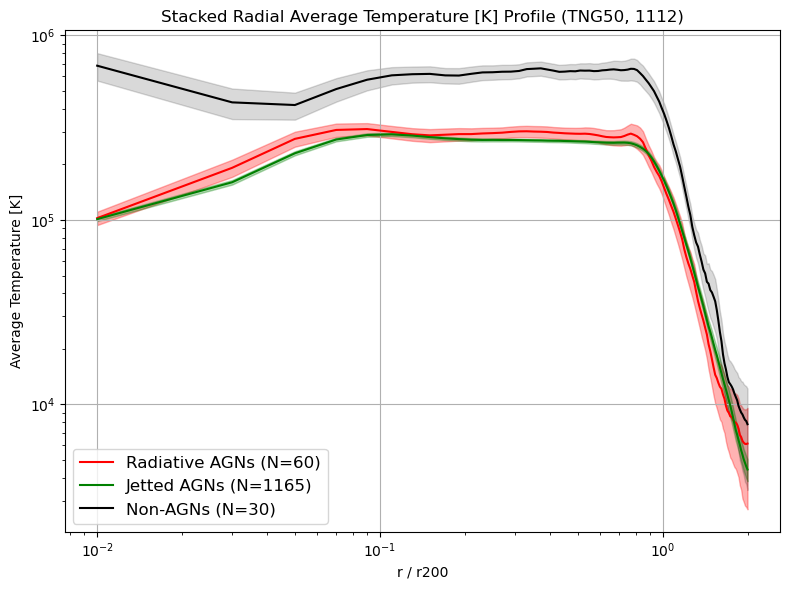

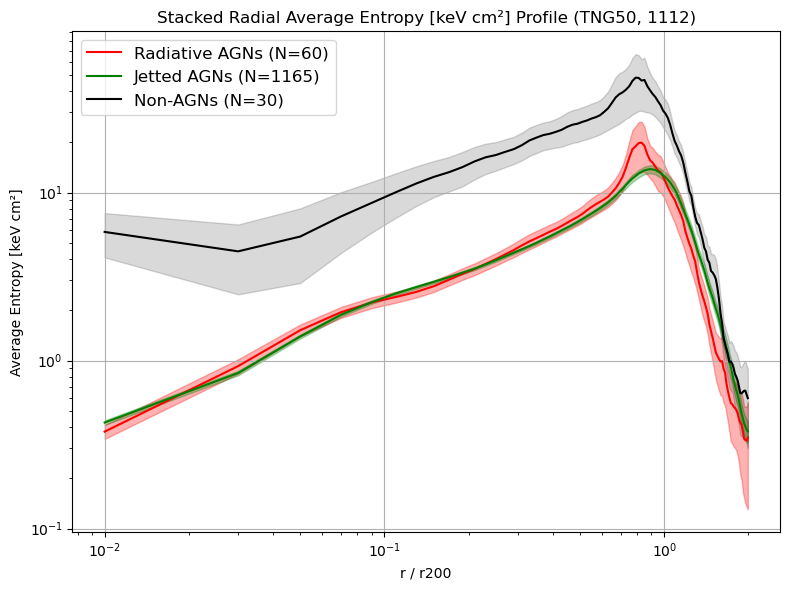

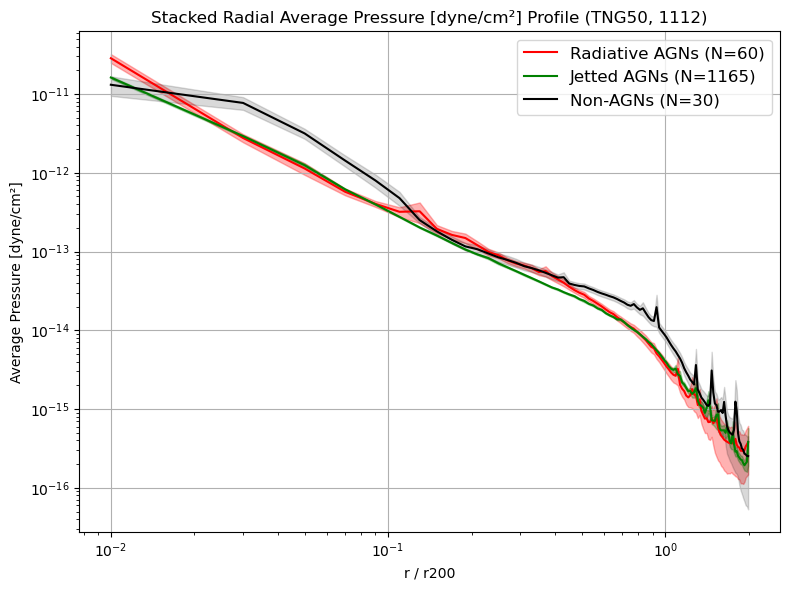

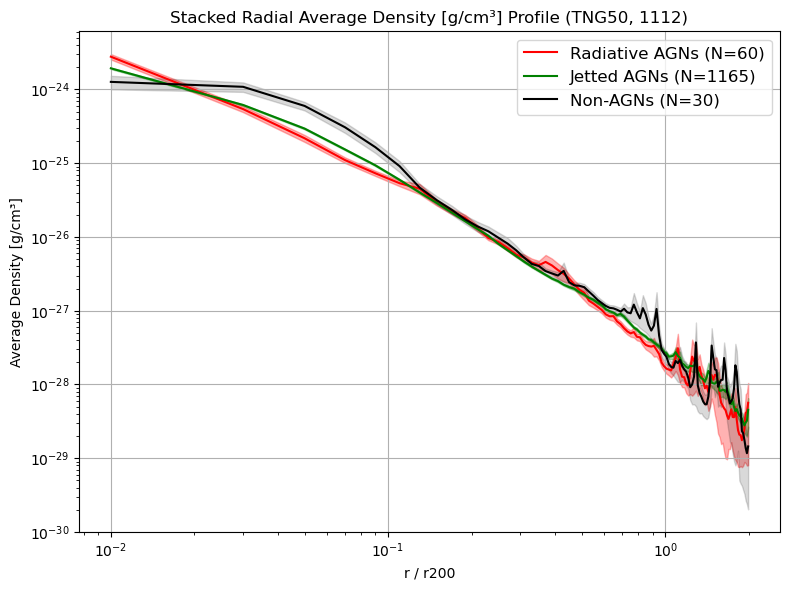

In [ ]:
# PART 5: Plot Thermodynamical Profiles (with 3 labels in each)

bin_edges = np.linspace(0, r_norm_max, nbins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

profiles_ha_agn = np.load(f"profile2d_{tag[0]}_{hm}.npz")
profiles_hn_agn = np.load(f"profile2d_{tag[2]}_{hm}.npz")
profiles_hn_non = np.load(f"profile2d_{tag[3]}_{hm}.npz")

data = np.load(f"accretor_agn50_hm{hm}.npz")          #ha_agn, ha_non, hn_agn, hn_non ids
ha_agn = data["ha_agn"]
hn_agn = data["hn_agn"]
hn_non = data["hn_non"]

def plot_quantity(quantity, ylabel, filename):

    avg_ha_agn = profiles_ha_agn[f"{quantity}_mean"]
    err_ha_agn = profiles_ha_agn[f"{quantity}_sem"]
    
    avg_hn_agn = profiles_hn_agn[f"{quantity}_mean"]
    err_hn_agn = profiles_hn_agn[f"{quantity}_sem"]
    
    avg_hn_non = profiles_hn_non[f"{quantity}_mean"]
    err_hn_non = profiles_hn_non[f"{quantity}_sem"]

    plt.figure(figsize=(8, 6))

    # Efficient Accretors - AGN
    plt.plot(bin_centers, avg_ha_agn.flatten(), label=f"Radiative AGNs (N={len(ha_agn)})", color="red")
    plt.fill_between(bin_centers, (avg_ha_agn - err_ha_agn).flatten(), (avg_ha_agn + err_ha_agn).flatten(),
                     color="red", alpha=0.3)
    
    # Inefficient Accretors - AGN
    plt.plot(bin_centers, avg_hn_agn.flatten(), label=f"Jetted AGNs (N={len(hn_agn)})", color="green")
    plt.fill_between(bin_centers, (avg_hn_agn - err_hn_agn).flatten(), (avg_hn_agn + err_hn_agn).flatten(),
                     color="green", alpha=0.3)

    # Inefficient Accretors - Non-AGN
    plt.plot(bin_centers, avg_hn_non.flatten(), label=f"Non-AGNs (N={len(hn_non)})", color="black")
    plt.fill_between(bin_centers, (avg_hn_non - err_hn_non).flatten(), (avg_hn_non + err_hn_non).flatten(),
                     color="black", alpha=0.15)

    plt.xlabel("r / r200")
    plt.ylabel(ylabel)
    plt.title(f"Stacked Radial {ylabel} Profile (TNG50, {hm})")
    plt.legend(fontsize=12)
    plt.grid(True)
    #plt.xlim(1e-2, 1.2)
    #plt.ylim(ylim)
    plt.xscale("log")
    plt.yscale("log")
    plt.tight_layout()
    plt.savefig(filename, dpi=900)
    plt.show()

plot_quantity("temperature", "Average Temperature [K]", f"temperature_{hm}.png")
plot_quantity("entropy", "Average Entropy [keV cm²]", f"entropy_{hm}.png")
plot_quantity("pressure", "Average Pressure [dyne/cm²]", f"pressure_{hm}.png")
plot_quantity("density", "Average Density [g/cm³]", f"density_{hm}.png")

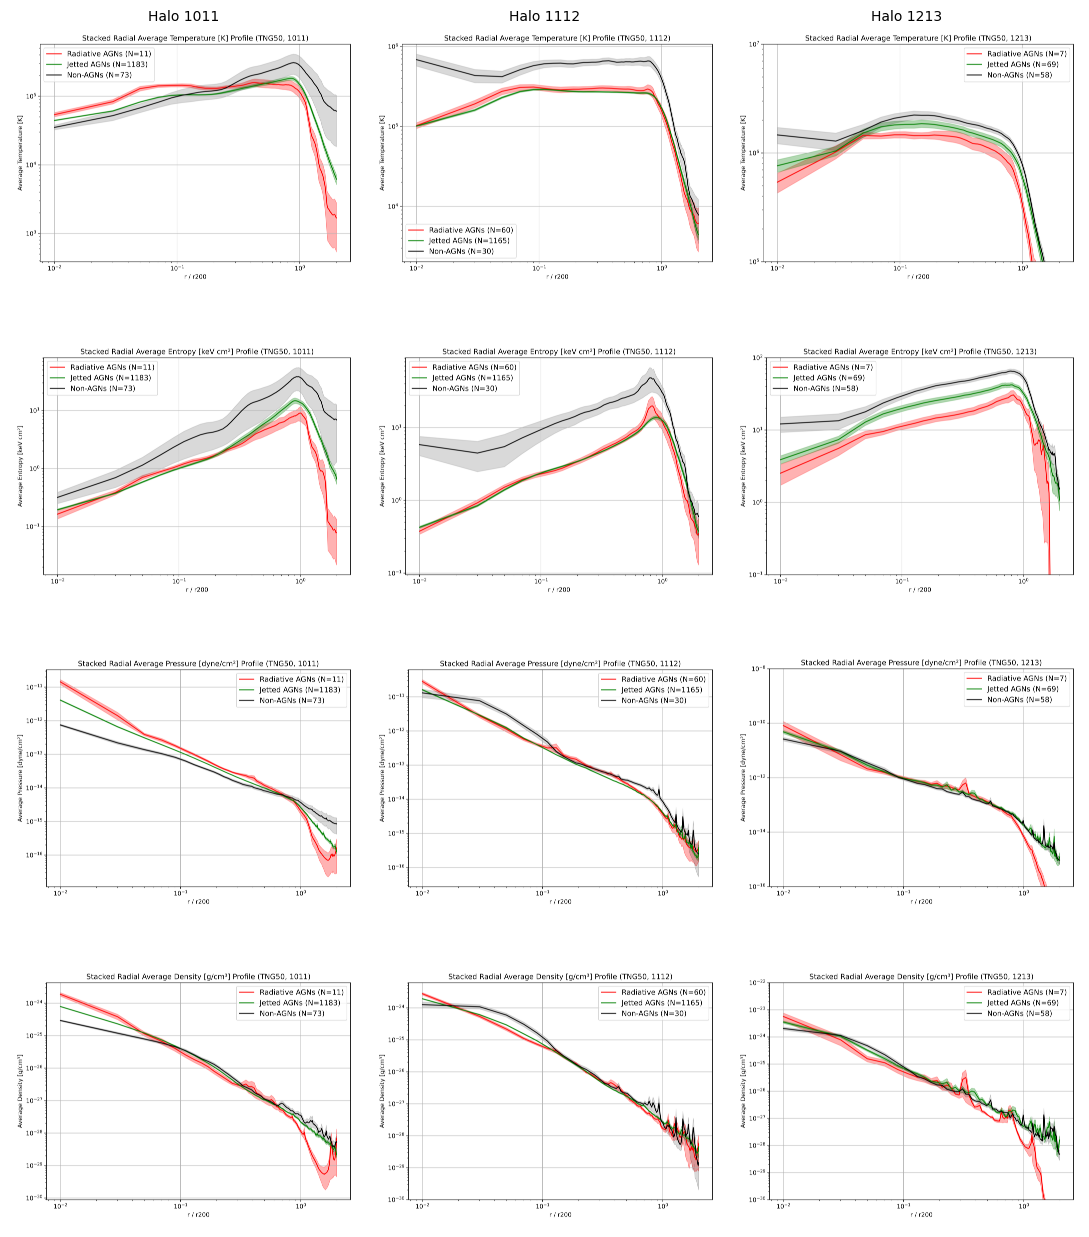

In [ ]:
# PART 6: Plot All Together

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

quantities = ["temperature", "entropy", "pressure", "density"]
hms = ["1011", "1112", "1213"]

fig, axes = plt.subplots(len(quantities), len(hms), figsize=(11, 13))

for i, quantity in enumerate(quantities):
    for j, hm in enumerate(hms):
        filename = f"{quantity}_{hm}.png"
        try:
            img = Image.open(filename)  # Resize for speed
            ax = axes[i, j]
            ax.imshow(np.asarray(img))
            ax.axis('off')
            if i == 0:
                ax.set_title(f"Halo {hm}", fontsize=10)
            if j == 0:
                ax.set_ylabel(quantity.capitalize(), fontsize=10)
        except Exception as e:
            print(f"Could not load {filename}: {e}")
            axes[i, j].axis('off')

plt.tight_layout()
plt.savefig("tng50_2D.pdf", dpi = 1200)
